# Importing the libraries

In [1]:
import pixellib
from pixellib.semantic import semantic_segmentation
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import PIL
import PIL.Image

2022-11-18 01:01:03.780459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 01:01:03.928058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-11-18 01:01:03.930378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-18 01:01:03.930443: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly i

In [ ]:
!pip install tensorflow

  Using cached tensorflow-2.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)


# Load the pretrained Deeplabv3+ on ADE20K

In [2]:
segment_image = semantic_segmentation()
segment_image.load_ade20k_model("deeplabv3_xception65_ade20k.h5")

2022-11-18 01:01:08.894199: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Defining functions

In [3]:
def IoU_coeff(y_true, y_pred):
    axes = (0,1) 
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) 
    mask = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask - intersection
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Testing on one image

In [20]:
##segment an image
segmap, seg_overlay = segment_image.segmentAsAde20k("/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person shuffled/Images_grid=2/active-activity-ball-exercise-41213.jpg", overlay = False)
# cv2.imwrite("/home/mohamed.boudjoghra/assignements/AI701/project/prediction/img.jpg", seg_overlay)

In [21]:

## getting the prediction
person_mask = np.zeros(seg_overlay.shape)
person_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
person_mask=np.average(person_mask, axis = 2)
person_mask*=(1.0/np.amax(person_mask))

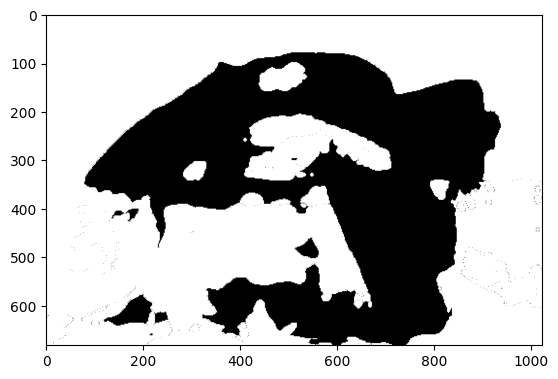

In [22]:
plt.imshow(person_mask,cmap = plt.cm.binary)

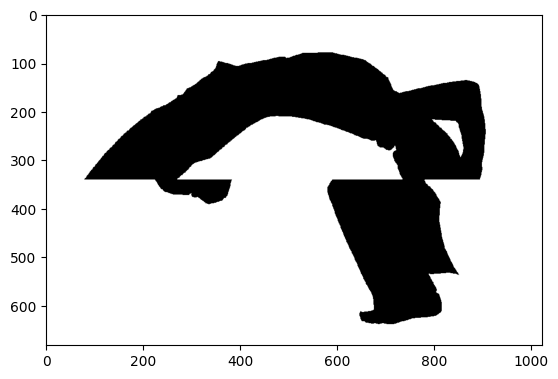

In [23]:
path = r'/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person shuffled/Masks_grid=2/active-activity-ball-exercise-41213.png' 
# Using cv2.imread() method
ground_truth = cv2.imread(path, 0)
ground_truth=np.float64(ground_truth)*(1.0/np.amax(ground_truth))
ground_truth=ground_truth
plt.imshow(ground_truth,cmap = plt.cm.binary)

In [24]:
IoU_coeff(ground_truth, person_mask) ## Testing if the function works

0.6487002609719361

In [25]:
IoU_coeff(person_mask, ground_truth)  ##Getting the IoU of the tested image

0.6487002609719361

# Getting the test IoU of the person dataset

In [26]:
##defining the paths
data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person shuffled/'

# testing the model on the ocludded data set

In [37]:
##defining the folders

Img_folders = ['Images_grid=2', 
               'Images_grid=4',
               'Images_grid=8',
               'Images_grid=16',
               'Images_grid=32'
           ]
Masks_folders = ['Masks_grid=2', 
           'Masks_grid=4',
           'Masks_grid=8',
           'Masks_grid=16',
           'Masks_grid=32'
                ]
Prediction_folders = ['Predictions_grid=2', 
                       'Predictions_grid=4',
                       'Predictions_grid=8',
                       'Predictions_grid=16',
                       'Predictions_grid=32']


In [38]:
## creating the directories
Images_dir = os.path.join(data_path, Img_folders[0])
Masks_dir = os.path.join(data_path, Masks_folders[0])
Predictions_dir = os.path.join(data_path, Prediction_folders[0])
Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory

In [39]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img
    print(f"The test was successfully completed, image {i} has iou = {iou_img}")
    i+=1
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

-----------------------------------------------------------------------
Testing image 1
The test was successfully completed, image 1 has iou = 0.6428671652649779
-----------------------------------------------------------------------
Testing image 2
The test was successfully completed, image 2 has iou = 0.4014387095633332
-----------------------------------------------------------------------
Testing image 3
The test was successfully completed, image 3 has iou = 0.7746139091260016
-----------------------------------------------------------------------
Testing image 4
The test was successfully completed, image 4 has iou = 0.6487002609719361
-----------------------------------------------------------------------
Testing image 5
The test was successfully completed, image 5 has iou = 0.40430017541929436
-----------------------------------------------------------------------
Testing image 6
The test was successfully completed, image 6 has iou = 0.34893678843951365
--------------------------

The test was successfully completed, image 51 has iou = 0.21287060249863202
-----------------------------------------------------------------------
Testing image 52
The test was successfully completed, image 52 has iou = 0.014015459262677703
-----------------------------------------------------------------------
Testing image 53
The test was successfully completed, image 53 has iou = 0.9832870997063002
-----------------------------------------------------------------------
Testing image 54
The test was successfully completed, image 54 has iou = 0.5180175065630687
-----------------------------------------------------------------------
Testing image 55
The test was successfully completed, image 55 has iou = 0.6228077906858704
-----------------------------------------------------------------------
Testing image 56
The test was successfully completed, image 56 has iou = 0.9492634834518788
-----------------------------------------------------------------------
Testing image 57
The test was 

The test was successfully completed, image 101 has iou = 0.9642061708583028
-----------------------------------------------------------------------
Testing image 102
The test was successfully completed, image 102 has iou = 0.7757760257672605
-----------------------------------------------------------------------
Testing image 103
The test was successfully completed, image 103 has iou = 0.8976687663653531
-----------------------------------------------------------------------
Testing image 104
The test was successfully completed, image 104 has iou = 0.9557568918920337
-----------------------------------------------------------------------
Testing image 105
The test was successfully completed, image 105 has iou = 0.3503348425290553
-----------------------------------------------------------------------
Testing image 106
The test was successfully completed, image 106 has iou = 0.900397566769028
-----------------------------------------------------------------------
Testing image 107
The t

The test was successfully completed, image 151 has iou = 0.8334650989296492
-----------------------------------------------------------------------
Testing image 152
The test was successfully completed, image 152 has iou = 0.8216579138754438
-----------------------------------------------------------------------
Testing image 153
The test was successfully completed, image 153 has iou = 0.8600949757072741
-----------------------------------------------------------------------
Testing image 154
The test was successfully completed, image 154 has iou = 0.7752172809523116
-----------------------------------------------------------------------
Testing image 155
The test was successfully completed, image 155 has iou = 0.9074664194104027
-----------------------------------------------------------------------
Testing image 156
The test was successfully completed, image 156 has iou = 0.9188089101879622
-----------------------------------------------------------------------
Testing image 157
The 

The test was successfully completed, image 201 has iou = 0.8121828637053295
-----------------------------------------------------------------------
Testing image 202
The test was successfully completed, image 202 has iou = 0.821318079167024
-----------------------------------------------------------------------
Testing image 203
The test was successfully completed, image 203 has iou = 0.6626508016162632
-----------------------------------------------------------------------
Testing image 204
The test was successfully completed, image 204 has iou = 0.3828951488273207
-----------------------------------------------------------------------
Testing image 205
The test was successfully completed, image 205 has iou = 0.19074985770496153
-----------------------------------------------------------------------
Testing image 206
The test was successfully completed, image 206 has iou = 0.4618421456926086
-----------------------------------------------------------------------
Testing image 207
The 

The test was successfully completed, image 251 has iou = 0.5614211383050095
-----------------------------------------------------------------------
Testing image 252
The test was successfully completed, image 252 has iou = 0.5532080465458128
-----------------------------------------------------------------------
Testing image 253
The test was successfully completed, image 253 has iou = 0.752585968114474
-----------------------------------------------------------------------
Testing image 254
The test was successfully completed, image 254 has iou = 0.7325270626156094
-----------------------------------------------------------------------
Testing image 255
The test was successfully completed, image 255 has iou = 0.6782313596339747
-----------------------------------------------------------------------
Testing image 256
The test was successfully completed, image 256 has iou = 0.8932632317095778
-----------------------------------------------------------------------
Testing image 257
The t

The test was successfully completed, image 301 has iou = 0.8745070492126609
-----------------------------------------------------------------------
Testing image 302
The test was successfully completed, image 302 has iou = 0.856620929050972
-----------------------------------------------------------------------
Testing image 303
The test was successfully completed, image 303 has iou = 0.647924777426537
-----------------------------------------------------------------------
Testing image 304
The test was successfully completed, image 304 has iou = 0.7862568613748376
-----------------------------------------------------------------------
Testing image 305
The test was successfully completed, image 305 has iou = 0.29886940983990146
-----------------------------------------------------------------------
Testing image 306
The test was successfully completed, image 306 has iou = 0.5322839459829226
-----------------------------------------------------------------------
Testing image 307
The t

The test was successfully completed, image 351 has iou = 0.8521945221163255
-----------------------------------------------------------------------
Testing image 352
The test was successfully completed, image 352 has iou = 0.9106114841977364
-----------------------------------------------------------------------
Testing image 353
The test was successfully completed, image 353 has iou = 0.25523742050726667
-----------------------------------------------------------------------
Testing image 354
The test was successfully completed, image 354 has iou = 0.2895704725392717
-----------------------------------------------------------------------
Testing image 355
The test was successfully completed, image 355 has iou = 0.30176846596236995
-----------------------------------------------------------------------
Testing image 356
The test was successfully completed, image 356 has iou = 0.9480982890213515
-----------------------------------------------------------------------
Testing image 357
Th

The test was successfully completed, image 401 has iou = 0.6243833124966112
-----------------------------------------------------------------------
Testing image 402
The test was successfully completed, image 402 has iou = 0.2946099621735411
-----------------------------------------------------------------------
Testing image 403
The test was successfully completed, image 403 has iou = 0.46903973289310413
-----------------------------------------------------------------------
Testing image 404
The test was successfully completed, image 404 has iou = 0.3396360030516488
-----------------------------------------------------------------------
Testing image 405
The test was successfully completed, image 405 has iou = 0.09785409580895643
-----------------------------------------------------------------------
Testing image 406
The test was successfully completed, image 406 has iou = 0.43966556676974394
-----------------------------------------------------------------------
Testing image 407
T

The test was successfully completed, image 451 has iou = 0.4702603829454993
-----------------------------------------------------------------------
Testing image 452
The test was successfully completed, image 452 has iou = 0.4444374858096663
-----------------------------------------------------------------------
Testing image 453
The test was successfully completed, image 453 has iou = 0.415692629691347
-----------------------------------------------------------------------
Testing image 454
The test was successfully completed, image 454 has iou = 0.37732344575547017
-----------------------------------------------------------------------
Testing image 455
The test was successfully completed, image 455 has iou = 0.8223158149431762
-----------------------------------------------------------------------
Testing image 456
The test was successfully completed, image 456 has iou = 0.8689691421554897
-----------------------------------------------------------------------
Testing image 457
The 

The test was successfully completed, image 501 has iou = 0.05651950621134349
-----------------------------------------------------------------------
Testing image 502
The test was successfully completed, image 502 has iou = 0.7286356451197357
-----------------------------------------------------------------------
Testing image 503
The test was successfully completed, image 503 has iou = 0.7221295308827809
-----------------------------------------------------------------------
Testing image 504
The test was successfully completed, image 504 has iou = 0.8769955736194465
-----------------------------------------------------------------------
Testing image 505
The test was successfully completed, image 505 has iou = 0.8133744203010538
-----------------------------------------------------------------------
Testing image 506
The test was successfully completed, image 506 has iou = 0.5459870979188579
-----------------------------------------------------------------------
Testing image 507
The

The test was successfully completed, image 551 has iou = 0.9723781787523553
-----------------------------------------------------------------------
Testing image 552
The test was successfully completed, image 552 has iou = 0.8963054070950204
-----------------------------------------------------------------------
Testing image 553
The test was successfully completed, image 553 has iou = 0.14900487836815332
-----------------------------------------------------------------------
Testing image 554
The test was successfully completed, image 554 has iou = 0.3232659506561379
-----------------------------------------------------------------------
Testing image 555
The test was successfully completed, image 555 has iou = 0.38695962546529505
-----------------------------------------------------------------------
Testing image 556
The test was successfully completed, image 556 has iou = 0.42210527402057757
-----------------------------------------------------------------------
Testing image 557
T

The test was successfully completed, image 601 has iou = 0.5249187805852273
-----------------------------------------------------------------------
Testing image 602
The test was successfully completed, image 602 has iou = 0.056329468160265274
-----------------------------------------------------------------------
Testing image 603
The test was successfully completed, image 603 has iou = 0.6449623407870124
-----------------------------------------------------------------------
Testing image 604
The test was successfully completed, image 604 has iou = 0.908832539042565
-----------------------------------------------------------------------
Testing image 605
The test was successfully completed, image 605 has iou = 0.3714979573489175
-----------------------------------------------------------------------
Testing image 606
The test was successfully completed, image 606 has iou = 0.9567140087425039
-----------------------------------------------------------------------
Testing image 607
The

The test was successfully completed, image 651 has iou = 0.5435489628456919
-----------------------------------------------------------------------
Testing image 652
The test was successfully completed, image 652 has iou = 0.5103677242145858
-----------------------------------------------------------------------
Testing image 653
The test was successfully completed, image 653 has iou = 0.6158229433871433
-----------------------------------------------------------------------
Testing image 654
The test was successfully completed, image 654 has iou = 0.683088471604827
-----------------------------------------------------------------------
Testing image 655
The test was successfully completed, image 655 has iou = 0.8473374998914195
-----------------------------------------------------------------------
Testing image 656
The test was successfully completed, image 656 has iou = 0.7641557521407887
-----------------------------------------------------------------------
Testing image 657
The t

The test was successfully completed, image 701 has iou = 0.9509024260295169
-----------------------------------------------------------------------
Testing image 702
The test was successfully completed, image 702 has iou = 0.7315189558889135
-----------------------------------------------------------------------
Testing image 703
The test was successfully completed, image 703 has iou = 0.36020426212950574
-----------------------------------------------------------------------
Testing image 704
The test was successfully completed, image 704 has iou = 0.38012077517459014
-----------------------------------------------------------------------
Testing image 705
The test was successfully completed, image 705 has iou = 0.9151382899381013
-----------------------------------------------------------------------
Testing image 706
The test was successfully completed, image 706 has iou = 0.42353523837742363
-----------------------------------------------------------------------
Testing image 707
T

The test was successfully completed, image 751 has iou = 0.49080063447885885
-----------------------------------------------------------------------
Testing image 752
The test was successfully completed, image 752 has iou = 0.9229254781761305
-----------------------------------------------------------------------
Testing image 753
The test was successfully completed, image 753 has iou = 0.8006984197676508
-----------------------------------------------------------------------
Testing image 754
The test was successfully completed, image 754 has iou = 0.3066074267428602
-----------------------------------------------------------------------
Testing image 755
The test was successfully completed, image 755 has iou = 0.0004171537520191802
-----------------------------------------------------------------------
Testing image 756
The test was successfully completed, image 756 has iou = 0.3668294892537299
-----------------------------------------------------------------------
Testing image 757


The test was successfully completed, image 801 has iou = 0.9055884900644455
-----------------------------------------------------------------------
Testing image 802
The test was successfully completed, image 802 has iou = 0.16913627050914598
-----------------------------------------------------------------------
Testing image 803
The test was successfully completed, image 803 has iou = 0.5778791220750568
-----------------------------------------------------------------------
Testing image 804
The test was successfully completed, image 804 has iou = 0.24096165469527622
-----------------------------------------------------------------------
Testing image 805
The test was successfully completed, image 805 has iou = 0.6856444073040314
-----------------------------------------------------------------------
Testing image 806
The test was successfully completed, image 806 has iou = 0.8483000436025474
-----------------------------------------------------------------------
Testing image 807
Th

The test was successfully completed, image 851 has iou = 0.7008816598252106
-----------------------------------------------------------------------
Testing image 852
The test was successfully completed, image 852 has iou = 0.7040705031955903
-----------------------------------------------------------------------
Testing image 853
The test was successfully completed, image 853 has iou = 0.9073710767740385
-----------------------------------------------------------------------
Testing image 854
The test was successfully completed, image 854 has iou = 0.4525503117063136
-----------------------------------------------------------------------
Testing image 855
The test was successfully completed, image 855 has iou = 0.6982160290571521
-----------------------------------------------------------------------
Testing image 856
The test was successfully completed, image 856 has iou = 0.3188837091623974
-----------------------------------------------------------------------
Testing image 857
The 

The test was successfully completed, image 901 has iou = 0.4344760118669322
-----------------------------------------------------------------------
Testing image 902
The test was successfully completed, image 902 has iou = 0.46755481343664795
-----------------------------------------------------------------------
Testing image 903
The test was successfully completed, image 903 has iou = 0.7309854515510157
-----------------------------------------------------------------------
Testing image 904
The test was successfully completed, image 904 has iou = 0.6405171368445534
-----------------------------------------------------------------------
Testing image 905
The test was successfully completed, image 905 has iou = 0.7995570109685938
-----------------------------------------------------------------------
Testing image 906
The test was successfully completed, image 906 has iou = 0.3779837630424094
-----------------------------------------------------------------------
Testing image 907
The

The test was successfully completed, image 951 has iou = 0.8709744436495442
-----------------------------------------------------------------------
Testing image 952
The test was successfully completed, image 952 has iou = 0.8321520717437063
-----------------------------------------------------------------------
Testing image 953
The test was successfully completed, image 953 has iou = 0.4105532072114478
-----------------------------------------------------------------------
Testing image 954
The test was successfully completed, image 954 has iou = 0.43720292262891836
-----------------------------------------------------------------------
Testing image 955
The test was successfully completed, image 955 has iou = 0.4147902896183473
-----------------------------------------------------------------------
Testing image 956
The test was successfully completed, image 956 has iou = 0.660673496519032
-----------------------------------------------------------------------
Testing image 957
The 

The test was successfully completed, image 1001 has iou = 0.41903216121692566
-----------------------------------------------------------------------
Testing image 1002
The test was successfully completed, image 1002 has iou = 0.7860542696460835
-----------------------------------------------------------------------
Testing image 1003
The test was successfully completed, image 1003 has iou = 0.6530835049455855
-----------------------------------------------------------------------
Testing image 1004
The test was successfully completed, image 1004 has iou = 0.8372058185137382
-----------------------------------------------------------------------
Testing image 1005
The test was successfully completed, image 1005 has iou = 0.48231112038038687
-----------------------------------------------------------------------
Testing image 1006
The test was successfully completed, image 1006 has iou = 0.4949932136546404
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1050 has iou = 0.5468964702406571
-----------------------------------------------------------------------
Testing image 1051
The test was successfully completed, image 1051 has iou = 0.7967830981303885
-----------------------------------------------------------------------
Testing image 1052
The test was successfully completed, image 1052 has iou = 0.4726292551623782
-----------------------------------------------------------------------
Testing image 1053
The test was successfully completed, image 1053 has iou = 0.7854388635477219
-----------------------------------------------------------------------
Testing image 1054
The test was successfully completed, image 1054 has iou = 0.666188519331282
-----------------------------------------------------------------------
Testing image 1055
The test was successfully completed, image 1055 has iou = 0.8951619193093132
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 1099 has iou = 0.05492835482702955
-----------------------------------------------------------------------
Testing image 1100
The test was successfully completed, image 1100 has iou = 0.4120020247043297
-----------------------------------------------------------------------
Testing image 1101
The test was successfully completed, image 1101 has iou = 0.38524567784164815
-----------------------------------------------------------------------
Testing image 1102
The test was successfully completed, image 1102 has iou = 0.686873902763462
-----------------------------------------------------------------------
Testing image 1103
The test was successfully completed, image 1103 has iou = 0
-----------------------------------------------------------------------
Testing image 1104
The test was successfully completed, image 1104 has iou = 0.6613919448923072
-----------------------------------------------------------------------
Testing image 1105
The test

The test was successfully completed, image 1148 has iou = 0.9586282562972062
-----------------------------------------------------------------------
Testing image 1149
The test was successfully completed, image 1149 has iou = 0.7211320049181852
-----------------------------------------------------------------------
Testing image 1150
The test was successfully completed, image 1150 has iou = 0.7162584609653959
-----------------------------------------------------------------------
Testing image 1151
The test was successfully completed, image 1151 has iou = 0.8158321139870609
-----------------------------------------------------------------------
Testing image 1152
The test was successfully completed, image 1152 has iou = 0.8223042562065691
-----------------------------------------------------------------------
Testing image 1153
The test was successfully completed, image 1153 has iou = 0.6059864996559757
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1197 has iou = 0.7494625991805812
-----------------------------------------------------------------------
Testing image 1198
The test was successfully completed, image 1198 has iou = 0.5548375496387614
-----------------------------------------------------------------------
Testing image 1199
The test was successfully completed, image 1199 has iou = 0.8863925400010249
-----------------------------------------------------------------------
Testing image 1200
The test was successfully completed, image 1200 has iou = 0.6083631441174955
-----------------------------------------------------------------------
Testing image 1201
The test was successfully completed, image 1201 has iou = 0.9338151961606146
-----------------------------------------------------------------------
Testing image 1202
The test was successfully completed, image 1202 has iou = 0.3976941397036375
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1246 has iou = 0.16787737527632882
-----------------------------------------------------------------------
Testing image 1247
The test was successfully completed, image 1247 has iou = 0.3212571964098618
-----------------------------------------------------------------------
Testing image 1248
The test was successfully completed, image 1248 has iou = 0.28834075655956765
-----------------------------------------------------------------------
Testing image 1249
The test was successfully completed, image 1249 has iou = 0.9178419209015037
-----------------------------------------------------------------------
Testing image 1250
The test was successfully completed, image 1250 has iou = 0.8759333211146256
-----------------------------------------------------------------------
Testing image 1251
The test was successfully completed, image 1251 has iou = 0.9142418867570086
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1295 has iou = 0.6223698936296022
-----------------------------------------------------------------------
Testing image 1296
The test was successfully completed, image 1296 has iou = 0.3820418351154893
-----------------------------------------------------------------------
Testing image 1297
The test was successfully completed, image 1297 has iou = 0.2695291865371233
-----------------------------------------------------------------------
Testing image 1298
The test was successfully completed, image 1298 has iou = 0.8027157658760177
-----------------------------------------------------------------------
Testing image 1299
The test was successfully completed, image 1299 has iou = 0.374376552338318
-----------------------------------------------------------------------
Testing image 1300
The test was successfully completed, image 1300 has iou = 0.354500136434607
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 1344 has iou = 0.8171946788694538
-----------------------------------------------------------------------
Testing image 1345
The test was successfully completed, image 1345 has iou = 0.8495185658274454
-----------------------------------------------------------------------
Testing image 1346
The test was successfully completed, image 1346 has iou = 0.5989909051160428
-----------------------------------------------------------------------
Testing image 1347
The test was successfully completed, image 1347 has iou = 0.38257512364192175
-----------------------------------------------------------------------
Testing image 1348
The test was successfully completed, image 1348 has iou = 0.7030045445505089
-----------------------------------------------------------------------
Testing image 1349
The test was successfully completed, image 1349 has iou = 0.06569080996292084
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1393 has iou = 0.729542400345336
-----------------------------------------------------------------------
Testing image 1394
The test was successfully completed, image 1394 has iou = 0.6326977562970547
-----------------------------------------------------------------------
Testing image 1395
The test was successfully completed, image 1395 has iou = 0.840931793875639
-----------------------------------------------------------------------
Testing image 1396
The test was successfully completed, image 1396 has iou = 0.8553179788207715
-----------------------------------------------------------------------
Testing image 1397
The test was successfully completed, image 1397 has iou = 0.801763649445384
-----------------------------------------------------------------------
Testing image 1398
The test was successfully completed, image 1398 has iou = 0.4158666796991609
-----------------------------------------------------------------------
Testing image 

The test was successfully completed, image 1442 has iou = 0.822575679493197
-----------------------------------------------------------------------
Testing image 1443
The test was successfully completed, image 1443 has iou = 0.9488497485019629
-----------------------------------------------------------------------
Testing image 1444
The test was successfully completed, image 1444 has iou = 0.819553082523937
-----------------------------------------------------------------------
Testing image 1445
The test was successfully completed, image 1445 has iou = 0.9176905960424048
-----------------------------------------------------------------------
Testing image 1446
The test was successfully completed, image 1446 has iou = 0.7883286507936883
-----------------------------------------------------------------------
Testing image 1447
The test was successfully completed, image 1447 has iou = 0.5327828410923294
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 1491 has iou = 0.7650711774985605
-----------------------------------------------------------------------
Testing image 1492
The test was successfully completed, image 1492 has iou = 0.6771563279343965
-----------------------------------------------------------------------
Testing image 1493
The test was successfully completed, image 1493 has iou = 0.8526152661379351
-----------------------------------------------------------------------
Testing image 1494
The test was successfully completed, image 1494 has iou = 0.7509278647383028
-----------------------------------------------------------------------
Testing image 1495
The test was successfully completed, image 1495 has iou = 0.8931243861918854
-----------------------------------------------------------------------
Testing image 1496
The test was successfully completed, image 1496 has iou = 0.9349601391587712
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1540 has iou = 0.6620951940432961
-----------------------------------------------------------------------
Testing image 1541
The test was successfully completed, image 1541 has iou = 0.42736661519727864
-----------------------------------------------------------------------
Testing image 1542
The test was successfully completed, image 1542 has iou = 0.3493702180747197
-----------------------------------------------------------------------
Testing image 1543
The test was successfully completed, image 1543 has iou = 0.6390255123798102
-----------------------------------------------------------------------
Testing image 1544
The test was successfully completed, image 1544 has iou = 0.7124838837629185
-----------------------------------------------------------------------
Testing image 1545
The test was successfully completed, image 1545 has iou = 0.6198716265734964
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 1589 has iou = 0.640777486066769
-----------------------------------------------------------------------
Testing image 1590
The test was successfully completed, image 1590 has iou = 0.8325298664295789
-----------------------------------------------------------------------
Testing image 1591
The test was successfully completed, image 1591 has iou = 0.6934165743217594
-----------------------------------------------------------------------
Testing image 1592
The test was successfully completed, image 1592 has iou = 0.7231826394751586
-----------------------------------------------------------------------
Testing image 1593
The test was successfully completed, image 1593 has iou = 0.8915673205542258
-----------------------------------------------------------------------
Testing image 1594
The test was successfully completed, image 1594 has iou = 0.7506421499011486
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 1638 has iou = 0.6306308709756488
-----------------------------------------------------------------------
Testing image 1639
The test was successfully completed, image 1639 has iou = 0.46419326242582293
-----------------------------------------------------------------------
Testing image 1640
The test was successfully completed, image 1640 has iou = 0.9463336255892778
-----------------------------------------------------------------------
Testing image 1641
The test was successfully completed, image 1641 has iou = 0.4298841493707414
-----------------------------------------------------------------------
Testing image 1642
The test was successfully completed, image 1642 has iou = 0.9349107527187993
-----------------------------------------------------------------------
Testing image 1643
The test was successfully completed, image 1643 has iou = 0.9551406137553964
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 1687 has iou = 0.7601751175819973
-----------------------------------------------------------------------
Testing image 1688
The test was successfully completed, image 1688 has iou = 0.6918706807703283
-----------------------------------------------------------------------
Testing image 1689
The test was successfully completed, image 1689 has iou = 0.8998144070406615
-----------------------------------------------------------------------
Testing image 1690
The test was successfully completed, image 1690 has iou = 0.5731851652897673
-----------------------------------------------------------------------
Testing image 1691
The test was successfully completed, image 1691 has iou = 0.23680970642917532
-----------------------------------------------------------------------
Testing image 1692
The test was successfully completed, image 1692 has iou = 0.6967333727256135
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 1736 has iou = 0.6687214901060952
-----------------------------------------------------------------------
Testing image 1737
The test was successfully completed, image 1737 has iou = 0.5047431417684359
-----------------------------------------------------------------------
Testing image 1738
The test was successfully completed, image 1738 has iou = 0.9012588025963119
-----------------------------------------------------------------------
Testing image 1739
The test was successfully completed, image 1739 has iou = 0.1369487705243536
-----------------------------------------------------------------------
Testing image 1740
The test was successfully completed, image 1740 has iou = 0.04834795333391232
-----------------------------------------------------------------------
Testing image 1741
The test was successfully completed, image 1741 has iou = 0.7053237110467341
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 1785 has iou = 0.7370760274751593
-----------------------------------------------------------------------
Testing image 1786
The test was successfully completed, image 1786 has iou = 0.7753488399105968
-----------------------------------------------------------------------
Testing image 1787
The test was successfully completed, image 1787 has iou = 0.9740880853926943
-----------------------------------------------------------------------
Testing image 1788
The test was successfully completed, image 1788 has iou = 0.9143844984860838
-----------------------------------------------------------------------
Testing image 1789
The test was successfully completed, image 1789 has iou = 0.4098802388385671
-----------------------------------------------------------------------
Testing image 1790
The test was successfully completed, image 1790 has iou = 0.8878606757891582
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1834 has iou = 0.042072422482294536
-----------------------------------------------------------------------
Testing image 1835
The test was successfully completed, image 1835 has iou = 0.7476134909789313
-----------------------------------------------------------------------
Testing image 1836
The test was successfully completed, image 1836 has iou = 0.25818962954696983
-----------------------------------------------------------------------
Testing image 1837
The test was successfully completed, image 1837 has iou = 0.3737672560578721
-----------------------------------------------------------------------
Testing image 1838
The test was successfully completed, image 1838 has iou = 0.768773215590371
-----------------------------------------------------------------------
Testing image 1839
The test was successfully completed, image 1839 has iou = 0.5436425651995305
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1883 has iou = 0.2883178365382894
-----------------------------------------------------------------------
Testing image 1884
The test was successfully completed, image 1884 has iou = 0.8319570426770234
-----------------------------------------------------------------------
Testing image 1885
The test was successfully completed, image 1885 has iou = 0.15108300381563636
-----------------------------------------------------------------------
Testing image 1886
The test was successfully completed, image 1886 has iou = 0.7331343697429401
-----------------------------------------------------------------------
Testing image 1887
The test was successfully completed, image 1887 has iou = 0.7170476351901177
-----------------------------------------------------------------------
Testing image 1888
The test was successfully completed, image 1888 has iou = 0.6434010955999149
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 1932 has iou = 0.8020531205343701
-----------------------------------------------------------------------
Testing image 1933
The test was successfully completed, image 1933 has iou = 0.46990135789294957
-----------------------------------------------------------------------
Testing image 1934
The test was successfully completed, image 1934 has iou = 0.3542110436590531
-----------------------------------------------------------------------
Testing image 1935
The test was successfully completed, image 1935 has iou = 0.8942090037523736
-----------------------------------------------------------------------
Testing image 1936
The test was successfully completed, image 1936 has iou = 0.780407889331224
-----------------------------------------------------------------------
Testing image 1937
The test was successfully completed, image 1937 has iou = 0.4642616819711541
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1981 has iou = 0.5498534016587727
-----------------------------------------------------------------------
Testing image 1982
The test was successfully completed, image 1982 has iou = 0.8311999339719416
-----------------------------------------------------------------------
Testing image 1983
The test was successfully completed, image 1983 has iou = 0.32268675686082987
-----------------------------------------------------------------------
Testing image 1984
The test was successfully completed, image 1984 has iou = 0.2753459400613988
-----------------------------------------------------------------------
Testing image 1985
The test was successfully completed, image 1985 has iou = 0.7717611360096034
-----------------------------------------------------------------------
Testing image 1986
The test was successfully completed, image 1986 has iou = 0.44635845686253167
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2030 has iou = 0.3310334998361205
-----------------------------------------------------------------------
Testing image 2031
The test was successfully completed, image 2031 has iou = 0.15510544065593398
-----------------------------------------------------------------------
Testing image 2032
The test was successfully completed, image 2032 has iou = 0.25285599569707795
-----------------------------------------------------------------------
Testing image 2033
The test was successfully completed, image 2033 has iou = 0.3646137796703076
-----------------------------------------------------------------------
Testing image 2034
The test was successfully completed, image 2034 has iou = 0.7739862046528365
-----------------------------------------------------------------------
Testing image 2035
The test was successfully completed, image 2035 has iou = 0.7024484775087657
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2079 has iou = 0.5310737387601885
-----------------------------------------------------------------------
Testing image 2080
The test was successfully completed, image 2080 has iou = 0.28258658126392594
-----------------------------------------------------------------------
Testing image 2081
The test was successfully completed, image 2081 has iou = 0.7317911648847178
-----------------------------------------------------------------------
Testing image 2082
The test was successfully completed, image 2082 has iou = 0.7082085028311143
-----------------------------------------------------------------------
Testing image 2083
The test was successfully completed, image 2083 has iou = 0.7064477662781969
-----------------------------------------------------------------------
Testing image 2084
The test was successfully completed, image 2084 has iou = 0.17705803401798917
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2128 has iou = 0.6206660991959128
-----------------------------------------------------------------------
Testing image 2129
The test was successfully completed, image 2129 has iou = 0.7906820404726014
-----------------------------------------------------------------------
Testing image 2130
The test was successfully completed, image 2130 has iou = 0.32070018119002974
-----------------------------------------------------------------------
Testing image 2131
The test was successfully completed, image 2131 has iou = 0.5970189069954107
-----------------------------------------------------------------------
Testing image 2132
The test was successfully completed, image 2132 has iou = 0.6399642589002968
-----------------------------------------------------------------------
Testing image 2133
The test was successfully completed, image 2133 has iou = 0.8320517299829251
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2177 has iou = 0.3997888391791187
-----------------------------------------------------------------------
Testing image 2178
The test was successfully completed, image 2178 has iou = 0.7233843827203631
-----------------------------------------------------------------------
Testing image 2179
The test was successfully completed, image 2179 has iou = 0.45677268395544607
-----------------------------------------------------------------------
Testing image 2180
The test was successfully completed, image 2180 has iou = 0.8532386708171503
-----------------------------------------------------------------------
Testing image 2181
The test was successfully completed, image 2181 has iou = 0.9113098533322461
-----------------------------------------------------------------------
Testing image 2182
The test was successfully completed, image 2182 has iou = 0.3878359817178055
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2226 has iou = 0.857702152015675
-----------------------------------------------------------------------
Testing image 2227
The test was successfully completed, image 2227 has iou = 0.8548612277309189
-----------------------------------------------------------------------
Testing image 2228
The test was successfully completed, image 2228 has iou = 0.0001909033842089989
-----------------------------------------------------------------------
Testing image 2229
The test was successfully completed, image 2229 has iou = 0.6247350074117024
-----------------------------------------------------------------------
Testing image 2230
The test was successfully completed, image 2230 has iou = 0.11984811268814465
-----------------------------------------------------------------------
Testing image 2231
The test was successfully completed, image 2231 has iou = 0.812906342521135
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2275 has iou = 0.6936100970133963
-----------------------------------------------------------------------
Testing image 2276
The test was successfully completed, image 2276 has iou = 0.2734095536393879
-----------------------------------------------------------------------
Testing image 2277
The test was successfully completed, image 2277 has iou = 0.7993432567206589
-----------------------------------------------------------------------
Testing image 2278
The test was successfully completed, image 2278 has iou = 0.4339149969660091
-----------------------------------------------------------------------
Testing image 2279
The test was successfully completed, image 2279 has iou = 0.6146272020132489
-----------------------------------------------------------------------
Testing image 2280
The test was successfully completed, image 2280 has iou = 0.5195047228950482
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2324 has iou = 0.17383533969359719
-----------------------------------------------------------------------
Testing image 2325
The test was successfully completed, image 2325 has iou = 0.6583852913271584
-----------------------------------------------------------------------
Testing image 2326
The test was successfully completed, image 2326 has iou = 0.9246820272247401
-----------------------------------------------------------------------
Testing image 2327
The test was successfully completed, image 2327 has iou = 0.6651409307776492
-----------------------------------------------------------------------
Testing image 2328
The test was successfully completed, image 2328 has iou = 0.7906776138325418
-----------------------------------------------------------------------
Testing image 2329
The test was successfully completed, image 2329 has iou = 0.7504760754050368
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2373 has iou = 0.31720639437646947
-----------------------------------------------------------------------
Testing image 2374
The test was successfully completed, image 2374 has iou = 0.4763783197598477
-----------------------------------------------------------------------
Testing image 2375
The test was successfully completed, image 2375 has iou = 0.44539336402498897
-----------------------------------------------------------------------
Testing image 2376
The test was successfully completed, image 2376 has iou = 0.825879931962831
-----------------------------------------------------------------------
Testing image 2377
The test was successfully completed, image 2377 has iou = 0.593756874536992
-----------------------------------------------------------------------
Testing image 2378
The test was successfully completed, image 2378 has iou = 0.7128083283659886
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2422 has iou = 0.44757040373043133
-----------------------------------------------------------------------
Testing image 2423
The test was successfully completed, image 2423 has iou = 0.6303005204554384
-----------------------------------------------------------------------
Testing image 2424
The test was successfully completed, image 2424 has iou = 0.9222664887248264
-----------------------------------------------------------------------
Testing image 2425
The test was successfully completed, image 2425 has iou = 0.38809057237799477
-----------------------------------------------------------------------
Testing image 2426
The test was successfully completed, image 2426 has iou = 0.8954064134761169
-----------------------------------------------------------------------
Testing image 2427
The test was successfully completed, image 2427 has iou = 0.8057991465654671
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2471 has iou = 0.4837343151213281
-----------------------------------------------------------------------
Testing image 2472
The test was successfully completed, image 2472 has iou = 0.49665553940962515
-----------------------------------------------------------------------
Testing image 2473
The test was successfully completed, image 2473 has iou = 0.9500987674029154
-----------------------------------------------------------------------
Testing image 2474
The test was successfully completed, image 2474 has iou = 0.6601528493165911
-----------------------------------------------------------------------
Testing image 2475
The test was successfully completed, image 2475 has iou = 0.8462300927519798
-----------------------------------------------------------------------
Testing image 2476
The test was successfully completed, image 2476 has iou = 0.5914180879272843
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2520 has iou = 0.28610733024370866
-----------------------------------------------------------------------
Testing image 2521
The test was successfully completed, image 2521 has iou = 0.8583135924449466
-----------------------------------------------------------------------
Testing image 2522
The test was successfully completed, image 2522 has iou = 0.8637761453577011
-----------------------------------------------------------------------
Testing image 2523
The test was successfully completed, image 2523 has iou = 0.42395404851873547
-----------------------------------------------------------------------
Testing image 2524
The test was successfully completed, image 2524 has iou = 0.5215658880603021
-----------------------------------------------------------------------
Testing image 2525
The test was successfully completed, image 2525 has iou = 0.3840286960855986
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2569 has iou = 0
-----------------------------------------------------------------------
Testing image 2570
The test was successfully completed, image 2570 has iou = 0.37757950538369667
-----------------------------------------------------------------------
Testing image 2571
The test was successfully completed, image 2571 has iou = 0.852871961075008
-----------------------------------------------------------------------
Testing image 2572
The test was successfully completed, image 2572 has iou = 0.58968671033055
-----------------------------------------------------------------------
Testing image 2573
The test was successfully completed, image 2573 has iou = 0.4272187909469755
-----------------------------------------------------------------------
Testing image 2574
The test was successfully completed, image 2574 has iou = 0.7813394362947266
-----------------------------------------------------------------------
Testing image 2575
The test wa

The test was successfully completed, image 2618 has iou = 0.8909199210469444
-----------------------------------------------------------------------
Testing image 2619
The test was successfully completed, image 2619 has iou = 0.4423797301710485
-----------------------------------------------------------------------
Testing image 2620
The test was successfully completed, image 2620 has iou = 0.8768774592667248
-----------------------------------------------------------------------
Testing image 2621
The test was successfully completed, image 2621 has iou = 0.9195536252122628
-----------------------------------------------------------------------
Testing image 2622
The test was successfully completed, image 2622 has iou = 0.8507631969549966
-----------------------------------------------------------------------
Testing image 2623
The test was successfully completed, image 2623 has iou = 0.3930580532763489
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2667 has iou = 0.5768967901009039
-----------------------------------------------------------------------
Testing image 2668
The test was successfully completed, image 2668 has iou = 0.8369951141295464
-----------------------------------------------------------------------
Testing image 2669
The test was successfully completed, image 2669 has iou = 0.9290552765515431
-----------------------------------------------------------------------
Testing image 2670
The test was successfully completed, image 2670 has iou = 0.8954776817740322
-----------------------------------------------------------------------
Testing image 2671
The test was successfully completed, image 2671 has iou = 0.6787671245237528
-----------------------------------------------------------------------
Testing image 2672
The test was successfully completed, image 2672 has iou = 0.7663170445555318
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2716 has iou = 0.7456613841902762
-----------------------------------------------------------------------
Testing image 2717
The test was successfully completed, image 2717 has iou = 0.9463107529716666
-----------------------------------------------------------------------
Testing image 2718
The test was successfully completed, image 2718 has iou = 0.8283478651956623
-----------------------------------------------------------------------
Testing image 2719
The test was successfully completed, image 2719 has iou = 0.8234805801318075
-----------------------------------------------------------------------
Testing image 2720
The test was successfully completed, image 2720 has iou = 0.7374967269784696
-----------------------------------------------------------------------
Testing image 2721
The test was successfully completed, image 2721 has iou = 0.5154471459121527
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2765 has iou = 0.926387507760202
-----------------------------------------------------------------------
Testing image 2766
The test was successfully completed, image 2766 has iou = 0.7563512268085771
-----------------------------------------------------------------------
Testing image 2767
The test was successfully completed, image 2767 has iou = 0.935440706322501
-----------------------------------------------------------------------
Testing image 2768
The test was successfully completed, image 2768 has iou = 0.847170847592705
-----------------------------------------------------------------------
Testing image 2769
The test was successfully completed, image 2769 has iou = 0.372436262779952
-----------------------------------------------------------------------
Testing image 2770
The test was successfully completed, image 2770 has iou = 0.9088782761586627
-----------------------------------------------------------------------
Testing image 2

The test was successfully completed, image 2814 has iou = 0.1908276852299712
-----------------------------------------------------------------------
Testing image 2815
The test was successfully completed, image 2815 has iou = 0.9194230475575769
-----------------------------------------------------------------------
Testing image 2816
The test was successfully completed, image 2816 has iou = 0.9492517170420683
-----------------------------------------------------------------------
Testing image 2817
The test was successfully completed, image 2817 has iou = 0.766397173290009
-----------------------------------------------------------------------
Testing image 2818
The test was successfully completed, image 2818 has iou = 0.8438519233122033
-----------------------------------------------------------------------
Testing image 2819
The test was successfully completed, image 2819 has iou = 0.20777686058838857
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2863 has iou = 0
-----------------------------------------------------------------------
Testing image 2864
The test was successfully completed, image 2864 has iou = 0.9489433957309872
-----------------------------------------------------------------------
Testing image 2865
The test was successfully completed, image 2865 has iou = 0.5907719771842487
-----------------------------------------------------------------------
Testing image 2866
The test was successfully completed, image 2866 has iou = 0.2699735434117607
-----------------------------------------------------------------------
Testing image 2867
The test was successfully completed, image 2867 has iou = 0.32388057080971094
-----------------------------------------------------------------------
Testing image 2868
The test was successfully completed, image 2868 has iou = 0.3653794775079853
-----------------------------------------------------------------------
Testing image 2869
The test

The test was successfully completed, image 2912 has iou = 0.9357489084505537
-----------------------------------------------------------------------
Testing image 2913
The test was successfully completed, image 2913 has iou = 0.8645794629428981
-----------------------------------------------------------------------
Testing image 2914
The test was successfully completed, image 2914 has iou = 0.4354764487266757
-----------------------------------------------------------------------
Testing image 2915
The test was successfully completed, image 2915 has iou = 0.24363460862347
-----------------------------------------------------------------------
Testing image 2916
The test was successfully completed, image 2916 has iou = 0.7349823655251684
-----------------------------------------------------------------------
Testing image 2917
The test was successfully completed, image 2917 has iou = 0.4411063329868633
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 2961 has iou = 0.9050792419779212
-----------------------------------------------------------------------
Testing image 2962
The test was successfully completed, image 2962 has iou = 0.7102663872901269
-----------------------------------------------------------------------
Testing image 2963
The test was successfully completed, image 2963 has iou = 0.6493722651472986
-----------------------------------------------------------------------
Testing image 2964
The test was successfully completed, image 2964 has iou = 0.4679619224674474
-----------------------------------------------------------------------
Testing image 2965
The test was successfully completed, image 2965 has iou = 0.9150413155501497
-----------------------------------------------------------------------
Testing image 2966
The test was successfully completed, image 2966 has iou = 0.4184499494555804
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 3010 has iou = 0.827255034580645
-----------------------------------------------------------------------
Testing image 3011
The test was successfully completed, image 3011 has iou = 0.29774863205749474
-----------------------------------------------------------------------
Testing image 3012
The test was successfully completed, image 3012 has iou = 0.432033733706667
-----------------------------------------------------------------------
Testing image 3013
The test was successfully completed, image 3013 has iou = 0.5442523624412698
-----------------------------------------------------------------------
Testing image 3014
The test was successfully completed, image 3014 has iou = 0.34608955463231983
-----------------------------------------------------------------------
Testing image 3015
The test was successfully completed, image 3015 has iou = 0.8374868630880212
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 3059 has iou = 0.43714802227897476
-----------------------------------------------------------------------
Testing image 3060
The test was successfully completed, image 3060 has iou = 0.44642360139033527
-----------------------------------------------------------------------
Testing image 3061
The test was successfully completed, image 3061 has iou = 0.001302800740693638
-----------------------------------------------------------------------
Testing image 3062
The test was successfully completed, image 3062 has iou = 0.0007744307902717368
-----------------------------------------------------------------------
Testing image 3063
The test was successfully completed, image 3063 has iou = 0.41998047580881454
-----------------------------------------------------------------------
Testing image 3064
The test was successfully completed, image 3064 has iou = 0.7108874397842617
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3108 has iou = 0.6582667179604518
-----------------------------------------------------------------------
Testing image 3109
The test was successfully completed, image 3109 has iou = 0.8589259036441834
-----------------------------------------------------------------------
Testing image 3110
The test was successfully completed, image 3110 has iou = 0.44917304622270304
-----------------------------------------------------------------------
Testing image 3111
The test was successfully completed, image 3111 has iou = 0.6717437319596921
-----------------------------------------------------------------------
Testing image 3112
The test was successfully completed, image 3112 has iou = 0.4900319390490148
-----------------------------------------------------------------------
Testing image 3113
The test was successfully completed, image 3113 has iou = 0.706188176746147
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 3157 has iou = 0.8989050915829505
-----------------------------------------------------------------------
Testing image 3158
The test was successfully completed, image 3158 has iou = 0.8630406453664167
-----------------------------------------------------------------------
Testing image 3159
The test was successfully completed, image 3159 has iou = 0.7395372600445721
-----------------------------------------------------------------------
Testing image 3160
The test was successfully completed, image 3160 has iou = 0.5033108262829168
-----------------------------------------------------------------------
Testing image 3161
The test was successfully completed, image 3161 has iou = 0.6231667905034108
-----------------------------------------------------------------------
Testing image 3162
The test was successfully completed, image 3162 has iou = 0.614339258732743
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 3206 has iou = 0.817631910845067
-----------------------------------------------------------------------
Testing image 3207
The test was successfully completed, image 3207 has iou = 0.8268153294805252
-----------------------------------------------------------------------
Testing image 3208
The test was successfully completed, image 3208 has iou = 0.8733239955489294
-----------------------------------------------------------------------
Testing image 3209
The test was successfully completed, image 3209 has iou = 0.2706620431574051
-----------------------------------------------------------------------
Testing image 3210
The test was successfully completed, image 3210 has iou = 0.7601212429802763
-----------------------------------------------------------------------
Testing image 3211
The test was successfully completed, image 3211 has iou = 0.8612267643849237
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 3255 has iou = 0.7482872667694166
-----------------------------------------------------------------------
Testing image 3256
The test was successfully completed, image 3256 has iou = 0.8239810934528439
-----------------------------------------------------------------------
Testing image 3257
The test was successfully completed, image 3257 has iou = 0.5895354094435862
-----------------------------------------------------------------------
Testing image 3258
The test was successfully completed, image 3258 has iou = 0.9316018864685296
-----------------------------------------------------------------------
Testing image 3259
The test was successfully completed, image 3259 has iou = 0.754637120409389
-----------------------------------------------------------------------
Testing image 3260
The test was successfully completed, image 3260 has iou = 0.8019832978680742
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 3304 has iou = 0.619504238377931
-----------------------------------------------------------------------
Testing image 3305
The test was successfully completed, image 3305 has iou = 0.8537427463357649
-----------------------------------------------------------------------
Testing image 3306
The test was successfully completed, image 3306 has iou = 0.691022965675843
-----------------------------------------------------------------------
Testing image 3307
The test was successfully completed, image 3307 has iou = 0.8862794264353396
-----------------------------------------------------------------------
Testing image 3308
The test was successfully completed, image 3308 has iou = 0.2400683329103783
-----------------------------------------------------------------------
Testing image 3309
The test was successfully completed, image 3309 has iou = 0.9451382423736346
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 3353 has iou = 0.6159354700615768
-----------------------------------------------------------------------
Testing image 3354
The test was successfully completed, image 3354 has iou = 0.3396198723113389
-----------------------------------------------------------------------
Testing image 3355
The test was successfully completed, image 3355 has iou = 0.946333705678472
-----------------------------------------------------------------------
Testing image 3356
The test was successfully completed, image 3356 has iou = 0.6133979515179934
-----------------------------------------------------------------------
Testing image 3357
The test was successfully completed, image 3357 has iou = 0.24419317328358872
-----------------------------------------------------------------------
Testing image 3358
The test was successfully completed, image 3358 has iou = 0.7886856542283427
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 3402 has iou = 0.7083441376029832
-----------------------------------------------------------------------
Testing image 3403
The test was successfully completed, image 3403 has iou = 0.620895684816922
-----------------------------------------------------------------------
Testing image 3404
The test was successfully completed, image 3404 has iou = 0.6131677416734378
-----------------------------------------------------------------------
Testing image 3405
The test was successfully completed, image 3405 has iou = 0.9069051482535514
-----------------------------------------------------------------------
Testing image 3406
The test was successfully completed, image 3406 has iou = 0.9241297885347552
-----------------------------------------------------------------------
Testing image 3407
The test was successfully completed, image 3407 has iou = 0.8814870612714241
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 3451 has iou = 0.7097765104837171
-----------------------------------------------------------------------
Testing image 3452
The test was successfully completed, image 3452 has iou = 0.21657082057779545
-----------------------------------------------------------------------
Testing image 3453
The test was successfully completed, image 3453 has iou = 0.3289203389118975
-----------------------------------------------------------------------
Testing image 3454
The test was successfully completed, image 3454 has iou = 0.7266655026847538
-----------------------------------------------------------------------
Testing image 3455
The test was successfully completed, image 3455 has iou = 0.5533220152435849
-----------------------------------------------------------------------
Testing image 3456
The test was successfully completed, image 3456 has iou = 0.9597200852609444
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 3500 has iou = 0.8526417182425112
-----------------------------------------------------------------------
Testing image 3501
The test was successfully completed, image 3501 has iou = 0.25935752350104363
-----------------------------------------------------------------------
Testing image 3502
The test was successfully completed, image 3502 has iou = 0.054628388174038006
-----------------------------------------------------------------------
Testing image 3503
The test was successfully completed, image 3503 has iou = 0.1700853444925975
-----------------------------------------------------------------------
Testing image 3504
The test was successfully completed, image 3504 has iou = 0.9409620941536434
-----------------------------------------------------------------------
Testing image 3505
The test was successfully completed, image 3505 has iou = 0.514712283064762
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3549 has iou = 0.19352154515025996
-----------------------------------------------------------------------
Testing image 3550
The test was successfully completed, image 3550 has iou = 0.7262699289292339
-----------------------------------------------------------------------
Testing image 3551
The test was successfully completed, image 3551 has iou = 0.6500334294698611
-----------------------------------------------------------------------
Testing image 3552
The test was successfully completed, image 3552 has iou = 0.38834400790136014
-----------------------------------------------------------------------
Testing image 3553
The test was successfully completed, image 3553 has iou = 0.29477679236188886
-----------------------------------------------------------------------
Testing image 3554
The test was successfully completed, image 3554 has iou = 0.3432322895914596
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3598 has iou = 0.94328053778928
-----------------------------------------------------------------------
Testing image 3599
The test was successfully completed, image 3599 has iou = 0.12049820662830395
-----------------------------------------------------------------------
Testing image 3600
The test was successfully completed, image 3600 has iou = 0.5845200614145073
-----------------------------------------------------------------------
Testing image 3601
The test was successfully completed, image 3601 has iou = 0.22236821153868175
-----------------------------------------------------------------------
Testing image 3602
The test was successfully completed, image 3602 has iou = 0.41034782087385135
-----------------------------------------------------------------------
Testing image 3603
The test was successfully completed, image 3603 has iou = 0.8014184497048212
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 3647 has iou = 0.9020705842651692
-----------------------------------------------------------------------
Testing image 3648
The test was successfully completed, image 3648 has iou = 0.7050140016452733
-----------------------------------------------------------------------
Testing image 3649
The test was successfully completed, image 3649 has iou = 0.5819421392504525
-----------------------------------------------------------------------
Testing image 3650
The test was successfully completed, image 3650 has iou = 0.40345961291287413
-----------------------------------------------------------------------
Testing image 3651
The test was successfully completed, image 3651 has iou = 0.39140481481947514
-----------------------------------------------------------------------
Testing image 3652
The test was successfully completed, image 3652 has iou = 0.1842999539431582
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3696 has iou = 0.5385782592017072
-----------------------------------------------------------------------
Testing image 3697
The test was successfully completed, image 3697 has iou = 0.24067605841119372
-----------------------------------------------------------------------
Testing image 3698
The test was successfully completed, image 3698 has iou = 0.8048467301302177
-----------------------------------------------------------------------
Testing image 3699
The test was successfully completed, image 3699 has iou = 0.43824177362520966
-----------------------------------------------------------------------
Testing image 3700
The test was successfully completed, image 3700 has iou = 0.16462703032708653
-----------------------------------------------------------------------
Testing image 3701
The test was successfully completed, image 3701 has iou = 0.39325885304855823
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 3745 has iou = 0.7039278741074783
-----------------------------------------------------------------------
Testing image 3746
The test was successfully completed, image 3746 has iou = 0.39343222349306595
-----------------------------------------------------------------------
Testing image 3747
The test was successfully completed, image 3747 has iou = 0.6632957933597854
-----------------------------------------------------------------------
Testing image 3748
The test was successfully completed, image 3748 has iou = 0.6673099186540135
-----------------------------------------------------------------------
Testing image 3749
The test was successfully completed, image 3749 has iou = 0.011890997266063385
-----------------------------------------------------------------------
Testing image 3750
The test was successfully completed, image 3750 has iou = 0.6293124768112077
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3794 has iou = 0.5961490144789068
-----------------------------------------------------------------------
Testing image 3795
The test was successfully completed, image 3795 has iou = 0.6373058138408754
-----------------------------------------------------------------------
Testing image 3796
The test was successfully completed, image 3796 has iou = 0.6475243930643266
-----------------------------------------------------------------------
Testing image 3797
The test was successfully completed, image 3797 has iou = 0.29743627402680667
-----------------------------------------------------------------------
Testing image 3798
The test was successfully completed, image 3798 has iou = 0.5918973019219547
-----------------------------------------------------------------------
Testing image 3799
The test was successfully completed, image 3799 has iou = 0.07069582228040162
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3843 has iou = 0.4371694521674919
-----------------------------------------------------------------------
Testing image 3844
The test was successfully completed, image 3844 has iou = 0.628666103650807
-----------------------------------------------------------------------
Testing image 3845
The test was successfully completed, image 3845 has iou = 0.8296356487636627
-----------------------------------------------------------------------
Testing image 3846
The test was successfully completed, image 3846 has iou = 0.3038537557344609
-----------------------------------------------------------------------
Testing image 3847
The test was successfully completed, image 3847 has iou = 0.5651039015051715
-----------------------------------------------------------------------
Testing image 3848
The test was successfully completed, image 3848 has iou = 0.9121478237088564
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 3892 has iou = 0.3454649865622177
-----------------------------------------------------------------------
Testing image 3893
The test was successfully completed, image 3893 has iou = 0.36667889970961653
-----------------------------------------------------------------------
Testing image 3894
The test was successfully completed, image 3894 has iou = 0.916735011920562
-----------------------------------------------------------------------
Testing image 3895
The test was successfully completed, image 3895 has iou = 0.8699863024773835
-----------------------------------------------------------------------
Testing image 3896
The test was successfully completed, image 3896 has iou = 0.39827889581682124
-----------------------------------------------------------------------
Testing image 3897
The test was successfully completed, image 3897 has iou = 0.7569668826882207
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 3941 has iou = 0.8813672174828039
-----------------------------------------------------------------------
Testing image 3942
The test was successfully completed, image 3942 has iou = 0.846423558300309
-----------------------------------------------------------------------
Testing image 3943
The test was successfully completed, image 3943 has iou = 0.7396749647075502
-----------------------------------------------------------------------
Testing image 3944
The test was successfully completed, image 3944 has iou = 0.5433809235794083
-----------------------------------------------------------------------
Testing image 3945
The test was successfully completed, image 3945 has iou = 0.944127694427959
-----------------------------------------------------------------------
Testing image 3946
The test was successfully completed, image 3946 has iou = 0.8847833279323908
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 3990 has iou = 0.33792815838865514
-----------------------------------------------------------------------
Testing image 3991
The test was successfully completed, image 3991 has iou = 0.8149195775758872
-----------------------------------------------------------------------
Testing image 3992
The test was successfully completed, image 3992 has iou = 0.8413729076643293
-----------------------------------------------------------------------
Testing image 3993
The test was successfully completed, image 3993 has iou = 0.43994497334427596
-----------------------------------------------------------------------
Testing image 3994
The test was successfully completed, image 3994 has iou = 0.37740495755117526
-----------------------------------------------------------------------
Testing image 3995
The test was successfully completed, image 3995 has iou = 0.8697978639383107
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4039 has iou = 0.10312599770978513
-----------------------------------------------------------------------
Testing image 4040
The test was successfully completed, image 4040 has iou = 0.6871267327670345
-----------------------------------------------------------------------
Testing image 4041
The test was successfully completed, image 4041 has iou = 0.7017180999499419
-----------------------------------------------------------------------
Testing image 4042
The test was successfully completed, image 4042 has iou = 0.9018470992520189
-----------------------------------------------------------------------
Testing image 4043
The test was successfully completed, image 4043 has iou = 0.4275664354449041
-----------------------------------------------------------------------
Testing image 4044
The test was successfully completed, image 4044 has iou = 0.38538831495028464
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4088 has iou = 0.7226602618654178
-----------------------------------------------------------------------
Testing image 4089
The test was successfully completed, image 4089 has iou = 0.7396728691425551
-----------------------------------------------------------------------
Testing image 4090
The test was successfully completed, image 4090 has iou = 0.42654240041330005
-----------------------------------------------------------------------
Testing image 4091
The test was successfully completed, image 4091 has iou = 0.4467154470995458
-----------------------------------------------------------------------
Testing image 4092
The test was successfully completed, image 4092 has iou = 0.6654038818793586
-----------------------------------------------------------------------
Testing image 4093
The test was successfully completed, image 4093 has iou = 0.2916056799460344
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4137 has iou = 0.9506170908917937
-----------------------------------------------------------------------
Testing image 4138
The test was successfully completed, image 4138 has iou = 0.5410489412598397
-----------------------------------------------------------------------
Testing image 4139
The test was successfully completed, image 4139 has iou = 0.9388577912286822
-----------------------------------------------------------------------
Testing image 4140
The test was successfully completed, image 4140 has iou = 0.6636571983679436
-----------------------------------------------------------------------
Testing image 4141
The test was successfully completed, image 4141 has iou = 0.7192578165362691
-----------------------------------------------------------------------
Testing image 4142
The test was successfully completed, image 4142 has iou = 0.8304039447134969
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4186 has iou = 0.39875455306247437
-----------------------------------------------------------------------
Testing image 4187
The test was successfully completed, image 4187 has iou = 0.6961005018382124
-----------------------------------------------------------------------
Testing image 4188
The test was successfully completed, image 4188 has iou = 0.8462835563440834
-----------------------------------------------------------------------
Testing image 4189
The test was successfully completed, image 4189 has iou = 0.8505753012932744
-----------------------------------------------------------------------
Testing image 4190
The test was successfully completed, image 4190 has iou = 0.8662649175866971
-----------------------------------------------------------------------
Testing image 4191
The test was successfully completed, image 4191 has iou = 0.6199472612955725
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4235 has iou = 0.8729262576979865
-----------------------------------------------------------------------
Testing image 4236
The test was successfully completed, image 4236 has iou = 0.17820315275184434
-----------------------------------------------------------------------
Testing image 4237
The test was successfully completed, image 4237 has iou = 0.7009297487661975
-----------------------------------------------------------------------
Testing image 4238
The test was successfully completed, image 4238 has iou = 0.7821515163142921
-----------------------------------------------------------------------
Testing image 4239
The test was successfully completed, image 4239 has iou = 0.4003252211023833
-----------------------------------------------------------------------
Testing image 4240
The test was successfully completed, image 4240 has iou = 0.5702582559996465
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4284 has iou = 0.7473519661840226
-----------------------------------------------------------------------
Testing image 4285
The test was successfully completed, image 4285 has iou = 0.7755695215059304
-----------------------------------------------------------------------
Testing image 4286
The test was successfully completed, image 4286 has iou = 0.527797497904552
-----------------------------------------------------------------------
Testing image 4287
The test was successfully completed, image 4287 has iou = 0.9294052354764967
-----------------------------------------------------------------------
Testing image 4288
The test was successfully completed, image 4288 has iou = 0.4288669869194116
-----------------------------------------------------------------------
Testing image 4289
The test was successfully completed, image 4289 has iou = 0.3005217059001443
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 4333 has iou = 0.47742967946201365
-----------------------------------------------------------------------
Testing image 4334
The test was successfully completed, image 4334 has iou = 0.79238820806451
-----------------------------------------------------------------------
Testing image 4335
The test was successfully completed, image 4335 has iou = 0.19218349253810385
-----------------------------------------------------------------------
Testing image 4336
The test was successfully completed, image 4336 has iou = 0.4012516038984916
-----------------------------------------------------------------------
Testing image 4337
The test was successfully completed, image 4337 has iou = 0.6836462622174964
-----------------------------------------------------------------------
Testing image 4338
The test was successfully completed, image 4338 has iou = 0.7902103506755829
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4382 has iou = 0.888054076724176
-----------------------------------------------------------------------
Testing image 4383
The test was successfully completed, image 4383 has iou = 0.8825736213418527
-----------------------------------------------------------------------
Testing image 4384
The test was successfully completed, image 4384 has iou = 0.717785990410289
-----------------------------------------------------------------------
Testing image 4385
The test was successfully completed, image 4385 has iou = 0.7815793841416113
-----------------------------------------------------------------------
Testing image 4386
The test was successfully completed, image 4386 has iou = 0.045925464006402426
-----------------------------------------------------------------------
Testing image 4387
The test was successfully completed, image 4387 has iou = 0.8906624529927257
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4431 has iou = 0.41820702894635814
-----------------------------------------------------------------------
Testing image 4432
The test was successfully completed, image 4432 has iou = 0.3914066209663877
-----------------------------------------------------------------------
Testing image 4433
The test was successfully completed, image 4433 has iou = 0.37130870727827475
-----------------------------------------------------------------------
Testing image 4434
The test was successfully completed, image 4434 has iou = 0.0855623766432602
-----------------------------------------------------------------------
Testing image 4435
The test was successfully completed, image 4435 has iou = 0.7117595438662906
-----------------------------------------------------------------------
Testing image 4436
The test was successfully completed, image 4436 has iou = 0.9452268034894488
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4480 has iou = 0.9155970246689639
-----------------------------------------------------------------------
Testing image 4481
The test was successfully completed, image 4481 has iou = 0.658898001077425
-----------------------------------------------------------------------
Testing image 4482
The test was successfully completed, image 4482 has iou = 0.6064272881519538
-----------------------------------------------------------------------
Testing image 4483
The test was successfully completed, image 4483 has iou = 0.5952616654180372
-----------------------------------------------------------------------
Testing image 4484
The test was successfully completed, image 4484 has iou = 0.48278220118453397
-----------------------------------------------------------------------
Testing image 4485
The test was successfully completed, image 4485 has iou = 0.732734135876656
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 4529 has iou = 0.4544136671667145
-----------------------------------------------------------------------
Testing image 4530
The test was successfully completed, image 4530 has iou = 0.32650296999911027
-----------------------------------------------------------------------
Testing image 4531
The test was successfully completed, image 4531 has iou = 0.6809893123541302
-----------------------------------------------------------------------
Testing image 4532
The test was successfully completed, image 4532 has iou = 0.5510991199213402
-----------------------------------------------------------------------
Testing image 4533
The test was successfully completed, image 4533 has iou = 0.9008576216068404
-----------------------------------------------------------------------
Testing image 4534
The test was successfully completed, image 4534 has iou = 0.9465644566340203
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4578 has iou = 0.7884490275954379
-----------------------------------------------------------------------
Testing image 4579
The test was successfully completed, image 4579 has iou = 0.8539897734627093
-----------------------------------------------------------------------
Testing image 4580
The test was successfully completed, image 4580 has iou = 0.7433095466846594
-----------------------------------------------------------------------
Testing image 4581
The test was successfully completed, image 4581 has iou = 0.5950617628725617
-----------------------------------------------------------------------
Testing image 4582
The test was successfully completed, image 4582 has iou = 0.7868222221336413
-----------------------------------------------------------------------
Testing image 4583
The test was successfully completed, image 4583 has iou = 0.4924774598093088
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4627 has iou = 0.5967689024001674
-----------------------------------------------------------------------
Testing image 4628
The test was successfully completed, image 4628 has iou = 0.18815029588021687
-----------------------------------------------------------------------
Testing image 4629
The test was successfully completed, image 4629 has iou = 0.9090641353865607
-----------------------------------------------------------------------
Testing image 4630
The test was successfully completed, image 4630 has iou = 0.769895555299342
-----------------------------------------------------------------------
Testing image 4631
The test was successfully completed, image 4631 has iou = 0.5735090339288621
-----------------------------------------------------------------------
Testing image 4632
The test was successfully completed, image 4632 has iou = 0.5401825569861408
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4676 has iou = 0.8704841489075067
-----------------------------------------------------------------------
Testing image 4677
The test was successfully completed, image 4677 has iou = 0.19045337215151623
-----------------------------------------------------------------------
Testing image 4678
The test was successfully completed, image 4678 has iou = 0.5471401916974125
-----------------------------------------------------------------------
Testing image 4679
The test was successfully completed, image 4679 has iou = 0.6558387726982282
-----------------------------------------------------------------------
Testing image 4680
The test was successfully completed, image 4680 has iou = 0.09362344554763166
-----------------------------------------------------------------------
Testing image 4681
The test was successfully completed, image 4681 has iou = 0.2568435804877823
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4725 has iou = 0.2366666729961304
-----------------------------------------------------------------------
Testing image 4726
The test was successfully completed, image 4726 has iou = 0.39801651641632646
-----------------------------------------------------------------------
Testing image 4727
The test was successfully completed, image 4727 has iou = 0.6817898414858469
-----------------------------------------------------------------------
Testing image 4728
The test was successfully completed, image 4728 has iou = 0.4435772484912971
-----------------------------------------------------------------------
Testing image 4729
The test was successfully completed, image 4729 has iou = 0.911836960059884
-----------------------------------------------------------------------
Testing image 4730
The test was successfully completed, image 4730 has iou = 0.23532181629899032
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4774 has iou = 0.9547798097400316
-----------------------------------------------------------------------
Testing image 4775
The test was successfully completed, image 4775 has iou = 0.2766794669531777
-----------------------------------------------------------------------
Testing image 4776
The test was successfully completed, image 4776 has iou = 0.3705036947724061
-----------------------------------------------------------------------
Testing image 4777
The test was successfully completed, image 4777 has iou = 0.48641508232493924
-----------------------------------------------------------------------
Testing image 4778
The test was successfully completed, image 4778 has iou = 0.8370268748545515
-----------------------------------------------------------------------
Testing image 4779
The test was successfully completed, image 4779 has iou = 0.1216576470423916
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4823 has iou = 0.7419389160812564
-----------------------------------------------------------------------
Testing image 4824
The test was successfully completed, image 4824 has iou = 0.8424637882050513
-----------------------------------------------------------------------
Testing image 4825
The test was successfully completed, image 4825 has iou = 0.5688972041423214
-----------------------------------------------------------------------
Testing image 4826
The test was successfully completed, image 4826 has iou = 0.7725153960441189
-----------------------------------------------------------------------
Testing image 4827
The test was successfully completed, image 4827 has iou = 0.8514397534355489
-----------------------------------------------------------------------
Testing image 4828
The test was successfully completed, image 4828 has iou = 0.9286835798043194
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4872 has iou = 0.392932352119708
-----------------------------------------------------------------------
Testing image 4873
The test was successfully completed, image 4873 has iou = 0.7733059491409359
-----------------------------------------------------------------------
Testing image 4874
The test was successfully completed, image 4874 has iou = 0.7490586022524249
-----------------------------------------------------------------------
Testing image 4875
The test was successfully completed, image 4875 has iou = 0.6755795710223329
-----------------------------------------------------------------------
Testing image 4876
The test was successfully completed, image 4876 has iou = 0.42358102559571154
-----------------------------------------------------------------------
Testing image 4877
The test was successfully completed, image 4877 has iou = 0.7943956263038128
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4921 has iou = 0.8295055167692881
-----------------------------------------------------------------------
Testing image 4922
The test was successfully completed, image 4922 has iou = 0.4246279726550415
-----------------------------------------------------------------------
Testing image 4923
The test was successfully completed, image 4923 has iou = 0.9008597051093591
-----------------------------------------------------------------------
Testing image 4924
The test was successfully completed, image 4924 has iou = 0.8410424236002877
-----------------------------------------------------------------------
Testing image 4925
The test was successfully completed, image 4925 has iou = 0.7027286961304458
-----------------------------------------------------------------------
Testing image 4926
The test was successfully completed, image 4926 has iou = 0.88332282036858
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 4970 has iou = 0.7098077470453061
-----------------------------------------------------------------------
Testing image 4971
The test was successfully completed, image 4971 has iou = 0.7076747288824099
-----------------------------------------------------------------------
Testing image 4972
The test was successfully completed, image 4972 has iou = 0.07539209921929688
-----------------------------------------------------------------------
Testing image 4973
The test was successfully completed, image 4973 has iou = 0.6268952436879661
-----------------------------------------------------------------------
Testing image 4974
The test was successfully completed, image 4974 has iou = 0.8388640529685506
-----------------------------------------------------------------------
Testing image 4975
The test was successfully completed, image 4975 has iou = 0.49874496920889305
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5019 has iou = 0.8373829604709697
-----------------------------------------------------------------------
Testing image 5020
The test was successfully completed, image 5020 has iou = 0.31970888434160766
-----------------------------------------------------------------------
Testing image 5021
The test was successfully completed, image 5021 has iou = 0.37350836022938905
-----------------------------------------------------------------------
Testing image 5022
The test was successfully completed, image 5022 has iou = 0.9187264974422095
-----------------------------------------------------------------------
Testing image 5023
The test was successfully completed, image 5023 has iou = 0.5859460818931084
-----------------------------------------------------------------------
Testing image 5024
The test was successfully completed, image 5024 has iou = 0.8949472715832982
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5068 has iou = 0.6048943590635427
-----------------------------------------------------------------------
Testing image 5069
The test was successfully completed, image 5069 has iou = 0.6517838332577895
-----------------------------------------------------------------------
Testing image 5070
The test was successfully completed, image 5070 has iou = 0.3986440158571475
-----------------------------------------------------------------------
Testing image 5071
The test was successfully completed, image 5071 has iou = 0.7497314036251956
-----------------------------------------------------------------------
Testing image 5072
The test was successfully completed, image 5072 has iou = 0.7588049443714556
-----------------------------------------------------------------------
Testing image 5073
The test was successfully completed, image 5073 has iou = 0.6899600195821451
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 5117 has iou = 0.4648710313947714
-----------------------------------------------------------------------
Testing image 5118
The test was successfully completed, image 5118 has iou = 0.9079337813824853
-----------------------------------------------------------------------
Testing image 5119
The test was successfully completed, image 5119 has iou = 0.5929298895987085
-----------------------------------------------------------------------
Testing image 5120
The test was successfully completed, image 5120 has iou = 0.2897524483789241
-----------------------------------------------------------------------
Testing image 5121
The test was successfully completed, image 5121 has iou = 0.6008875028960147
-----------------------------------------------------------------------
Testing image 5122
The test was successfully completed, image 5122 has iou = 0.5752510719972519
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 5166 has iou = 0.7847311283865608
-----------------------------------------------------------------------
Testing image 5167
The test was successfully completed, image 5167 has iou = 0.5945668478105751
-----------------------------------------------------------------------
Testing image 5168
The test was successfully completed, image 5168 has iou = 0.8574851119924364
-----------------------------------------------------------------------
Testing image 5169
The test was successfully completed, image 5169 has iou = 0.642582868985795
-----------------------------------------------------------------------
Testing image 5170
The test was successfully completed, image 5170 has iou = 0.644169023189653
-----------------------------------------------------------------------
Testing image 5171
The test was successfully completed, image 5171 has iou = 0.8977920180823592
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 5215 has iou = 0.743478808290917
-----------------------------------------------------------------------
Testing image 5216
The test was successfully completed, image 5216 has iou = 0.1301069090642706
-----------------------------------------------------------------------
Testing image 5217
The test was successfully completed, image 5217 has iou = 0.11754852956908293
-----------------------------------------------------------------------
Testing image 5218
The test was successfully completed, image 5218 has iou = 0.25163883350426386
-----------------------------------------------------------------------
Testing image 5219
The test was successfully completed, image 5219 has iou = 0.29882481713501524
-----------------------------------------------------------------------
Testing image 5220
The test was successfully completed, image 5220 has iou = 0.704323451040745
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 5264 has iou = 0.8746730752847085
-----------------------------------------------------------------------
Testing image 5265
The test was successfully completed, image 5265 has iou = 0.8282499275154365
-----------------------------------------------------------------------
Testing image 5266
The test was successfully completed, image 5266 has iou = 0.7872516626619452
-----------------------------------------------------------------------
Testing image 5267
The test was successfully completed, image 5267 has iou = 0.9063473326658698
-----------------------------------------------------------------------
Testing image 5268
The test was successfully completed, image 5268 has iou = 0.9261840041589944
-----------------------------------------------------------------------
Testing image 5269
The test was successfully completed, image 5269 has iou = 0.5726066358628413
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 5313 has iou = 0.851462277902638
-----------------------------------------------------------------------
Testing image 5314
The test was successfully completed, image 5314 has iou = 0.5563215444378405
-----------------------------------------------------------------------
Testing image 5315
The test was successfully completed, image 5315 has iou = 0.21218613938955558
-----------------------------------------------------------------------
Testing image 5316
The test was successfully completed, image 5316 has iou = 0.72736680039845
-----------------------------------------------------------------------
Testing image 5317
The test was successfully completed, image 5317 has iou = 0.057668323587322455
-----------------------------------------------------------------------
Testing image 5318
The test was successfully completed, image 5318 has iou = 0.5165790952488094
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 5362 has iou = 0.7676016280450096
-----------------------------------------------------------------------
Testing image 5363
The test was successfully completed, image 5363 has iou = 0.6042506215770058
-----------------------------------------------------------------------
Testing image 5364
The test was successfully completed, image 5364 has iou = 0.7718861619527458
-----------------------------------------------------------------------
Testing image 5365
The test was successfully completed, image 5365 has iou = 0.016593702079065707
-----------------------------------------------------------------------
Testing image 5366
The test was successfully completed, image 5366 has iou = 0.5219174612882862
-----------------------------------------------------------------------
Testing image 5367
The test was successfully completed, image 5367 has iou = 0.7229636947415788
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5411 has iou = 0.6705436594830221
-----------------------------------------------------------------------
Testing image 5412
The test was successfully completed, image 5412 has iou = 0.41969882357257937
-----------------------------------------------------------------------
Testing image 5413
The test was successfully completed, image 5413 has iou = 0.16054066717796805
-----------------------------------------------------------------------
Testing image 5414
The test was successfully completed, image 5414 has iou = 0.7962211027788976
-----------------------------------------------------------------------
Testing image 5415
The test was successfully completed, image 5415 has iou = 0.9085394341347512
-----------------------------------------------------------------------
Testing image 5416
The test was successfully completed, image 5416 has iou = 0.3064316801525446
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5460 has iou = 0.7382386694217487
-----------------------------------------------------------------------
Testing image 5461
The test was successfully completed, image 5461 has iou = 0.7667905568578102
-----------------------------------------------------------------------
Testing image 5462
The test was successfully completed, image 5462 has iou = 0.31714090268322975
-----------------------------------------------------------------------
Testing image 5463
The test was successfully completed, image 5463 has iou = 0.9434117885734026
-----------------------------------------------------------------------
Testing image 5464
The test was successfully completed, image 5464 has iou = 0.5842310013454192
-----------------------------------------------------------------------
Testing image 5465
The test was successfully completed, image 5465 has iou = 0.22731671388047667
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5509 has iou = 0.9009730774295195
-----------------------------------------------------------------------
Testing image 5510
The test was successfully completed, image 5510 has iou = 0.2984112226254184
-----------------------------------------------------------------------
Testing image 5511
The test was successfully completed, image 5511 has iou = 0.8213755860203636
-----------------------------------------------------------------------
Testing image 5512
The test was successfully completed, image 5512 has iou = 0.6761475130402348
-----------------------------------------------------------------------
Testing image 5513
The test was successfully completed, image 5513 has iou = 0.19697843073400517
-----------------------------------------------------------------------
Testing image 5514
The test was successfully completed, image 5514 has iou = 0.3213010007299221
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 5558 has iou = 0.9279362975310436
-----------------------------------------------------------------------
Testing image 5559
The test was successfully completed, image 5559 has iou = 0.6883120598979559
-----------------------------------------------------------------------
Testing image 5560
The test was successfully completed, image 5560 has iou = 0.7408984508313149
-----------------------------------------------------------------------
Testing image 5561
The test was successfully completed, image 5561 has iou = 0.10926840442651153
-----------------------------------------------------------------------
Testing image 5562
The test was successfully completed, image 5562 has iou = 0.14017468746377323
-----------------------------------------------------------------------
Testing image 5563
The test was successfully completed, image 5563 has iou = 0.28837529363705894
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 5607 has iou = 0.10587092613101708
-----------------------------------------------------------------------
Testing image 5608
The test was successfully completed, image 5608 has iou = 0.4159505343405147
-----------------------------------------------------------------------
Testing image 5609
The test was successfully completed, image 5609 has iou = 0.5390838860275892
-----------------------------------------------------------------------
Testing image 5610
The test was successfully completed, image 5610 has iou = 0.12810268713588674
-----------------------------------------------------------------------
Testing image 5611
The test was successfully completed, image 5611 has iou = 0.48442638074228334
-----------------------------------------------------------------------
Testing image 5612
The test was successfully completed, image 5612 has iou = 0.2475276758055872
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 5656 has iou = 0.30242022446472866
-----------------------------------------------------------------------
Testing image 5657
The test was successfully completed, image 5657 has iou = 0.9123884260932376
-----------------------------------------------------------------------
Testing image 5658
The test was successfully completed, image 5658 has iou = 0.6315889297042087
-----------------------------------------------------------------------
Testing image 5659
The test was successfully completed, image 5659 has iou = 0.27421953716177
-----------------------------------------------------------------------
Testing image 5660
The test was successfully completed, image 5660 has iou = 0.6830746300525248
-----------------------------------------------------------------------
Testing image 5661
The test was successfully completed, image 5661 has iou = 0.0762560477056954
-----------------------------------------------------------------------
Testing imag

## grid_size=4

In [40]:
## creating the directories
Images_dir = os.path.join(data_path, Img_folders[1])
Masks_dir = os.path.join(data_path, Masks_folders[1])
Predictions_dir = os.path.join(data_path, Prediction_folders[1])
Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory

In [41]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img
    print(f"The test was successfully completed, image {i} has iou = {iou_img}")
    i+=1
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

-----------------------------------------------------------------------
Testing image 1
The test was successfully completed, image 1 has iou = 0.46098113821859255
-----------------------------------------------------------------------
Testing image 2
The test was successfully completed, image 2 has iou = 0.37691988322804004
-----------------------------------------------------------------------
Testing image 3
The test was successfully completed, image 3 has iou = 0.7614642345465138
-----------------------------------------------------------------------
Testing image 4
The test was successfully completed, image 4 has iou = 0.33038129343999295
-----------------------------------------------------------------------
Testing image 5
The test was successfully completed, image 5 has iou = 0.4482645446821519
-----------------------------------------------------------------------
Testing image 6
The test was successfully completed, image 6 has iou = 0.25403369228129663
------------------------

The test was successfully completed, image 51 has iou = 0.03444312492139957
-----------------------------------------------------------------------
Testing image 52
The test was successfully completed, image 52 has iou = 0
-----------------------------------------------------------------------
Testing image 53
The test was successfully completed, image 53 has iou = 0.8143184985368558
-----------------------------------------------------------------------
Testing image 54
The test was successfully completed, image 54 has iou = 0.13366144872261862
-----------------------------------------------------------------------
Testing image 55
The test was successfully completed, image 55 has iou = 0.48981591720114964
-----------------------------------------------------------------------
Testing image 56
The test was successfully completed, image 56 has iou = 0.8626814856937106
-----------------------------------------------------------------------
Testing image 57
The test was successfully comp

The test was successfully completed, image 101 has iou = 0.7161726633033403
-----------------------------------------------------------------------
Testing image 102
The test was successfully completed, image 102 has iou = 0.6851221943305837
-----------------------------------------------------------------------
Testing image 103
The test was successfully completed, image 103 has iou = 0.6841876939686146
-----------------------------------------------------------------------
Testing image 104
The test was successfully completed, image 104 has iou = 0.596671084388957
-----------------------------------------------------------------------
Testing image 105
The test was successfully completed, image 105 has iou = 0.725395318486541
-----------------------------------------------------------------------
Testing image 106
The test was successfully completed, image 106 has iou = 0.7422116585194138
-----------------------------------------------------------------------
Testing image 107
The te

The test was successfully completed, image 151 has iou = 0.3489204525613689
-----------------------------------------------------------------------
Testing image 152
The test was successfully completed, image 152 has iou = 0.7259680604861162
-----------------------------------------------------------------------
Testing image 153
The test was successfully completed, image 153 has iou = 0.37748006513533894
-----------------------------------------------------------------------
Testing image 154
The test was successfully completed, image 154 has iou = 0.4147053439453591
-----------------------------------------------------------------------
Testing image 155
The test was successfully completed, image 155 has iou = 0.6347148073965819
-----------------------------------------------------------------------
Testing image 156
The test was successfully completed, image 156 has iou = 0.4323593878619318
-----------------------------------------------------------------------
Testing image 157
The

The test was successfully completed, image 201 has iou = 0.6408453110451512
-----------------------------------------------------------------------
Testing image 202
The test was successfully completed, image 202 has iou = 0.7306774914026583
-----------------------------------------------------------------------
Testing image 203
The test was successfully completed, image 203 has iou = 0.5412745264887129
-----------------------------------------------------------------------
Testing image 204
The test was successfully completed, image 204 has iou = 0.1747351102145157
-----------------------------------------------------------------------
Testing image 205
The test was successfully completed, image 205 has iou = 0.42044945720717747
-----------------------------------------------------------------------
Testing image 206
The test was successfully completed, image 206 has iou = 0.38377531949261734
-----------------------------------------------------------------------
Testing image 207
Th

The test was successfully completed, image 251 has iou = 0.1476736070789162
-----------------------------------------------------------------------
Testing image 252
The test was successfully completed, image 252 has iou = 0.8435880016009986
-----------------------------------------------------------------------
Testing image 253
The test was successfully completed, image 253 has iou = 0.67564594757009
-----------------------------------------------------------------------
Testing image 254
The test was successfully completed, image 254 has iou = 0.4907420396192873
-----------------------------------------------------------------------
Testing image 255
The test was successfully completed, image 255 has iou = 0.1628492624939793
-----------------------------------------------------------------------
Testing image 256
The test was successfully completed, image 256 has iou = 0.3120137973094112
-----------------------------------------------------------------------
Testing image 257
The te

The test was successfully completed, image 301 has iou = 0.40526630580777995
-----------------------------------------------------------------------
Testing image 302
The test was successfully completed, image 302 has iou = 0.3313673812461138
-----------------------------------------------------------------------
Testing image 303
The test was successfully completed, image 303 has iou = 0.44063075735046053
-----------------------------------------------------------------------
Testing image 304
The test was successfully completed, image 304 has iou = 0.6079058865492064
-----------------------------------------------------------------------
Testing image 305
The test was successfully completed, image 305 has iou = 0.15719691389714094
-----------------------------------------------------------------------
Testing image 306
The test was successfully completed, image 306 has iou = 0.3885564290115106
-----------------------------------------------------------------------
Testing image 307
T

The test was successfully completed, image 351 has iou = 0.4820674887725957
-----------------------------------------------------------------------
Testing image 352
The test was successfully completed, image 352 has iou = 0.1585858795455372
-----------------------------------------------------------------------
Testing image 353
The test was successfully completed, image 353 has iou = 0.2583401749704849
-----------------------------------------------------------------------
Testing image 354
The test was successfully completed, image 354 has iou = 0.19075483604417973
-----------------------------------------------------------------------
Testing image 355
The test was successfully completed, image 355 has iou = 0.5225289203383141
-----------------------------------------------------------------------
Testing image 356
The test was successfully completed, image 356 has iou = 0.3988120050863944
-----------------------------------------------------------------------
Testing image 357
The

The test was successfully completed, image 401 has iou = 0.32779891376142517
-----------------------------------------------------------------------
Testing image 402
The test was successfully completed, image 402 has iou = 0.4678898182558519
-----------------------------------------------------------------------
Testing image 403
The test was successfully completed, image 403 has iou = 0.3210275782845427
-----------------------------------------------------------------------
Testing image 404
The test was successfully completed, image 404 has iou = 0.5577839841353793
-----------------------------------------------------------------------
Testing image 405
The test was successfully completed, image 405 has iou = 0.08308116375019103
-----------------------------------------------------------------------
Testing image 406
The test was successfully completed, image 406 has iou = 0.22381670654947916
-----------------------------------------------------------------------
Testing image 407
T

The test was successfully completed, image 451 has iou = 0.28528666135964237
-----------------------------------------------------------------------
Testing image 452
The test was successfully completed, image 452 has iou = 0.5988734125818882
-----------------------------------------------------------------------
Testing image 453
The test was successfully completed, image 453 has iou = 0.49387792453137713
-----------------------------------------------------------------------
Testing image 454
The test was successfully completed, image 454 has iou = 0.33705375979496505
-----------------------------------------------------------------------
Testing image 455
The test was successfully completed, image 455 has iou = 0.6666918298301645
-----------------------------------------------------------------------
Testing image 456
The test was successfully completed, image 456 has iou = 0.5211614649727481
-----------------------------------------------------------------------
Testing image 457
T

The test was successfully completed, image 501 has iou = 0.017075892615316734
-----------------------------------------------------------------------
Testing image 502
The test was successfully completed, image 502 has iou = 0.4457852839625846
-----------------------------------------------------------------------
Testing image 503
The test was successfully completed, image 503 has iou = 0.28547379009915647
-----------------------------------------------------------------------
Testing image 504
The test was successfully completed, image 504 has iou = 0.6253853908845335
-----------------------------------------------------------------------
Testing image 505
The test was successfully completed, image 505 has iou = 0.6481955132966853
-----------------------------------------------------------------------
Testing image 506
The test was successfully completed, image 506 has iou = 0.5788368810276963
-----------------------------------------------------------------------
Testing image 507
T

The test was successfully completed, image 551 has iou = 0.8450190232150843
-----------------------------------------------------------------------
Testing image 552
The test was successfully completed, image 552 has iou = 0.6435636482806636
-----------------------------------------------------------------------
Testing image 553
The test was successfully completed, image 553 has iou = 0.31151530288293605
-----------------------------------------------------------------------
Testing image 554
The test was successfully completed, image 554 has iou = 0.0806272552691326
-----------------------------------------------------------------------
Testing image 555
The test was successfully completed, image 555 has iou = 0.13552981763910998
-----------------------------------------------------------------------
Testing image 556
The test was successfully completed, image 556 has iou = 0.34419205745080733
-----------------------------------------------------------------------
Testing image 557
T

The test was successfully completed, image 601 has iou = 0.3517527951103692
-----------------------------------------------------------------------
Testing image 602
The test was successfully completed, image 602 has iou = 0.255920053772748
-----------------------------------------------------------------------
Testing image 603
The test was successfully completed, image 603 has iou = 0.5129496701222942
-----------------------------------------------------------------------
Testing image 604
The test was successfully completed, image 604 has iou = 0.6842744797358845
-----------------------------------------------------------------------
Testing image 605
The test was successfully completed, image 605 has iou = 0.5255287749059314
-----------------------------------------------------------------------
Testing image 606
The test was successfully completed, image 606 has iou = 0.1400154686263832
-----------------------------------------------------------------------
Testing image 607
The t

The test was successfully completed, image 651 has iou = 0.6585358984737398
-----------------------------------------------------------------------
Testing image 652
The test was successfully completed, image 652 has iou = 0.5100680346172632
-----------------------------------------------------------------------
Testing image 653
The test was successfully completed, image 653 has iou = 0.3411776551192123
-----------------------------------------------------------------------
Testing image 654
The test was successfully completed, image 654 has iou = 0.43163754220603995
-----------------------------------------------------------------------
Testing image 655
The test was successfully completed, image 655 has iou = 0.5424430465261113
-----------------------------------------------------------------------
Testing image 656
The test was successfully completed, image 656 has iou = 0.2806331927301748
-----------------------------------------------------------------------
Testing image 657
The

The test was successfully completed, image 701 has iou = 0.6210624548553322
-----------------------------------------------------------------------
Testing image 702
The test was successfully completed, image 702 has iou = 0.6158389483945256
-----------------------------------------------------------------------
Testing image 703
The test was successfully completed, image 703 has iou = 0.1818840852768603
-----------------------------------------------------------------------
Testing image 704
The test was successfully completed, image 704 has iou = 0.19814392823571728
-----------------------------------------------------------------------
Testing image 705
The test was successfully completed, image 705 has iou = 0.6833388182090062
-----------------------------------------------------------------------
Testing image 706
The test was successfully completed, image 706 has iou = 0.1856429447027034
-----------------------------------------------------------------------
Testing image 707
The

The test was successfully completed, image 751 has iou = 0.43070091029476637
-----------------------------------------------------------------------
Testing image 752
The test was successfully completed, image 752 has iou = 0.6219346525272589
-----------------------------------------------------------------------
Testing image 753
The test was successfully completed, image 753 has iou = 0.32597683660905785
-----------------------------------------------------------------------
Testing image 754
The test was successfully completed, image 754 has iou = 0.2925579234691281
-----------------------------------------------------------------------
Testing image 755
The test was successfully completed, image 755 has iou = 5.187791818796329e-06
-----------------------------------------------------------------------
Testing image 756
The test was successfully completed, image 756 has iou = 0.21687441612793018
-----------------------------------------------------------------------
Testing image 75

The test was successfully completed, image 801 has iou = 0.8644148129718108
-----------------------------------------------------------------------
Testing image 802
The test was successfully completed, image 802 has iou = 0.4607606644558381
-----------------------------------------------------------------------
Testing image 803
The test was successfully completed, image 803 has iou = 0.46678648348171464
-----------------------------------------------------------------------
Testing image 804
The test was successfully completed, image 804 has iou = 0.27603636859599584
-----------------------------------------------------------------------
Testing image 805
The test was successfully completed, image 805 has iou = 0.2660247504975627
-----------------------------------------------------------------------
Testing image 806
The test was successfully completed, image 806 has iou = 0.4119652486838265
-----------------------------------------------------------------------
Testing image 807
Th

The test was successfully completed, image 851 has iou = 0.27674584549691295
-----------------------------------------------------------------------
Testing image 852
The test was successfully completed, image 852 has iou = 0.3937931725163413
-----------------------------------------------------------------------
Testing image 853
The test was successfully completed, image 853 has iou = 0.5337630326924679
-----------------------------------------------------------------------
Testing image 854
The test was successfully completed, image 854 has iou = 0.5904198198280063
-----------------------------------------------------------------------
Testing image 855
The test was successfully completed, image 855 has iou = 0.4153784338593297
-----------------------------------------------------------------------
Testing image 856
The test was successfully completed, image 856 has iou = 0.2410162524188737
-----------------------------------------------------------------------
Testing image 857
The

The test was successfully completed, image 901 has iou = 0.05868940597643965
-----------------------------------------------------------------------
Testing image 902
The test was successfully completed, image 902 has iou = 0.402591695308463
-----------------------------------------------------------------------
Testing image 903
The test was successfully completed, image 903 has iou = 0.4506862289084732
-----------------------------------------------------------------------
Testing image 904
The test was successfully completed, image 904 has iou = 0.1591815463528965
-----------------------------------------------------------------------
Testing image 905
The test was successfully completed, image 905 has iou = 0.5125314639959677
-----------------------------------------------------------------------
Testing image 906
The test was successfully completed, image 906 has iou = 0.16563386796012447
-----------------------------------------------------------------------
Testing image 907
The

The test was successfully completed, image 951 has iou = 0.5107681162510102
-----------------------------------------------------------------------
Testing image 952
The test was successfully completed, image 952 has iou = 0.5633744923238497
-----------------------------------------------------------------------
Testing image 953
The test was successfully completed, image 953 has iou = 0.6362165804436858
-----------------------------------------------------------------------
Testing image 954
The test was successfully completed, image 954 has iou = 0.4014198979843189
-----------------------------------------------------------------------
Testing image 955
The test was successfully completed, image 955 has iou = 0.30799374205277985
-----------------------------------------------------------------------
Testing image 956
The test was successfully completed, image 956 has iou = 0.5878987423307602
-----------------------------------------------------------------------
Testing image 957
The

The test was successfully completed, image 1001 has iou = 0.25273080596539144
-----------------------------------------------------------------------
Testing image 1002
The test was successfully completed, image 1002 has iou = 0.5709295442350758
-----------------------------------------------------------------------
Testing image 1003
The test was successfully completed, image 1003 has iou = 0.2991611147475931
-----------------------------------------------------------------------
Testing image 1004
The test was successfully completed, image 1004 has iou = 0.2691757085216223
-----------------------------------------------------------------------
Testing image 1005
The test was successfully completed, image 1005 has iou = 0.35727345630411217
-----------------------------------------------------------------------
Testing image 1006
The test was successfully completed, image 1006 has iou = 0.5098614575680269
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1050 has iou = 0.20052974159837256
-----------------------------------------------------------------------
Testing image 1051
The test was successfully completed, image 1051 has iou = 0.47724116984125936
-----------------------------------------------------------------------
Testing image 1052
The test was successfully completed, image 1052 has iou = 0.15771503694913505
-----------------------------------------------------------------------
Testing image 1053
The test was successfully completed, image 1053 has iou = 0.6663501590050559
-----------------------------------------------------------------------
Testing image 1054
The test was successfully completed, image 1054 has iou = 0.6597855751525858
-----------------------------------------------------------------------
Testing image 1055
The test was successfully completed, image 1055 has iou = 0.5543067422569702
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 1099 has iou = 0.010346130589877035
-----------------------------------------------------------------------
Testing image 1100
The test was successfully completed, image 1100 has iou = 0.2574270052350181
-----------------------------------------------------------------------
Testing image 1101
The test was successfully completed, image 1101 has iou = 0.18033121459266102
-----------------------------------------------------------------------
Testing image 1102
The test was successfully completed, image 1102 has iou = 0.3908708428148383
-----------------------------------------------------------------------
Testing image 1103
The test was successfully completed, image 1103 has iou = 0.0034234090407319977
-----------------------------------------------------------------------
Testing image 1104
The test was successfully completed, image 1104 has iou = 0.60696806745119
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 1148 has iou = 0.5669659215047393
-----------------------------------------------------------------------
Testing image 1149
The test was successfully completed, image 1149 has iou = 0.5749802608599638
-----------------------------------------------------------------------
Testing image 1150
The test was successfully completed, image 1150 has iou = 0.5716051646560574
-----------------------------------------------------------------------
Testing image 1151
The test was successfully completed, image 1151 has iou = 0.35214824998740907
-----------------------------------------------------------------------
Testing image 1152
The test was successfully completed, image 1152 has iou = 0.3380847399275401
-----------------------------------------------------------------------
Testing image 1153
The test was successfully completed, image 1153 has iou = 0.44994423257531985
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1197 has iou = 0.2225861687562046
-----------------------------------------------------------------------
Testing image 1198
The test was successfully completed, image 1198 has iou = 0.42908703583749797
-----------------------------------------------------------------------
Testing image 1199
The test was successfully completed, image 1199 has iou = 0.5726023132229673
-----------------------------------------------------------------------
Testing image 1200
The test was successfully completed, image 1200 has iou = 0.3489777172535911
-----------------------------------------------------------------------
Testing image 1201
The test was successfully completed, image 1201 has iou = 0.34817805621825443
-----------------------------------------------------------------------
Testing image 1202
The test was successfully completed, image 1202 has iou = 0.1083856452087733
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1246 has iou = 0.10352392814400353
-----------------------------------------------------------------------
Testing image 1247
The test was successfully completed, image 1247 has iou = 0.24202496654692326
-----------------------------------------------------------------------
Testing image 1248
The test was successfully completed, image 1248 has iou = 0.2357300385935928
-----------------------------------------------------------------------
Testing image 1249
The test was successfully completed, image 1249 has iou = 0.7404514756676905
-----------------------------------------------------------------------
Testing image 1250
The test was successfully completed, image 1250 has iou = 0.2494178783925857
-----------------------------------------------------------------------
Testing image 1251
The test was successfully completed, image 1251 has iou = 0.8627351193463897
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1295 has iou = 0.5683017857680827
-----------------------------------------------------------------------
Testing image 1296
The test was successfully completed, image 1296 has iou = 0.2129607421772513
-----------------------------------------------------------------------
Testing image 1297
The test was successfully completed, image 1297 has iou = 0.0540535437350718
-----------------------------------------------------------------------
Testing image 1298
The test was successfully completed, image 1298 has iou = 0.40573232588214425
-----------------------------------------------------------------------
Testing image 1299
The test was successfully completed, image 1299 has iou = 0.17167952271499656
-----------------------------------------------------------------------
Testing image 1300
The test was successfully completed, image 1300 has iou = 0.4707052591903291
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1344 has iou = 0.4400593370317053
-----------------------------------------------------------------------
Testing image 1345
The test was successfully completed, image 1345 has iou = 0.193870744682874
-----------------------------------------------------------------------
Testing image 1346
The test was successfully completed, image 1346 has iou = 0.29753890018471674
-----------------------------------------------------------------------
Testing image 1347
The test was successfully completed, image 1347 has iou = 0.3971631306036172
-----------------------------------------------------------------------
Testing image 1348
The test was successfully completed, image 1348 has iou = 0.20424251976631194
-----------------------------------------------------------------------
Testing image 1349
The test was successfully completed, image 1349 has iou = 0.029478478617448057
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 1393 has iou = 0.022396008491310557
-----------------------------------------------------------------------
Testing image 1394
The test was successfully completed, image 1394 has iou = 0.6093341578213698
-----------------------------------------------------------------------
Testing image 1395
The test was successfully completed, image 1395 has iou = 0.758724511267978
-----------------------------------------------------------------------
Testing image 1396
The test was successfully completed, image 1396 has iou = 0.5742437791712688
-----------------------------------------------------------------------
Testing image 1397
The test was successfully completed, image 1397 has iou = 0.22917584912977593
-----------------------------------------------------------------------
Testing image 1398
The test was successfully completed, image 1398 has iou = 0.25966161510807734
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 1442 has iou = 0.6898263656563474
-----------------------------------------------------------------------
Testing image 1443
The test was successfully completed, image 1443 has iou = 0.5899772234407429
-----------------------------------------------------------------------
Testing image 1444
The test was successfully completed, image 1444 has iou = 0.6185023216992548
-----------------------------------------------------------------------
Testing image 1445
The test was successfully completed, image 1445 has iou = 0.5272846802696085
-----------------------------------------------------------------------
Testing image 1446
The test was successfully completed, image 1446 has iou = 0.5127901217878359
-----------------------------------------------------------------------
Testing image 1447
The test was successfully completed, image 1447 has iou = 0.5614421128948086
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1491 has iou = 0.35991174591652125
-----------------------------------------------------------------------
Testing image 1492
The test was successfully completed, image 1492 has iou = 0.743989151729607
-----------------------------------------------------------------------
Testing image 1493
The test was successfully completed, image 1493 has iou = 0.3292103884129167
-----------------------------------------------------------------------
Testing image 1494
The test was successfully completed, image 1494 has iou = 0.6001261280388149
-----------------------------------------------------------------------
Testing image 1495
The test was successfully completed, image 1495 has iou = 0.6056773516801434
-----------------------------------------------------------------------
Testing image 1496
The test was successfully completed, image 1496 has iou = 0.5337027856471691
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1540 has iou = 0.722982762970733
-----------------------------------------------------------------------
Testing image 1541
The test was successfully completed, image 1541 has iou = 0.08756943998223783
-----------------------------------------------------------------------
Testing image 1542
The test was successfully completed, image 1542 has iou = 0.44963600883988863
-----------------------------------------------------------------------
Testing image 1543
The test was successfully completed, image 1543 has iou = 0.018321955239635195
-----------------------------------------------------------------------
Testing image 1544
The test was successfully completed, image 1544 has iou = 0.29049792628318855
-----------------------------------------------------------------------
Testing image 1545
The test was successfully completed, image 1545 has iou = 0.21689317755819035
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 1589 has iou = 0.64411477570225
-----------------------------------------------------------------------
Testing image 1590
The test was successfully completed, image 1590 has iou = 0.47162108584344486
-----------------------------------------------------------------------
Testing image 1591
The test was successfully completed, image 1591 has iou = 0.304801988111384
-----------------------------------------------------------------------
Testing image 1592
The test was successfully completed, image 1592 has iou = 0.5537061023649567
-----------------------------------------------------------------------
Testing image 1593
The test was successfully completed, image 1593 has iou = 0.7635910525034942
-----------------------------------------------------------------------
Testing image 1594
The test was successfully completed, image 1594 has iou = 0.5372023104710072
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 1638 has iou = 0.34972061533145915
-----------------------------------------------------------------------
Testing image 1639
The test was successfully completed, image 1639 has iou = 0.11969264219275905
-----------------------------------------------------------------------
Testing image 1640
The test was successfully completed, image 1640 has iou = 0.7547838266422324
-----------------------------------------------------------------------
Testing image 1641
The test was successfully completed, image 1641 has iou = 0.6854768709098236
-----------------------------------------------------------------------
Testing image 1642
The test was successfully completed, image 1642 has iou = 0.8076123796821815
-----------------------------------------------------------------------
Testing image 1643
The test was successfully completed, image 1643 has iou = 0.6990531055766497
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1687 has iou = 0.44275610537633736
-----------------------------------------------------------------------
Testing image 1688
The test was successfully completed, image 1688 has iou = 0.44052841443977425
-----------------------------------------------------------------------
Testing image 1689
The test was successfully completed, image 1689 has iou = 0.4900618726284074
-----------------------------------------------------------------------
Testing image 1690
The test was successfully completed, image 1690 has iou = 0.49302354417093963
-----------------------------------------------------------------------
Testing image 1691
The test was successfully completed, image 1691 has iou = 0.36805209752558044
-----------------------------------------------------------------------
Testing image 1692
The test was successfully completed, image 1692 has iou = 0.43627883845074134
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 1736 has iou = 0.6195937127008433
-----------------------------------------------------------------------
Testing image 1737
The test was successfully completed, image 1737 has iou = 0.6122670383509881
-----------------------------------------------------------------------
Testing image 1738
The test was successfully completed, image 1738 has iou = 0.5630526061633052
-----------------------------------------------------------------------
Testing image 1739
The test was successfully completed, image 1739 has iou = 0
-----------------------------------------------------------------------
Testing image 1740
The test was successfully completed, image 1740 has iou = 0.12377694891414322
-----------------------------------------------------------------------
Testing image 1741
The test was successfully completed, image 1741 has iou = 0.5733329100906537
-----------------------------------------------------------------------
Testing image 1742
The test

The test was successfully completed, image 1785 has iou = 0.6057724169804847
-----------------------------------------------------------------------
Testing image 1786
The test was successfully completed, image 1786 has iou = 0.8207672110034955
-----------------------------------------------------------------------
Testing image 1787
The test was successfully completed, image 1787 has iou = 0.6625554255184628
-----------------------------------------------------------------------
Testing image 1788
The test was successfully completed, image 1788 has iou = 0.7201082324934329
-----------------------------------------------------------------------
Testing image 1789
The test was successfully completed, image 1789 has iou = 0.3642891289015789
-----------------------------------------------------------------------
Testing image 1790
The test was successfully completed, image 1790 has iou = 0.5810079883097271
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1834 has iou = 0.04598345881312984
-----------------------------------------------------------------------
Testing image 1835
The test was successfully completed, image 1835 has iou = 0.48165186269466376
-----------------------------------------------------------------------
Testing image 1836
The test was successfully completed, image 1836 has iou = 0.27265726772413734
-----------------------------------------------------------------------
Testing image 1837
The test was successfully completed, image 1837 has iou = 0.11917771332782366
-----------------------------------------------------------------------
Testing image 1838
The test was successfully completed, image 1838 has iou = 0.08641325244913099
-----------------------------------------------------------------------
Testing image 1839
The test was successfully completed, image 1839 has iou = 0.38547390040460733
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 1883 has iou = 0.045721544125706844
-----------------------------------------------------------------------
Testing image 1884
The test was successfully completed, image 1884 has iou = 0.7096957477352357
-----------------------------------------------------------------------
Testing image 1885
The test was successfully completed, image 1885 has iou = 0.5498964397199948
-----------------------------------------------------------------------
Testing image 1886
The test was successfully completed, image 1886 has iou = 0.22869995157764275
-----------------------------------------------------------------------
Testing image 1887
The test was successfully completed, image 1887 has iou = 0.700049271098765
-----------------------------------------------------------------------
Testing image 1888
The test was successfully completed, image 1888 has iou = 0.13417203029888203
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 1932 has iou = 0.7339991482857344
-----------------------------------------------------------------------
Testing image 1933
The test was successfully completed, image 1933 has iou = 0.13998440117486852
-----------------------------------------------------------------------
Testing image 1934
The test was successfully completed, image 1934 has iou = 0
-----------------------------------------------------------------------
Testing image 1935
The test was successfully completed, image 1935 has iou = 0.7083599077574159
-----------------------------------------------------------------------
Testing image 1936
The test was successfully completed, image 1936 has iou = 0.6174299807738932
-----------------------------------------------------------------------
Testing image 1937
The test was successfully completed, image 1937 has iou = 0.2605152099816694
-----------------------------------------------------------------------
Testing image 1938
The test

The test was successfully completed, image 1981 has iou = 0.5095512117017117
-----------------------------------------------------------------------
Testing image 1982
The test was successfully completed, image 1982 has iou = 0.639977531601686
-----------------------------------------------------------------------
Testing image 1983
The test was successfully completed, image 1983 has iou = 0.37859293347935175
-----------------------------------------------------------------------
Testing image 1984
The test was successfully completed, image 1984 has iou = 0.20727202941550982
-----------------------------------------------------------------------
Testing image 1985
The test was successfully completed, image 1985 has iou = 0.2430713989297758
-----------------------------------------------------------------------
Testing image 1986
The test was successfully completed, image 1986 has iou = 0.7481404589917351
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2030 has iou = 0.09902720562919684
-----------------------------------------------------------------------
Testing image 2031
The test was successfully completed, image 2031 has iou = 0.13338544789949836
-----------------------------------------------------------------------
Testing image 2032
The test was successfully completed, image 2032 has iou = 0.365706013250823
-----------------------------------------------------------------------
Testing image 2033
The test was successfully completed, image 2033 has iou = 0.4271363976122824
-----------------------------------------------------------------------
Testing image 2034
The test was successfully completed, image 2034 has iou = 0.6060945034471399
-----------------------------------------------------------------------
Testing image 2035
The test was successfully completed, image 2035 has iou = 0.2728709130895915
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2079 has iou = 0.32724892387177473
-----------------------------------------------------------------------
Testing image 2080
The test was successfully completed, image 2080 has iou = 0.29692017858600195
-----------------------------------------------------------------------
Testing image 2081
The test was successfully completed, image 2081 has iou = 0.05688339283787961
-----------------------------------------------------------------------
Testing image 2082
The test was successfully completed, image 2082 has iou = 0.4144198713373849
-----------------------------------------------------------------------
Testing image 2083
The test was successfully completed, image 2083 has iou = 0.44508983538288943
-----------------------------------------------------------------------
Testing image 2084
The test was successfully completed, image 2084 has iou = 0
-----------------------------------------------------------------------
Testing image 2085
The t

The test was successfully completed, image 2128 has iou = 0.039972547092835854
-----------------------------------------------------------------------
Testing image 2129
The test was successfully completed, image 2129 has iou = 0.8279529863625082
-----------------------------------------------------------------------
Testing image 2130
The test was successfully completed, image 2130 has iou = 0.25147422207785103
-----------------------------------------------------------------------
Testing image 2131
The test was successfully completed, image 2131 has iou = 0.2041197407679379
-----------------------------------------------------------------------
Testing image 2132
The test was successfully completed, image 2132 has iou = 0.3349241018267358
-----------------------------------------------------------------------
Testing image 2133
The test was successfully completed, image 2133 has iou = 0.15017089733687652
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 2177 has iou = 0.5518526362099935
-----------------------------------------------------------------------
Testing image 2178
The test was successfully completed, image 2178 has iou = 0.7853164126741021
-----------------------------------------------------------------------
Testing image 2179
The test was successfully completed, image 2179 has iou = 0.3120896307829736
-----------------------------------------------------------------------
Testing image 2180
The test was successfully completed, image 2180 has iou = 0.6724724592021993
-----------------------------------------------------------------------
Testing image 2181
The test was successfully completed, image 2181 has iou = 0.2822666856272272
-----------------------------------------------------------------------
Testing image 2182
The test was successfully completed, image 2182 has iou = 0.7163518944483939
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2226 has iou = 0.6982179258439767
-----------------------------------------------------------------------
Testing image 2227
The test was successfully completed, image 2227 has iou = 0.6343369078438557
-----------------------------------------------------------------------
Testing image 2228
The test was successfully completed, image 2228 has iou = 0.035251106515506954
-----------------------------------------------------------------------
Testing image 2229
The test was successfully completed, image 2229 has iou = 0.5963713724392297
-----------------------------------------------------------------------
Testing image 2230
The test was successfully completed, image 2230 has iou = 0.423432514993937
-----------------------------------------------------------------------
Testing image 2231
The test was successfully completed, image 2231 has iou = 0.813264766674891
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2275 has iou = 0.46548508828864116
-----------------------------------------------------------------------
Testing image 2276
The test was successfully completed, image 2276 has iou = 0.17962224326817322
-----------------------------------------------------------------------
Testing image 2277
The test was successfully completed, image 2277 has iou = 0.0456568629683151
-----------------------------------------------------------------------
Testing image 2278
The test was successfully completed, image 2278 has iou = 0.022397936010024697
-----------------------------------------------------------------------
Testing image 2279
The test was successfully completed, image 2279 has iou = 0.5846502417478723
-----------------------------------------------------------------------
Testing image 2280
The test was successfully completed, image 2280 has iou = 0.17811068831578547
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 2324 has iou = 0.15680562622656535
-----------------------------------------------------------------------
Testing image 2325
The test was successfully completed, image 2325 has iou = 0.2730300758449229
-----------------------------------------------------------------------
Testing image 2326
The test was successfully completed, image 2326 has iou = 0.5579138862788816
-----------------------------------------------------------------------
Testing image 2327
The test was successfully completed, image 2327 has iou = 0.5262824070233643
-----------------------------------------------------------------------
Testing image 2328
The test was successfully completed, image 2328 has iou = 0.18620186432181202
-----------------------------------------------------------------------
Testing image 2329
The test was successfully completed, image 2329 has iou = 0.4457831364190614
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2373 has iou = 0.17607363697678394
-----------------------------------------------------------------------
Testing image 2374
The test was successfully completed, image 2374 has iou = 0.32175370331228853
-----------------------------------------------------------------------
Testing image 2375
The test was successfully completed, image 2375 has iou = 0.40738671224914946
-----------------------------------------------------------------------
Testing image 2376
The test was successfully completed, image 2376 has iou = 0.7180669601873684
-----------------------------------------------------------------------
Testing image 2377
The test was successfully completed, image 2377 has iou = 0.6138739657821688
-----------------------------------------------------------------------
Testing image 2378
The test was successfully completed, image 2378 has iou = 0.5161733575995706
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2422 has iou = 0.44265732284623865
-----------------------------------------------------------------------
Testing image 2423
The test was successfully completed, image 2423 has iou = 0.5499179873879413
-----------------------------------------------------------------------
Testing image 2424
The test was successfully completed, image 2424 has iou = 0.6286210254127022
-----------------------------------------------------------------------
Testing image 2425
The test was successfully completed, image 2425 has iou = 0.33877978117853663
-----------------------------------------------------------------------
Testing image 2426
The test was successfully completed, image 2426 has iou = 0.6231773420367499
-----------------------------------------------------------------------
Testing image 2427
The test was successfully completed, image 2427 has iou = 0.13928086818321259
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2471 has iou = 0.6755701682285544
-----------------------------------------------------------------------
Testing image 2472
The test was successfully completed, image 2472 has iou = 0.8070099453895049
-----------------------------------------------------------------------
Testing image 2473
The test was successfully completed, image 2473 has iou = 0.5798094374734328
-----------------------------------------------------------------------
Testing image 2474
The test was successfully completed, image 2474 has iou = 0.2009981736298166
-----------------------------------------------------------------------
Testing image 2475
The test was successfully completed, image 2475 has iou = 0.7551371087939943
-----------------------------------------------------------------------
Testing image 2476
The test was successfully completed, image 2476 has iou = 0.48879156719424893
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2520 has iou = 0.2603586539794756
-----------------------------------------------------------------------
Testing image 2521
The test was successfully completed, image 2521 has iou = 0.8827266809945198
-----------------------------------------------------------------------
Testing image 2522
The test was successfully completed, image 2522 has iou = 0.7124830860994766
-----------------------------------------------------------------------
Testing image 2523
The test was successfully completed, image 2523 has iou = 0.5181594067699047
-----------------------------------------------------------------------
Testing image 2524
The test was successfully completed, image 2524 has iou = 0.23189802564147233
-----------------------------------------------------------------------
Testing image 2525
The test was successfully completed, image 2525 has iou = 0.03525374084456434
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2569 has iou = 1.1764692041538775e-06
-----------------------------------------------------------------------
Testing image 2570
The test was successfully completed, image 2570 has iou = 0.39471058254590974
-----------------------------------------------------------------------
Testing image 2571
The test was successfully completed, image 2571 has iou = 0.3598263100038358
-----------------------------------------------------------------------
Testing image 2572
The test was successfully completed, image 2572 has iou = 0.7483159606965932
-----------------------------------------------------------------------
Testing image 2573
The test was successfully completed, image 2573 has iou = 0.06754299820504865
-----------------------------------------------------------------------
Testing image 2574
The test was successfully completed, image 2574 has iou = 0.4109986912675627
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2618 has iou = 0.617582637312337
-----------------------------------------------------------------------
Testing image 2619
The test was successfully completed, image 2619 has iou = 0.42537877294451837
-----------------------------------------------------------------------
Testing image 2620
The test was successfully completed, image 2620 has iou = 0.16308782855763398
-----------------------------------------------------------------------
Testing image 2621
The test was successfully completed, image 2621 has iou = 0.28104339297752484
-----------------------------------------------------------------------
Testing image 2622
The test was successfully completed, image 2622 has iou = 0.5931354883153834
-----------------------------------------------------------------------
Testing image 2623
The test was successfully completed, image 2623 has iou = 0.30070179493625376
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2667 has iou = 0.6491936820695539
-----------------------------------------------------------------------
Testing image 2668
The test was successfully completed, image 2668 has iou = 0.8100376569590237
-----------------------------------------------------------------------
Testing image 2669
The test was successfully completed, image 2669 has iou = 0.7371971845544326
-----------------------------------------------------------------------
Testing image 2670
The test was successfully completed, image 2670 has iou = 0.5405334003029608
-----------------------------------------------------------------------
Testing image 2671
The test was successfully completed, image 2671 has iou = 0.6243193806880846
-----------------------------------------------------------------------
Testing image 2672
The test was successfully completed, image 2672 has iou = 0.46913243539315447
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 2716 has iou = 0.47599942963518593
-----------------------------------------------------------------------
Testing image 2717
The test was successfully completed, image 2717 has iou = 0.7188612604838908
-----------------------------------------------------------------------
Testing image 2718
The test was successfully completed, image 2718 has iou = 0.55420810335475
-----------------------------------------------------------------------
Testing image 2719
The test was successfully completed, image 2719 has iou = 0.5070903179929597
-----------------------------------------------------------------------
Testing image 2720
The test was successfully completed, image 2720 has iou = 0.6149839227258841
-----------------------------------------------------------------------
Testing image 2721
The test was successfully completed, image 2721 has iou = 0.32042042124067444
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 2765 has iou = 0.5432381650601543
-----------------------------------------------------------------------
Testing image 2766
The test was successfully completed, image 2766 has iou = 0.31663722314099363
-----------------------------------------------------------------------
Testing image 2767
The test was successfully completed, image 2767 has iou = 0.5777629880002134
-----------------------------------------------------------------------
Testing image 2768
The test was successfully completed, image 2768 has iou = 0.23585331564333772
-----------------------------------------------------------------------
Testing image 2769
The test was successfully completed, image 2769 has iou = 0.16766160656679496
-----------------------------------------------------------------------
Testing image 2770
The test was successfully completed, image 2770 has iou = 0.7380914140817882
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2814 has iou = 0
-----------------------------------------------------------------------
Testing image 2815
The test was successfully completed, image 2815 has iou = 0.5402056666491941
-----------------------------------------------------------------------
Testing image 2816
The test was successfully completed, image 2816 has iou = 0.06121404560764672
-----------------------------------------------------------------------
Testing image 2817
The test was successfully completed, image 2817 has iou = 0.7043851792255564
-----------------------------------------------------------------------
Testing image 2818
The test was successfully completed, image 2818 has iou = 0.5247237772546774
-----------------------------------------------------------------------
Testing image 2819
The test was successfully completed, image 2819 has iou = 0.07761190921087437
-----------------------------------------------------------------------
Testing image 2820
The tes

The test was successfully completed, image 2863 has iou = 0
-----------------------------------------------------------------------
Testing image 2864
The test was successfully completed, image 2864 has iou = 0.24809774394290096
-----------------------------------------------------------------------
Testing image 2865
The test was successfully completed, image 2865 has iou = 0.5958201649255656
-----------------------------------------------------------------------
Testing image 2866
The test was successfully completed, image 2866 has iou = 0.44532519956833366
-----------------------------------------------------------------------
Testing image 2867
The test was successfully completed, image 2867 has iou = 0.14129014467261572
-----------------------------------------------------------------------
Testing image 2868
The test was successfully completed, image 2868 has iou = 0.3061583852716475
-----------------------------------------------------------------------
Testing image 2869
The te

The test was successfully completed, image 2912 has iou = 0.2501733898905268
-----------------------------------------------------------------------
Testing image 2913
The test was successfully completed, image 2913 has iou = 0.34099402401827184
-----------------------------------------------------------------------
Testing image 2914
The test was successfully completed, image 2914 has iou = 0.2765956417164302
-----------------------------------------------------------------------
Testing image 2915
The test was successfully completed, image 2915 has iou = 0.42352641506357813
-----------------------------------------------------------------------
Testing image 2916
The test was successfully completed, image 2916 has iou = 0.1707627803826607
-----------------------------------------------------------------------
Testing image 2917
The test was successfully completed, image 2917 has iou = 0.26985540188988216
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2961 has iou = 0.3377220114305356
-----------------------------------------------------------------------
Testing image 2962
The test was successfully completed, image 2962 has iou = 0.6403840529839562
-----------------------------------------------------------------------
Testing image 2963
The test was successfully completed, image 2963 has iou = 0.7073695341940696
-----------------------------------------------------------------------
Testing image 2964
The test was successfully completed, image 2964 has iou = 0.31559839730714573
-----------------------------------------------------------------------
Testing image 2965
The test was successfully completed, image 2965 has iou = 0.6909460124184821
-----------------------------------------------------------------------
Testing image 2966
The test was successfully completed, image 2966 has iou = 0.37985883464445674
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3010 has iou = 0.14269283444250672
-----------------------------------------------------------------------
Testing image 3011
The test was successfully completed, image 3011 has iou = 0.5526828198662274
-----------------------------------------------------------------------
Testing image 3012
The test was successfully completed, image 3012 has iou = 0.415068392947329
-----------------------------------------------------------------------
Testing image 3013
The test was successfully completed, image 3013 has iou = 0.2632738768584953
-----------------------------------------------------------------------
Testing image 3014
The test was successfully completed, image 3014 has iou = 0.19168638658853557
-----------------------------------------------------------------------
Testing image 3015
The test was successfully completed, image 3015 has iou = 0.051070477306065426
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3059 has iou = 0.4739119569157255
-----------------------------------------------------------------------
Testing image 3060
The test was successfully completed, image 3060 has iou = 0.47305717534843267
-----------------------------------------------------------------------
Testing image 3061
The test was successfully completed, image 3061 has iou = 0.0002660696634391645
-----------------------------------------------------------------------
Testing image 3062
The test was successfully completed, image 3062 has iou = 0
-----------------------------------------------------------------------
Testing image 3063
The test was successfully completed, image 3063 has iou = 0.6296702792670619
-----------------------------------------------------------------------
Testing image 3064
The test was successfully completed, image 3064 has iou = 0.19511397201570044
-----------------------------------------------------------------------
Testing image 3065
The 

The test was successfully completed, image 3108 has iou = 0.686576092634491
-----------------------------------------------------------------------
Testing image 3109
The test was successfully completed, image 3109 has iou = 0.7105906301537086
-----------------------------------------------------------------------
Testing image 3110
The test was successfully completed, image 3110 has iou = 0.4554797650513082
-----------------------------------------------------------------------
Testing image 3111
The test was successfully completed, image 3111 has iou = 0.5308888914804695
-----------------------------------------------------------------------
Testing image 3112
The test was successfully completed, image 3112 has iou = 0.21368990876330915
-----------------------------------------------------------------------
Testing image 3113
The test was successfully completed, image 3113 has iou = 0.4349020670877088
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 3157 has iou = 0.2856831773237232
-----------------------------------------------------------------------
Testing image 3158
The test was successfully completed, image 3158 has iou = 0.802076304630687
-----------------------------------------------------------------------
Testing image 3159
The test was successfully completed, image 3159 has iou = 0.2382479460799631
-----------------------------------------------------------------------
Testing image 3160
The test was successfully completed, image 3160 has iou = 0.3248154739240327
-----------------------------------------------------------------------
Testing image 3161
The test was successfully completed, image 3161 has iou = 0.6183283580686041
-----------------------------------------------------------------------
Testing image 3162
The test was successfully completed, image 3162 has iou = 0.6083084266241597
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 3206 has iou = 0.46996296962161205
-----------------------------------------------------------------------
Testing image 3207
The test was successfully completed, image 3207 has iou = 0.3629916367787133
-----------------------------------------------------------------------
Testing image 3208
The test was successfully completed, image 3208 has iou = 0.5155234222181257
-----------------------------------------------------------------------
Testing image 3209
The test was successfully completed, image 3209 has iou = 0.03357151002264212
-----------------------------------------------------------------------
Testing image 3210
The test was successfully completed, image 3210 has iou = 0.08813255426221277
-----------------------------------------------------------------------
Testing image 3211
The test was successfully completed, image 3211 has iou = 0.6855292478113764
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3255 has iou = 0.394867462899507
-----------------------------------------------------------------------
Testing image 3256
The test was successfully completed, image 3256 has iou = 0.7085823681362352
-----------------------------------------------------------------------
Testing image 3257
The test was successfully completed, image 3257 has iou = 0.011183155960800018
-----------------------------------------------------------------------
Testing image 3258
The test was successfully completed, image 3258 has iou = 0.3914799731397471
-----------------------------------------------------------------------
Testing image 3259
The test was successfully completed, image 3259 has iou = 0.32651828363075175
-----------------------------------------------------------------------
Testing image 3260
The test was successfully completed, image 3260 has iou = 0.29505699128945406
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3304 has iou = 0.5488262498202536
-----------------------------------------------------------------------
Testing image 3305
The test was successfully completed, image 3305 has iou = 0.40670856840050384
-----------------------------------------------------------------------
Testing image 3306
The test was successfully completed, image 3306 has iou = 0.30018071416478875
-----------------------------------------------------------------------
Testing image 3307
The test was successfully completed, image 3307 has iou = 0.8362114375158616
-----------------------------------------------------------------------
Testing image 3308
The test was successfully completed, image 3308 has iou = 0.01059159963938167
-----------------------------------------------------------------------
Testing image 3309
The test was successfully completed, image 3309 has iou = 0.662965023857069
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3353 has iou = 0.4004840640685116
-----------------------------------------------------------------------
Testing image 3354
The test was successfully completed, image 3354 has iou = 0.3887296195628667
-----------------------------------------------------------------------
Testing image 3355
The test was successfully completed, image 3355 has iou = 0.39136057305693234
-----------------------------------------------------------------------
Testing image 3356
The test was successfully completed, image 3356 has iou = 0.5209537025337763
-----------------------------------------------------------------------
Testing image 3357
The test was successfully completed, image 3357 has iou = 0
-----------------------------------------------------------------------
Testing image 3358
The test was successfully completed, image 3358 has iou = 0.5948302603856144
-----------------------------------------------------------------------
Testing image 3359
The test

The test was successfully completed, image 3402 has iou = 0.18620230742674213
-----------------------------------------------------------------------
Testing image 3403
The test was successfully completed, image 3403 has iou = 0.19402096584960835
-----------------------------------------------------------------------
Testing image 3404
The test was successfully completed, image 3404 has iou = 0.22487211961667797
-----------------------------------------------------------------------
Testing image 3405
The test was successfully completed, image 3405 has iou = 0.7619794395184152
-----------------------------------------------------------------------
Testing image 3406
The test was successfully completed, image 3406 has iou = 0.5825326725866802
-----------------------------------------------------------------------
Testing image 3407
The test was successfully completed, image 3407 has iou = 0.719600657908893
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3451 has iou = 0.30874222844034455
-----------------------------------------------------------------------
Testing image 3452
The test was successfully completed, image 3452 has iou = 0.4638610625401464
-----------------------------------------------------------------------
Testing image 3453
The test was successfully completed, image 3453 has iou = 0.20416297525500252
-----------------------------------------------------------------------
Testing image 3454
The test was successfully completed, image 3454 has iou = 0.17027207947410186
-----------------------------------------------------------------------
Testing image 3455
The test was successfully completed, image 3455 has iou = 0.408760883419444
-----------------------------------------------------------------------
Testing image 3456
The test was successfully completed, image 3456 has iou = 0.09386643060439981
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3500 has iou = 0.708587473439259
-----------------------------------------------------------------------
Testing image 3501
The test was successfully completed, image 3501 has iou = 0.6165791553522657
-----------------------------------------------------------------------
Testing image 3502
The test was successfully completed, image 3502 has iou = 0.023353842458209224
-----------------------------------------------------------------------
Testing image 3503
The test was successfully completed, image 3503 has iou = 0
-----------------------------------------------------------------------
Testing image 3504
The test was successfully completed, image 3504 has iou = 0.48042624203735274
-----------------------------------------------------------------------
Testing image 3505
The test was successfully completed, image 3505 has iou = 0.369237793553716
-----------------------------------------------------------------------
Testing image 3506
The test

The test was successfully completed, image 3549 has iou = 0.43156824519111675
-----------------------------------------------------------------------
Testing image 3550
The test was successfully completed, image 3550 has iou = 0.5901862612269093
-----------------------------------------------------------------------
Testing image 3551
The test was successfully completed, image 3551 has iou = 0.621113921217236
-----------------------------------------------------------------------
Testing image 3552
The test was successfully completed, image 3552 has iou = 0.19515799982163723
-----------------------------------------------------------------------
Testing image 3553
The test was successfully completed, image 3553 has iou = 0.2921401646587165
-----------------------------------------------------------------------
Testing image 3554
The test was successfully completed, image 3554 has iou = 0.15052503954507016
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3598 has iou = 0.4787214877036199
-----------------------------------------------------------------------
Testing image 3599
The test was successfully completed, image 3599 has iou = 0.07211765340836683
-----------------------------------------------------------------------
Testing image 3600
The test was successfully completed, image 3600 has iou = 0.3195666965474127
-----------------------------------------------------------------------
Testing image 3601
The test was successfully completed, image 3601 has iou = 0.021261956055561557
-----------------------------------------------------------------------
Testing image 3602
The test was successfully completed, image 3602 has iou = 0.11226182227198302
-----------------------------------------------------------------------
Testing image 3603
The test was successfully completed, image 3603 has iou = 0.5540429695857921
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 3647 has iou = 0.6357074143434199
-----------------------------------------------------------------------
Testing image 3648
The test was successfully completed, image 3648 has iou = 0.42140400025517577
-----------------------------------------------------------------------
Testing image 3649
The test was successfully completed, image 3649 has iou = 0.5365784479423975
-----------------------------------------------------------------------
Testing image 3650
The test was successfully completed, image 3650 has iou = 0.3660011957611823
-----------------------------------------------------------------------
Testing image 3651
The test was successfully completed, image 3651 has iou = 0.2298452891472019
-----------------------------------------------------------------------
Testing image 3652
The test was successfully completed, image 3652 has iou = 0.03495079014794671
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3696 has iou = 0.5216916095361419
-----------------------------------------------------------------------
Testing image 3697
The test was successfully completed, image 3697 has iou = 0.17733738062500484
-----------------------------------------------------------------------
Testing image 3698
The test was successfully completed, image 3698 has iou = 0.3232910126738166
-----------------------------------------------------------------------
Testing image 3699
The test was successfully completed, image 3699 has iou = 0.15925965709336104
-----------------------------------------------------------------------
Testing image 3700
The test was successfully completed, image 3700 has iou = 0.307645151128274
-----------------------------------------------------------------------
Testing image 3701
The test was successfully completed, image 3701 has iou = 0.03833083518102009
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3745 has iou = 0.2094904828662878
-----------------------------------------------------------------------
Testing image 3746
The test was successfully completed, image 3746 has iou = 0.38100243025991065
-----------------------------------------------------------------------
Testing image 3747
The test was successfully completed, image 3747 has iou = 0.6813395463240911
-----------------------------------------------------------------------
Testing image 3748
The test was successfully completed, image 3748 has iou = 0.550653559568227
-----------------------------------------------------------------------
Testing image 3749
The test was successfully completed, image 3749 has iou = 0.014829274077253205
-----------------------------------------------------------------------
Testing image 3750
The test was successfully completed, image 3750 has iou = 0.5471971914439412
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3794 has iou = 0.30718582660491517
-----------------------------------------------------------------------
Testing image 3795
The test was successfully completed, image 3795 has iou = 0.31408252735697323
-----------------------------------------------------------------------
Testing image 3796
The test was successfully completed, image 3796 has iou = 0.25498469011887614
-----------------------------------------------------------------------
Testing image 3797
The test was successfully completed, image 3797 has iou = 0.4338058125428857
-----------------------------------------------------------------------
Testing image 3798
The test was successfully completed, image 3798 has iou = 0.585869408936509
-----------------------------------------------------------------------
Testing image 3799
The test was successfully completed, image 3799 has iou = 0.23870923515605535
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 3843 has iou = 0.29689396934836765
-----------------------------------------------------------------------
Testing image 3844
The test was successfully completed, image 3844 has iou = 0.40435760301484397
-----------------------------------------------------------------------
Testing image 3845
The test was successfully completed, image 3845 has iou = 0.6647707752569118
-----------------------------------------------------------------------
Testing image 3846
The test was successfully completed, image 3846 has iou = 0.383422934108171
-----------------------------------------------------------------------
Testing image 3847
The test was successfully completed, image 3847 has iou = 0.3808333548321752
-----------------------------------------------------------------------
Testing image 3848
The test was successfully completed, image 3848 has iou = 0.3382961318827675
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 3892 has iou = 0.4197997458449835
-----------------------------------------------------------------------
Testing image 3893
The test was successfully completed, image 3893 has iou = 0.16060085817721162
-----------------------------------------------------------------------
Testing image 3894
The test was successfully completed, image 3894 has iou = 0.3936486411750118
-----------------------------------------------------------------------
Testing image 3895
The test was successfully completed, image 3895 has iou = 0.6952006525719041
-----------------------------------------------------------------------
Testing image 3896
The test was successfully completed, image 3896 has iou = 0.6416494535219499
-----------------------------------------------------------------------
Testing image 3897
The test was successfully completed, image 3897 has iou = 0.45781895476765744
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3941 has iou = 0.5362525237777338
-----------------------------------------------------------------------
Testing image 3942
The test was successfully completed, image 3942 has iou = 0.6002254492547512
-----------------------------------------------------------------------
Testing image 3943
The test was successfully completed, image 3943 has iou = 0.6933376877372169
-----------------------------------------------------------------------
Testing image 3944
The test was successfully completed, image 3944 has iou = 0.3358770747153982
-----------------------------------------------------------------------
Testing image 3945
The test was successfully completed, image 3945 has iou = 0.5815138656647157
-----------------------------------------------------------------------
Testing image 3946
The test was successfully completed, image 3946 has iou = 0.5210425804044515
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 3990 has iou = 0.30871089278849395
-----------------------------------------------------------------------
Testing image 3991
The test was successfully completed, image 3991 has iou = 0.6180858057011094
-----------------------------------------------------------------------
Testing image 3992
The test was successfully completed, image 3992 has iou = 0.6896798059863715
-----------------------------------------------------------------------
Testing image 3993
The test was successfully completed, image 3993 has iou = 0.2836029459333692
-----------------------------------------------------------------------
Testing image 3994
The test was successfully completed, image 3994 has iou = 0.031058267842462423
-----------------------------------------------------------------------
Testing image 3995
The test was successfully completed, image 3995 has iou = 0.5804814632096194
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4039 has iou = 0.12043844228308884
-----------------------------------------------------------------------
Testing image 4040
The test was successfully completed, image 4040 has iou = 0.4840426621087185
-----------------------------------------------------------------------
Testing image 4041
The test was successfully completed, image 4041 has iou = 0.6305537299203424
-----------------------------------------------------------------------
Testing image 4042
The test was successfully completed, image 4042 has iou = 0.7211806205968423
-----------------------------------------------------------------------
Testing image 4043
The test was successfully completed, image 4043 has iou = 0.3740344191141014
-----------------------------------------------------------------------
Testing image 4044
The test was successfully completed, image 4044 has iou = 0
-----------------------------------------------------------------------
Testing image 4045
The test

The test was successfully completed, image 4088 has iou = 0.35925982186006905
-----------------------------------------------------------------------
Testing image 4089
The test was successfully completed, image 4089 has iou = 0.718701876435785
-----------------------------------------------------------------------
Testing image 4090
The test was successfully completed, image 4090 has iou = 0.6606547807105656
-----------------------------------------------------------------------
Testing image 4091
The test was successfully completed, image 4091 has iou = 0.0811148870090064
-----------------------------------------------------------------------
Testing image 4092
The test was successfully completed, image 4092 has iou = 0.31064136047781193
-----------------------------------------------------------------------
Testing image 4093
The test was successfully completed, image 4093 has iou = 0.3035327590336003
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4137 has iou = 0.6847196178714031
-----------------------------------------------------------------------
Testing image 4138
The test was successfully completed, image 4138 has iou = 0.04387391562084385
-----------------------------------------------------------------------
Testing image 4139
The test was successfully completed, image 4139 has iou = 0.3432069826967334
-----------------------------------------------------------------------
Testing image 4140
The test was successfully completed, image 4140 has iou = 0.3931317329815292
-----------------------------------------------------------------------
Testing image 4141
The test was successfully completed, image 4141 has iou = 0.3844554037121673
-----------------------------------------------------------------------
Testing image 4142
The test was successfully completed, image 4142 has iou = 0.34031226476788756
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4186 has iou = 0.3872600164425323
-----------------------------------------------------------------------
Testing image 4187
The test was successfully completed, image 4187 has iou = 0.6268856447943397
-----------------------------------------------------------------------
Testing image 4188
The test was successfully completed, image 4188 has iou = 0.07666547259943789
-----------------------------------------------------------------------
Testing image 4189
The test was successfully completed, image 4189 has iou = 0.5522883283844615
-----------------------------------------------------------------------
Testing image 4190
The test was successfully completed, image 4190 has iou = 0.6243416886515363
-----------------------------------------------------------------------
Testing image 4191
The test was successfully completed, image 4191 has iou = 0.34879814977379436
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4235 has iou = 0.6309564253658302
-----------------------------------------------------------------------
Testing image 4236
The test was successfully completed, image 4236 has iou = 0.221417077693567
-----------------------------------------------------------------------
Testing image 4237
The test was successfully completed, image 4237 has iou = 0.37231793105284544
-----------------------------------------------------------------------
Testing image 4238
The test was successfully completed, image 4238 has iou = 0.38268562351071667
-----------------------------------------------------------------------
Testing image 4239
The test was successfully completed, image 4239 has iou = 0.4955534084991536
-----------------------------------------------------------------------
Testing image 4240
The test was successfully completed, image 4240 has iou = 0.5359565132284863
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4284 has iou = 0.5846624369153086
-----------------------------------------------------------------------
Testing image 4285
The test was successfully completed, image 4285 has iou = 0.27384096712435646
-----------------------------------------------------------------------
Testing image 4286
The test was successfully completed, image 4286 has iou = 0.524837120453258
-----------------------------------------------------------------------
Testing image 4287
The test was successfully completed, image 4287 has iou = 0.22840563894510252
-----------------------------------------------------------------------
Testing image 4288
The test was successfully completed, image 4288 has iou = 0.03915334454492803
-----------------------------------------------------------------------
Testing image 4289
The test was successfully completed, image 4289 has iou = 0.44705738279910273
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4333 has iou = 0.799566272346929
-----------------------------------------------------------------------
Testing image 4334
The test was successfully completed, image 4334 has iou = 0.6899521306802069
-----------------------------------------------------------------------
Testing image 4335
The test was successfully completed, image 4335 has iou = 0.03777129589114674
-----------------------------------------------------------------------
Testing image 4336
The test was successfully completed, image 4336 has iou = 0.1291894835673324
-----------------------------------------------------------------------
Testing image 4337
The test was successfully completed, image 4337 has iou = 0.7038876725581542
-----------------------------------------------------------------------
Testing image 4338
The test was successfully completed, image 4338 has iou = 0.6867851375459858
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4382 has iou = 0.5287940027499951
-----------------------------------------------------------------------
Testing image 4383
The test was successfully completed, image 4383 has iou = 0.6194423864871946
-----------------------------------------------------------------------
Testing image 4384
The test was successfully completed, image 4384 has iou = 0.7049455380078117
-----------------------------------------------------------------------
Testing image 4385
The test was successfully completed, image 4385 has iou = 0.48064030145118236
-----------------------------------------------------------------------
Testing image 4386
The test was successfully completed, image 4386 has iou = 0.12147778031384146
-----------------------------------------------------------------------
Testing image 4387
The test was successfully completed, image 4387 has iou = 0.2622333029600748
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4431 has iou = 0.24935987406857357
-----------------------------------------------------------------------
Testing image 4432
The test was successfully completed, image 4432 has iou = 0.39240626956683256
-----------------------------------------------------------------------
Testing image 4433
The test was successfully completed, image 4433 has iou = 0.38083484311352994
-----------------------------------------------------------------------
Testing image 4434
The test was successfully completed, image 4434 has iou = 0.5047520901915169
-----------------------------------------------------------------------
Testing image 4435
The test was successfully completed, image 4435 has iou = 0.7229766183213144
-----------------------------------------------------------------------
Testing image 4436
The test was successfully completed, image 4436 has iou = 0.7725282103796512
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4480 has iou = 0.5145450143918003
-----------------------------------------------------------------------
Testing image 4481
The test was successfully completed, image 4481 has iou = 0.4188276164130362
-----------------------------------------------------------------------
Testing image 4482
The test was successfully completed, image 4482 has iou = 0.5416895624068958
-----------------------------------------------------------------------
Testing image 4483
The test was successfully completed, image 4483 has iou = 0.29349843096648476
-----------------------------------------------------------------------
Testing image 4484
The test was successfully completed, image 4484 has iou = 0.73671851526478
-----------------------------------------------------------------------
Testing image 4485
The test was successfully completed, image 4485 has iou = 0.25360073071984723
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 4529 has iou = 0.22679693959953826
-----------------------------------------------------------------------
Testing image 4530
The test was successfully completed, image 4530 has iou = 0.0003368983815361328
-----------------------------------------------------------------------
Testing image 4531
The test was successfully completed, image 4531 has iou = 0.7506244217226414
-----------------------------------------------------------------------
Testing image 4532
The test was successfully completed, image 4532 has iou = 0.46486719226934037
-----------------------------------------------------------------------
Testing image 4533
The test was successfully completed, image 4533 has iou = 0.16051105558529596
-----------------------------------------------------------------------
Testing image 4534
The test was successfully completed, image 4534 has iou = 0.3489205292810795
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 4578 has iou = 0.6638526320579212
-----------------------------------------------------------------------
Testing image 4579
The test was successfully completed, image 4579 has iou = 0.599496947216561
-----------------------------------------------------------------------
Testing image 4580
The test was successfully completed, image 4580 has iou = 0
-----------------------------------------------------------------------
Testing image 4581
The test was successfully completed, image 4581 has iou = 0.3309842678008805
-----------------------------------------------------------------------
Testing image 4582
The test was successfully completed, image 4582 has iou = 0.11961246138925538
-----------------------------------------------------------------------
Testing image 4583
The test was successfully completed, image 4583 has iou = 0.19336906788719607
-----------------------------------------------------------------------
Testing image 4584
The test

The test was successfully completed, image 4627 has iou = 0.46935046839967404
-----------------------------------------------------------------------
Testing image 4628
The test was successfully completed, image 4628 has iou = 0.1910163616492923
-----------------------------------------------------------------------
Testing image 4629
The test was successfully completed, image 4629 has iou = 0.35389273915800573
-----------------------------------------------------------------------
Testing image 4630
The test was successfully completed, image 4630 has iou = 0.7824398809981333
-----------------------------------------------------------------------
Testing image 4631
The test was successfully completed, image 4631 has iou = 0.13635373121492692
-----------------------------------------------------------------------
Testing image 4632
The test was successfully completed, image 4632 has iou = 0.37755686716004383
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 4676 has iou = 0.7335629117526979
-----------------------------------------------------------------------
Testing image 4677
The test was successfully completed, image 4677 has iou = 0.5014422466621229
-----------------------------------------------------------------------
Testing image 4678
The test was successfully completed, image 4678 has iou = 0.6037341972105521
-----------------------------------------------------------------------
Testing image 4679
The test was successfully completed, image 4679 has iou = 0.28763746085442077
-----------------------------------------------------------------------
Testing image 4680
The test was successfully completed, image 4680 has iou = 0.01830090961008541
-----------------------------------------------------------------------
Testing image 4681
The test was successfully completed, image 4681 has iou = 0.1216891512559744
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4725 has iou = 0.054982084043732934
-----------------------------------------------------------------------
Testing image 4726
The test was successfully completed, image 4726 has iou = 0.34919720460706255
-----------------------------------------------------------------------
Testing image 4727
The test was successfully completed, image 4727 has iou = 0.11846930580257932
-----------------------------------------------------------------------
Testing image 4728
The test was successfully completed, image 4728 has iou = 0.35032401160371807
-----------------------------------------------------------------------
Testing image 4729
The test was successfully completed, image 4729 has iou = 0.35768006119255463
-----------------------------------------------------------------------
Testing image 4730
The test was successfully completed, image 4730 has iou = 0.028320825695015088
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 4774 has iou = 0.5020894548526367
-----------------------------------------------------------------------
Testing image 4775
The test was successfully completed, image 4775 has iou = 0.17472962265863562
-----------------------------------------------------------------------
Testing image 4776
The test was successfully completed, image 4776 has iou = 0.29256810344600376
-----------------------------------------------------------------------
Testing image 4777
The test was successfully completed, image 4777 has iou = 0.2847769774891383
-----------------------------------------------------------------------
Testing image 4778
The test was successfully completed, image 4778 has iou = 0.7787485212911428
-----------------------------------------------------------------------
Testing image 4779
The test was successfully completed, image 4779 has iou = 0.07918841849633587
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4823 has iou = 0.10285712455019867
-----------------------------------------------------------------------
Testing image 4824
The test was successfully completed, image 4824 has iou = 0.37822991609430073
-----------------------------------------------------------------------
Testing image 4825
The test was successfully completed, image 4825 has iou = 0.4805534228235962
-----------------------------------------------------------------------
Testing image 4826
The test was successfully completed, image 4826 has iou = 0.4118946508052181
-----------------------------------------------------------------------
Testing image 4827
The test was successfully completed, image 4827 has iou = 0.44991337060788483
-----------------------------------------------------------------------
Testing image 4828
The test was successfully completed, image 4828 has iou = 0.4874451734665753
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4872 has iou = 0.2739127586371219
-----------------------------------------------------------------------
Testing image 4873
The test was successfully completed, image 4873 has iou = 0.32203007106651543
-----------------------------------------------------------------------
Testing image 4874
The test was successfully completed, image 4874 has iou = 0.6182632914610028
-----------------------------------------------------------------------
Testing image 4875
The test was successfully completed, image 4875 has iou = 0.5109347526327684
-----------------------------------------------------------------------
Testing image 4876
The test was successfully completed, image 4876 has iou = 0.23318816269470943
-----------------------------------------------------------------------
Testing image 4877
The test was successfully completed, image 4877 has iou = 0.23795008627284372
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4921 has iou = 0.3578572013209516
-----------------------------------------------------------------------
Testing image 4922
The test was successfully completed, image 4922 has iou = 0.33498325992721567
-----------------------------------------------------------------------
Testing image 4923
The test was successfully completed, image 4923 has iou = 0.6446073333950395
-----------------------------------------------------------------------
Testing image 4924
The test was successfully completed, image 4924 has iou = 0.6877940738223582
-----------------------------------------------------------------------
Testing image 4925
The test was successfully completed, image 4925 has iou = 0.2898139041888709
-----------------------------------------------------------------------
Testing image 4926
The test was successfully completed, image 4926 has iou = 0.8470478829027983
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 4970 has iou = 0.2996107180447732
-----------------------------------------------------------------------
Testing image 4971
The test was successfully completed, image 4971 has iou = 0.3053803498308596
-----------------------------------------------------------------------
Testing image 4972
The test was successfully completed, image 4972 has iou = 0.006925954435276581
-----------------------------------------------------------------------
Testing image 4973
The test was successfully completed, image 4973 has iou = 0.5701656800459745
-----------------------------------------------------------------------
Testing image 4974
The test was successfully completed, image 4974 has iou = 0.149742303657611
-----------------------------------------------------------------------
Testing image 4975
The test was successfully completed, image 4975 has iou = 0.3719646544109003
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 5019 has iou = 0.645478214176921
-----------------------------------------------------------------------
Testing image 5020
The test was successfully completed, image 5020 has iou = 0.38827994004923555
-----------------------------------------------------------------------
Testing image 5021
The test was successfully completed, image 5021 has iou = 0.09085880757290553
-----------------------------------------------------------------------
Testing image 5022
The test was successfully completed, image 5022 has iou = 0.6781688600248812
-----------------------------------------------------------------------
Testing image 5023
The test was successfully completed, image 5023 has iou = 0.565519057986041
-----------------------------------------------------------------------
Testing image 5024
The test was successfully completed, image 5024 has iou = 0.35486159227110226
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 5068 has iou = 0.3129571360401529
-----------------------------------------------------------------------
Testing image 5069
The test was successfully completed, image 5069 has iou = 0.17184316905660893
-----------------------------------------------------------------------
Testing image 5070
The test was successfully completed, image 5070 has iou = 0.39054549672902583
-----------------------------------------------------------------------
Testing image 5071
The test was successfully completed, image 5071 has iou = 0.10539095548934388
-----------------------------------------------------------------------
Testing image 5072
The test was successfully completed, image 5072 has iou = 0.2879147392104596
-----------------------------------------------------------------------
Testing image 5073
The test was successfully completed, image 5073 has iou = 0.5185300124201122
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 5117 has iou = 0.30602084962784304
-----------------------------------------------------------------------
Testing image 5118
The test was successfully completed, image 5118 has iou = 0.3724146985467873
-----------------------------------------------------------------------
Testing image 5119
The test was successfully completed, image 5119 has iou = 0.41754949233888344
-----------------------------------------------------------------------
Testing image 5120
The test was successfully completed, image 5120 has iou = 0.40501540516120604
-----------------------------------------------------------------------
Testing image 5121
The test was successfully completed, image 5121 has iou = 0.4867730319949587
-----------------------------------------------------------------------
Testing image 5122
The test was successfully completed, image 5122 has iou = 0.4109522646373715
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 5166 has iou = 0.24527217832678144
-----------------------------------------------------------------------
Testing image 5167
The test was successfully completed, image 5167 has iou = 0.388255963260806
-----------------------------------------------------------------------
Testing image 5168
The test was successfully completed, image 5168 has iou = 0.574117651853446
-----------------------------------------------------------------------
Testing image 5169
The test was successfully completed, image 5169 has iou = 0.16469761165950264
-----------------------------------------------------------------------
Testing image 5170
The test was successfully completed, image 5170 has iou = 0.5231868847554215
-----------------------------------------------------------------------
Testing image 5171
The test was successfully completed, image 5171 has iou = 0.13227520258524833
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 5215 has iou = 0.7470661559381786
-----------------------------------------------------------------------
Testing image 5216
The test was successfully completed, image 5216 has iou = 0.12204242261978213
-----------------------------------------------------------------------
Testing image 5217
The test was successfully completed, image 5217 has iou = 0.2461708829718826
-----------------------------------------------------------------------
Testing image 5218
The test was successfully completed, image 5218 has iou = 0.20946980708003893
-----------------------------------------------------------------------
Testing image 5219
The test was successfully completed, image 5219 has iou = 0.34654667621666047
-----------------------------------------------------------------------
Testing image 5220
The test was successfully completed, image 5220 has iou = 0.5743542572092094
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 5264 has iou = 0.8432156095142016
-----------------------------------------------------------------------
Testing image 5265
The test was successfully completed, image 5265 has iou = 0.1974298279882729
-----------------------------------------------------------------------
Testing image 5266
The test was successfully completed, image 5266 has iou = 0.4493354756121774
-----------------------------------------------------------------------
Testing image 5267
The test was successfully completed, image 5267 has iou = 0.6470388749516971
-----------------------------------------------------------------------
Testing image 5268
The test was successfully completed, image 5268 has iou = 0.6595005654707404
-----------------------------------------------------------------------
Testing image 5269
The test was successfully completed, image 5269 has iou = 0.3552559633478835
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 5313 has iou = 0.7534405533421124
-----------------------------------------------------------------------
Testing image 5314
The test was successfully completed, image 5314 has iou = 0.17793899816331846
-----------------------------------------------------------------------
Testing image 5315
The test was successfully completed, image 5315 has iou = 0.19039191391345187
-----------------------------------------------------------------------
Testing image 5316
The test was successfully completed, image 5316 has iou = 0.5108787741350619
-----------------------------------------------------------------------
Testing image 5317
The test was successfully completed, image 5317 has iou = 0.10753614229769273
-----------------------------------------------------------------------
Testing image 5318
The test was successfully completed, image 5318 has iou = 0.13577719489163684
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 5362 has iou = 0.4773052465031318
-----------------------------------------------------------------------
Testing image 5363
The test was successfully completed, image 5363 has iou = 0.34412809710668063
-----------------------------------------------------------------------
Testing image 5364
The test was successfully completed, image 5364 has iou = 0.38078145636611793
-----------------------------------------------------------------------
Testing image 5365
The test was successfully completed, image 5365 has iou = 0.04304046122037481
-----------------------------------------------------------------------
Testing image 5366
The test was successfully completed, image 5366 has iou = 0.38812661044608704
-----------------------------------------------------------------------
Testing image 5367
The test was successfully completed, image 5367 has iou = 0.3339001919716335
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 5411 has iou = 0.7040340137363282
-----------------------------------------------------------------------
Testing image 5412
The test was successfully completed, image 5412 has iou = 0.39286210199379756
-----------------------------------------------------------------------
Testing image 5413
The test was successfully completed, image 5413 has iou = 0.0930709096527844
-----------------------------------------------------------------------
Testing image 5414
The test was successfully completed, image 5414 has iou = 0.5324957550835189
-----------------------------------------------------------------------
Testing image 5415
The test was successfully completed, image 5415 has iou = 0.4631596035347367
-----------------------------------------------------------------------
Testing image 5416
The test was successfully completed, image 5416 has iou = 0.0014449396749532887
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 5460 has iou = 0.48779981107869774
-----------------------------------------------------------------------
Testing image 5461
The test was successfully completed, image 5461 has iou = 0.6936672211755115
-----------------------------------------------------------------------
Testing image 5462
The test was successfully completed, image 5462 has iou = 0.46286480189090295
-----------------------------------------------------------------------
Testing image 5463
The test was successfully completed, image 5463 has iou = 0.7601240817938404
-----------------------------------------------------------------------
Testing image 5464
The test was successfully completed, image 5464 has iou = 0.24514777020484105
-----------------------------------------------------------------------
Testing image 5465
The test was successfully completed, image 5465 has iou = 0.013658807604585455
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 5509 has iou = 0.6421999295090653
-----------------------------------------------------------------------
Testing image 5510
The test was successfully completed, image 5510 has iou = 0.1555585519969065
-----------------------------------------------------------------------
Testing image 5511
The test was successfully completed, image 5511 has iou = 0.5969573228555476
-----------------------------------------------------------------------
Testing image 5512
The test was successfully completed, image 5512 has iou = 0.7106946467457411
-----------------------------------------------------------------------
Testing image 5513
The test was successfully completed, image 5513 has iou = 0.12013401856314534
-----------------------------------------------------------------------
Testing image 5514
The test was successfully completed, image 5514 has iou = 0.2567999580982306
-----------------------------------------------------------------------
Testing im

The test was successfully completed, image 5558 has iou = 0.7387303373594443
-----------------------------------------------------------------------
Testing image 5559
The test was successfully completed, image 5559 has iou = 0.8097391469872294
-----------------------------------------------------------------------
Testing image 5560
The test was successfully completed, image 5560 has iou = 0.12725404737592313
-----------------------------------------------------------------------
Testing image 5561
The test was successfully completed, image 5561 has iou = 0.3078179502829986
-----------------------------------------------------------------------
Testing image 5562
The test was successfully completed, image 5562 has iou = 0.0501795539531607
-----------------------------------------------------------------------
Testing image 5563
The test was successfully completed, image 5563 has iou = 0.05003553707204857
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5607 has iou = 0.07823796039136173
-----------------------------------------------------------------------
Testing image 5608
The test was successfully completed, image 5608 has iou = 0.4371965887260489
-----------------------------------------------------------------------
Testing image 5609
The test was successfully completed, image 5609 has iou = 0.1110670968383489
-----------------------------------------------------------------------
Testing image 5610
The test was successfully completed, image 5610 has iou = 0.3623266781283669
-----------------------------------------------------------------------
Testing image 5611
The test was successfully completed, image 5611 has iou = 0.5408342231725496
-----------------------------------------------------------------------
Testing image 5612
The test was successfully completed, image 5612 has iou = 0.027323719050746983
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 5656 has iou = 0.33642015104815187
-----------------------------------------------------------------------
Testing image 5657
The test was successfully completed, image 5657 has iou = 0.73325079216813
-----------------------------------------------------------------------
Testing image 5658
The test was successfully completed, image 5658 has iou = 0.6333336237195414
-----------------------------------------------------------------------
Testing image 5659
The test was successfully completed, image 5659 has iou = 0.580435421762256
-----------------------------------------------------------------------
Testing image 5660
The test was successfully completed, image 5660 has iou = 0.4909594432048422
-----------------------------------------------------------------------
Testing image 5661
The test was successfully completed, image 5661 has iou = 0.09104882548770091
-----------------------------------------------------------------------
Testing imag

## grid_size=8

In [42]:

## creating the directories
Images_dir = os.path.join(data_path, Img_folders[2])
Masks_dir = os.path.join(data_path, Masks_folders[2])
Predictions_dir = os.path.join(data_path, Prediction_folders[2])
Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory

In [44]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names'] and np.any(seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay]):
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img
    print(f"The test was successfully completed, image {i} has iou = {iou_img}")
    i+=1
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

-----------------------------------------------------------------------
Testing image 1
The test was successfully completed, image 1 has iou = 0.13608323206251777
-----------------------------------------------------------------------
Testing image 2
The test was successfully completed, image 2 has iou = 0.15485720977876696
-----------------------------------------------------------------------
Testing image 3
The test was successfully completed, image 3 has iou = 0.4558734137013532
-----------------------------------------------------------------------
Testing image 4
The test was successfully completed, image 4 has iou = 0.229774746092165
-----------------------------------------------------------------------
Testing image 5
The test was successfully completed, image 5 has iou = 0.38857156169796564
-----------------------------------------------------------------------
Testing image 6
The test was successfully completed, image 6 has iou = 0.017531645056256887
------------------------

The test was successfully completed, image 51 has iou = 0.042251090718073286
-----------------------------------------------------------------------
Testing image 52
The test was successfully completed, image 52 has iou = 0.004150867924534694
-----------------------------------------------------------------------
Testing image 53
The test was successfully completed, image 53 has iou = 0.36290799528479173
-----------------------------------------------------------------------
Testing image 54
The test was successfully completed, image 54 has iou = 0.03543760053569783
-----------------------------------------------------------------------
Testing image 55
The test was successfully completed, image 55 has iou = 0.43063751658376703
-----------------------------------------------------------------------
Testing image 56
The test was successfully completed, image 56 has iou = 0.42073031460557364
-----------------------------------------------------------------------
Testing image 57
The test

The test was successfully completed, image 101 has iou = 0.6738428129509878
-----------------------------------------------------------------------
Testing image 102
The test was successfully completed, image 102 has iou = 0.6029048177941908
-----------------------------------------------------------------------
Testing image 103
The test was successfully completed, image 103 has iou = 0.5927970221177971
-----------------------------------------------------------------------
Testing image 104
The test was successfully completed, image 104 has iou = 0.37863426684780793
-----------------------------------------------------------------------
Testing image 105
The test was successfully completed, image 105 has iou = 0.5033763919749852
-----------------------------------------------------------------------
Testing image 106
The test was successfully completed, image 106 has iou = 0.34122627744178086
-----------------------------------------------------------------------
Testing image 107
Th

The test was successfully completed, image 151 has iou = 0.4210223348064037
-----------------------------------------------------------------------
Testing image 152
The test was successfully completed, image 152 has iou = 0.17369794780647924
-----------------------------------------------------------------------
Testing image 153
The test was successfully completed, image 153 has iou = 0.38456104396898066
-----------------------------------------------------------------------
Testing image 154
The test was successfully completed, image 154 has iou = 0.009699681565250768
-----------------------------------------------------------------------
Testing image 155
The test was successfully completed, image 155 has iou = 0.3835883396327943
-----------------------------------------------------------------------
Testing image 156
The test was successfully completed, image 156 has iou = 0.7097757106486567
-----------------------------------------------------------------------
Testing image 157


The test was successfully completed, image 201 has iou = 0.48464689146701506
-----------------------------------------------------------------------
Testing image 202
The test was successfully completed, image 202 has iou = 0.31758755949463363
-----------------------------------------------------------------------
Testing image 203
The test was successfully completed, image 203 has iou = 0.49468271682026793
-----------------------------------------------------------------------
Testing image 204
The test was successfully completed, image 204 has iou = 0
-----------------------------------------------------------------------
Testing image 205
The test was successfully completed, image 205 has iou = 0
-----------------------------------------------------------------------
Testing image 206
The test was successfully completed, image 206 has iou = 0.16501691176816236
-----------------------------------------------------------------------
Testing image 207
The test was successfully complete

The test was successfully completed, image 251 has iou = 0.03832539332214124
-----------------------------------------------------------------------
Testing image 252
The test was successfully completed, image 252 has iou = 0.3816682912074554
-----------------------------------------------------------------------
Testing image 253
The test was successfully completed, image 253 has iou = 0.15879986583989886
-----------------------------------------------------------------------
Testing image 254
The test was successfully completed, image 254 has iou = 0.41754693782678354
-----------------------------------------------------------------------
Testing image 255
The test was successfully completed, image 255 has iou = 0.03300624468144952
-----------------------------------------------------------------------
Testing image 256
The test was successfully completed, image 256 has iou = 0.6214702754552519
-----------------------------------------------------------------------
Testing image 257


The test was successfully completed, image 301 has iou = 0.1167883012581088
-----------------------------------------------------------------------
Testing image 302
The test was successfully completed, image 302 has iou = 0.10696694132804076
-----------------------------------------------------------------------
Testing image 303
The test was successfully completed, image 303 has iou = 0.007722914754098789
-----------------------------------------------------------------------
Testing image 304
The test was successfully completed, image 304 has iou = 0.02963533192681638
-----------------------------------------------------------------------
Testing image 305
The test was successfully completed, image 305 has iou = 0.08347329010621865
-----------------------------------------------------------------------
Testing image 306
The test was successfully completed, image 306 has iou = 0.1437778341855152
-----------------------------------------------------------------------
Testing image 307

The test was successfully completed, image 351 has iou = 0.07990152023269824
-----------------------------------------------------------------------
Testing image 352
The test was successfully completed, image 352 has iou = 0.169904774553832
-----------------------------------------------------------------------
Testing image 353
The test was successfully completed, image 353 has iou = 0.059256096814647455
-----------------------------------------------------------------------
Testing image 354
The test was successfully completed, image 354 has iou = 0.08711465087415983
-----------------------------------------------------------------------
Testing image 355
The test was successfully completed, image 355 has iou = 0.44884141684100454
-----------------------------------------------------------------------
Testing image 356
The test was successfully completed, image 356 has iou = 0.21895506827974623
-----------------------------------------------------------------------
Testing image 357

The test was successfully completed, image 401 has iou = 0.14632974952127825
-----------------------------------------------------------------------
Testing image 402
The test was successfully completed, image 402 has iou = 0.18491043906981205
-----------------------------------------------------------------------
Testing image 403
The test was successfully completed, image 403 has iou = 0.05022597780832708
-----------------------------------------------------------------------
Testing image 404
The test was successfully completed, image 404 has iou = 0.10919493420857741
-----------------------------------------------------------------------
Testing image 405
The test was successfully completed, image 405 has iou = 0.035434786681898
-----------------------------------------------------------------------
Testing image 406
The test was successfully completed, image 406 has iou = 0.1999311546993085
-----------------------------------------------------------------------
Testing image 407
T

The test was successfully completed, image 451 has iou = 0.15213585664932366
-----------------------------------------------------------------------
Testing image 452
The test was successfully completed, image 452 has iou = 0.3160910933632188
-----------------------------------------------------------------------
Testing image 453
The test was successfully completed, image 453 has iou = 0.0013008178279227567
-----------------------------------------------------------------------
Testing image 454
The test was successfully completed, image 454 has iou = 0.07081110017618773
-----------------------------------------------------------------------
Testing image 455
The test was successfully completed, image 455 has iou = 0.08211810488504621
-----------------------------------------------------------------------
Testing image 456
The test was successfully completed, image 456 has iou = 0.3100374034557756
-----------------------------------------------------------------------
Testing image 45

The test was successfully completed, image 501 has iou = 0.0077789426080715745
-----------------------------------------------------------------------
Testing image 502
The test was successfully completed, image 502 has iou = 0.5352315579387158
-----------------------------------------------------------------------
Testing image 503
The test was successfully completed, image 503 has iou = 0.07054180601411213
-----------------------------------------------------------------------
Testing image 504
The test was successfully completed, image 504 has iou = 0.4575995343616108
-----------------------------------------------------------------------
Testing image 505
The test was successfully completed, image 505 has iou = 0.3429600087848123
-----------------------------------------------------------------------
Testing image 506
The test was successfully completed, image 506 has iou = 0.45323226569678027
-----------------------------------------------------------------------
Testing image 507

The test was successfully completed, image 551 has iou = 0.6999522415640314
-----------------------------------------------------------------------
Testing image 552
The test was successfully completed, image 552 has iou = 0.10952148943672367
-----------------------------------------------------------------------
Testing image 553
The test was successfully completed, image 553 has iou = 0
-----------------------------------------------------------------------
Testing image 554
The test was successfully completed, image 554 has iou = 0.08485616746517681
-----------------------------------------------------------------------
Testing image 555
The test was successfully completed, image 555 has iou = 0.04322496897040851
-----------------------------------------------------------------------
Testing image 556
The test was successfully completed, image 556 has iou = 0.07185693896203058
-----------------------------------------------------------------------
Testing image 557
The test was succ

The test was successfully completed, image 601 has iou = 0.11285963349771456
-----------------------------------------------------------------------
Testing image 602
The test was successfully completed, image 602 has iou = 0.12346999286400742
-----------------------------------------------------------------------
Testing image 603
The test was successfully completed, image 603 has iou = 0.26185519345650504
-----------------------------------------------------------------------
Testing image 604
The test was successfully completed, image 604 has iou = 0.34782978222091304
-----------------------------------------------------------------------
Testing image 605
The test was successfully completed, image 605 has iou = 0.20469952811984676
-----------------------------------------------------------------------
Testing image 606
The test was successfully completed, image 606 has iou = 0.03429902585779176
-----------------------------------------------------------------------
Testing image 60

The test was successfully completed, image 651 has iou = 0.06633535234143961
-----------------------------------------------------------------------
Testing image 652
The test was successfully completed, image 652 has iou = 0.39168454635547684
-----------------------------------------------------------------------
Testing image 653
The test was successfully completed, image 653 has iou = 0.05940319600928583
-----------------------------------------------------------------------
Testing image 654
The test was successfully completed, image 654 has iou = 0.24905061880141294
-----------------------------------------------------------------------
Testing image 655
The test was successfully completed, image 655 has iou = 0.262446118871393
-----------------------------------------------------------------------
Testing image 656
The test was successfully completed, image 656 has iou = 0.11762717948961057
-----------------------------------------------------------------------
Testing image 657


The test was successfully completed, image 701 has iou = 0.30026321781589066
-----------------------------------------------------------------------
Testing image 702
The test was successfully completed, image 702 has iou = 0.27076189305342996
-----------------------------------------------------------------------
Testing image 703
The test was successfully completed, image 703 has iou = 0.32253720705157185
-----------------------------------------------------------------------
Testing image 704
The test was successfully completed, image 704 has iou = 0
-----------------------------------------------------------------------
Testing image 705
The test was successfully completed, image 705 has iou = 0.28407746077602947
-----------------------------------------------------------------------
Testing image 706
The test was successfully completed, image 706 has iou = 0.058908401697278095
-----------------------------------------------------------------------
Testing image 707
The test was su

The test was successfully completed, image 751 has iou = 0.35075452823444847
-----------------------------------------------------------------------
Testing image 752
The test was successfully completed, image 752 has iou = 0.3430672501901284
-----------------------------------------------------------------------
Testing image 753
The test was successfully completed, image 753 has iou = 0.053140483414292256
-----------------------------------------------------------------------
Testing image 754
The test was successfully completed, image 754 has iou = 0.06014510989213108
-----------------------------------------------------------------------
Testing image 755
The test was successfully completed, image 755 has iou = 0
-----------------------------------------------------------------------
Testing image 756
The test was successfully completed, image 756 has iou = 0.04111916847830734
-----------------------------------------------------------------------
Testing image 757
The test was suc

The test was successfully completed, image 801 has iou = 0.20674094133475343
-----------------------------------------------------------------------
Testing image 802
The test was successfully completed, image 802 has iou = 0.1924949032460348
-----------------------------------------------------------------------
Testing image 803
The test was successfully completed, image 803 has iou = 0.042672738260309484
-----------------------------------------------------------------------
Testing image 804
The test was successfully completed, image 804 has iou = 0.10310461012522981
-----------------------------------------------------------------------
Testing image 805
The test was successfully completed, image 805 has iou = 0.17057974704381013
-----------------------------------------------------------------------
Testing image 806
The test was successfully completed, image 806 has iou = 0.04327278169513464
-----------------------------------------------------------------------
Testing image 80

The test was successfully completed, image 851 has iou = 0.014348798903236239
-----------------------------------------------------------------------
Testing image 852
The test was successfully completed, image 852 has iou = 0.12370043720898558
-----------------------------------------------------------------------
Testing image 853
The test was successfully completed, image 853 has iou = 0.13355013127907875
-----------------------------------------------------------------------
Testing image 854
The test was successfully completed, image 854 has iou = 0.1680297757259208
-----------------------------------------------------------------------
Testing image 855
The test was successfully completed, image 855 has iou = 0.4927257576805936
-----------------------------------------------------------------------
Testing image 856
The test was successfully completed, image 856 has iou = 0.17915799535715604
-----------------------------------------------------------------------
Testing image 857

The test was successfully completed, image 901 has iou = 0.010768348245315158
-----------------------------------------------------------------------
Testing image 902
The test was successfully completed, image 902 has iou = 0.08678184154608264
-----------------------------------------------------------------------
Testing image 903
The test was successfully completed, image 903 has iou = 0.28293965966990864
-----------------------------------------------------------------------
Testing image 904
The test was successfully completed, image 904 has iou = 0.13736009425426132
-----------------------------------------------------------------------
Testing image 905
The test was successfully completed, image 905 has iou = 0.21557020548395311
-----------------------------------------------------------------------
Testing image 906
The test was successfully completed, image 906 has iou = 0.146385968579176
-----------------------------------------------------------------------
Testing image 907

The test was successfully completed, image 951 has iou = 0.24771767460460234
-----------------------------------------------------------------------
Testing image 952
The test was successfully completed, image 952 has iou = 0.04425038527848007
-----------------------------------------------------------------------
Testing image 953
The test was successfully completed, image 953 has iou = 0.29863891558817696
-----------------------------------------------------------------------
Testing image 954
The test was successfully completed, image 954 has iou = 0.3561414352634281
-----------------------------------------------------------------------
Testing image 955
The test was successfully completed, image 955 has iou = 0.05387100181292382
-----------------------------------------------------------------------
Testing image 956
The test was successfully completed, image 956 has iou = 0.5156560187464623
-----------------------------------------------------------------------
Testing image 957


The test was successfully completed, image 1001 has iou = 0.004512448645534445
-----------------------------------------------------------------------
Testing image 1002
The test was successfully completed, image 1002 has iou = 0.17336148463885137
-----------------------------------------------------------------------
Testing image 1003
The test was successfully completed, image 1003 has iou = 0.428028511326386
-----------------------------------------------------------------------
Testing image 1004
The test was successfully completed, image 1004 has iou = 0.06897591908155595
-----------------------------------------------------------------------
Testing image 1005
The test was successfully completed, image 1005 has iou = 0.06744839954509597
-----------------------------------------------------------------------
Testing image 1006
The test was successfully completed, image 1006 has iou = 0.2515800478241716
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 1050 has iou = 0.09460444761076338
-----------------------------------------------------------------------
Testing image 1051
The test was successfully completed, image 1051 has iou = 0.021486400588610195
-----------------------------------------------------------------------
Testing image 1052
The test was successfully completed, image 1052 has iou = 0.2280315493350022
-----------------------------------------------------------------------
Testing image 1053
The test was successfully completed, image 1053 has iou = 0.4664709845910076
-----------------------------------------------------------------------
Testing image 1054
The test was successfully completed, image 1054 has iou = 0.0455515689900515
-----------------------------------------------------------------------
Testing image 1055
The test was successfully completed, image 1055 has iou = 0.2688001256262889
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 1100 has iou = 0.333188217162419
-----------------------------------------------------------------------
Testing image 1101
The test was successfully completed, image 1101 has iou = 0.27446774396970003
-----------------------------------------------------------------------
Testing image 1102
The test was successfully completed, image 1102 has iou = 0.0031381219163857167
-----------------------------------------------------------------------
Testing image 1103
The test was successfully completed, image 1103 has iou = 0.014145556461490589
-----------------------------------------------------------------------
Testing image 1104
The test was successfully completed, image 1104 has iou = 0.2034771558394371
-----------------------------------------------------------------------
Testing image 1105
The test was successfully completed, image 1105 has iou = 0.3220458372393295
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 1149 has iou = 0.36115508712942884
-----------------------------------------------------------------------
Testing image 1150
The test was successfully completed, image 1150 has iou = 0.43490369909061527
-----------------------------------------------------------------------
Testing image 1151
The test was successfully completed, image 1151 has iou = 0.23364534554885097
-----------------------------------------------------------------------
Testing image 1152
The test was successfully completed, image 1152 has iou = 0.2688541990681781
-----------------------------------------------------------------------
Testing image 1153
The test was successfully completed, image 1153 has iou = 0.14290924835932736
-----------------------------------------------------------------------
Testing image 1154
The test was successfully completed, image 1154 has iou = 0.13098545290479932
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 1198 has iou = 0.21751438559932829
-----------------------------------------------------------------------
Testing image 1199
The test was successfully completed, image 1199 has iou = 0.3854038307300849
-----------------------------------------------------------------------
Testing image 1200
The test was successfully completed, image 1200 has iou = 0.21620530766905688
-----------------------------------------------------------------------
Testing image 1201
The test was successfully completed, image 1201 has iou = 0.252422891858014
-----------------------------------------------------------------------
Testing image 1202
The test was successfully completed, image 1202 has iou = 0.0865748626596565
-----------------------------------------------------------------------
Testing image 1203
The test was successfully completed, image 1203 has iou = 0.14220938587855397
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1247 has iou = 0.06142545696453134
-----------------------------------------------------------------------
Testing image 1248
The test was successfully completed, image 1248 has iou = 0.0940627287412214
-----------------------------------------------------------------------
Testing image 1249
The test was successfully completed, image 1249 has iou = 0.4324604027615849
-----------------------------------------------------------------------
Testing image 1250
The test was successfully completed, image 1250 has iou = 0.026007968013784882
-----------------------------------------------------------------------
Testing image 1251
The test was successfully completed, image 1251 has iou = 0.7148143635381325
-----------------------------------------------------------------------
Testing image 1252
The test was successfully completed, image 1252 has iou = 0.04114119372964208
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 1296 has iou = 0.05012362381594838
-----------------------------------------------------------------------
Testing image 1297
The test was successfully completed, image 1297 has iou = 0.03903919113501899
-----------------------------------------------------------------------
Testing image 1298
The test was successfully completed, image 1298 has iou = 0.15220631969318707
-----------------------------------------------------------------------
Testing image 1299
The test was successfully completed, image 1299 has iou = 0.019944299578394973
-----------------------------------------------------------------------
Testing image 1300
The test was successfully completed, image 1300 has iou = 0.16401603003038517
-----------------------------------------------------------------------
Testing image 1301
The test was successfully completed, image 1301 has iou = 0.13044649219210164
-----------------------------------------------------------------------
Test

The test was successfully completed, image 1345 has iou = 0.3812962611296951
-----------------------------------------------------------------------
Testing image 1346
The test was successfully completed, image 1346 has iou = 0.2144387077457676
-----------------------------------------------------------------------
Testing image 1347
The test was successfully completed, image 1347 has iou = 0.1658301785117682
-----------------------------------------------------------------------
Testing image 1348
The test was successfully completed, image 1348 has iou = 0.005567564588250391
-----------------------------------------------------------------------
Testing image 1349
The test was successfully completed, image 1349 has iou = 0.22795332707734334
-----------------------------------------------------------------------
Testing image 1350
The test was successfully completed, image 1350 has iou = 0.45427309849550584
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 1394 has iou = 0.3865894587103158
-----------------------------------------------------------------------
Testing image 1395
The test was successfully completed, image 1395 has iou = 0.5466187642512258
-----------------------------------------------------------------------
Testing image 1396
The test was successfully completed, image 1396 has iou = 0.4736594521838952
-----------------------------------------------------------------------
Testing image 1397
The test was successfully completed, image 1397 has iou = 0.19783537225783604
-----------------------------------------------------------------------
Testing image 1398
The test was successfully completed, image 1398 has iou = 0.0745022686911127
-----------------------------------------------------------------------
Testing image 1399
The test was successfully completed, image 1399 has iou = 0.19390751022786573
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1443 has iou = 0.08148621647163475
-----------------------------------------------------------------------
Testing image 1444
The test was successfully completed, image 1444 has iou = 0.4021350132226895
-----------------------------------------------------------------------
Testing image 1445
The test was successfully completed, image 1445 has iou = 0.10213461834747209
-----------------------------------------------------------------------
Testing image 1446
The test was successfully completed, image 1446 has iou = 0.1741154553835524
-----------------------------------------------------------------------
Testing image 1447
The test was successfully completed, image 1447 has iou = 0.0073398492150147715
-----------------------------------------------------------------------
Testing image 1448
The test was successfully completed, image 1448 has iou = 0.06929106304593778
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 1492 has iou = 0.22267766729447755
-----------------------------------------------------------------------
Testing image 1493
The test was successfully completed, image 1493 has iou = 0.21356669967613
-----------------------------------------------------------------------
Testing image 1494
The test was successfully completed, image 1494 has iou = 0.35950437595703283
-----------------------------------------------------------------------
Testing image 1495
The test was successfully completed, image 1495 has iou = 0.3303826290067924
-----------------------------------------------------------------------
Testing image 1496
The test was successfully completed, image 1496 has iou = 0.6440054461876331
-----------------------------------------------------------------------
Testing image 1497
The test was successfully completed, image 1497 has iou = 0.7361546597385186
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1541 has iou = 0.07106531537491953
-----------------------------------------------------------------------
Testing image 1542
The test was successfully completed, image 1542 has iou = 0.05250917687648584
-----------------------------------------------------------------------
Testing image 1543
The test was successfully completed, image 1543 has iou = 0.006218681790130007
-----------------------------------------------------------------------
Testing image 1544
The test was successfully completed, image 1544 has iou = 0.0005543468090736602
-----------------------------------------------------------------------
Testing image 1545
The test was successfully completed, image 1545 has iou = 0.14184529435180634
-----------------------------------------------------------------------
Testing image 1546
The test was successfully completed, image 1546 has iou = 0.08496797563831686
-----------------------------------------------------------------------
Te

The test was successfully completed, image 1590 has iou = 0
-----------------------------------------------------------------------
Testing image 1591
The test was successfully completed, image 1591 has iou = 0.23938114773848346
-----------------------------------------------------------------------
Testing image 1592
The test was successfully completed, image 1592 has iou = 0.5052413958309312
-----------------------------------------------------------------------
Testing image 1593
The test was successfully completed, image 1593 has iou = 0.48940285437273817
-----------------------------------------------------------------------
Testing image 1594
The test was successfully completed, image 1594 has iou = 0.054248951884380635
-----------------------------------------------------------------------
Testing image 1595
The test was successfully completed, image 1595 has iou = 0.0067539173315668295
-----------------------------------------------------------------------
Testing image 1596
Th

The test was successfully completed, image 1639 has iou = 0.12972288832306875
-----------------------------------------------------------------------
Testing image 1640
The test was successfully completed, image 1640 has iou = 0.1651427685957181
-----------------------------------------------------------------------
Testing image 1641
The test was successfully completed, image 1641 has iou = 0.539902762909839
-----------------------------------------------------------------------
Testing image 1642
The test was successfully completed, image 1642 has iou = 0.3598612663530774
-----------------------------------------------------------------------
Testing image 1643
The test was successfully completed, image 1643 has iou = 0.696805013561574
-----------------------------------------------------------------------
Testing image 1644
The test was successfully completed, image 1644 has iou = 0.01172273981138503
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 1688 has iou = 0.013177022590950759
-----------------------------------------------------------------------
Testing image 1689
The test was successfully completed, image 1689 has iou = 0.1291741371868382
-----------------------------------------------------------------------
Testing image 1690
The test was successfully completed, image 1690 has iou = 0.2874999069756565
-----------------------------------------------------------------------
Testing image 1691
The test was successfully completed, image 1691 has iou = 0.1531213512633999
-----------------------------------------------------------------------
Testing image 1692
The test was successfully completed, image 1692 has iou = 0.0429027530493599
-----------------------------------------------------------------------
Testing image 1693
The test was successfully completed, image 1693 has iou = 0.018643418582952497
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 1737 has iou = 0.18551379510790836
-----------------------------------------------------------------------
Testing image 1738
The test was successfully completed, image 1738 has iou = 0.3128403119370708
-----------------------------------------------------------------------
Testing image 1739
The test was successfully completed, image 1739 has iou = 0.024812181546501194
-----------------------------------------------------------------------
Testing image 1740
The test was successfully completed, image 1740 has iou = 0.05605172436230802
-----------------------------------------------------------------------
Testing image 1741
The test was successfully completed, image 1741 has iou = 0.24851075446916762
-----------------------------------------------------------------------
Testing image 1742
The test was successfully completed, image 1742 has iou = 0.3449588498070968
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 1786 has iou = 0.10177921479959293
-----------------------------------------------------------------------
Testing image 1787
The test was successfully completed, image 1787 has iou = 0.04463247069818088
-----------------------------------------------------------------------
Testing image 1788
The test was successfully completed, image 1788 has iou = 0.486695832637869
-----------------------------------------------------------------------
Testing image 1789
The test was successfully completed, image 1789 has iou = 0.277881538022609
-----------------------------------------------------------------------
Testing image 1790
The test was successfully completed, image 1790 has iou = 0.08366514801542287
-----------------------------------------------------------------------
Testing image 1791
The test was successfully completed, image 1791 has iou = 0.17413735820402762
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 1835 has iou = 0.2044544800315572
-----------------------------------------------------------------------
Testing image 1836
The test was successfully completed, image 1836 has iou = 0.04908411643101296
-----------------------------------------------------------------------
Testing image 1837
The test was successfully completed, image 1837 has iou = 0.08920907176103424
-----------------------------------------------------------------------
Testing image 1838
The test was successfully completed, image 1838 has iou = 0.054038818989029916
-----------------------------------------------------------------------
Testing image 1839
The test was successfully completed, image 1839 has iou = 0.024801033377914547
-----------------------------------------------------------------------
Testing image 1840
The test was successfully completed, image 1840 has iou = 0.051405427711132747
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 1884 has iou = 0.5391128259035639
-----------------------------------------------------------------------
Testing image 1885
The test was successfully completed, image 1885 has iou = 0.17556982264327314
-----------------------------------------------------------------------
Testing image 1886
The test was successfully completed, image 1886 has iou = 0.5641533800893324
-----------------------------------------------------------------------
Testing image 1887
The test was successfully completed, image 1887 has iou = 0.3138774793832834
-----------------------------------------------------------------------
Testing image 1888
The test was successfully completed, image 1888 has iou = 0.05129925695965445
-----------------------------------------------------------------------
Testing image 1889
The test was successfully completed, image 1889 has iou = 0.30806188402092405
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 1933 has iou = 0.02333974195244293
-----------------------------------------------------------------------
Testing image 1934
The test was successfully completed, image 1934 has iou = 0
-----------------------------------------------------------------------
Testing image 1935
The test was successfully completed, image 1935 has iou = 0.04720916899010656
-----------------------------------------------------------------------
Testing image 1936
The test was successfully completed, image 1936 has iou = 0.1683013713274218
-----------------------------------------------------------------------
Testing image 1937
The test was successfully completed, image 1937 has iou = 0.28866680936924394
-----------------------------------------------------------------------
Testing image 1938
The test was successfully completed, image 1938 has iou = 0.13542556075283452
-----------------------------------------------------------------------
Testing image 1939
The t

The test was successfully completed, image 1982 has iou = 0.25504614907671164
-----------------------------------------------------------------------
Testing image 1983
The test was successfully completed, image 1983 has iou = 0.09501781496660962
-----------------------------------------------------------------------
Testing image 1984
The test was successfully completed, image 1984 has iou = 0.04064815635904182
-----------------------------------------------------------------------
Testing image 1985
The test was successfully completed, image 1985 has iou = 0.163443481469187
-----------------------------------------------------------------------
Testing image 1986
The test was successfully completed, image 1986 has iou = 0.08827063924218055
-----------------------------------------------------------------------
Testing image 1987
The test was successfully completed, image 1987 has iou = 0.1284644271000044
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2031 has iou = 0.05249864225149993
-----------------------------------------------------------------------
Testing image 2032
The test was successfully completed, image 2032 has iou = 0.18148401776670162
-----------------------------------------------------------------------
Testing image 2033
The test was successfully completed, image 2033 has iou = 0.12686026574173578
-----------------------------------------------------------------------
Testing image 2034
The test was successfully completed, image 2034 has iou = 0.1385589683803364
-----------------------------------------------------------------------
Testing image 2035
The test was successfully completed, image 2035 has iou = 0.33013496896839784
-----------------------------------------------------------------------
Testing image 2036
The test was successfully completed, image 2036 has iou = 0.029507115801982117
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2080 has iou = 0.09963858904097656
-----------------------------------------------------------------------
Testing image 2081
The test was successfully completed, image 2081 has iou = 0.05675834492196021
-----------------------------------------------------------------------
Testing image 2082
The test was successfully completed, image 2082 has iou = 0.04354896145480311
-----------------------------------------------------------------------
Testing image 2083
The test was successfully completed, image 2083 has iou = 0.2505552955157876
-----------------------------------------------------------------------
Testing image 2084
The test was successfully completed, image 2084 has iou = 0
-----------------------------------------------------------------------
Testing image 2085
The test was successfully completed, image 2085 has iou = 0.0016083778274401483
-----------------------------------------------------------------------
Testing image 2086
The

The test was successfully completed, image 2129 has iou = 0.10190038734711789
-----------------------------------------------------------------------
Testing image 2130
The test was successfully completed, image 2130 has iou = 0.13951934523176834
-----------------------------------------------------------------------
Testing image 2131
The test was successfully completed, image 2131 has iou = 0.10978943339401474
-----------------------------------------------------------------------
Testing image 2132
The test was successfully completed, image 2132 has iou = 0.23884606660400778
-----------------------------------------------------------------------
Testing image 2133
The test was successfully completed, image 2133 has iou = 0.0360396324311465
-----------------------------------------------------------------------
Testing image 2134
The test was successfully completed, image 2134 has iou = 0.15109595895911243
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 2178 has iou = 0.42242111594402315
-----------------------------------------------------------------------
Testing image 2179
The test was successfully completed, image 2179 has iou = 0.11414102180013985
-----------------------------------------------------------------------
Testing image 2180
The test was successfully completed, image 2180 has iou = 0.16694447837973558
-----------------------------------------------------------------------
Testing image 2181
The test was successfully completed, image 2181 has iou = 0.28286974815884003
-----------------------------------------------------------------------
Testing image 2182
The test was successfully completed, image 2182 has iou = 0.12514223721369885
-----------------------------------------------------------------------
Testing image 2183
The test was successfully completed, image 2183 has iou = 0.4791674095429412
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 2227 has iou = 0.4216746629121993
-----------------------------------------------------------------------
Testing image 2228
The test was successfully completed, image 2228 has iou = 0
-----------------------------------------------------------------------
Testing image 2229
The test was successfully completed, image 2229 has iou = 0.08994428652299022
-----------------------------------------------------------------------
Testing image 2230
The test was successfully completed, image 2230 has iou = 0.058046004976635056
-----------------------------------------------------------------------
Testing image 2231
The test was successfully completed, image 2231 has iou = 0.3893176531354913
-----------------------------------------------------------------------
Testing image 2232
The test was successfully completed, image 2232 has iou = 0.4420736390854295
-----------------------------------------------------------------------
Testing image 2233
The te

The test was successfully completed, image 2277 has iou = 0.12210390899438973
-----------------------------------------------------------------------
Testing image 2278
The test was successfully completed, image 2278 has iou = 0.0950601858893603
-----------------------------------------------------------------------
Testing image 2279
The test was successfully completed, image 2279 has iou = 0.2712702905025481
-----------------------------------------------------------------------
Testing image 2280
The test was successfully completed, image 2280 has iou = 0.09172103159103434
-----------------------------------------------------------------------
Testing image 2281
The test was successfully completed, image 2281 has iou = 0.2378819757660555
-----------------------------------------------------------------------
Testing image 2282
The test was successfully completed, image 2282 has iou = 0.09090270430721656
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2326 has iou = 0.2391336258838596
-----------------------------------------------------------------------
Testing image 2327
The test was successfully completed, image 2327 has iou = 0.15064306877205325
-----------------------------------------------------------------------
Testing image 2328
The test was successfully completed, image 2328 has iou = 0.06891098117010239
-----------------------------------------------------------------------
Testing image 2329
The test was successfully completed, image 2329 has iou = 0.3256806819860072
-----------------------------------------------------------------------
Testing image 2330
The test was successfully completed, image 2330 has iou = 0.22647454059223612
-----------------------------------------------------------------------
Testing image 2331
The test was successfully completed, image 2331 has iou = 0.376262076532842
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2375 has iou = 0.15662916924582473
-----------------------------------------------------------------------
Testing image 2376
The test was successfully completed, image 2376 has iou = 0.22572776829769747
-----------------------------------------------------------------------
Testing image 2377
The test was successfully completed, image 2377 has iou = 0.162969892563262
-----------------------------------------------------------------------
Testing image 2378
The test was successfully completed, image 2378 has iou = 0.050983250364920865
-----------------------------------------------------------------------
Testing image 2379
The test was successfully completed, image 2379 has iou = 0.11264967127845454
-----------------------------------------------------------------------
Testing image 2380
The test was successfully completed, image 2380 has iou = 0.3261374959048099
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 2424 has iou = 0.3175817000532462
-----------------------------------------------------------------------
Testing image 2425
The test was successfully completed, image 2425 has iou = 0.010464074201536217
-----------------------------------------------------------------------
Testing image 2426
The test was successfully completed, image 2426 has iou = 0.34280592982879265
-----------------------------------------------------------------------
Testing image 2427
The test was successfully completed, image 2427 has iou = 0.019673450626020432
-----------------------------------------------------------------------
Testing image 2428
The test was successfully completed, image 2428 has iou = 0.08573669165531166
-----------------------------------------------------------------------
Testing image 2429
The test was successfully completed, image 2429 has iou = 0.6948504668969927
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2473 has iou = 0.4056023711397447
-----------------------------------------------------------------------
Testing image 2474
The test was successfully completed, image 2474 has iou = 0.1500177276339288
-----------------------------------------------------------------------
Testing image 2475
The test was successfully completed, image 2475 has iou = 0.4738987164204463
-----------------------------------------------------------------------
Testing image 2476
The test was successfully completed, image 2476 has iou = 0.5386053625856674
-----------------------------------------------------------------------
Testing image 2477
The test was successfully completed, image 2477 has iou = 0.27447997750496933
-----------------------------------------------------------------------
Testing image 2478
The test was successfully completed, image 2478 has iou = 0.03298401869207515
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 2522 has iou = 0.37148514707953156
-----------------------------------------------------------------------
Testing image 2523
The test was successfully completed, image 2523 has iou = 0.4262751032811455
-----------------------------------------------------------------------
Testing image 2524
The test was successfully completed, image 2524 has iou = 0.44859114810221284
-----------------------------------------------------------------------
Testing image 2525
The test was successfully completed, image 2525 has iou = 0.007295560329605212
-----------------------------------------------------------------------
Testing image 2526
The test was successfully completed, image 2526 has iou = 0.15029793350352214
-----------------------------------------------------------------------
Testing image 2527
The test was successfully completed, image 2527 has iou = 0.25326695802348836
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2571 has iou = 0.19796848467267295
-----------------------------------------------------------------------
Testing image 2572
The test was successfully completed, image 2572 has iou = 0.22539715070237293
-----------------------------------------------------------------------
Testing image 2573
The test was successfully completed, image 2573 has iou = 0.002769000460280047
-----------------------------------------------------------------------
Testing image 2574
The test was successfully completed, image 2574 has iou = 0.05992842785368162
-----------------------------------------------------------------------
Testing image 2575
The test was successfully completed, image 2575 has iou = 0.18571582347779345
-----------------------------------------------------------------------
Testing image 2576
The test was successfully completed, image 2576 has iou = 0.06573918611688437
-----------------------------------------------------------------------
Test

The test was successfully completed, image 2620 has iou = 0
-----------------------------------------------------------------------
Testing image 2621
The test was successfully completed, image 2621 has iou = 0.05055455593599733
-----------------------------------------------------------------------
Testing image 2622
The test was successfully completed, image 2622 has iou = 0.22183071876916355
-----------------------------------------------------------------------
Testing image 2623
The test was successfully completed, image 2623 has iou = 0.13671042192545835
-----------------------------------------------------------------------
Testing image 2624
The test was successfully completed, image 2624 has iou = 0.04246217568215497
-----------------------------------------------------------------------
Testing image 2625
The test was successfully completed, image 2625 has iou = 0.006374519985973923
-----------------------------------------------------------------------
Testing image 2626
The

The test was successfully completed, image 2669 has iou = 0.3569325654327977
-----------------------------------------------------------------------
Testing image 2670
The test was successfully completed, image 2670 has iou = 0.2120500650536136
-----------------------------------------------------------------------
Testing image 2671
The test was successfully completed, image 2671 has iou = 0.11846590377500572
-----------------------------------------------------------------------
Testing image 2672
The test was successfully completed, image 2672 has iou = 0.07906308026557535
-----------------------------------------------------------------------
Testing image 2673
The test was successfully completed, image 2673 has iou = 0.018019370948933817
-----------------------------------------------------------------------
Testing image 2674
The test was successfully completed, image 2674 has iou = 0.5822157015486141
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 2718 has iou = 0.11654567987570673
-----------------------------------------------------------------------
Testing image 2719
The test was successfully completed, image 2719 has iou = 0.05547492936739443
-----------------------------------------------------------------------
Testing image 2720
The test was successfully completed, image 2720 has iou = 0.564796721607457
-----------------------------------------------------------------------
Testing image 2721
The test was successfully completed, image 2721 has iou = 0.23055890845104812
-----------------------------------------------------------------------
Testing image 2722
The test was successfully completed, image 2722 has iou = 0.004466076650595385
-----------------------------------------------------------------------
Testing image 2723
The test was successfully completed, image 2723 has iou = 0.37943056961063776
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 2767 has iou = 0.2795443394116728
-----------------------------------------------------------------------
Testing image 2768
The test was successfully completed, image 2768 has iou = 0.14720382495051476
-----------------------------------------------------------------------
Testing image 2769
The test was successfully completed, image 2769 has iou = 0.20848472373601765
-----------------------------------------------------------------------
Testing image 2770
The test was successfully completed, image 2770 has iou = 0.31695515749970915
-----------------------------------------------------------------------
Testing image 2771
The test was successfully completed, image 2771 has iou = 0.36211089551552306
-----------------------------------------------------------------------
Testing image 2772
The test was successfully completed, image 2772 has iou = 0.24246397625064886
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 2816 has iou = 0
-----------------------------------------------------------------------
Testing image 2817
The test was successfully completed, image 2817 has iou = 0.280956550029957
-----------------------------------------------------------------------
Testing image 2818
The test was successfully completed, image 2818 has iou = 0.40428020585847363
-----------------------------------------------------------------------
Testing image 2819
The test was successfully completed, image 2819 has iou = 0.0481019087406259
-----------------------------------------------------------------------
Testing image 2820
The test was successfully completed, image 2820 has iou = 0.23106134499328856
-----------------------------------------------------------------------
Testing image 2821
The test was successfully completed, image 2821 has iou = 0.009535736446431629
-----------------------------------------------------------------------
Testing image 2822
The te

The test was successfully completed, image 2865 has iou = 0.24583200177634895
-----------------------------------------------------------------------
Testing image 2866
The test was successfully completed, image 2866 has iou = 0.07064004983763279
-----------------------------------------------------------------------
Testing image 2867
The test was successfully completed, image 2867 has iou = 0.08777056029141309
-----------------------------------------------------------------------
Testing image 2868
The test was successfully completed, image 2868 has iou = 0.3136316549733202
-----------------------------------------------------------------------
Testing image 2869
The test was successfully completed, image 2869 has iou = 0.015835817941202656
-----------------------------------------------------------------------
Testing image 2870
The test was successfully completed, image 2870 has iou = 0.07065956827766647
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2914 has iou = 0.2068472135303831
-----------------------------------------------------------------------
Testing image 2915
The test was successfully completed, image 2915 has iou = 0.35606639915935906
-----------------------------------------------------------------------
Testing image 2916
The test was successfully completed, image 2916 has iou = 0.011739822542999327
-----------------------------------------------------------------------
Testing image 2917
The test was successfully completed, image 2917 has iou = 0.2869640396579732
-----------------------------------------------------------------------
Testing image 2918
The test was successfully completed, image 2918 has iou = 0.2789899701706857
-----------------------------------------------------------------------
Testing image 2919
The test was successfully completed, image 2919 has iou = 0.2385660692072161
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2963 has iou = 0.3095252178770118
-----------------------------------------------------------------------
Testing image 2964
The test was successfully completed, image 2964 has iou = 0.23781806566894798
-----------------------------------------------------------------------
Testing image 2965
The test was successfully completed, image 2965 has iou = 0.27998315361879783
-----------------------------------------------------------------------
Testing image 2966
The test was successfully completed, image 2966 has iou = 0.33540418601174443
-----------------------------------------------------------------------
Testing image 2967
The test was successfully completed, image 2967 has iou = 0.45779044315556605
-----------------------------------------------------------------------
Testing image 2968
The test was successfully completed, image 2968 has iou = 0.31042782707822997
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 3012 has iou = 0.2945638032643835
-----------------------------------------------------------------------
Testing image 3013
The test was successfully completed, image 3013 has iou = 0.05947164053747077
-----------------------------------------------------------------------
Testing image 3014
The test was successfully completed, image 3014 has iou = 0.17074407996290134
-----------------------------------------------------------------------
Testing image 3015
The test was successfully completed, image 3015 has iou = 0.07201168197103404
-----------------------------------------------------------------------
Testing image 3016
The test was successfully completed, image 3016 has iou = 0.29857249264143926
-----------------------------------------------------------------------
Testing image 3017
The test was successfully completed, image 3017 has iou = 0.023337492225227997
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 3061 has iou = 0.06013440852355523
-----------------------------------------------------------------------
Testing image 3062
The test was successfully completed, image 3062 has iou = 0.00926088692967738
-----------------------------------------------------------------------
Testing image 3063
The test was successfully completed, image 3063 has iou = 0.14998386838128308
-----------------------------------------------------------------------
Testing image 3064
The test was successfully completed, image 3064 has iou = 0.025752132006660575
-----------------------------------------------------------------------
Testing image 3065
The test was successfully completed, image 3065 has iou = 0.11250195272651711
-----------------------------------------------------------------------
Testing image 3066
The test was successfully completed, image 3066 has iou = 0.021672879630663906
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3110 has iou = 0.3692057216931068
-----------------------------------------------------------------------
Testing image 3111
The test was successfully completed, image 3111 has iou = 0.05618861743494479
-----------------------------------------------------------------------
Testing image 3112
The test was successfully completed, image 3112 has iou = 0
-----------------------------------------------------------------------
Testing image 3113
The test was successfully completed, image 3113 has iou = 0.27304583345138134
-----------------------------------------------------------------------
Testing image 3114
The test was successfully completed, image 3114 has iou = 0.2763698240182341
-----------------------------------------------------------------------
Testing image 3115
The test was successfully completed, image 3115 has iou = 0.10076978234438559
-----------------------------------------------------------------------
Testing image 3116
The te

The test was successfully completed, image 3159 has iou = 0.11800514300324684
-----------------------------------------------------------------------
Testing image 3160
The test was successfully completed, image 3160 has iou = 0.13159506911720803
-----------------------------------------------------------------------
Testing image 3161
The test was successfully completed, image 3161 has iou = 0.23727608351773397
-----------------------------------------------------------------------
Testing image 3162
The test was successfully completed, image 3162 has iou = 0.22652074510295428
-----------------------------------------------------------------------
Testing image 3163
The test was successfully completed, image 3163 has iou = 0.1021943312059621
-----------------------------------------------------------------------
Testing image 3164
The test was successfully completed, image 3164 has iou = 0.1947605596513107
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 3208 has iou = 0.23406863713758963
-----------------------------------------------------------------------
Testing image 3209
The test was successfully completed, image 3209 has iou = 0.008477526261410146
-----------------------------------------------------------------------
Testing image 3210
The test was successfully completed, image 3210 has iou = 0.012807714961977534
-----------------------------------------------------------------------
Testing image 3211
The test was successfully completed, image 3211 has iou = 0.2739737708580415
-----------------------------------------------------------------------
Testing image 3212
The test was successfully completed, image 3212 has iou = 6.143260465458873e-08
-----------------------------------------------------------------------
Testing image 3213
The test was successfully completed, image 3213 has iou = 0.03300818701397131
-----------------------------------------------------------------------
Te

The test was successfully completed, image 3257 has iou = 0
-----------------------------------------------------------------------
Testing image 3258
The test was successfully completed, image 3258 has iou = 0.07344273605403709
-----------------------------------------------------------------------
Testing image 3259
The test was successfully completed, image 3259 has iou = 0.26966481745904824
-----------------------------------------------------------------------
Testing image 3260
The test was successfully completed, image 3260 has iou = 0.05204340415198667
-----------------------------------------------------------------------
Testing image 3261
The test was successfully completed, image 3261 has iou = 0.009656011607240916
-----------------------------------------------------------------------
Testing image 3262
The test was successfully completed, image 3262 has iou = 0.012013021197958692
-----------------------------------------------------------------------
Testing image 3263
Th

The test was successfully completed, image 3306 has iou = 0.3215658556271206
-----------------------------------------------------------------------
Testing image 3307
The test was successfully completed, image 3307 has iou = 0.3560533370374435
-----------------------------------------------------------------------
Testing image 3308
The test was successfully completed, image 3308 has iou = 0
-----------------------------------------------------------------------
Testing image 3309
The test was successfully completed, image 3309 has iou = 0.4653401176037299
-----------------------------------------------------------------------
Testing image 3310
The test was successfully completed, image 3310 has iou = 0.07563336509478608
-----------------------------------------------------------------------
Testing image 3311
The test was successfully completed, image 3311 has iou = 0.016213550282369076
-----------------------------------------------------------------------
Testing image 3312
The te

The test was successfully completed, image 3356 has iou = 0
-----------------------------------------------------------------------
Testing image 3357
The test was successfully completed, image 3357 has iou = 0
-----------------------------------------------------------------------
Testing image 3358
The test was successfully completed, image 3358 has iou = 0.18813002533639625
-----------------------------------------------------------------------
Testing image 3359
The test was successfully completed, image 3359 has iou = 0.15542448478095633
-----------------------------------------------------------------------
Testing image 3360
The test was successfully completed, image 3360 has iou = 0.053068404403679326
-----------------------------------------------------------------------
Testing image 3361
The test was successfully completed, image 3361 has iou = 0.36345418188690126
-----------------------------------------------------------------------
Testing image 3362
The test was successf

The test was successfully completed, image 3405 has iou = 0.10009334207710474
-----------------------------------------------------------------------
Testing image 3406
The test was successfully completed, image 3406 has iou = 0.14905934727766004
-----------------------------------------------------------------------
Testing image 3407
The test was successfully completed, image 3407 has iou = 0.17080032881557333
-----------------------------------------------------------------------
Testing image 3408
The test was successfully completed, image 3408 has iou = 0.1931754959257061
-----------------------------------------------------------------------
Testing image 3409
The test was successfully completed, image 3409 has iou = 0.3210673494496648
-----------------------------------------------------------------------
Testing image 3410
The test was successfully completed, image 3410 has iou = 0.16400009719309067
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 3454 has iou = 0.0005617711760917035
-----------------------------------------------------------------------
Testing image 3455
The test was successfully completed, image 3455 has iou = 0.05038416484237514
-----------------------------------------------------------------------
Testing image 3456
The test was successfully completed, image 3456 has iou = 0.021376603053325734
-----------------------------------------------------------------------
Testing image 3457
The test was successfully completed, image 3457 has iou = 0.19115770104482055
-----------------------------------------------------------------------
Testing image 3458
The test was successfully completed, image 3458 has iou = 0.245057890673876
-----------------------------------------------------------------------
Testing image 3459
The test was successfully completed, image 3459 has iou = 0.008791489811123059
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3503 has iou = 0.0018207615403224905
-----------------------------------------------------------------------
Testing image 3504
The test was successfully completed, image 3504 has iou = 0.22538035792810382
-----------------------------------------------------------------------
Testing image 3505
The test was successfully completed, image 3505 has iou = 0.08294700541760006
-----------------------------------------------------------------------
Testing image 3506
The test was successfully completed, image 3506 has iou = 0.07220770691239785
-----------------------------------------------------------------------
Testing image 3507
The test was successfully completed, image 3507 has iou = 0.00961271099723155
-----------------------------------------------------------------------
Testing image 3508
The test was successfully completed, image 3508 has iou = 0.14146349404517575
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3552 has iou = 0.10371092572853642
-----------------------------------------------------------------------
Testing image 3553
The test was successfully completed, image 3553 has iou = 0.00421770879437927
-----------------------------------------------------------------------
Testing image 3554
The test was successfully completed, image 3554 has iou = 4.222147151508646e-05
-----------------------------------------------------------------------
Testing image 3555
The test was successfully completed, image 3555 has iou = 0.06585002763926397
-----------------------------------------------------------------------
Testing image 3556
The test was successfully completed, image 3556 has iou = 0.00928260397847369
-----------------------------------------------------------------------
Testing image 3557
The test was successfully completed, image 3557 has iou = 0.24459298088997497
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3601 has iou = 0.006816287038800892
-----------------------------------------------------------------------
Testing image 3602
The test was successfully completed, image 3602 has iou = 0
-----------------------------------------------------------------------
Testing image 3603
The test was successfully completed, image 3603 has iou = 0.025806916000269967
-----------------------------------------------------------------------
Testing image 3604
The test was successfully completed, image 3604 has iou = 0.16958422703769702
-----------------------------------------------------------------------
Testing image 3605
The test was successfully completed, image 3605 has iou = 0.52785713749954
-----------------------------------------------------------------------
Testing image 3606
The test was successfully completed, image 3606 has iou = 0.020266933915689962
-----------------------------------------------------------------------
Testing image 3607
The 

The test was successfully completed, image 3650 has iou = 0.047906646843272095
-----------------------------------------------------------------------
Testing image 3651
The test was successfully completed, image 3651 has iou = 0.2095177041046018
-----------------------------------------------------------------------
Testing image 3652
The test was successfully completed, image 3652 has iou = 0.046462687154235904
-----------------------------------------------------------------------
Testing image 3653
The test was successfully completed, image 3653 has iou = 0.19415601899417986
-----------------------------------------------------------------------
Testing image 3654
The test was successfully completed, image 3654 has iou = 0.06626529973058402
-----------------------------------------------------------------------
Testing image 3655
The test was successfully completed, image 3655 has iou = 0.09530459130707872
-----------------------------------------------------------------------
Test

The test was successfully completed, image 3699 has iou = 0.0501294173521799
-----------------------------------------------------------------------
Testing image 3700
The test was successfully completed, image 3700 has iou = 0
-----------------------------------------------------------------------
Testing image 3701
The test was successfully completed, image 3701 has iou = 0.11772446226192848
-----------------------------------------------------------------------
Testing image 3702
The test was successfully completed, image 3702 has iou = 0.43545617753427535
-----------------------------------------------------------------------
Testing image 3703
The test was successfully completed, image 3703 has iou = 0.15019723668865012
-----------------------------------------------------------------------
Testing image 3704
The test was successfully completed, image 3704 has iou = 0.2673828748946249
-----------------------------------------------------------------------
Testing image 3705
The te

The test was successfully completed, image 3748 has iou = 0
-----------------------------------------------------------------------
Testing image 3749
The test was successfully completed, image 3749 has iou = 0.04141026732042738
-----------------------------------------------------------------------
Testing image 3750
The test was successfully completed, image 3750 has iou = 0.3136756334275043
-----------------------------------------------------------------------
Testing image 3751
The test was successfully completed, image 3751 has iou = 0.08370906821900016
-----------------------------------------------------------------------
Testing image 3752
The test was successfully completed, image 3752 has iou = 0.06216030266523074
-----------------------------------------------------------------------
Testing image 3753
The test was successfully completed, image 3753 has iou = 0.0687709977865073
-----------------------------------------------------------------------
Testing image 3754
The te

The test was successfully completed, image 3797 has iou = 0.26065510346768783
-----------------------------------------------------------------------
Testing image 3798
The test was successfully completed, image 3798 has iou = 0.11267521434796184
-----------------------------------------------------------------------
Testing image 3799
The test was successfully completed, image 3799 has iou = 0.22022535352430433
-----------------------------------------------------------------------
Testing image 3800
The test was successfully completed, image 3800 has iou = 0.15749841649937543
-----------------------------------------------------------------------
Testing image 3801
The test was successfully completed, image 3801 has iou = 0.14867348024651172
-----------------------------------------------------------------------
Testing image 3802
The test was successfully completed, image 3802 has iou = 0.04557203336324085
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 3846 has iou = 0.05441923980222404
-----------------------------------------------------------------------
Testing image 3847
The test was successfully completed, image 3847 has iou = 0.4338617910364039
-----------------------------------------------------------------------
Testing image 3848
The test was successfully completed, image 3848 has iou = 0.14272378520633072
-----------------------------------------------------------------------
Testing image 3849
The test was successfully completed, image 3849 has iou = 0.14558055065717562
-----------------------------------------------------------------------
Testing image 3850
The test was successfully completed, image 3850 has iou = 0.20742248788528903
-----------------------------------------------------------------------
Testing image 3851
The test was successfully completed, image 3851 has iou = 0
-----------------------------------------------------------------------
Testing image 3852
The t

The test was successfully completed, image 3895 has iou = 0.25882150476472354
-----------------------------------------------------------------------
Testing image 3896
The test was successfully completed, image 3896 has iou = 0.438307861706707
-----------------------------------------------------------------------
Testing image 3897
The test was successfully completed, image 3897 has iou = 0.08738493235715508
-----------------------------------------------------------------------
Testing image 3898
The test was successfully completed, image 3898 has iou = 0.1302289205644209
-----------------------------------------------------------------------
Testing image 3899
The test was successfully completed, image 3899 has iou = 0.15037304032239876
-----------------------------------------------------------------------
Testing image 3900
The test was successfully completed, image 3900 has iou = 0.2768468827547608
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 3944 has iou = 0.15364487739055294
-----------------------------------------------------------------------
Testing image 3945
The test was successfully completed, image 3945 has iou = 0.12982170607569538
-----------------------------------------------------------------------
Testing image 3946
The test was successfully completed, image 3946 has iou = 0.18214940739935545
-----------------------------------------------------------------------
Testing image 3947
The test was successfully completed, image 3947 has iou = 0.0005036930918505044
-----------------------------------------------------------------------
Testing image 3948
The test was successfully completed, image 3948 has iou = 0.12408215890819765
-----------------------------------------------------------------------
Testing image 3949
The test was successfully completed, image 3949 has iou = 0.16916697472639372
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3993 has iou = 0.007426565614249207
-----------------------------------------------------------------------
Testing image 3994
The test was successfully completed, image 3994 has iou = 0.06889012661048273
-----------------------------------------------------------------------
Testing image 3995
The test was successfully completed, image 3995 has iou = 0.13220247226521892
-----------------------------------------------------------------------
Testing image 3996
The test was successfully completed, image 3996 has iou = 0.1512754607183139
-----------------------------------------------------------------------
Testing image 3997
The test was successfully completed, image 3997 has iou = 0.13089783729689827
-----------------------------------------------------------------------
Testing image 3998
The test was successfully completed, image 3998 has iou = 0
-----------------------------------------------------------------------
Testing image 3999
The 

The test was successfully completed, image 4042 has iou = 0.2986373375134989
-----------------------------------------------------------------------
Testing image 4043
The test was successfully completed, image 4043 has iou = 0.302773728733465
-----------------------------------------------------------------------
Testing image 4044
The test was successfully completed, image 4044 has iou = 0
-----------------------------------------------------------------------
Testing image 4045
The test was successfully completed, image 4045 has iou = 0.1811490161181371
-----------------------------------------------------------------------
Testing image 4046
The test was successfully completed, image 4046 has iou = 0.09003824447025291
-----------------------------------------------------------------------
Testing image 4047
The test was successfully completed, image 4047 has iou = 0.07461965349641289
-----------------------------------------------------------------------
Testing image 4048
The test

The test was successfully completed, image 4092 has iou = 0.29158740321098964
-----------------------------------------------------------------------
Testing image 4093
The test was successfully completed, image 4093 has iou = 0.3037139149462244
-----------------------------------------------------------------------
Testing image 4094
The test was successfully completed, image 4094 has iou = 0.08206604589920491
-----------------------------------------------------------------------
Testing image 4095
The test was successfully completed, image 4095 has iou = 0.05910853680151852
-----------------------------------------------------------------------
Testing image 4096
The test was successfully completed, image 4096 has iou = 0.17933182974764403
-----------------------------------------------------------------------
Testing image 4097
The test was successfully completed, image 4097 has iou = 0.2786679045364217
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 4141 has iou = 0.06498616685159433
-----------------------------------------------------------------------
Testing image 4142
The test was successfully completed, image 4142 has iou = 0.0023035960591759907
-----------------------------------------------------------------------
Testing image 4143
The test was successfully completed, image 4143 has iou = 0.217522584426049
-----------------------------------------------------------------------
Testing image 4144
The test was successfully completed, image 4144 has iou = 0.22812286920067754
-----------------------------------------------------------------------
Testing image 4145
The test was successfully completed, image 4145 has iou = 0.012047471567887729
-----------------------------------------------------------------------
Testing image 4146
The test was successfully completed, image 4146 has iou = 0.021769444954976968
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 4190 has iou = 0.08266031364119607
-----------------------------------------------------------------------
Testing image 4191
The test was successfully completed, image 4191 has iou = 0.188784563603296
-----------------------------------------------------------------------
Testing image 4192
The test was successfully completed, image 4192 has iou = 0.1146111372165284
-----------------------------------------------------------------------
Testing image 4193
The test was successfully completed, image 4193 has iou = 0.2078499714759446
-----------------------------------------------------------------------
Testing image 4194
The test was successfully completed, image 4194 has iou = 0.01380097581300056
-----------------------------------------------------------------------
Testing image 4195
The test was successfully completed, image 4195 has iou = 0.06732441783035134
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 4239 has iou = 0.3415682258727894
-----------------------------------------------------------------------
Testing image 4240
The test was successfully completed, image 4240 has iou = 0.20530688455883947
-----------------------------------------------------------------------
Testing image 4241
The test was successfully completed, image 4241 has iou = 0.22274478907286752
-----------------------------------------------------------------------
Testing image 4242
The test was successfully completed, image 4242 has iou = 0.0027890364182444373
-----------------------------------------------------------------------
Testing image 4243
The test was successfully completed, image 4243 has iou = 0.5298040360604706
-----------------------------------------------------------------------
Testing image 4244
The test was successfully completed, image 4244 has iou = 0.15982405136020686
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 4288 has iou = 0.008720688834731422
-----------------------------------------------------------------------
Testing image 4289
The test was successfully completed, image 4289 has iou = 0.34470649513742935
-----------------------------------------------------------------------
Testing image 4290
The test was successfully completed, image 4290 has iou = 0.005212318903331282
-----------------------------------------------------------------------
Testing image 4291
The test was successfully completed, image 4291 has iou = 0.09299048035095857
-----------------------------------------------------------------------
Testing image 4292
The test was successfully completed, image 4292 has iou = 0.30852189433980026
-----------------------------------------------------------------------
Testing image 4293
The test was successfully completed, image 4293 has iou = 0.17245323458312375
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 4337 has iou = 0.21573883867968127
-----------------------------------------------------------------------
Testing image 4338
The test was successfully completed, image 4338 has iou = 0.23705565235397036
-----------------------------------------------------------------------
Testing image 4339
The test was successfully completed, image 4339 has iou = 0.12111720958112604
-----------------------------------------------------------------------
Testing image 4340
The test was successfully completed, image 4340 has iou = 0.24456657307759977
-----------------------------------------------------------------------
Testing image 4341
The test was successfully completed, image 4341 has iou = 0.09169624157566578
-----------------------------------------------------------------------
Testing image 4342
The test was successfully completed, image 4342 has iou = 0.24690975144846478
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 4386 has iou = 0.1004504503870484
-----------------------------------------------------------------------
Testing image 4387
The test was successfully completed, image 4387 has iou = 0.20496356686089914
-----------------------------------------------------------------------
Testing image 4388
The test was successfully completed, image 4388 has iou = 0.11455916193259608
-----------------------------------------------------------------------
Testing image 4389
The test was successfully completed, image 4389 has iou = 0.2855701241002013
-----------------------------------------------------------------------
Testing image 4390
The test was successfully completed, image 4390 has iou = 0.0464430190880376
-----------------------------------------------------------------------
Testing image 4391
The test was successfully completed, image 4391 has iou = 0.32739297378403626
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4435 has iou = 0.010375849116193612
-----------------------------------------------------------------------
Testing image 4436
The test was successfully completed, image 4436 has iou = 0.3340106568856033
-----------------------------------------------------------------------
Testing image 4437
The test was successfully completed, image 4437 has iou = 0.03757690102995956
-----------------------------------------------------------------------
Testing image 4438
The test was successfully completed, image 4438 has iou = 0.4565921728438857
-----------------------------------------------------------------------
Testing image 4439
The test was successfully completed, image 4439 has iou = 0.1583043311202175
-----------------------------------------------------------------------
Testing image 4440
The test was successfully completed, image 4440 has iou = 0.32101231869119623
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 4484 has iou = 0.5343473625736542
-----------------------------------------------------------------------
Testing image 4485
The test was successfully completed, image 4485 has iou = 0.06325279692726928
-----------------------------------------------------------------------
Testing image 4486
The test was successfully completed, image 4486 has iou = 0.19315481460222042
-----------------------------------------------------------------------
Testing image 4487
The test was successfully completed, image 4487 has iou = 0.22295827284730416
-----------------------------------------------------------------------
Testing image 4488
The test was successfully completed, image 4488 has iou = 0.048836624222160445
-----------------------------------------------------------------------
Testing image 4489
The test was successfully completed, image 4489 has iou = 0.19638680876153053
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 4533 has iou = 0.2155193849559691
-----------------------------------------------------------------------
Testing image 4534
The test was successfully completed, image 4534 has iou = 0.005921702925349963
-----------------------------------------------------------------------
Testing image 4535
The test was successfully completed, image 4535 has iou = 0.2771425198767241
-----------------------------------------------------------------------
Testing image 4536
The test was successfully completed, image 4536 has iou = 0.3099723952641174
-----------------------------------------------------------------------
Testing image 4537
The test was successfully completed, image 4537 has iou = 0.07959213706560506
-----------------------------------------------------------------------
Testing image 4538
The test was successfully completed, image 4538 has iou = 0.0503620469784579
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 4582 has iou = 0.0006207424998571161
-----------------------------------------------------------------------
Testing image 4583
The test was successfully completed, image 4583 has iou = 0.03239094740423969
-----------------------------------------------------------------------
Testing image 4584
The test was successfully completed, image 4584 has iou = 0.01566323544272743
-----------------------------------------------------------------------
Testing image 4585
The test was successfully completed, image 4585 has iou = 0.06407796073632091
-----------------------------------------------------------------------
Testing image 4586
The test was successfully completed, image 4586 has iou = 0.3735007552338035
-----------------------------------------------------------------------
Testing image 4587
The test was successfully completed, image 4587 has iou = 0.049474531913016165
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 4631 has iou = 0.05950775820446175
-----------------------------------------------------------------------
Testing image 4632
The test was successfully completed, image 4632 has iou = 0.015154851860770799
-----------------------------------------------------------------------
Testing image 4633
The test was successfully completed, image 4633 has iou = 0
-----------------------------------------------------------------------
Testing image 4634
The test was successfully completed, image 4634 has iou = 0.3104430534939053
-----------------------------------------------------------------------
Testing image 4635
The test was successfully completed, image 4635 has iou = 0.22806242702064197
-----------------------------------------------------------------------
Testing image 4636
The test was successfully completed, image 4636 has iou = 0.01266748369535382
-----------------------------------------------------------------------
Testing image 4637
The 

The test was successfully completed, image 4681 has iou = 0.23428635944813586
-----------------------------------------------------------------------
Testing image 4682
The test was successfully completed, image 4682 has iou = 0.011284056100482798
-----------------------------------------------------------------------
Testing image 4683
The test was successfully completed, image 4683 has iou = 0.1400514897850558
-----------------------------------------------------------------------
Testing image 4684
The test was successfully completed, image 4684 has iou = 0.3848959300315876
-----------------------------------------------------------------------
Testing image 4685
The test was successfully completed, image 4685 has iou = 0.19067878747609146
-----------------------------------------------------------------------
Testing image 4686
The test was successfully completed, image 4686 has iou = 0.3694479076907723
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 4730 has iou = 0
-----------------------------------------------------------------------
Testing image 4731
The test was successfully completed, image 4731 has iou = 0.022552944381601093
-----------------------------------------------------------------------
Testing image 4732
The test was successfully completed, image 4732 has iou = 0.1307505789524061
-----------------------------------------------------------------------
Testing image 4733
The test was successfully completed, image 4733 has iou = 0
-----------------------------------------------------------------------
Testing image 4734
The test was successfully completed, image 4734 has iou = 0.004813017092572715
-----------------------------------------------------------------------
Testing image 4735
The test was successfully completed, image 4735 has iou = 0.31657959807138264
-----------------------------------------------------------------------
Testing image 4736
The test was successf

The test was successfully completed, image 4780 has iou = 0.23975470849553085
-----------------------------------------------------------------------
Testing image 4781
The test was successfully completed, image 4781 has iou = 0.13618816671429076
-----------------------------------------------------------------------
Testing image 4782
The test was successfully completed, image 4782 has iou = 0.008388705722872572
-----------------------------------------------------------------------
Testing image 4783
The test was successfully completed, image 4783 has iou = 0.027819384076078424
-----------------------------------------------------------------------
Testing image 4784
The test was successfully completed, image 4784 has iou = 0.02172580098740597
-----------------------------------------------------------------------
Testing image 4785
The test was successfully completed, image 4785 has iou = 0.24634643588800814
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 4829 has iou = 0.21562667825199358
-----------------------------------------------------------------------
Testing image 4830
The test was successfully completed, image 4830 has iou = 0.07630165029265006
-----------------------------------------------------------------------
Testing image 4831
The test was successfully completed, image 4831 has iou = 0.492642754786674
-----------------------------------------------------------------------
Testing image 4832
The test was successfully completed, image 4832 has iou = 0.12248292507776344
-----------------------------------------------------------------------
Testing image 4833
The test was successfully completed, image 4833 has iou = 0.21409293160130233
-----------------------------------------------------------------------
Testing image 4834
The test was successfully completed, image 4834 has iou = 0.043201043192392916
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 4878 has iou = 0.07533768723731753
-----------------------------------------------------------------------
Testing image 4879
The test was successfully completed, image 4879 has iou = 0.2578175371761941
-----------------------------------------------------------------------
Testing image 4880
The test was successfully completed, image 4880 has iou = 0.18513716439402977
-----------------------------------------------------------------------
Testing image 4881
The test was successfully completed, image 4881 has iou = 0.22519916701744488
-----------------------------------------------------------------------
Testing image 4882
The test was successfully completed, image 4882 has iou = 0.12461547540100334
-----------------------------------------------------------------------
Testing image 4883
The test was successfully completed, image 4883 has iou = 0.2604761678957499
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 4927 has iou = 0.3807334147879098
-----------------------------------------------------------------------
Testing image 4928
The test was successfully completed, image 4928 has iou = 0.4062270583418968
-----------------------------------------------------------------------
Testing image 4929
The test was successfully completed, image 4929 has iou = 0.38548506198915417
-----------------------------------------------------------------------
Testing image 4930
The test was successfully completed, image 4930 has iou = 0.42515533145379886
-----------------------------------------------------------------------
Testing image 4931
The test was successfully completed, image 4931 has iou = 0.13622808608619538
-----------------------------------------------------------------------
Testing image 4932
The test was successfully completed, image 4932 has iou = 0.13058122298681166
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 4976 has iou = 0.0003582942151903197
-----------------------------------------------------------------------
Testing image 4977
The test was successfully completed, image 4977 has iou = 0.17998653659814592
-----------------------------------------------------------------------
Testing image 4978
The test was successfully completed, image 4978 has iou = 0.056924684665518345
-----------------------------------------------------------------------
Testing image 4979
The test was successfully completed, image 4979 has iou = 0.1572542986624699
-----------------------------------------------------------------------
Testing image 4980
The test was successfully completed, image 4980 has iou = 0.035166524939037304
-----------------------------------------------------------------------
Testing image 4981
The test was successfully completed, image 4981 has iou = 0.13868019266988882
-----------------------------------------------------------------------
Te

The test was successfully completed, image 5025 has iou = 0.11544445134682182
-----------------------------------------------------------------------
Testing image 5026
The test was successfully completed, image 5026 has iou = 0.03241583781567747
-----------------------------------------------------------------------
Testing image 5027
The test was successfully completed, image 5027 has iou = 0
-----------------------------------------------------------------------
Testing image 5028
The test was successfully completed, image 5028 has iou = 0.1279773937140827
-----------------------------------------------------------------------
Testing image 5029
The test was successfully completed, image 5029 has iou = 0.14181353601504484
-----------------------------------------------------------------------
Testing image 5030
The test was successfully completed, image 5030 has iou = 0.001759721712303202
-----------------------------------------------------------------------
Testing image 5031
The 

The test was successfully completed, image 5074 has iou = 0.09934915460060867
-----------------------------------------------------------------------
Testing image 5075
The test was successfully completed, image 5075 has iou = 0.23304197363435636
-----------------------------------------------------------------------
Testing image 5076
The test was successfully completed, image 5076 has iou = 0.0917830594631357
-----------------------------------------------------------------------
Testing image 5077
The test was successfully completed, image 5077 has iou = 0.285517526664784
-----------------------------------------------------------------------
Testing image 5078
The test was successfully completed, image 5078 has iou = 0.19133853616833202
-----------------------------------------------------------------------
Testing image 5079
The test was successfully completed, image 5079 has iou = 0.3600359228424519
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 5123 has iou = 0.021783920069453133
-----------------------------------------------------------------------
Testing image 5124
The test was successfully completed, image 5124 has iou = 0.06957543341445956
-----------------------------------------------------------------------
Testing image 5125
The test was successfully completed, image 5125 has iou = 0.13698649031180518
-----------------------------------------------------------------------
Testing image 5126
The test was successfully completed, image 5126 has iou = 0.05558561491314762
-----------------------------------------------------------------------
Testing image 5127
The test was successfully completed, image 5127 has iou = 0.007759778280723095
-----------------------------------------------------------------------
Testing image 5128
The test was successfully completed, image 5128 has iou = 0.2600233270598652
-----------------------------------------------------------------------
Test

The test was successfully completed, image 5172 has iou = 0.2521558019430142
-----------------------------------------------------------------------
Testing image 5173
The test was successfully completed, image 5173 has iou = 0.023627718345078583
-----------------------------------------------------------------------
Testing image 5174
The test was successfully completed, image 5174 has iou = 0.20227442181434985
-----------------------------------------------------------------------
Testing image 5175
The test was successfully completed, image 5175 has iou = 0
-----------------------------------------------------------------------
Testing image 5176
The test was successfully completed, image 5176 has iou = 0.39566963323407733
-----------------------------------------------------------------------
Testing image 5177
The test was successfully completed, image 5177 has iou = 0
-----------------------------------------------------------------------
Testing image 5178
The test was successfu

The test was successfully completed, image 5221 has iou = 0.028150224959692355
-----------------------------------------------------------------------
Testing image 5222
The test was successfully completed, image 5222 has iou = 0
-----------------------------------------------------------------------
Testing image 5223
The test was successfully completed, image 5223 has iou = 0.0894778702749267
-----------------------------------------------------------------------
Testing image 5224
The test was successfully completed, image 5224 has iou = 0.21182774409080393
-----------------------------------------------------------------------
Testing image 5225
The test was successfully completed, image 5225 has iou = 0.06304115190824551
-----------------------------------------------------------------------
Testing image 5226
The test was successfully completed, image 5226 has iou = 0.21080726086743296
-----------------------------------------------------------------------
Testing image 5227
The 

The test was successfully completed, image 5270 has iou = 0.00028189392513808454
-----------------------------------------------------------------------
Testing image 5271
The test was successfully completed, image 5271 has iou = 0.036920028907045786
-----------------------------------------------------------------------
Testing image 5272
The test was successfully completed, image 5272 has iou = 0.017774074983155433
-----------------------------------------------------------------------
Testing image 5273
The test was successfully completed, image 5273 has iou = 0.2258833020977119
-----------------------------------------------------------------------
Testing image 5274
The test was successfully completed, image 5274 has iou = 0.05046313405788315
-----------------------------------------------------------------------
Testing image 5275
The test was successfully completed, image 5275 has iou = 0.17816541429704202
-----------------------------------------------------------------------
T

The test was successfully completed, image 5319 has iou = 0.002703937970951261
-----------------------------------------------------------------------
Testing image 5320
The test was successfully completed, image 5320 has iou = 0.020912590816491695
-----------------------------------------------------------------------
Testing image 5321
The test was successfully completed, image 5321 has iou = 0.29695115828282015
-----------------------------------------------------------------------
Testing image 5322
The test was successfully completed, image 5322 has iou = 0.22872276424668794
-----------------------------------------------------------------------
Testing image 5323
The test was successfully completed, image 5323 has iou = 0.26013903539614897
-----------------------------------------------------------------------
Testing image 5324
The test was successfully completed, image 5324 has iou = 0.2148381959395361
-----------------------------------------------------------------------
Test

The test was successfully completed, image 5368 has iou = 0.001834266022003595
-----------------------------------------------------------------------
Testing image 5369
The test was successfully completed, image 5369 has iou = 0.3705067706681473
-----------------------------------------------------------------------
Testing image 5370
The test was successfully completed, image 5370 has iou = 0.0066192438039618514
-----------------------------------------------------------------------
Testing image 5371
The test was successfully completed, image 5371 has iou = 0.0016987458414150906
-----------------------------------------------------------------------
Testing image 5372
The test was successfully completed, image 5372 has iou = 0.03873502038842844
-----------------------------------------------------------------------
Testing image 5373
The test was successfully completed, image 5373 has iou = 0.11199761116624583
-----------------------------------------------------------------------
T

The test was successfully completed, image 5417 has iou = 0.004952370351420186
-----------------------------------------------------------------------
Testing image 5418
The test was successfully completed, image 5418 has iou = 0.014799035642863265
-----------------------------------------------------------------------
Testing image 5419
The test was successfully completed, image 5419 has iou = 0.007944229310562033
-----------------------------------------------------------------------
Testing image 5420
The test was successfully completed, image 5420 has iou = 0.0891152678916029
-----------------------------------------------------------------------
Testing image 5421
The test was successfully completed, image 5421 has iou = 0.238812783166286
-----------------------------------------------------------------------
Testing image 5422
The test was successfully completed, image 5422 has iou = 0.5091954912458804
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 5466 has iou = 0.2444599671901023
-----------------------------------------------------------------------
Testing image 5467
The test was successfully completed, image 5467 has iou = 0.11935359999137768
-----------------------------------------------------------------------
Testing image 5468
The test was successfully completed, image 5468 has iou = 0.30783124610996343
-----------------------------------------------------------------------
Testing image 5469
The test was successfully completed, image 5469 has iou = 0.19903494360943141
-----------------------------------------------------------------------
Testing image 5470
The test was successfully completed, image 5470 has iou = 0
-----------------------------------------------------------------------
Testing image 5471
The test was successfully completed, image 5471 has iou = 0.2838961266468971
-----------------------------------------------------------------------
Testing image 5472
The te

The test was successfully completed, image 5515 has iou = 0.12423607042791128
-----------------------------------------------------------------------
Testing image 5516
The test was successfully completed, image 5516 has iou = 0.01799259964213033
-----------------------------------------------------------------------
Testing image 5517
The test was successfully completed, image 5517 has iou = 0.08698549828950003
-----------------------------------------------------------------------
Testing image 5518
The test was successfully completed, image 5518 has iou = 0.2151592440263879
-----------------------------------------------------------------------
Testing image 5519
The test was successfully completed, image 5519 has iou = 0.00609649539339645
-----------------------------------------------------------------------
Testing image 5520
The test was successfully completed, image 5520 has iou = 0
-----------------------------------------------------------------------
Testing image 5521
The t

The test was successfully completed, image 5564 has iou = 0
-----------------------------------------------------------------------
Testing image 5565
The test was successfully completed, image 5565 has iou = 0.05397184843362351
-----------------------------------------------------------------------
Testing image 5566
The test was successfully completed, image 5566 has iou = 0.18454023803647404
-----------------------------------------------------------------------
Testing image 5567
The test was successfully completed, image 5567 has iou = 0.17310836401686727
-----------------------------------------------------------------------
Testing image 5568
The test was successfully completed, image 5568 has iou = 0.05429832011365182
-----------------------------------------------------------------------
Testing image 5569
The test was successfully completed, image 5569 has iou = 0.08037049675892104
-----------------------------------------------------------------------
Testing image 5570
The 

The test was successfully completed, image 5613 has iou = 0
-----------------------------------------------------------------------
Testing image 5614
The test was successfully completed, image 5614 has iou = 0.23583301329451067
-----------------------------------------------------------------------
Testing image 5615
The test was successfully completed, image 5615 has iou = 0.029318688653074552
-----------------------------------------------------------------------
Testing image 5616
The test was successfully completed, image 5616 has iou = 0.030953092768819156
-----------------------------------------------------------------------
Testing image 5617
The test was successfully completed, image 5617 has iou = 0.3618844469653948
-----------------------------------------------------------------------
Testing image 5618
The test was successfully completed, image 5618 has iou = 0.06966131357334607
-----------------------------------------------------------------------
Testing image 5619
The

The test was successfully completed, image 5662 has iou = 4.323015548892636e-08
-----------------------------------------------------------------------
Testing image 5663
The test was successfully completed, image 5663 has iou = 0.4763952556625767
-----------------------------------------------------------------------
Testing image 5664
The test was successfully completed, image 5664 has iou = 0.47164175069948644
-----------------------------------------------------------------------
Testing image 5665
The test was successfully completed, image 5665 has iou = 0.3157400007854599
-----------------------------------------------------------------------
Testing image 5666
The test was successfully completed, image 5666 has iou = 0.1841740490545926
-----------------------------------------------------------------------
Testing image 5667
The test was successfully completed, image 5667 has iou = 0.4141405509662225
-----------------------------------------------------------------------
Testing

## grid_size=16

In [45]:
## creating the directories
Images_dir = os.path.join(data_path, Img_folders[3])
Masks_dir = os.path.join(data_path, Masks_folders[3])
Predictions_dir = os.path.join(data_path, Prediction_folders[3])
Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory

In [46]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names'] and np.any(seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay]):
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img
    print(f"The test was successfully completed, image {i} has iou = {iou_img}")
    i+=1
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

-----------------------------------------------------------------------
Testing image 1
The test was successfully completed, image 1 has iou = 0.010377370850654566
-----------------------------------------------------------------------
Testing image 2
The test was successfully completed, image 2 has iou = 0.004687255140121517
-----------------------------------------------------------------------
Testing image 3
The test was successfully completed, image 3 has iou = 0.008962299434907266
-----------------------------------------------------------------------
Testing image 4
The test was successfully completed, image 4 has iou = 0.05752924748059319
-----------------------------------------------------------------------
Testing image 5
The test was successfully completed, image 5 has iou = 0.16428720866505025
-----------------------------------------------------------------------
Testing image 6
The test was successfully completed, image 6 has iou = 0.003648665478907678
------------------

The test was successfully completed, image 51 has iou = 0.0039378435760118275
-----------------------------------------------------------------------
Testing image 52
The test was successfully completed, image 52 has iou = 0.02012934292673367
-----------------------------------------------------------------------
Testing image 53
The test was successfully completed, image 53 has iou = 0.0044763645646778575
-----------------------------------------------------------------------
Testing image 54
The test was successfully completed, image 54 has iou = 0.001452821878352924
-----------------------------------------------------------------------
Testing image 55
The test was successfully completed, image 55 has iou = 0.05153511525439724
-----------------------------------------------------------------------
Testing image 56
The test was successfully completed, image 56 has iou = 0.03413353243586349
-----------------------------------------------------------------------
Testing image 57
The t

The test was successfully completed, image 102 has iou = 0.026664069833417407
-----------------------------------------------------------------------
Testing image 103
The test was successfully completed, image 103 has iou = 0.04375457911041405
-----------------------------------------------------------------------
Testing image 104
The test was successfully completed, image 104 has iou = 0.004163054675759213
-----------------------------------------------------------------------
Testing image 105
The test was successfully completed, image 105 has iou = 0.03694581762913104
-----------------------------------------------------------------------
Testing image 106
The test was successfully completed, image 106 has iou = 0.09652671690081929
-----------------------------------------------------------------------
Testing image 107
The test was successfully completed, image 107 has iou = 0.024595823228206436
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 153 has iou = 0.03287741404265005
-----------------------------------------------------------------------
Testing image 154
The test was successfully completed, image 154 has iou = 0
-----------------------------------------------------------------------
Testing image 155
The test was successfully completed, image 155 has iou = 0.08525346686620273
-----------------------------------------------------------------------
Testing image 156
The test was successfully completed, image 156 has iou = 0.007315320454349539
-----------------------------------------------------------------------
Testing image 157
The test was successfully completed, image 157 has iou = 0.062185031764531606
-----------------------------------------------------------------------
Testing image 158
The test was successfully completed, image 158 has iou = 0.0707132170842249
-----------------------------------------------------------------------
Testing image 159
The test was su

The test was successfully completed, image 203 has iou = 0.020518537044605673
-----------------------------------------------------------------------
Testing image 204
The test was successfully completed, image 204 has iou = 0.0007456125044272625
-----------------------------------------------------------------------
Testing image 205
The test was successfully completed, image 205 has iou = 0
-----------------------------------------------------------------------
Testing image 206
The test was successfully completed, image 206 has iou = 0.03098945066267119
-----------------------------------------------------------------------
Testing image 207
The test was successfully completed, image 207 has iou = 0.00030076495193507745
-----------------------------------------------------------------------
Testing image 208
The test was successfully completed, image 208 has iou = 0.017619770396332536
-----------------------------------------------------------------------
Testing image 209
The test 

The test was successfully completed, image 253 has iou = 0.005463995809929005
-----------------------------------------------------------------------
Testing image 254
The test was successfully completed, image 254 has iou = 0.018606139010321213
-----------------------------------------------------------------------
Testing image 255
The test was successfully completed, image 255 has iou = 0.005153761165379329
-----------------------------------------------------------------------
Testing image 256
The test was successfully completed, image 256 has iou = 0.3514454177112525
-----------------------------------------------------------------------
Testing image 257
The test was successfully completed, image 257 has iou = 0
-----------------------------------------------------------------------
Testing image 258
The test was successfully completed, image 258 has iou = 0.04868787559670704
-----------------------------------------------------------------------
Testing image 259
The test was s

The test was successfully completed, image 303 has iou = 0
-----------------------------------------------------------------------
Testing image 304
The test was successfully completed, image 304 has iou = 0.013810410928890498
-----------------------------------------------------------------------
Testing image 305
The test was successfully completed, image 305 has iou = 0.0009006460878622229
-----------------------------------------------------------------------
Testing image 306
The test was successfully completed, image 306 has iou = 0.0063895302904103035
-----------------------------------------------------------------------
Testing image 307
The test was successfully completed, image 307 has iou = 0
-----------------------------------------------------------------------
Testing image 308
The test was successfully completed, image 308 has iou = 0.00026968691218562206
-----------------------------------------------------------------------
Testing image 309
The test was successfully 

The test was successfully completed, image 353 has iou = 0.033624816635535515
-----------------------------------------------------------------------
Testing image 354
The test was successfully completed, image 354 has iou = 0.008623880918152136
-----------------------------------------------------------------------
Testing image 355
The test was successfully completed, image 355 has iou = 0.008372554607575508
-----------------------------------------------------------------------
Testing image 356
The test was successfully completed, image 356 has iou = 0.023718082713659227
-----------------------------------------------------------------------
Testing image 357
The test was successfully completed, image 357 has iou = 0.21689979398786405
-----------------------------------------------------------------------
Testing image 358
The test was successfully completed, image 358 has iou = 0.011332897216978296
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 403 has iou = 0.05980911052388415
-----------------------------------------------------------------------
Testing image 404
The test was successfully completed, image 404 has iou = 0.020960882833610816
-----------------------------------------------------------------------
Testing image 405
The test was successfully completed, image 405 has iou = 0.0274782428989238
-----------------------------------------------------------------------
Testing image 406
The test was successfully completed, image 406 has iou = 0
-----------------------------------------------------------------------
Testing image 407
The test was successfully completed, image 407 has iou = 0.0025159080433424514
-----------------------------------------------------------------------
Testing image 408
The test was successfully completed, image 408 has iou = 0.05492827922441244
-----------------------------------------------------------------------
Testing image 409
The test was s

The test was successfully completed, image 454 has iou = 0
-----------------------------------------------------------------------
Testing image 455
The test was successfully completed, image 455 has iou = 0.014586260655207893
-----------------------------------------------------------------------
Testing image 456
The test was successfully completed, image 456 has iou = 0
-----------------------------------------------------------------------
Testing image 457
The test was successfully completed, image 457 has iou = 0.10162727564676996
-----------------------------------------------------------------------
Testing image 458
The test was successfully completed, image 458 has iou = 0.004728727583211392
-----------------------------------------------------------------------
Testing image 459
The test was successfully completed, image 459 has iou = 0.0001424101789188446
-----------------------------------------------------------------------
Testing image 460
The test was successfully comp

The test was successfully completed, image 504 has iou = 0.06167622367434617
-----------------------------------------------------------------------
Testing image 505
The test was successfully completed, image 505 has iou = 0.12925967967713267
-----------------------------------------------------------------------
Testing image 506
The test was successfully completed, image 506 has iou = 0.15902485541816036
-----------------------------------------------------------------------
Testing image 507
The test was successfully completed, image 507 has iou = 0
-----------------------------------------------------------------------
Testing image 508
The test was successfully completed, image 508 has iou = 0.002181326316103016
-----------------------------------------------------------------------
Testing image 509
The test was successfully completed, image 509 has iou = 0.03450605782305018
-----------------------------------------------------------------------
Testing image 510
The test was su

The test was successfully completed, image 554 has iou = 0.08242287049229
-----------------------------------------------------------------------
Testing image 555
The test was successfully completed, image 555 has iou = 0.011544232580492772
-----------------------------------------------------------------------
Testing image 556
The test was successfully completed, image 556 has iou = 0.13788425698717754
-----------------------------------------------------------------------
Testing image 557
The test was successfully completed, image 557 has iou = 0.04578820027483682
-----------------------------------------------------------------------
Testing image 558
The test was successfully completed, image 558 has iou = 0.057253685620943365
-----------------------------------------------------------------------
Testing image 559
The test was successfully completed, image 559 has iou = 0
-----------------------------------------------------------------------
Testing image 560
The test was succ

The test was successfully completed, image 604 has iou = 0
-----------------------------------------------------------------------
Testing image 605
The test was successfully completed, image 605 has iou = 0.08452738718632333
-----------------------------------------------------------------------
Testing image 606
The test was successfully completed, image 606 has iou = 0
-----------------------------------------------------------------------
Testing image 607
The test was successfully completed, image 607 has iou = 0
-----------------------------------------------------------------------
Testing image 608
The test was successfully completed, image 608 has iou = 0
-----------------------------------------------------------------------
Testing image 609
The test was successfully completed, image 609 has iou = 0.024332559367280893
-----------------------------------------------------------------------
Testing image 610
The test was successfully completed, image 610 has iou = 0
----------

The test was successfully completed, image 655 has iou = 0.0023175795397173075
-----------------------------------------------------------------------
Testing image 656
The test was successfully completed, image 656 has iou = 0.0074847771398927135
-----------------------------------------------------------------------
Testing image 657
The test was successfully completed, image 657 has iou = 0.10278504514145381
-----------------------------------------------------------------------
Testing image 658
The test was successfully completed, image 658 has iou = 0.1337043722568625
-----------------------------------------------------------------------
Testing image 659
The test was successfully completed, image 659 has iou = 0
-----------------------------------------------------------------------
Testing image 660
The test was successfully completed, image 660 has iou = 0.014844263621832235
-----------------------------------------------------------------------
Testing image 661
The test was

The test was successfully completed, image 706 has iou = 0.0232720546456915
-----------------------------------------------------------------------
Testing image 707
The test was successfully completed, image 707 has iou = 0.09292199678980614
-----------------------------------------------------------------------
Testing image 708
The test was successfully completed, image 708 has iou = 0
-----------------------------------------------------------------------
Testing image 709
The test was successfully completed, image 709 has iou = 0.04928758570547471
-----------------------------------------------------------------------
Testing image 710
The test was successfully completed, image 710 has iou = 0.001240422493869716
-----------------------------------------------------------------------
Testing image 711
The test was successfully completed, image 711 has iou = 0.0011796238893146886
-----------------------------------------------------------------------
Testing image 712
The test was s

The test was successfully completed, image 757 has iou = 0.009712573417661907
-----------------------------------------------------------------------
Testing image 758
The test was successfully completed, image 758 has iou = 0.039458355530626925
-----------------------------------------------------------------------
Testing image 759
The test was successfully completed, image 759 has iou = 0.00022990328881095461
-----------------------------------------------------------------------
Testing image 760
The test was successfully completed, image 760 has iou = 0.0024433450828295483
-----------------------------------------------------------------------
Testing image 761
The test was successfully completed, image 761 has iou = 0.05144214836135028
-----------------------------------------------------------------------
Testing image 762
The test was successfully completed, image 762 has iou = 0.05448240320333851
-----------------------------------------------------------------------
Testing i

The test was successfully completed, image 807 has iou = 0.12001767274733993
-----------------------------------------------------------------------
Testing image 808
The test was successfully completed, image 808 has iou = 0.18446764978971497
-----------------------------------------------------------------------
Testing image 809
The test was successfully completed, image 809 has iou = 0.06020660751749131
-----------------------------------------------------------------------
Testing image 810
The test was successfully completed, image 810 has iou = 0
-----------------------------------------------------------------------
Testing image 811
The test was successfully completed, image 811 has iou = 0
-----------------------------------------------------------------------
Testing image 812
The test was successfully completed, image 812 has iou = 0.013209311953829609
-----------------------------------------------------------------------
Testing image 813
The test was successfully complet

The test was successfully completed, image 858 has iou = 0.028089585751819194
-----------------------------------------------------------------------
Testing image 859
The test was successfully completed, image 859 has iou = 0.058752045100946
-----------------------------------------------------------------------
Testing image 860
The test was successfully completed, image 860 has iou = 0.01808774324899088
-----------------------------------------------------------------------
Testing image 861
The test was successfully completed, image 861 has iou = 0
-----------------------------------------------------------------------
Testing image 862
The test was successfully completed, image 862 has iou = 0
-----------------------------------------------------------------------
Testing image 863
The test was successfully completed, image 863 has iou = 0
-----------------------------------------------------------------------
Testing image 864
The test was successfully completed, image 864 has io

The test was successfully completed, image 909 has iou = 0.00902243911683435
-----------------------------------------------------------------------
Testing image 910
The test was successfully completed, image 910 has iou = 0.00603086588842581
-----------------------------------------------------------------------
Testing image 911
The test was successfully completed, image 911 has iou = 0
-----------------------------------------------------------------------
Testing image 912
The test was successfully completed, image 912 has iou = 0.0245384438910033
-----------------------------------------------------------------------
Testing image 913
The test was successfully completed, image 913 has iou = 0
-----------------------------------------------------------------------
Testing image 914
The test was successfully completed, image 914 has iou = 0.06531601924327753
-----------------------------------------------------------------------
Testing image 915
The test was successfully completed

The test was successfully completed, image 960 has iou = 0.041387901609356376
-----------------------------------------------------------------------
Testing image 961
The test was successfully completed, image 961 has iou = 0.002399042324376567
-----------------------------------------------------------------------
Testing image 962
The test was successfully completed, image 962 has iou = 0.03680036289788458
-----------------------------------------------------------------------
Testing image 963
The test was successfully completed, image 963 has iou = 0.02379885723597191
-----------------------------------------------------------------------
Testing image 964
The test was successfully completed, image 964 has iou = 0.10234776011134628
-----------------------------------------------------------------------
Testing image 965
The test was successfully completed, image 965 has iou = 0.1700236143046414
-----------------------------------------------------------------------
Testing image 9

The test was successfully completed, image 1010 has iou = 0
-----------------------------------------------------------------------
Testing image 1011
The test was successfully completed, image 1011 has iou = 0.12675139898724283
-----------------------------------------------------------------------
Testing image 1012
The test was successfully completed, image 1012 has iou = 0
-----------------------------------------------------------------------
Testing image 1013
The test was successfully completed, image 1013 has iou = 0.0008011157337504622
-----------------------------------------------------------------------
Testing image 1014
The test was successfully completed, image 1014 has iou = 0.006344058605071518
-----------------------------------------------------------------------
Testing image 1015
The test was successfully completed, image 1015 has iou = 0
-----------------------------------------------------------------------
Testing image 1016
The test was successfully completed, 

The test was successfully completed, image 1060 has iou = 0.0031022413115637127
-----------------------------------------------------------------------
Testing image 1061
The test was successfully completed, image 1061 has iou = 0.00103700115052304
-----------------------------------------------------------------------
Testing image 1062
The test was successfully completed, image 1062 has iou = 0
-----------------------------------------------------------------------
Testing image 1063
The test was successfully completed, image 1063 has iou = 0.011072064327221841
-----------------------------------------------------------------------
Testing image 1064
The test was successfully completed, image 1064 has iou = 0
-----------------------------------------------------------------------
Testing image 1065
The test was successfully completed, image 1065 has iou = 2.1515322207050788e-05
-----------------------------------------------------------------------
Testing image 1066
The test was suc

The test was successfully completed, image 1109 has iou = 0.0057261395742942995
-----------------------------------------------------------------------
Testing image 1110
The test was successfully completed, image 1110 has iou = 0.04452156821327717
-----------------------------------------------------------------------
Testing image 1111
The test was successfully completed, image 1111 has iou = 0.01761338889626348
-----------------------------------------------------------------------
Testing image 1112
The test was successfully completed, image 1112 has iou = 0.13082916526045044
-----------------------------------------------------------------------
Testing image 1113
The test was successfully completed, image 1113 has iou = 0.0039955028094075095
-----------------------------------------------------------------------
Testing image 1114
The test was successfully completed, image 1114 has iou = 0.00663291954241974
-----------------------------------------------------------------------
T

The test was successfully completed, image 1159 has iou = 0
-----------------------------------------------------------------------
Testing image 1160
The test was successfully completed, image 1160 has iou = 0.09476810221764202
-----------------------------------------------------------------------
Testing image 1161
The test was successfully completed, image 1161 has iou = 0.0025402225910069803
-----------------------------------------------------------------------
Testing image 1162
The test was successfully completed, image 1162 has iou = 3.549280380566252e-06
-----------------------------------------------------------------------
Testing image 1163
The test was successfully completed, image 1163 has iou = 0.010063532024221538
-----------------------------------------------------------------------
Testing image 1164
The test was successfully completed, image 1164 has iou = 0.00264502052789179
-----------------------------------------------------------------------
Testing image 1165

The test was successfully completed, image 1209 has iou = 0.0010156712608849778
-----------------------------------------------------------------------
Testing image 1210
The test was successfully completed, image 1210 has iou = 0
-----------------------------------------------------------------------
Testing image 1211
The test was successfully completed, image 1211 has iou = 0
-----------------------------------------------------------------------
Testing image 1212
The test was successfully completed, image 1212 has iou = 0
-----------------------------------------------------------------------
Testing image 1213
The test was successfully completed, image 1213 has iou = 0.004866953149355294
-----------------------------------------------------------------------
Testing image 1214
The test was successfully completed, image 1214 has iou = 0.056554330343163935
-----------------------------------------------------------------------
Testing image 1215
The test was successfully completed,

The test was successfully completed, image 1259 has iou = 0.03721906918277065
-----------------------------------------------------------------------
Testing image 1260
The test was successfully completed, image 1260 has iou = 0.12539803605317354
-----------------------------------------------------------------------
Testing image 1261
The test was successfully completed, image 1261 has iou = 0.011948700165980609
-----------------------------------------------------------------------
Testing image 1262
The test was successfully completed, image 1262 has iou = 0.0005255843248546456
-----------------------------------------------------------------------
Testing image 1263
The test was successfully completed, image 1263 has iou = 0.003644865421482091
-----------------------------------------------------------------------
Testing image 1264
The test was successfully completed, image 1264 has iou = 0.004191862397740027
-----------------------------------------------------------------------


The test was successfully completed, image 1309 has iou = 0.00136131191300077
-----------------------------------------------------------------------
Testing image 1310
The test was successfully completed, image 1310 has iou = 0.10507159904488302
-----------------------------------------------------------------------
Testing image 1311
The test was successfully completed, image 1311 has iou = 0.04278392869826888
-----------------------------------------------------------------------
Testing image 1312
The test was successfully completed, image 1312 has iou = 0.024720558681533417
-----------------------------------------------------------------------
Testing image 1313
The test was successfully completed, image 1313 has iou = 0.04820319492041879
-----------------------------------------------------------------------
Testing image 1314
The test was successfully completed, image 1314 has iou = 0.045470611145398535
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 1358 has iou = 0.0741573381919701
-----------------------------------------------------------------------
Testing image 1359
The test was successfully completed, image 1359 has iou = 0
-----------------------------------------------------------------------
Testing image 1360
The test was successfully completed, image 1360 has iou = 0.06186244312656214
-----------------------------------------------------------------------
Testing image 1361
The test was successfully completed, image 1361 has iou = 0.0006091610420227429
-----------------------------------------------------------------------
Testing image 1362
The test was successfully completed, image 1362 has iou = 0
-----------------------------------------------------------------------
Testing image 1363
The test was successfully completed, image 1363 has iou = 0.017529933827931055
-----------------------------------------------------------------------
Testing image 1364
The test was success

The test was successfully completed, image 1407 has iou = 0.07786472265848168
-----------------------------------------------------------------------
Testing image 1408
The test was successfully completed, image 1408 has iou = 0.030739852104224
-----------------------------------------------------------------------
Testing image 1409
The test was successfully completed, image 1409 has iou = 0.05451976706316841
-----------------------------------------------------------------------
Testing image 1410
The test was successfully completed, image 1410 has iou = 0.014427791030666437
-----------------------------------------------------------------------
Testing image 1411
The test was successfully completed, image 1411 has iou = 0.04501902817405681
-----------------------------------------------------------------------
Testing image 1412
The test was successfully completed, image 1412 has iou = 0.020099496025472438
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 1457 has iou = 0.0008287468953439129
-----------------------------------------------------------------------
Testing image 1458
The test was successfully completed, image 1458 has iou = 0.03315996895870124
-----------------------------------------------------------------------
Testing image 1459
The test was successfully completed, image 1459 has iou = 0.09914637521517553
-----------------------------------------------------------------------
Testing image 1460
The test was successfully completed, image 1460 has iou = 0.2753356629911425
-----------------------------------------------------------------------
Testing image 1461
The test was successfully completed, image 1461 has iou = 0.00017389851836000384
-----------------------------------------------------------------------
Testing image 1462
The test was successfully completed, image 1462 has iou = 0.11405667774502293
-----------------------------------------------------------------------
T

The test was successfully completed, image 1507 has iou = 0.17585064678211954
-----------------------------------------------------------------------
Testing image 1508
The test was successfully completed, image 1508 has iou = 0.09205719616331197
-----------------------------------------------------------------------
Testing image 1509
The test was successfully completed, image 1509 has iou = 0.0652918681581361
-----------------------------------------------------------------------
Testing image 1510
The test was successfully completed, image 1510 has iou = 0.12233370358881722
-----------------------------------------------------------------------
Testing image 1511
The test was successfully completed, image 1511 has iou = 0.005907050567862909
-----------------------------------------------------------------------
Testing image 1512
The test was successfully completed, image 1512 has iou = 0.08797702197727561
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 1557 has iou = 0.019414126517651023
-----------------------------------------------------------------------
Testing image 1558
The test was successfully completed, image 1558 has iou = 0.001767399915549482
-----------------------------------------------------------------------
Testing image 1559
The test was successfully completed, image 1559 has iou = 0.003091238083512266
-----------------------------------------------------------------------
Testing image 1560
The test was successfully completed, image 1560 has iou = 0.07282163867316811
-----------------------------------------------------------------------
Testing image 1561
The test was successfully completed, image 1561 has iou = 0
-----------------------------------------------------------------------
Testing image 1562
The test was successfully completed, image 1562 has iou = 0.06972866529790069
-----------------------------------------------------------------------
Testing image 1563
T

The test was successfully completed, image 1607 has iou = 0
-----------------------------------------------------------------------
Testing image 1608
The test was successfully completed, image 1608 has iou = 0.023031455632731502
-----------------------------------------------------------------------
Testing image 1609
The test was successfully completed, image 1609 has iou = 0.007288003172859289
-----------------------------------------------------------------------
Testing image 1610
The test was successfully completed, image 1610 has iou = 0.08349105863603956
-----------------------------------------------------------------------
Testing image 1611
The test was successfully completed, image 1611 has iou = 0.1540235435470458
-----------------------------------------------------------------------
Testing image 1612
The test was successfully completed, image 1612 has iou = 0.1715454955941034
-----------------------------------------------------------------------
Testing image 1613
The 

The test was successfully completed, image 1656 has iou = 0.03204310101495502
-----------------------------------------------------------------------
Testing image 1657
The test was successfully completed, image 1657 has iou = 0.008506808496459147
-----------------------------------------------------------------------
Testing image 1658
The test was successfully completed, image 1658 has iou = 0.016911960408209793
-----------------------------------------------------------------------
Testing image 1659
The test was successfully completed, image 1659 has iou = 0.0008389152214052592
-----------------------------------------------------------------------
Testing image 1660
The test was successfully completed, image 1660 has iou = 0.014069224017222047
-----------------------------------------------------------------------
Testing image 1661
The test was successfully completed, image 1661 has iou = 0.0012795815463490755
----------------------------------------------------------------------

The test was successfully completed, image 1705 has iou = 0.1803854197513634
-----------------------------------------------------------------------
Testing image 1706
The test was successfully completed, image 1706 has iou = 0.0008316150086505455
-----------------------------------------------------------------------
Testing image 1707
The test was successfully completed, image 1707 has iou = 0
-----------------------------------------------------------------------
Testing image 1708
The test was successfully completed, image 1708 has iou = 0
-----------------------------------------------------------------------
Testing image 1709
The test was successfully completed, image 1709 has iou = 0.0286457212041678
-----------------------------------------------------------------------
Testing image 1710
The test was successfully completed, image 1710 has iou = 0.0022539126658526055
-----------------------------------------------------------------------
Testing image 1711
The test was success

The test was successfully completed, image 1755 has iou = 0.030590716984932164
-----------------------------------------------------------------------
Testing image 1756
The test was successfully completed, image 1756 has iou = 0.10030296505912348
-----------------------------------------------------------------------
Testing image 1757
The test was successfully completed, image 1757 has iou = 0.13431717052414296
-----------------------------------------------------------------------
Testing image 1758
The test was successfully completed, image 1758 has iou = 0.05625059398711426
-----------------------------------------------------------------------
Testing image 1759
The test was successfully completed, image 1759 has iou = 0.02320384004468608
-----------------------------------------------------------------------
Testing image 1760
The test was successfully completed, image 1760 has iou = 0.017773438893696165
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 1804 has iou = 0.008735535272014233
-----------------------------------------------------------------------
Testing image 1805
The test was successfully completed, image 1805 has iou = 0.02163458869457471
-----------------------------------------------------------------------
Testing image 1806
The test was successfully completed, image 1806 has iou = 0
-----------------------------------------------------------------------
Testing image 1807
The test was successfully completed, image 1807 has iou = 0.005153285672971461
-----------------------------------------------------------------------
Testing image 1808
The test was successfully completed, image 1808 has iou = 0.007198611167678741
-----------------------------------------------------------------------
Testing image 1809
The test was successfully completed, image 1809 has iou = 2.557121384609201e-05
-----------------------------------------------------------------------
Testing image 1810

The test was successfully completed, image 1854 has iou = 0.10456771118823388
-----------------------------------------------------------------------
Testing image 1855
The test was successfully completed, image 1855 has iou = 0.05169834638676583
-----------------------------------------------------------------------
Testing image 1856
The test was successfully completed, image 1856 has iou = 0
-----------------------------------------------------------------------
Testing image 1857
The test was successfully completed, image 1857 has iou = 0.07475208673422835
-----------------------------------------------------------------------
Testing image 1858
The test was successfully completed, image 1858 has iou = 0.03940847023106439
-----------------------------------------------------------------------
Testing image 1859
The test was successfully completed, image 1859 has iou = 0.14334018684658262
-----------------------------------------------------------------------
Testing image 1860
The 

The test was successfully completed, image 1904 has iou = 0.05403736859601983
-----------------------------------------------------------------------
Testing image 1905
The test was successfully completed, image 1905 has iou = 0.080738062532365
-----------------------------------------------------------------------
Testing image 1906
The test was successfully completed, image 1906 has iou = 0
-----------------------------------------------------------------------
Testing image 1907
The test was successfully completed, image 1907 has iou = 0.05332472030381745
-----------------------------------------------------------------------
Testing image 1908
The test was successfully completed, image 1908 has iou = 0.08787679834825678
-----------------------------------------------------------------------
Testing image 1909
The test was successfully completed, image 1909 has iou = 0.05273026781834324
-----------------------------------------------------------------------
Testing image 1910
The te

The test was successfully completed, image 1954 has iou = 0.07619597734010573
-----------------------------------------------------------------------
Testing image 1955
The test was successfully completed, image 1955 has iou = 0.005248206502704458
-----------------------------------------------------------------------
Testing image 1956
The test was successfully completed, image 1956 has iou = 0.4324117073161186
-----------------------------------------------------------------------
Testing image 1957
The test was successfully completed, image 1957 has iou = 0.045778937641701864
-----------------------------------------------------------------------
Testing image 1958
The test was successfully completed, image 1958 has iou = 0
-----------------------------------------------------------------------
Testing image 1959
The test was successfully completed, image 1959 has iou = 0.27519967420678626
-----------------------------------------------------------------------
Testing image 1960
The

The test was successfully completed, image 2004 has iou = 0.010310833791770033
-----------------------------------------------------------------------
Testing image 2005
The test was successfully completed, image 2005 has iou = 0.016934604725209655
-----------------------------------------------------------------------
Testing image 2006
The test was successfully completed, image 2006 has iou = 0.01610451131671612
-----------------------------------------------------------------------
Testing image 2007
The test was successfully completed, image 2007 has iou = 0.13153519602197017
-----------------------------------------------------------------------
Testing image 2008
The test was successfully completed, image 2008 has iou = 0.19063199547669715
-----------------------------------------------------------------------
Testing image 2009
The test was successfully completed, image 2009 has iou = 0.002917723863205855
-----------------------------------------------------------------------
Te

The test was successfully completed, image 2054 has iou = 0.07357808538937478
-----------------------------------------------------------------------
Testing image 2055
The test was successfully completed, image 2055 has iou = 0.03846030425683002
-----------------------------------------------------------------------
Testing image 2056
The test was successfully completed, image 2056 has iou = 0
-----------------------------------------------------------------------
Testing image 2057
The test was successfully completed, image 2057 has iou = 0.003915608063043706
-----------------------------------------------------------------------
Testing image 2058
The test was successfully completed, image 2058 has iou = 0.010433111598159312
-----------------------------------------------------------------------
Testing image 2059
The test was successfully completed, image 2059 has iou = 0
-----------------------------------------------------------------------
Testing image 2060
The test was success

The test was successfully completed, image 2104 has iou = 0.07396591172365378
-----------------------------------------------------------------------
Testing image 2105
The test was successfully completed, image 2105 has iou = 0.2777634060013136
-----------------------------------------------------------------------
Testing image 2106
The test was successfully completed, image 2106 has iou = 0
-----------------------------------------------------------------------
Testing image 2107
The test was successfully completed, image 2107 has iou = 0
-----------------------------------------------------------------------
Testing image 2108
The test was successfully completed, image 2108 has iou = 0.008095545092619075
-----------------------------------------------------------------------
Testing image 2109
The test was successfully completed, image 2109 has iou = 0
-----------------------------------------------------------------------
Testing image 2110
The test was successfully completed, ima

The test was successfully completed, image 2154 has iou = 0.00035913991366200366
-----------------------------------------------------------------------
Testing image 2155
The test was successfully completed, image 2155 has iou = 0.03709593657598368
-----------------------------------------------------------------------
Testing image 2156
The test was successfully completed, image 2156 has iou = 0
-----------------------------------------------------------------------
Testing image 2157
The test was successfully completed, image 2157 has iou = 0.007837500372082539
-----------------------------------------------------------------------
Testing image 2158
The test was successfully completed, image 2158 has iou = 0.004421564500676953
-----------------------------------------------------------------------
Testing image 2159
The test was successfully completed, image 2159 has iou = 0
-----------------------------------------------------------------------
Testing image 2160
The test was succ

The test was successfully completed, image 2203 has iou = 0.0004791673972253939
-----------------------------------------------------------------------
Testing image 2204
The test was successfully completed, image 2204 has iou = 0.011391403633560313
-----------------------------------------------------------------------
Testing image 2205
The test was successfully completed, image 2205 has iou = 0
-----------------------------------------------------------------------
Testing image 2206
The test was successfully completed, image 2206 has iou = 0.005135380576976298
-----------------------------------------------------------------------
Testing image 2207
The test was successfully completed, image 2207 has iou = 0.005630628586907993
-----------------------------------------------------------------------
Testing image 2208
The test was successfully completed, image 2208 has iou = 0
-----------------------------------------------------------------------
Testing image 2209
The test was succ

The test was successfully completed, image 2253 has iou = 0.026611972741221724
-----------------------------------------------------------------------
Testing image 2254
The test was successfully completed, image 2254 has iou = 0.01858318376308632
-----------------------------------------------------------------------
Testing image 2255
The test was successfully completed, image 2255 has iou = 0.13142402676022075
-----------------------------------------------------------------------
Testing image 2256
The test was successfully completed, image 2256 has iou = 0.001476565352256864
-----------------------------------------------------------------------
Testing image 2257
The test was successfully completed, image 2257 has iou = 0.14235136631511133
-----------------------------------------------------------------------
Testing image 2258
The test was successfully completed, image 2258 has iou = 0.05473511636984138
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 2303 has iou = 0.0080910315818281
-----------------------------------------------------------------------
Testing image 2304
The test was successfully completed, image 2304 has iou = 0.10578650227078168
-----------------------------------------------------------------------
Testing image 2305
The test was successfully completed, image 2305 has iou = 0.048234649548109604
-----------------------------------------------------------------------
Testing image 2306
The test was successfully completed, image 2306 has iou = 0.00034439752085279387
-----------------------------------------------------------------------
Testing image 2307
The test was successfully completed, image 2307 has iou = 0.01455825114939017
-----------------------------------------------------------------------
Testing image 2308
The test was successfully completed, image 2308 has iou = 0.10673852313194548
-----------------------------------------------------------------------
Te

The test was successfully completed, image 2353 has iou = 0.01389004932218093
-----------------------------------------------------------------------
Testing image 2354
The test was successfully completed, image 2354 has iou = 0.00851050460109989
-----------------------------------------------------------------------
Testing image 2355
The test was successfully completed, image 2355 has iou = 0.1528101334241242
-----------------------------------------------------------------------
Testing image 2356
The test was successfully completed, image 2356 has iou = 0.013403918804574956
-----------------------------------------------------------------------
Testing image 2357
The test was successfully completed, image 2357 has iou = 0.023627076817825474
-----------------------------------------------------------------------
Testing image 2358
The test was successfully completed, image 2358 has iou = 0.030412855498926285
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 2403 has iou = 0.008798717016832096
-----------------------------------------------------------------------
Testing image 2404
The test was successfully completed, image 2404 has iou = 0.171423540695019
-----------------------------------------------------------------------
Testing image 2405
The test was successfully completed, image 2405 has iou = 0.19953675104600854
-----------------------------------------------------------------------
Testing image 2406
The test was successfully completed, image 2406 has iou = 0.06081383362559846
-----------------------------------------------------------------------
Testing image 2407
The test was successfully completed, image 2407 has iou = 0
-----------------------------------------------------------------------
Testing image 2408
The test was successfully completed, image 2408 has iou = 0.006569466968716146
-----------------------------------------------------------------------
Testing image 2409
The 

The test was successfully completed, image 2453 has iou = 0
-----------------------------------------------------------------------
Testing image 2454
The test was successfully completed, image 2454 has iou = 0.0007136622407551359
-----------------------------------------------------------------------
Testing image 2455
The test was successfully completed, image 2455 has iou = 0
-----------------------------------------------------------------------
Testing image 2456
The test was successfully completed, image 2456 has iou = 0
-----------------------------------------------------------------------
Testing image 2457
The test was successfully completed, image 2457 has iou = 0
-----------------------------------------------------------------------
Testing image 2458
The test was successfully completed, image 2458 has iou = 0.0319999380271269
-----------------------------------------------------------------------
Testing image 2459
The test was successfully completed, image 2459 has iou =

The test was successfully completed, image 2503 has iou = 0.13900090028857426
-----------------------------------------------------------------------
Testing image 2504
The test was successfully completed, image 2504 has iou = 0.04437667484357488
-----------------------------------------------------------------------
Testing image 2505
The test was successfully completed, image 2505 has iou = 0.009799650336000366
-----------------------------------------------------------------------
Testing image 2506
The test was successfully completed, image 2506 has iou = 0.008958227575145436
-----------------------------------------------------------------------
Testing image 2507
The test was successfully completed, image 2507 has iou = 0
-----------------------------------------------------------------------
Testing image 2508
The test was successfully completed, image 2508 has iou = 0.011957842631841735
-----------------------------------------------------------------------
Testing image 2509
T

The test was successfully completed, image 2552 has iou = 0.0016332218598027542
-----------------------------------------------------------------------
Testing image 2553
The test was successfully completed, image 2553 has iou = 0.05255130990278552
-----------------------------------------------------------------------
Testing image 2554
The test was successfully completed, image 2554 has iou = 0.2946606307520276
-----------------------------------------------------------------------
Testing image 2555
The test was successfully completed, image 2555 has iou = 0.16631566540259807
-----------------------------------------------------------------------
Testing image 2556
The test was successfully completed, image 2556 has iou = 0.1348418016768718
-----------------------------------------------------------------------
Testing image 2557
The test was successfully completed, image 2557 has iou = 0.019380734962934416
-----------------------------------------------------------------------
Test

The test was successfully completed, image 2602 has iou = 0.1489578195608004
-----------------------------------------------------------------------
Testing image 2603
The test was successfully completed, image 2603 has iou = 0
-----------------------------------------------------------------------
Testing image 2604
The test was successfully completed, image 2604 has iou = 0.14140711006425313
-----------------------------------------------------------------------
Testing image 2605
The test was successfully completed, image 2605 has iou = 0.23654093670894802
-----------------------------------------------------------------------
Testing image 2606
The test was successfully completed, image 2606 has iou = 0.06400916645213206
-----------------------------------------------------------------------
Testing image 2607
The test was successfully completed, image 2607 has iou = 0.01016455434493847
-----------------------------------------------------------------------
Testing image 2608
The t

The test was successfully completed, image 2652 has iou = 0.05174850261092997
-----------------------------------------------------------------------
Testing image 2653
The test was successfully completed, image 2653 has iou = 0
-----------------------------------------------------------------------
Testing image 2654
The test was successfully completed, image 2654 has iou = 0.0004192113351263381
-----------------------------------------------------------------------
Testing image 2655
The test was successfully completed, image 2655 has iou = 0.01501646042891572
-----------------------------------------------------------------------
Testing image 2656
The test was successfully completed, image 2656 has iou = 0.021072976871201785
-----------------------------------------------------------------------
Testing image 2657
The test was successfully completed, image 2657 has iou = 0
-----------------------------------------------------------------------
Testing image 2658
The test was succes

The test was successfully completed, image 2702 has iou = 0.019252195302733983
-----------------------------------------------------------------------
Testing image 2703
The test was successfully completed, image 2703 has iou = 0.23414141314574796
-----------------------------------------------------------------------
Testing image 2704
The test was successfully completed, image 2704 has iou = 0.14145177893348182
-----------------------------------------------------------------------
Testing image 2705
The test was successfully completed, image 2705 has iou = 0.0038675313553880653
-----------------------------------------------------------------------
Testing image 2706
The test was successfully completed, image 2706 has iou = 5.720084451429751e-05
-----------------------------------------------------------------------
Testing image 2707
The test was successfully completed, image 2707 has iou = 0.022452954509579157
-----------------------------------------------------------------------

The test was successfully completed, image 2751 has iou = 0.013916991793066956
-----------------------------------------------------------------------
Testing image 2752
The test was successfully completed, image 2752 has iou = 0
-----------------------------------------------------------------------
Testing image 2753
The test was successfully completed, image 2753 has iou = 0
-----------------------------------------------------------------------
Testing image 2754
The test was successfully completed, image 2754 has iou = 0
-----------------------------------------------------------------------
Testing image 2755
The test was successfully completed, image 2755 has iou = 0
-----------------------------------------------------------------------
Testing image 2756
The test was successfully completed, image 2756 has iou = 0.054740384959191125
-----------------------------------------------------------------------
Testing image 2757
The test was successfully completed, image 2757 has iou 

The test was successfully completed, image 2801 has iou = 0.0048934474156020966
-----------------------------------------------------------------------
Testing image 2802
The test was successfully completed, image 2802 has iou = 0.0014703709200823156
-----------------------------------------------------------------------
Testing image 2803
The test was successfully completed, image 2803 has iou = 0.05212364858341986
-----------------------------------------------------------------------
Testing image 2804
The test was successfully completed, image 2804 has iou = 0.07086702072526713
-----------------------------------------------------------------------
Testing image 2805
The test was successfully completed, image 2805 has iou = 0.03685964338626429
-----------------------------------------------------------------------
Testing image 2806
The test was successfully completed, image 2806 has iou = 0.026381104060607702
-----------------------------------------------------------------------


The test was successfully completed, image 2850 has iou = 0.05049220613421945
-----------------------------------------------------------------------
Testing image 2851
The test was successfully completed, image 2851 has iou = 0.003971515536652809
-----------------------------------------------------------------------
Testing image 2852
The test was successfully completed, image 2852 has iou = 0.004841351696786402
-----------------------------------------------------------------------
Testing image 2853
The test was successfully completed, image 2853 has iou = 0
-----------------------------------------------------------------------
Testing image 2854
The test was successfully completed, image 2854 has iou = 0
-----------------------------------------------------------------------
Testing image 2855
The test was successfully completed, image 2855 has iou = 0.010294447818265282
-----------------------------------------------------------------------
Testing image 2856
The test was succes

The test was successfully completed, image 2899 has iou = 0.03055923288440515
-----------------------------------------------------------------------
Testing image 2900
The test was successfully completed, image 2900 has iou = 0.003809918523720182
-----------------------------------------------------------------------
Testing image 2901
The test was successfully completed, image 2901 has iou = 0.0040319790096866185
-----------------------------------------------------------------------
Testing image 2902
The test was successfully completed, image 2902 has iou = 0.04454863652867778
-----------------------------------------------------------------------
Testing image 2903
The test was successfully completed, image 2903 has iou = 0.09646241730540932
-----------------------------------------------------------------------
Testing image 2904
The test was successfully completed, image 2904 has iou = 0.028303709583164423
-----------------------------------------------------------------------
T

The test was successfully completed, image 2949 has iou = 0.0048149266776819485
-----------------------------------------------------------------------
Testing image 2950
The test was successfully completed, image 2950 has iou = 0.015397605898472574
-----------------------------------------------------------------------
Testing image 2951
The test was successfully completed, image 2951 has iou = 0.0007216153580114601
-----------------------------------------------------------------------
Testing image 2952
The test was successfully completed, image 2952 has iou = 0.24943038483697477
-----------------------------------------------------------------------
Testing image 2953
The test was successfully completed, image 2953 has iou = 0.24057051575751692
-----------------------------------------------------------------------
Testing image 2954
The test was successfully completed, image 2954 has iou = 0.05548921363213634
-----------------------------------------------------------------------


The test was successfully completed, image 2999 has iou = 0.14032391815715814
-----------------------------------------------------------------------
Testing image 3000
The test was successfully completed, image 3000 has iou = 0.005252122129147526
-----------------------------------------------------------------------
Testing image 3001
The test was successfully completed, image 3001 has iou = 0.09894726154662335
-----------------------------------------------------------------------
Testing image 3002
The test was successfully completed, image 3002 has iou = 0.005653824546518476
-----------------------------------------------------------------------
Testing image 3003
The test was successfully completed, image 3003 has iou = 0
-----------------------------------------------------------------------
Testing image 3004
The test was successfully completed, image 3004 has iou = 0.03762991671358416
-----------------------------------------------------------------------
Testing image 3005
Th

The test was successfully completed, image 3049 has iou = 0.0004358362243350541
-----------------------------------------------------------------------
Testing image 3050
The test was successfully completed, image 3050 has iou = 0.019016061101864483
-----------------------------------------------------------------------
Testing image 3051
The test was successfully completed, image 3051 has iou = 0.00781383933180865
-----------------------------------------------------------------------
Testing image 3052
The test was successfully completed, image 3052 has iou = 0
-----------------------------------------------------------------------
Testing image 3053
The test was successfully completed, image 3053 has iou = 0.02266128856062805
-----------------------------------------------------------------------
Testing image 3054
The test was successfully completed, image 3054 has iou = 0.06299726958449614
-----------------------------------------------------------------------
Testing image 3055
T

The test was successfully completed, image 3099 has iou = 0
-----------------------------------------------------------------------
Testing image 3100
The test was successfully completed, image 3100 has iou = 0.0890264771058412
-----------------------------------------------------------------------
Testing image 3101
The test was successfully completed, image 3101 has iou = 0.03379354343172016
-----------------------------------------------------------------------
Testing image 3102
The test was successfully completed, image 3102 has iou = 0.23970216040011544
-----------------------------------------------------------------------
Testing image 3103
The test was successfully completed, image 3103 has iou = 0
-----------------------------------------------------------------------
Testing image 3104
The test was successfully completed, image 3104 has iou = 0.0022746350626420488
-----------------------------------------------------------------------
Testing image 3105
The test was successf

The test was successfully completed, image 3149 has iou = 0.09387791013281913
-----------------------------------------------------------------------
Testing image 3150
The test was successfully completed, image 3150 has iou = 0.04459869944803945
-----------------------------------------------------------------------
Testing image 3151
The test was successfully completed, image 3151 has iou = 0.15347662924041142
-----------------------------------------------------------------------
Testing image 3152
The test was successfully completed, image 3152 has iou = 0.01292890402525177
-----------------------------------------------------------------------
Testing image 3153
The test was successfully completed, image 3153 has iou = 0
-----------------------------------------------------------------------
Testing image 3154
The test was successfully completed, image 3154 has iou = 0.0038497985924191573
-----------------------------------------------------------------------
Testing image 3155
Th

The test was successfully completed, image 3199 has iou = 0
-----------------------------------------------------------------------
Testing image 3200
The test was successfully completed, image 3200 has iou = 0.010601977516863037
-----------------------------------------------------------------------
Testing image 3201
The test was successfully completed, image 3201 has iou = 0.030753505434398223
-----------------------------------------------------------------------
Testing image 3202
The test was successfully completed, image 3202 has iou = 0.1544153050754856
-----------------------------------------------------------------------
Testing image 3203
The test was successfully completed, image 3203 has iou = 0.08042190214661606
-----------------------------------------------------------------------
Testing image 3204
The test was successfully completed, image 3204 has iou = 0.013180156352380205
-----------------------------------------------------------------------
Testing image 3205
Th

The test was successfully completed, image 3249 has iou = 0.011372407138209337
-----------------------------------------------------------------------
Testing image 3250
The test was successfully completed, image 3250 has iou = 0.05665522551932597
-----------------------------------------------------------------------
Testing image 3251
The test was successfully completed, image 3251 has iou = 0.07609672341451124
-----------------------------------------------------------------------
Testing image 3252
The test was successfully completed, image 3252 has iou = 0.0002420801228372808
-----------------------------------------------------------------------
Testing image 3253
The test was successfully completed, image 3253 has iou = 0.0230292654846162
-----------------------------------------------------------------------
Testing image 3254
The test was successfully completed, image 3254 has iou = 0.010597218659332008
-----------------------------------------------------------------------
Te

The test was successfully completed, image 3299 has iou = 0.006462626829368887
-----------------------------------------------------------------------
Testing image 3300
The test was successfully completed, image 3300 has iou = 0.004619513872277929
-----------------------------------------------------------------------
Testing image 3301
The test was successfully completed, image 3301 has iou = 0
-----------------------------------------------------------------------
Testing image 3302
The test was successfully completed, image 3302 has iou = 0.007201999395109065
-----------------------------------------------------------------------
Testing image 3303
The test was successfully completed, image 3303 has iou = 0
-----------------------------------------------------------------------
Testing image 3304
The test was successfully completed, image 3304 has iou = 0.07088675531618367
-----------------------------------------------------------------------
Testing image 3305
The test was succes

The test was successfully completed, image 3349 has iou = 0.006223081052654325
-----------------------------------------------------------------------
Testing image 3350
The test was successfully completed, image 3350 has iou = 0.0035924234330001682
-----------------------------------------------------------------------
Testing image 3351
The test was successfully completed, image 3351 has iou = 0
-----------------------------------------------------------------------
Testing image 3352
The test was successfully completed, image 3352 has iou = 0.011315685269199084
-----------------------------------------------------------------------
Testing image 3353
The test was successfully completed, image 3353 has iou = 0.253881326628813
-----------------------------------------------------------------------
Testing image 3354
The test was successfully completed, image 3354 has iou = 0.034576875677502165
-----------------------------------------------------------------------
Testing image 3355
T

The test was successfully completed, image 3399 has iou = 0.012659467368617531
-----------------------------------------------------------------------
Testing image 3400
The test was successfully completed, image 3400 has iou = 0.005957253790694698
-----------------------------------------------------------------------
Testing image 3401
The test was successfully completed, image 3401 has iou = 0.0228944905867246
-----------------------------------------------------------------------
Testing image 3402
The test was successfully completed, image 3402 has iou = 0
-----------------------------------------------------------------------
Testing image 3403
The test was successfully completed, image 3403 has iou = 0
-----------------------------------------------------------------------
Testing image 3404
The test was successfully completed, image 3404 has iou = 0.0005887913086520347
-----------------------------------------------------------------------
Testing image 3405
The test was succes

The test was successfully completed, image 3449 has iou = 0.011743192187260519
-----------------------------------------------------------------------
Testing image 3450
The test was successfully completed, image 3450 has iou = 0.024694426299557242
-----------------------------------------------------------------------
Testing image 3451
The test was successfully completed, image 3451 has iou = 0.22017497861563531
-----------------------------------------------------------------------
Testing image 3452
The test was successfully completed, image 3452 has iou = 0
-----------------------------------------------------------------------
Testing image 3453
The test was successfully completed, image 3453 has iou = 0.008221274757958131
-----------------------------------------------------------------------
Testing image 3454
The test was successfully completed, image 3454 has iou = 0.0030243616645415352
-----------------------------------------------------------------------
Testing image 3455

The test was successfully completed, image 3499 has iou = 0.1380570488117436
-----------------------------------------------------------------------
Testing image 3500
The test was successfully completed, image 3500 has iou = 0.19940567419536329
-----------------------------------------------------------------------
Testing image 3501
The test was successfully completed, image 3501 has iou = 0
-----------------------------------------------------------------------
Testing image 3502
The test was successfully completed, image 3502 has iou = 0
-----------------------------------------------------------------------
Testing image 3503
The test was successfully completed, image 3503 has iou = 0
-----------------------------------------------------------------------
Testing image 3504
The test was successfully completed, image 3504 has iou = 0.020210427781809648
-----------------------------------------------------------------------
Testing image 3505
The test was successfully completed, ima

The test was successfully completed, image 3549 has iou = 0.023458452432521964
-----------------------------------------------------------------------
Testing image 3550
The test was successfully completed, image 3550 has iou = 0.01195099358253479
-----------------------------------------------------------------------
Testing image 3551
The test was successfully completed, image 3551 has iou = 0.02174556621051423
-----------------------------------------------------------------------
Testing image 3552
The test was successfully completed, image 3552 has iou = 0.06519956708674945
-----------------------------------------------------------------------
Testing image 3553
The test was successfully completed, image 3553 has iou = 0.024010710997434216
-----------------------------------------------------------------------
Testing image 3554
The test was successfully completed, image 3554 has iou = 0.0020288552227229035
-----------------------------------------------------------------------
T

The test was successfully completed, image 3599 has iou = 0.04350417340846262
-----------------------------------------------------------------------
Testing image 3600
The test was successfully completed, image 3600 has iou = 0.03604203939944259
-----------------------------------------------------------------------
Testing image 3601
The test was successfully completed, image 3601 has iou = 0
-----------------------------------------------------------------------
Testing image 3602
The test was successfully completed, image 3602 has iou = 1.2561234447778614e-07
-----------------------------------------------------------------------
Testing image 3603
The test was successfully completed, image 3603 has iou = 0.014956408811757376
-----------------------------------------------------------------------
Testing image 3604
The test was successfully completed, image 3604 has iou = 0
-----------------------------------------------------------------------
Testing image 3605
The test was succe

The test was successfully completed, image 3649 has iou = 0.04897560388146605
-----------------------------------------------------------------------
Testing image 3650
The test was successfully completed, image 3650 has iou = 0.03351363245164796
-----------------------------------------------------------------------
Testing image 3651
The test was successfully completed, image 3651 has iou = 0.037765402703179504
-----------------------------------------------------------------------
Testing image 3652
The test was successfully completed, image 3652 has iou = 0.01354068449330952
-----------------------------------------------------------------------
Testing image 3653
The test was successfully completed, image 3653 has iou = 0
-----------------------------------------------------------------------
Testing image 3654
The test was successfully completed, image 3654 has iou = 0.06220469851886563
-----------------------------------------------------------------------
Testing image 3655
The

The test was successfully completed, image 3699 has iou = 0.022809069279241995
-----------------------------------------------------------------------
Testing image 3700
The test was successfully completed, image 3700 has iou = 0.00426561482051069
-----------------------------------------------------------------------
Testing image 3701
The test was successfully completed, image 3701 has iou = 0.03403362613273822
-----------------------------------------------------------------------
Testing image 3702
The test was successfully completed, image 3702 has iou = 0.01853247292345428
-----------------------------------------------------------------------
Testing image 3703
The test was successfully completed, image 3703 has iou = 0.00853301181878371
-----------------------------------------------------------------------
Testing image 3704
The test was successfully completed, image 3704 has iou = 0.042228947445927735
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3749 has iou = 0.006333120203310032
-----------------------------------------------------------------------
Testing image 3750
The test was successfully completed, image 3750 has iou = 0.12408510167873973
-----------------------------------------------------------------------
Testing image 3751
The test was successfully completed, image 3751 has iou = 0.00484694850743158
-----------------------------------------------------------------------
Testing image 3752
The test was successfully completed, image 3752 has iou = 0.004271565316874898
-----------------------------------------------------------------------
Testing image 3753
The test was successfully completed, image 3753 has iou = 0
-----------------------------------------------------------------------
Testing image 3754
The test was successfully completed, image 3754 has iou = 0.014751424356382044
-----------------------------------------------------------------------
Testing image 3755
T

The test was successfully completed, image 3798 has iou = 0.06415454866191317
-----------------------------------------------------------------------
Testing image 3799
The test was successfully completed, image 3799 has iou = 0.015700773980373908
-----------------------------------------------------------------------
Testing image 3800
The test was successfully completed, image 3800 has iou = 0.00988698064726892
-----------------------------------------------------------------------
Testing image 3801
The test was successfully completed, image 3801 has iou = 0
-----------------------------------------------------------------------
Testing image 3802
The test was successfully completed, image 3802 has iou = 0.1279792834587354
-----------------------------------------------------------------------
Testing image 3803
The test was successfully completed, image 3803 has iou = 0.004814824206015688
-----------------------------------------------------------------------
Testing image 3804
The

The test was successfully completed, image 3848 has iou = 0.1252240080935082
-----------------------------------------------------------------------
Testing image 3849
The test was successfully completed, image 3849 has iou = 0.026880040874915183
-----------------------------------------------------------------------
Testing image 3850
The test was successfully completed, image 3850 has iou = 0.003023011933872663
-----------------------------------------------------------------------
Testing image 3851
The test was successfully completed, image 3851 has iou = 0.09271815475493664
-----------------------------------------------------------------------
Testing image 3852
The test was successfully completed, image 3852 has iou = 2.404423562292964e-07
-----------------------------------------------------------------------
Testing image 3853
The test was successfully completed, image 3853 has iou = 0.029510195186433375
-----------------------------------------------------------------------
T

The test was successfully completed, image 3898 has iou = 0.0041746441788739035
-----------------------------------------------------------------------
Testing image 3899
The test was successfully completed, image 3899 has iou = 0.039757053044647946
-----------------------------------------------------------------------
Testing image 3900
The test was successfully completed, image 3900 has iou = 0.04818979349747258
-----------------------------------------------------------------------
Testing image 3901
The test was successfully completed, image 3901 has iou = 0.008641973608147127
-----------------------------------------------------------------------
Testing image 3902
The test was successfully completed, image 3902 has iou = 0.07647039082351176
-----------------------------------------------------------------------
Testing image 3903
The test was successfully completed, image 3903 has iou = 3.2957725017359742e-09
----------------------------------------------------------------------

The test was successfully completed, image 3947 has iou = 0.04681091598162234
-----------------------------------------------------------------------
Testing image 3948
The test was successfully completed, image 3948 has iou = 0.03222648522595676
-----------------------------------------------------------------------
Testing image 3949
The test was successfully completed, image 3949 has iou = 0.02334102627391729
-----------------------------------------------------------------------
Testing image 3950
The test was successfully completed, image 3950 has iou = 0.0164559702931163
-----------------------------------------------------------------------
Testing image 3951
The test was successfully completed, image 3951 has iou = 0.02923050422166054
-----------------------------------------------------------------------
Testing image 3952
The test was successfully completed, image 3952 has iou = 0.039323299701445796
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 3997 has iou = 0.010905202318831854
-----------------------------------------------------------------------
Testing image 3998
The test was successfully completed, image 3998 has iou = 0
-----------------------------------------------------------------------
Testing image 3999
The test was successfully completed, image 3999 has iou = 0.04412119436032224
-----------------------------------------------------------------------
Testing image 4000
The test was successfully completed, image 4000 has iou = 0
-----------------------------------------------------------------------
Testing image 4001
The test was successfully completed, image 4001 has iou = 0
-----------------------------------------------------------------------
Testing image 4002
The test was successfully completed, image 4002 has iou = 0.058253548028593005
-----------------------------------------------------------------------
Testing image 4003
The test was successfully completed, i

The test was successfully completed, image 4046 has iou = 0
-----------------------------------------------------------------------
Testing image 4047
The test was successfully completed, image 4047 has iou = 0.06492334605131551
-----------------------------------------------------------------------
Testing image 4048
The test was successfully completed, image 4048 has iou = 0.09217239548892771
-----------------------------------------------------------------------
Testing image 4049
The test was successfully completed, image 4049 has iou = 0.00569314864312079
-----------------------------------------------------------------------
Testing image 4050
The test was successfully completed, image 4050 has iou = 0.017532290358489945
-----------------------------------------------------------------------
Testing image 4051
The test was successfully completed, image 4051 has iou = 0.02199172585730416
-----------------------------------------------------------------------
Testing image 4052
The

The test was successfully completed, image 4096 has iou = 0.034458798558234006
-----------------------------------------------------------------------
Testing image 4097
The test was successfully completed, image 4097 has iou = 0.10870240672295683
-----------------------------------------------------------------------
Testing image 4098
The test was successfully completed, image 4098 has iou = 0
-----------------------------------------------------------------------
Testing image 4099
The test was successfully completed, image 4099 has iou = 0.0005030795727599346
-----------------------------------------------------------------------
Testing image 4100
The test was successfully completed, image 4100 has iou = 0.013572705832591786
-----------------------------------------------------------------------
Testing image 4101
The test was successfully completed, image 4101 has iou = 0.11639241098739544
-----------------------------------------------------------------------
Testing image 4102


The test was successfully completed, image 4146 has iou = 0
-----------------------------------------------------------------------
Testing image 4147
The test was successfully completed, image 4147 has iou = 0.0003019347105513178
-----------------------------------------------------------------------
Testing image 4148
The test was successfully completed, image 4148 has iou = 0.010365234046966675
-----------------------------------------------------------------------
Testing image 4149
The test was successfully completed, image 4149 has iou = 0
-----------------------------------------------------------------------
Testing image 4150
The test was successfully completed, image 4150 has iou = 0.008318949149703726
-----------------------------------------------------------------------
Testing image 4151
The test was successfully completed, image 4151 has iou = 0
-----------------------------------------------------------------------
Testing image 4152
The test was successfully completed,

The test was successfully completed, image 4196 has iou = 0.0513561280412706
-----------------------------------------------------------------------
Testing image 4197
The test was successfully completed, image 4197 has iou = 0
-----------------------------------------------------------------------
Testing image 4198
The test was successfully completed, image 4198 has iou = 0.01345389929177469
-----------------------------------------------------------------------
Testing image 4199
The test was successfully completed, image 4199 has iou = 0.020375455595433866
-----------------------------------------------------------------------
Testing image 4200
The test was successfully completed, image 4200 has iou = 8.258868653615087e-06
-----------------------------------------------------------------------
Testing image 4201
The test was successfully completed, image 4201 has iou = 0.04580118021768191
-----------------------------------------------------------------------
Testing image 4202
Th

The test was successfully completed, image 4245 has iou = 0.05780420811623632
-----------------------------------------------------------------------
Testing image 4246
The test was successfully completed, image 4246 has iou = 0
-----------------------------------------------------------------------
Testing image 4247
The test was successfully completed, image 4247 has iou = 0.021183601007273047
-----------------------------------------------------------------------
Testing image 4248
The test was successfully completed, image 4248 has iou = 0.010445614941656666
-----------------------------------------------------------------------
Testing image 4249
The test was successfully completed, image 4249 has iou = 0.07421456353161851
-----------------------------------------------------------------------
Testing image 4250
The test was successfully completed, image 4250 has iou = 0.024856273100108472
-----------------------------------------------------------------------
Testing image 4251
T

The test was successfully completed, image 4295 has iou = 0.0016812950892647924
-----------------------------------------------------------------------
Testing image 4296
The test was successfully completed, image 4296 has iou = 0.11646676119101475
-----------------------------------------------------------------------
Testing image 4297
The test was successfully completed, image 4297 has iou = 0.03640566067033306
-----------------------------------------------------------------------
Testing image 4298
The test was successfully completed, image 4298 has iou = 0.03233451775550989
-----------------------------------------------------------------------
Testing image 4299
The test was successfully completed, image 4299 has iou = 0
-----------------------------------------------------------------------
Testing image 4300
The test was successfully completed, image 4300 has iou = 0.11693527059292609
-----------------------------------------------------------------------
Testing image 4301
Th

The test was successfully completed, image 4344 has iou = 0.13236865092094224
-----------------------------------------------------------------------
Testing image 4345
The test was successfully completed, image 4345 has iou = 0.03700038864011342
-----------------------------------------------------------------------
Testing image 4346
The test was successfully completed, image 4346 has iou = 0.02013007365761463
-----------------------------------------------------------------------
Testing image 4347
The test was successfully completed, image 4347 has iou = 0.020634768890495116
-----------------------------------------------------------------------
Testing image 4348
The test was successfully completed, image 4348 has iou = 0
-----------------------------------------------------------------------
Testing image 4349
The test was successfully completed, image 4349 has iou = 0.04919529113909742
-----------------------------------------------------------------------
Testing image 4350
The

The test was successfully completed, image 4394 has iou = 0.020835271440630184
-----------------------------------------------------------------------
Testing image 4395
The test was successfully completed, image 4395 has iou = 0.014619644397972238
-----------------------------------------------------------------------
Testing image 4396
The test was successfully completed, image 4396 has iou = 9.473218787421366e-05
-----------------------------------------------------------------------
Testing image 4397
The test was successfully completed, image 4397 has iou = 9.690110179556676e-09
-----------------------------------------------------------------------
Testing image 4398
The test was successfully completed, image 4398 has iou = 0.00452281284126366
-----------------------------------------------------------------------
Testing image 4399
The test was successfully completed, image 4399 has iou = 0.004517145235633056
----------------------------------------------------------------------

The test was successfully completed, image 4443 has iou = 0.01623831735745954
-----------------------------------------------------------------------
Testing image 4444
The test was successfully completed, image 4444 has iou = 0
-----------------------------------------------------------------------
Testing image 4445
The test was successfully completed, image 4445 has iou = 0.004470914070182011
-----------------------------------------------------------------------
Testing image 4446
The test was successfully completed, image 4446 has iou = 2.281698444299212e-08
-----------------------------------------------------------------------
Testing image 4447
The test was successfully completed, image 4447 has iou = 0.042674153117266
-----------------------------------------------------------------------
Testing image 4448
The test was successfully completed, image 4448 has iou = 0.03515274991760459
-----------------------------------------------------------------------
Testing image 4449
The

The test was successfully completed, image 4493 has iou = 0.03397321386775841
-----------------------------------------------------------------------
Testing image 4494
The test was successfully completed, image 4494 has iou = 0.010605492890425285
-----------------------------------------------------------------------
Testing image 4495
The test was successfully completed, image 4495 has iou = 0.10274843255580265
-----------------------------------------------------------------------
Testing image 4496
The test was successfully completed, image 4496 has iou = 0.0035910451052900126
-----------------------------------------------------------------------
Testing image 4497
The test was successfully completed, image 4497 has iou = 0.09244834039757124
-----------------------------------------------------------------------
Testing image 4498
The test was successfully completed, image 4498 has iou = 0.0017228202963871103
-----------------------------------------------------------------------


The test was successfully completed, image 4543 has iou = 0.002987071498247947
-----------------------------------------------------------------------
Testing image 4544
The test was successfully completed, image 4544 has iou = 0.08142480279878271
-----------------------------------------------------------------------
Testing image 4545
The test was successfully completed, image 4545 has iou = 0.019345515991578948
-----------------------------------------------------------------------
Testing image 4546
The test was successfully completed, image 4546 has iou = 0.18622198452718816
-----------------------------------------------------------------------
Testing image 4547
The test was successfully completed, image 4547 has iou = 0
-----------------------------------------------------------------------
Testing image 4548
The test was successfully completed, image 4548 has iou = 0.020436000768114432
-----------------------------------------------------------------------
Testing image 4549
T

The test was successfully completed, image 4593 has iou = 0.006475609627685268
-----------------------------------------------------------------------
Testing image 4594
The test was successfully completed, image 4594 has iou = 0.018080263013705987
-----------------------------------------------------------------------
Testing image 4595
The test was successfully completed, image 4595 has iou = 0.026218929923980745
-----------------------------------------------------------------------
Testing image 4596
The test was successfully completed, image 4596 has iou = 0.0014754049699453682
-----------------------------------------------------------------------
Testing image 4597
The test was successfully completed, image 4597 has iou = 0.012870786002493523
-----------------------------------------------------------------------
Testing image 4598
The test was successfully completed, image 4598 has iou = 0.0006823634778143011
---------------------------------------------------------------------

The test was successfully completed, image 4643 has iou = 0.0006776786847529041
-----------------------------------------------------------------------
Testing image 4644
The test was successfully completed, image 4644 has iou = 0.0031137566751082996
-----------------------------------------------------------------------
Testing image 4645
The test was successfully completed, image 4645 has iou = 0.0045848104198586755
-----------------------------------------------------------------------
Testing image 4646
The test was successfully completed, image 4646 has iou = 0
-----------------------------------------------------------------------
Testing image 4647
The test was successfully completed, image 4647 has iou = 0.10060321833790617
-----------------------------------------------------------------------
Testing image 4648
The test was successfully completed, image 4648 has iou = 0.0002716273130046506
-----------------------------------------------------------------------
Testing image 4

The test was successfully completed, image 4693 has iou = 0
-----------------------------------------------------------------------
Testing image 4694
The test was successfully completed, image 4694 has iou = 0.00044135059843679564
-----------------------------------------------------------------------
Testing image 4695
The test was successfully completed, image 4695 has iou = 0.0028996583608886946
-----------------------------------------------------------------------
Testing image 4696
The test was successfully completed, image 4696 has iou = 0.09765546976760109
-----------------------------------------------------------------------
Testing image 4697
The test was successfully completed, image 4697 has iou = 0.02090398745843682
-----------------------------------------------------------------------
Testing image 4698
The test was successfully completed, image 4698 has iou = 0.007264179694430555
-----------------------------------------------------------------------
Testing image 469

The test was successfully completed, image 4742 has iou = 0
-----------------------------------------------------------------------
Testing image 4743
The test was successfully completed, image 4743 has iou = 0.008850716911991938
-----------------------------------------------------------------------
Testing image 4744
The test was successfully completed, image 4744 has iou = 0.017581966117643098
-----------------------------------------------------------------------
Testing image 4745
The test was successfully completed, image 4745 has iou = 0.017925947587201268
-----------------------------------------------------------------------
Testing image 4746
The test was successfully completed, image 4746 has iou = 0.09914779277985226
-----------------------------------------------------------------------
Testing image 4747
The test was successfully completed, image 4747 has iou = 0.006326791067215316
-----------------------------------------------------------------------
Testing image 4748


The test was successfully completed, image 4792 has iou = 0.03719057996354341
-----------------------------------------------------------------------
Testing image 4793
The test was successfully completed, image 4793 has iou = 0.007357464067749282
-----------------------------------------------------------------------
Testing image 4794
The test was successfully completed, image 4794 has iou = 0.23145798896624212
-----------------------------------------------------------------------
Testing image 4795
The test was successfully completed, image 4795 has iou = 0.02998943074309589
-----------------------------------------------------------------------
Testing image 4796
The test was successfully completed, image 4796 has iou = 2.751787905396834e-07
-----------------------------------------------------------------------
Testing image 4797
The test was successfully completed, image 4797 has iou = 0.13616839915132833
-----------------------------------------------------------------------
Te

The test was successfully completed, image 4841 has iou = 0.027690525436468622
-----------------------------------------------------------------------
Testing image 4842
The test was successfully completed, image 4842 has iou = 0.006084360157354655
-----------------------------------------------------------------------
Testing image 4843
The test was successfully completed, image 4843 has iou = 0.02413323551241268
-----------------------------------------------------------------------
Testing image 4844
The test was successfully completed, image 4844 has iou = 0.049540067455549085
-----------------------------------------------------------------------
Testing image 4845
The test was successfully completed, image 4845 has iou = 0
-----------------------------------------------------------------------
Testing image 4846
The test was successfully completed, image 4846 has iou = 0.028023236717633404
-----------------------------------------------------------------------
Testing image 4847


The test was successfully completed, image 4890 has iou = 0.17957295136762402
-----------------------------------------------------------------------
Testing image 4891
The test was successfully completed, image 4891 has iou = 0.019071142708154565
-----------------------------------------------------------------------
Testing image 4892
The test was successfully completed, image 4892 has iou = 0.016151863652768463
-----------------------------------------------------------------------
Testing image 4893
The test was successfully completed, image 4893 has iou = 0.03696112764112657
-----------------------------------------------------------------------
Testing image 4894
The test was successfully completed, image 4894 has iou = 0.03596216319075413
-----------------------------------------------------------------------
Testing image 4895
The test was successfully completed, image 4895 has iou = 0.0028108407829523833
-----------------------------------------------------------------------
T

The test was successfully completed, image 4939 has iou = 0.00035627183466606767
-----------------------------------------------------------------------
Testing image 4940
The test was successfully completed, image 4940 has iou = 0.05535449649556826
-----------------------------------------------------------------------
Testing image 4941
The test was successfully completed, image 4941 has iou = 0.06755188804289958
-----------------------------------------------------------------------
Testing image 4942
The test was successfully completed, image 4942 has iou = 0.06945780235223722
-----------------------------------------------------------------------
Testing image 4943
The test was successfully completed, image 4943 has iou = 0.11815407473323832
-----------------------------------------------------------------------
Testing image 4944
The test was successfully completed, image 4944 has iou = 0.0006599909891325593
-----------------------------------------------------------------------


The test was successfully completed, image 4989 has iou = 0
-----------------------------------------------------------------------
Testing image 4990
The test was successfully completed, image 4990 has iou = 0.0023439435699422677
-----------------------------------------------------------------------
Testing image 4991
The test was successfully completed, image 4991 has iou = 0.31784046708751307
-----------------------------------------------------------------------
Testing image 4992
The test was successfully completed, image 4992 has iou = 0.0530615713324416
-----------------------------------------------------------------------
Testing image 4993
The test was successfully completed, image 4993 has iou = 0.08238797049153852
-----------------------------------------------------------------------
Testing image 4994
The test was successfully completed, image 4994 has iou = 0.23763180449991567
-----------------------------------------------------------------------
Testing image 4995
The

The test was successfully completed, image 5039 has iou = 0.02658009224381702
-----------------------------------------------------------------------
Testing image 5040
The test was successfully completed, image 5040 has iou = 0.17511643491977677
-----------------------------------------------------------------------
Testing image 5041
The test was successfully completed, image 5041 has iou = 0.03382664567023014
-----------------------------------------------------------------------
Testing image 5042
The test was successfully completed, image 5042 has iou = 0.11480323116664597
-----------------------------------------------------------------------
Testing image 5043
The test was successfully completed, image 5043 has iou = 0.06749814482468586
-----------------------------------------------------------------------
Testing image 5044
The test was successfully completed, image 5044 has iou = 0.008238391992065908
-----------------------------------------------------------------------
Test

The test was successfully completed, image 5088 has iou = 0.07003166633297242
-----------------------------------------------------------------------
Testing image 5089
The test was successfully completed, image 5089 has iou = 0.026951416222483458
-----------------------------------------------------------------------
Testing image 5090
The test was successfully completed, image 5090 has iou = 0.05342835882743675
-----------------------------------------------------------------------
Testing image 5091
The test was successfully completed, image 5091 has iou = 0.026732539025800143
-----------------------------------------------------------------------
Testing image 5092
The test was successfully completed, image 5092 has iou = 0.01526216013426777
-----------------------------------------------------------------------
Testing image 5093
The test was successfully completed, image 5093 has iou = 1.681972589195469e-08
-----------------------------------------------------------------------
T

The test was successfully completed, image 5137 has iou = 0.06294285359994588
-----------------------------------------------------------------------
Testing image 5138
The test was successfully completed, image 5138 has iou = 0
-----------------------------------------------------------------------
Testing image 5139
The test was successfully completed, image 5139 has iou = 0.0029000657935153973
-----------------------------------------------------------------------
Testing image 5140
The test was successfully completed, image 5140 has iou = 0.012076332299368686
-----------------------------------------------------------------------
Testing image 5141
The test was successfully completed, image 5141 has iou = 5.9495474803934154e-08
-----------------------------------------------------------------------
Testing image 5142
The test was successfully completed, image 5142 has iou = 0.007130999799267016
-----------------------------------------------------------------------
Testing image 51

The test was successfully completed, image 5187 has iou = 0.022154851804627826
-----------------------------------------------------------------------
Testing image 5188
The test was successfully completed, image 5188 has iou = 0
-----------------------------------------------------------------------
Testing image 5189
The test was successfully completed, image 5189 has iou = 0.18868325464836272
-----------------------------------------------------------------------
Testing image 5190
The test was successfully completed, image 5190 has iou = 0.09469573620151454
-----------------------------------------------------------------------
Testing image 5191
The test was successfully completed, image 5191 has iou = 0
-----------------------------------------------------------------------
Testing image 5192
The test was successfully completed, image 5192 has iou = 0.21737617338111442
-----------------------------------------------------------------------
Testing image 5193
The test was successf

The test was successfully completed, image 5237 has iou = 0.004931022305213813
-----------------------------------------------------------------------
Testing image 5238
The test was successfully completed, image 5238 has iou = 0.03091745272257447
-----------------------------------------------------------------------
Testing image 5239
The test was successfully completed, image 5239 has iou = 0
-----------------------------------------------------------------------
Testing image 5240
The test was successfully completed, image 5240 has iou = 0
-----------------------------------------------------------------------
Testing image 5241
The test was successfully completed, image 5241 has iou = 0.00034135905645272456
-----------------------------------------------------------------------
Testing image 5242
The test was successfully completed, image 5242 has iou = 0.04225795477008677
-----------------------------------------------------------------------
Testing image 5243
The test was succe

The test was successfully completed, image 5287 has iou = 0.033334796166195765
-----------------------------------------------------------------------
Testing image 5288
The test was successfully completed, image 5288 has iou = 0.00790562449570318
-----------------------------------------------------------------------
Testing image 5289
The test was successfully completed, image 5289 has iou = 0
-----------------------------------------------------------------------
Testing image 5290
The test was successfully completed, image 5290 has iou = 0.0002564562804492808
-----------------------------------------------------------------------
Testing image 5291
The test was successfully completed, image 5291 has iou = 0
-----------------------------------------------------------------------
Testing image 5292
The test was successfully completed, image 5292 has iou = 0.0006973016110600937
-----------------------------------------------------------------------
Testing image 5293
The test was succ

The test was successfully completed, image 5336 has iou = 0.007227331424810942
-----------------------------------------------------------------------
Testing image 5337
The test was successfully completed, image 5337 has iou = 2.3915328174805806e-05
-----------------------------------------------------------------------
Testing image 5338
The test was successfully completed, image 5338 has iou = 3.884219179170412e-09
-----------------------------------------------------------------------
Testing image 5339
The test was successfully completed, image 5339 has iou = 0.031095668762743438
-----------------------------------------------------------------------
Testing image 5340
The test was successfully completed, image 5340 has iou = 0.0007181591778755126
-----------------------------------------------------------------------
Testing image 5341
The test was successfully completed, image 5341 has iou = 0.027168907458267028
-------------------------------------------------------------------

The test was successfully completed, image 5386 has iou = 0.05521043678318964
-----------------------------------------------------------------------
Testing image 5387
The test was successfully completed, image 5387 has iou = 0.019862144714933368
-----------------------------------------------------------------------
Testing image 5388
The test was successfully completed, image 5388 has iou = 0.006625533147083006
-----------------------------------------------------------------------
Testing image 5389
The test was successfully completed, image 5389 has iou = 0.00033472370968557613
-----------------------------------------------------------------------
Testing image 5390
The test was successfully completed, image 5390 has iou = 0
-----------------------------------------------------------------------
Testing image 5391
The test was successfully completed, image 5391 has iou = 0.010799101729259075
-----------------------------------------------------------------------
Testing image 539

The test was successfully completed, image 5436 has iou = 0
-----------------------------------------------------------------------
Testing image 5437
The test was successfully completed, image 5437 has iou = 0.10190550679822506
-----------------------------------------------------------------------
Testing image 5438
The test was successfully completed, image 5438 has iou = 0.027320219880193914
-----------------------------------------------------------------------
Testing image 5439
The test was successfully completed, image 5439 has iou = 0.03065454555051995
-----------------------------------------------------------------------
Testing image 5440
The test was successfully completed, image 5440 has iou = 0.06910168996504809
-----------------------------------------------------------------------
Testing image 5441
The test was successfully completed, image 5441 has iou = 0
-----------------------------------------------------------------------
Testing image 5442
The test was successf

The test was successfully completed, image 5486 has iou = 0.08757596189213711
-----------------------------------------------------------------------
Testing image 5487
The test was successfully completed, image 5487 has iou = 0.06624406846164908
-----------------------------------------------------------------------
Testing image 5488
The test was successfully completed, image 5488 has iou = 0.17885833972139925
-----------------------------------------------------------------------
Testing image 5489
The test was successfully completed, image 5489 has iou = 0.08256266757576862
-----------------------------------------------------------------------
Testing image 5490
The test was successfully completed, image 5490 has iou = 0.016921042833024924
-----------------------------------------------------------------------
Testing image 5491
The test was successfully completed, image 5491 has iou = 0.019363028796481288
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 5536 has iou = 0.08014371567266616
-----------------------------------------------------------------------
Testing image 5537
The test was successfully completed, image 5537 has iou = 0.030611622621248218
-----------------------------------------------------------------------
Testing image 5538
The test was successfully completed, image 5538 has iou = 0.004694216756755615
-----------------------------------------------------------------------
Testing image 5539
The test was successfully completed, image 5539 has iou = 0.010303333435324854
-----------------------------------------------------------------------
Testing image 5540
The test was successfully completed, image 5540 has iou = 0.022999210150534893
-----------------------------------------------------------------------
Testing image 5541
The test was successfully completed, image 5541 has iou = 0.0069192025523221725
-----------------------------------------------------------------------

The test was successfully completed, image 5585 has iou = 0
-----------------------------------------------------------------------
Testing image 5586
The test was successfully completed, image 5586 has iou = 0.03369793165670865
-----------------------------------------------------------------------
Testing image 5587
The test was successfully completed, image 5587 has iou = 0.0866472379913639
-----------------------------------------------------------------------
Testing image 5588
The test was successfully completed, image 5588 has iou = 0.011236266529854603
-----------------------------------------------------------------------
Testing image 5589
The test was successfully completed, image 5589 has iou = 0.040324826764079946
-----------------------------------------------------------------------
Testing image 5590
The test was successfully completed, image 5590 has iou = 0.007997255261850722
-----------------------------------------------------------------------
Testing image 5591
Th

The test was successfully completed, image 5635 has iou = 0.04541745243672438
-----------------------------------------------------------------------
Testing image 5636
The test was successfully completed, image 5636 has iou = 0
-----------------------------------------------------------------------
Testing image 5637
The test was successfully completed, image 5637 has iou = 0
-----------------------------------------------------------------------
Testing image 5638
The test was successfully completed, image 5638 has iou = 0.08248329449793697
-----------------------------------------------------------------------
Testing image 5639
The test was successfully completed, image 5639 has iou = 0.1499712084575264
-----------------------------------------------------------------------
Testing image 5640
The test was successfully completed, image 5640 has iou = 0.013652745936833318
-----------------------------------------------------------------------
Testing image 5641
The test was successfu

## grid_size = 32

In [47]:
## creating the directories
Images_dir = os.path.join(data_path, Img_folders[4])
Masks_dir = os.path.join(data_path, Masks_folders[4])
Predictions_dir = os.path.join(data_path, Prediction_folders[4])
Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory

In [48]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names'] and np.any(seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay]):
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0  
    iou += iou_img
    print(f"The test was successfully completed, image {i} has iou = {iou_img}")
    i+=1
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

-----------------------------------------------------------------------
Testing image 1
The test was successfully completed, image 1 has iou = 0
-----------------------------------------------------------------------
Testing image 2
The test was successfully completed, image 2 has iou = 0
-----------------------------------------------------------------------
Testing image 3
The test was successfully completed, image 3 has iou = 0.004192846719983893
-----------------------------------------------------------------------
Testing image 4
The test was successfully completed, image 4 has iou = 0
-----------------------------------------------------------------------
Testing image 5
The test was successfully completed, image 5 has iou = 0
-----------------------------------------------------------------------
Testing image 6
The test was successfully completed, image 6 has iou = 0.007011112126282892
-----------------------------------------------------------------------
Testing image 7
The 

The test was successfully completed, image 53 has iou = 0.0007563114663596604
-----------------------------------------------------------------------
Testing image 54
The test was successfully completed, image 54 has iou = 0.001872423278390133
-----------------------------------------------------------------------
Testing image 55
The test was successfully completed, image 55 has iou = 0.038305935048032785
-----------------------------------------------------------------------
Testing image 56
The test was successfully completed, image 56 has iou = 0
-----------------------------------------------------------------------
Testing image 57
The test was successfully completed, image 57 has iou = 0.058770052200306115
-----------------------------------------------------------------------
Testing image 58
The test was successfully completed, image 58 has iou = 0
-----------------------------------------------------------------------
Testing image 59
The test was successfully completed, imag

The test was successfully completed, image 105 has iou = 0
-----------------------------------------------------------------------
Testing image 106
The test was successfully completed, image 106 has iou = 0.0007936608852145916
-----------------------------------------------------------------------
Testing image 107
The test was successfully completed, image 107 has iou = 0
-----------------------------------------------------------------------
Testing image 108
The test was successfully completed, image 108 has iou = 5.3668798818917185e-09
-----------------------------------------------------------------------
Testing image 109
The test was successfully completed, image 109 has iou = 0
-----------------------------------------------------------------------
Testing image 110
The test was successfully completed, image 110 has iou = 0
-----------------------------------------------------------------------
Testing image 111
The test was successfully completed, image 111 has iou = 0
------

The test was successfully completed, image 158 has iou = 0.045379957006393516
-----------------------------------------------------------------------
Testing image 159
The test was successfully completed, image 159 has iou = 0
-----------------------------------------------------------------------
Testing image 160
The test was successfully completed, image 160 has iou = 0
-----------------------------------------------------------------------
Testing image 161
The test was successfully completed, image 161 has iou = 0.0878491668753619
-----------------------------------------------------------------------
Testing image 162
The test was successfully completed, image 162 has iou = 0.0005105720536396064
-----------------------------------------------------------------------
Testing image 163
The test was successfully completed, image 163 has iou = 0
-----------------------------------------------------------------------
Testing image 164
The test was successfully completed, image 164 has

The test was successfully completed, image 210 has iou = 0.2054395042997017
-----------------------------------------------------------------------
Testing image 211
The test was successfully completed, image 211 has iou = 0
-----------------------------------------------------------------------
Testing image 212
The test was successfully completed, image 212 has iou = 0.060847958854874436
-----------------------------------------------------------------------
Testing image 213
The test was successfully completed, image 213 has iou = 0
-----------------------------------------------------------------------
Testing image 214
The test was successfully completed, image 214 has iou = 0
-----------------------------------------------------------------------
Testing image 215
The test was successfully completed, image 215 has iou = 0
-----------------------------------------------------------------------
Testing image 216
The test was successfully completed, image 216 has iou = 0.01985410830

The test was successfully completed, image 263 has iou = 0
-----------------------------------------------------------------------
Testing image 264
The test was successfully completed, image 264 has iou = 0
-----------------------------------------------------------------------
Testing image 265
The test was successfully completed, image 265 has iou = 0
-----------------------------------------------------------------------
Testing image 266
The test was successfully completed, image 266 has iou = 0
-----------------------------------------------------------------------
Testing image 267
The test was successfully completed, image 267 has iou = 0
-----------------------------------------------------------------------
Testing image 268
The test was successfully completed, image 268 has iou = 0.008266570030375165
-----------------------------------------------------------------------
Testing image 269
The test was successfully completed, image 269 has iou = 0.0013303681591333527
--------

The test was successfully completed, image 315 has iou = 0
-----------------------------------------------------------------------
Testing image 316
The test was successfully completed, image 316 has iou = 0.0007007021676475964
-----------------------------------------------------------------------
Testing image 317
The test was successfully completed, image 317 has iou = 0.0020498084557752042
-----------------------------------------------------------------------
Testing image 318
The test was successfully completed, image 318 has iou = 0
-----------------------------------------------------------------------
Testing image 319
The test was successfully completed, image 319 has iou = 0
-----------------------------------------------------------------------
Testing image 320
The test was successfully completed, image 320 has iou = 0
-----------------------------------------------------------------------
Testing image 321
The test was successfully completed, image 321 has iou = 0.0333421

The test was successfully completed, image 367 has iou = 0
-----------------------------------------------------------------------
Testing image 368
The test was successfully completed, image 368 has iou = 0.010456538060408905
-----------------------------------------------------------------------
Testing image 369
The test was successfully completed, image 369 has iou = 0
-----------------------------------------------------------------------
Testing image 370
The test was successfully completed, image 370 has iou = 0
-----------------------------------------------------------------------
Testing image 371
The test was successfully completed, image 371 has iou = 0.001300997858310839
-----------------------------------------------------------------------
Testing image 372
The test was successfully completed, image 372 has iou = 0
-----------------------------------------------------------------------
Testing image 373
The test was successfully completed, image 373 has iou = 0.002253270

The test was successfully completed, image 419 has iou = 0.019284266548749967
-----------------------------------------------------------------------
Testing image 420
The test was successfully completed, image 420 has iou = 0
-----------------------------------------------------------------------
Testing image 421
The test was successfully completed, image 421 has iou = 0
-----------------------------------------------------------------------
Testing image 422
The test was successfully completed, image 422 has iou = 0
-----------------------------------------------------------------------
Testing image 423
The test was successfully completed, image 423 has iou = 0.03735003345396933
-----------------------------------------------------------------------
Testing image 424
The test was successfully completed, image 424 has iou = 0
-----------------------------------------------------------------------
Testing image 425
The test was successfully completed, image 425 has iou = 6.4346580939

The test was successfully completed, image 472 has iou = 0.03938580091947569
-----------------------------------------------------------------------
Testing image 473
The test was successfully completed, image 473 has iou = 0
-----------------------------------------------------------------------
Testing image 474
The test was successfully completed, image 474 has iou = 0
-----------------------------------------------------------------------
Testing image 475
The test was successfully completed, image 475 has iou = 0
-----------------------------------------------------------------------
Testing image 476
The test was successfully completed, image 476 has iou = 0
-----------------------------------------------------------------------
Testing image 477
The test was successfully completed, image 477 has iou = 0.00219067692837906
-----------------------------------------------------------------------
Testing image 478
The test was successfully completed, image 478 has iou = 0.04259662218

The test was successfully completed, image 524 has iou = 0.016026414402768904
-----------------------------------------------------------------------
Testing image 525
The test was successfully completed, image 525 has iou = 0
-----------------------------------------------------------------------
Testing image 526
The test was successfully completed, image 526 has iou = 0.00025093261075120524
-----------------------------------------------------------------------
Testing image 527
The test was successfully completed, image 527 has iou = 0
-----------------------------------------------------------------------
Testing image 528
The test was successfully completed, image 528 has iou = 0.0034990168144012177
-----------------------------------------------------------------------
Testing image 529
The test was successfully completed, image 529 has iou = 0.00018609801144815595
-----------------------------------------------------------------------
Testing image 530
The test was successfully

The test was successfully completed, image 576 has iou = 3.985174989631571e-08
-----------------------------------------------------------------------
Testing image 577
The test was successfully completed, image 577 has iou = 0
-----------------------------------------------------------------------
Testing image 578
The test was successfully completed, image 578 has iou = 0
-----------------------------------------------------------------------
Testing image 579
The test was successfully completed, image 579 has iou = 0
-----------------------------------------------------------------------
Testing image 580
The test was successfully completed, image 580 has iou = 9.983732837341196e-05
-----------------------------------------------------------------------
Testing image 581
The test was successfully completed, image 581 has iou = 0.01795686083957663
-----------------------------------------------------------------------
Testing image 582
The test was successfully completed, image 582 h

The test was successfully completed, image 628 has iou = 0
-----------------------------------------------------------------------
Testing image 629
The test was successfully completed, image 629 has iou = 0
-----------------------------------------------------------------------
Testing image 630
The test was successfully completed, image 630 has iou = 0.00012797269023154584
-----------------------------------------------------------------------
Testing image 631
The test was successfully completed, image 631 has iou = 0
-----------------------------------------------------------------------
Testing image 632
The test was successfully completed, image 632 has iou = 0
-----------------------------------------------------------------------
Testing image 633
The test was successfully completed, image 633 has iou = 0
-----------------------------------------------------------------------
Testing image 634
The test was successfully completed, image 634 has iou = 0
--------------------------

The test was successfully completed, image 681 has iou = 5.6092799613561e-09
-----------------------------------------------------------------------
Testing image 682
The test was successfully completed, image 682 has iou = 0.014614071016378025
-----------------------------------------------------------------------
Testing image 683
The test was successfully completed, image 683 has iou = 0.0008597036246016092
-----------------------------------------------------------------------
Testing image 684
The test was successfully completed, image 684 has iou = 0
-----------------------------------------------------------------------
Testing image 685
The test was successfully completed, image 685 has iou = 0.0004162643236004392
-----------------------------------------------------------------------
Testing image 686
The test was successfully completed, image 686 has iou = 8.043584754605696e-06
-----------------------------------------------------------------------
Testing image 687
The test 

The test was successfully completed, image 733 has iou = 0
-----------------------------------------------------------------------
Testing image 734
The test was successfully completed, image 734 has iou = 0
-----------------------------------------------------------------------
Testing image 735
The test was successfully completed, image 735 has iou = 0
-----------------------------------------------------------------------
Testing image 736
The test was successfully completed, image 736 has iou = 0.0004781788278708845
-----------------------------------------------------------------------
Testing image 737
The test was successfully completed, image 737 has iou = 0.03232057576095829
-----------------------------------------------------------------------
Testing image 738
The test was successfully completed, image 738 has iou = 0
-----------------------------------------------------------------------
Testing image 739
The test was successfully completed, image 739 has iou = 0.004692043

The test was successfully completed, image 786 has iou = 0
-----------------------------------------------------------------------
Testing image 787
The test was successfully completed, image 787 has iou = 0.002008040049462355
-----------------------------------------------------------------------
Testing image 788
The test was successfully completed, image 788 has iou = 0
-----------------------------------------------------------------------
Testing image 789
The test was successfully completed, image 789 has iou = 0.007205505632143233
-----------------------------------------------------------------------
Testing image 790
The test was successfully completed, image 790 has iou = 0
-----------------------------------------------------------------------
Testing image 791
The test was successfully completed, image 791 has iou = 0
-----------------------------------------------------------------------
Testing image 792
The test was successfully completed, image 792 has iou = 0.001206429

The test was successfully completed, image 839 has iou = 0
-----------------------------------------------------------------------
Testing image 840
The test was successfully completed, image 840 has iou = 0
-----------------------------------------------------------------------
Testing image 841
The test was successfully completed, image 841 has iou = 0.021335869630261604
-----------------------------------------------------------------------
Testing image 842
The test was successfully completed, image 842 has iou = 0.05551708799785027
-----------------------------------------------------------------------
Testing image 843
The test was successfully completed, image 843 has iou = 0
-----------------------------------------------------------------------
Testing image 844
The test was successfully completed, image 844 has iou = 0
-----------------------------------------------------------------------
Testing image 845
The test was successfully completed, image 845 has iou = 0
----------

The test was successfully completed, image 892 has iou = 0.07321809571914928
-----------------------------------------------------------------------
Testing image 893
The test was successfully completed, image 893 has iou = 0
-----------------------------------------------------------------------
Testing image 894
The test was successfully completed, image 894 has iou = 0.051967329835472524
-----------------------------------------------------------------------
Testing image 895
The test was successfully completed, image 895 has iou = 0
-----------------------------------------------------------------------
Testing image 896
The test was successfully completed, image 896 has iou = 0
-----------------------------------------------------------------------
Testing image 897
The test was successfully completed, image 897 has iou = 0
-----------------------------------------------------------------------
Testing image 898
The test was successfully completed, image 898 has iou = 0
----------

The test was successfully completed, image 945 has iou = 0.05035875690524847
-----------------------------------------------------------------------
Testing image 946
The test was successfully completed, image 946 has iou = 0
-----------------------------------------------------------------------
Testing image 947
The test was successfully completed, image 947 has iou = 0.10479942557500282
-----------------------------------------------------------------------
Testing image 948
The test was successfully completed, image 948 has iou = 0
-----------------------------------------------------------------------
Testing image 949
The test was successfully completed, image 949 has iou = 0
-----------------------------------------------------------------------
Testing image 950
The test was successfully completed, image 950 has iou = 0
-----------------------------------------------------------------------
Testing image 951
The test was successfully completed, image 951 has iou = 0
-----------

The test was successfully completed, image 998 has iou = 0.016028328525621402
-----------------------------------------------------------------------
Testing image 999
The test was successfully completed, image 999 has iou = 0.004249226887597758
-----------------------------------------------------------------------
Testing image 1000
The test was successfully completed, image 1000 has iou = 0
-----------------------------------------------------------------------
Testing image 1001
The test was successfully completed, image 1001 has iou = 0
-----------------------------------------------------------------------
Testing image 1002
The test was successfully completed, image 1002 has iou = 0.03367889321453478
-----------------------------------------------------------------------
Testing image 1003
The test was successfully completed, image 1003 has iou = 0
-----------------------------------------------------------------------
Testing image 1004
The test was successfully completed, imag

The test was successfully completed, image 1050 has iou = 0
-----------------------------------------------------------------------
Testing image 1051
The test was successfully completed, image 1051 has iou = 0.061144679606581764
-----------------------------------------------------------------------
Testing image 1052
The test was successfully completed, image 1052 has iou = 0.010066516871733872
-----------------------------------------------------------------------
Testing image 1053
The test was successfully completed, image 1053 has iou = 0
-----------------------------------------------------------------------
Testing image 1054
The test was successfully completed, image 1054 has iou = 0
-----------------------------------------------------------------------
Testing image 1055
The test was successfully completed, image 1055 has iou = 0
-----------------------------------------------------------------------
Testing image 1056
The test was successfully completed, image 1056 has iou 

The test was successfully completed, image 1101 has iou = 0
-----------------------------------------------------------------------
Testing image 1102
The test was successfully completed, image 1102 has iou = 0.15155993339567692
-----------------------------------------------------------------------
Testing image 1103
The test was successfully completed, image 1103 has iou = 0.047343258958118174
-----------------------------------------------------------------------
Testing image 1104
The test was successfully completed, image 1104 has iou = 0.09862897085227436
-----------------------------------------------------------------------
Testing image 1105
The test was successfully completed, image 1105 has iou = 0
-----------------------------------------------------------------------
Testing image 1106
The test was successfully completed, image 1106 has iou = 0
-----------------------------------------------------------------------
Testing image 1107
The test was successfully completed, im

The test was successfully completed, image 1153 has iou = 0.0048428430160844
-----------------------------------------------------------------------
Testing image 1154
The test was successfully completed, image 1154 has iou = 0
-----------------------------------------------------------------------
Testing image 1155
The test was successfully completed, image 1155 has iou = 9.758979868821572e-05
-----------------------------------------------------------------------
Testing image 1156
The test was successfully completed, image 1156 has iou = 0
-----------------------------------------------------------------------
Testing image 1157
The test was successfully completed, image 1157 has iou = 0.04267693903523478
-----------------------------------------------------------------------
Testing image 1158
The test was successfully completed, image 1158 has iou = 0
-----------------------------------------------------------------------
Testing image 1159
The test was successfully completed, im

The test was successfully completed, image 1204 has iou = 0.0008403783948956338
-----------------------------------------------------------------------
Testing image 1205
The test was successfully completed, image 1205 has iou = 0.00012401736152117758
-----------------------------------------------------------------------
Testing image 1206
The test was successfully completed, image 1206 has iou = 0.0004940215984759139
-----------------------------------------------------------------------
Testing image 1207
The test was successfully completed, image 1207 has iou = 0.0007642612636057555
-----------------------------------------------------------------------
Testing image 1208
The test was successfully completed, image 1208 has iou = 0
-----------------------------------------------------------------------
Testing image 1209
The test was successfully completed, image 1209 has iou = 0
-----------------------------------------------------------------------
Testing image 1210
The test was 

The test was successfully completed, image 1255 has iou = 0
-----------------------------------------------------------------------
Testing image 1256
The test was successfully completed, image 1256 has iou = 0.004435984677652364
-----------------------------------------------------------------------
Testing image 1257
The test was successfully completed, image 1257 has iou = 0.0014228531926938003
-----------------------------------------------------------------------
Testing image 1258
The test was successfully completed, image 1258 has iou = 0
-----------------------------------------------------------------------
Testing image 1259
The test was successfully completed, image 1259 has iou = 0
-----------------------------------------------------------------------
Testing image 1260
The test was successfully completed, image 1260 has iou = 0.010370379499518715
-----------------------------------------------------------------------
Testing image 1261
The test was successfully completed,

The test was successfully completed, image 1306 has iou = 0
-----------------------------------------------------------------------
Testing image 1307
The test was successfully completed, image 1307 has iou = 0
-----------------------------------------------------------------------
Testing image 1308
The test was successfully completed, image 1308 has iou = 0
-----------------------------------------------------------------------
Testing image 1309
The test was successfully completed, image 1309 has iou = 0.0033360941095285372
-----------------------------------------------------------------------
Testing image 1310
The test was successfully completed, image 1310 has iou = 0
-----------------------------------------------------------------------
Testing image 1311
The test was successfully completed, image 1311 has iou = 0.0918304713686917
-----------------------------------------------------------------------
Testing image 1312
The test was successfully completed, image 1312 has iou =

The test was successfully completed, image 1358 has iou = 0.05673869740368811
-----------------------------------------------------------------------
Testing image 1359
The test was successfully completed, image 1359 has iou = 0
-----------------------------------------------------------------------
Testing image 1360
The test was successfully completed, image 1360 has iou = 0
-----------------------------------------------------------------------
Testing image 1361
The test was successfully completed, image 1361 has iou = 0.0007550208633452048
-----------------------------------------------------------------------
Testing image 1362
The test was successfully completed, image 1362 has iou = 0
-----------------------------------------------------------------------
Testing image 1363
The test was successfully completed, image 1363 has iou = 0.0019432470512360154
-----------------------------------------------------------------------
Testing image 1364
The test was successfully completed,

The test was successfully completed, image 1409 has iou = 0
-----------------------------------------------------------------------
Testing image 1410
The test was successfully completed, image 1410 has iou = 0
-----------------------------------------------------------------------
Testing image 1411
The test was successfully completed, image 1411 has iou = 0
-----------------------------------------------------------------------
Testing image 1412
The test was successfully completed, image 1412 has iou = 0.024264718469237376
-----------------------------------------------------------------------
Testing image 1413
The test was successfully completed, image 1413 has iou = 1.4054645839001348e-05
-----------------------------------------------------------------------
Testing image 1414
The test was successfully completed, image 1414 has iou = 0.009460895780793654
-----------------------------------------------------------------------
Testing image 1415
The test was successfully completed

The test was successfully completed, image 1462 has iou = 0.00021110611018834553
-----------------------------------------------------------------------
Testing image 1463
The test was successfully completed, image 1463 has iou = 0.0008488926083897838
-----------------------------------------------------------------------
Testing image 1464
The test was successfully completed, image 1464 has iou = 0.0005885954688611686
-----------------------------------------------------------------------
Testing image 1465
The test was successfully completed, image 1465 has iou = 0.0007341832714016825
-----------------------------------------------------------------------
Testing image 1466
The test was successfully completed, image 1466 has iou = 0.007093100963379278
-----------------------------------------------------------------------
Testing image 1467
The test was successfully completed, image 1467 has iou = 0
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 1513 has iou = 0
-----------------------------------------------------------------------
Testing image 1514
The test was successfully completed, image 1514 has iou = 0
-----------------------------------------------------------------------
Testing image 1515
The test was successfully completed, image 1515 has iou = 0
-----------------------------------------------------------------------
Testing image 1516
The test was successfully completed, image 1516 has iou = 0
-----------------------------------------------------------------------
Testing image 1517
The test was successfully completed, image 1517 has iou = 0
-----------------------------------------------------------------------
Testing image 1518
The test was successfully completed, image 1518 has iou = 0
-----------------------------------------------------------------------
Testing image 1519
The test was successfully completed, image 1519 has iou = 0
----------------------------------

The test was successfully completed, image 1565 has iou = 0.07966326028017892
-----------------------------------------------------------------------
Testing image 1566
The test was successfully completed, image 1566 has iou = 0
-----------------------------------------------------------------------
Testing image 1567
The test was successfully completed, image 1567 has iou = 0.010124035667605379
-----------------------------------------------------------------------
Testing image 1568
The test was successfully completed, image 1568 has iou = 0
-----------------------------------------------------------------------
Testing image 1569
The test was successfully completed, image 1569 has iou = 0.019216857233317904
-----------------------------------------------------------------------
Testing image 1570
The test was successfully completed, image 1570 has iou = 0.0005154007831588175
-----------------------------------------------------------------------
Testing image 1571
The test was succe

The test was successfully completed, image 1618 has iou = 0
-----------------------------------------------------------------------
Testing image 1619
The test was successfully completed, image 1619 has iou = 0.003575145600739202
-----------------------------------------------------------------------
Testing image 1620
The test was successfully completed, image 1620 has iou = 0
-----------------------------------------------------------------------
Testing image 1621
The test was successfully completed, image 1621 has iou = 0.004362263977692935
-----------------------------------------------------------------------
Testing image 1622
The test was successfully completed, image 1622 has iou = 0
-----------------------------------------------------------------------
Testing image 1623
The test was successfully completed, image 1623 has iou = 0.0006008918368065033
-----------------------------------------------------------------------
Testing image 1624
The test was successfully completed,

The test was successfully completed, image 1671 has iou = 0
-----------------------------------------------------------------------
Testing image 1672
The test was successfully completed, image 1672 has iou = 0
-----------------------------------------------------------------------
Testing image 1673
The test was successfully completed, image 1673 has iou = 0
-----------------------------------------------------------------------
Testing image 1674
The test was successfully completed, image 1674 has iou = 0.08358690502637987
-----------------------------------------------------------------------
Testing image 1675
The test was successfully completed, image 1675 has iou = 0.09384833915557894
-----------------------------------------------------------------------
Testing image 1676
The test was successfully completed, image 1676 has iou = 0
-----------------------------------------------------------------------
Testing image 1677
The test was successfully completed, image 1677 has iou = 

The test was successfully completed, image 1723 has iou = 0
-----------------------------------------------------------------------
Testing image 1724
The test was successfully completed, image 1724 has iou = 0
-----------------------------------------------------------------------
Testing image 1725
The test was successfully completed, image 1725 has iou = 0
-----------------------------------------------------------------------
Testing image 1726
The test was successfully completed, image 1726 has iou = 0
-----------------------------------------------------------------------
Testing image 1727
The test was successfully completed, image 1727 has iou = 0.002507276739332421
-----------------------------------------------------------------------
Testing image 1728
The test was successfully completed, image 1728 has iou = 0
-----------------------------------------------------------------------
Testing image 1729
The test was successfully completed, image 1729 has iou = 0
---------------

The test was successfully completed, image 1775 has iou = 0
-----------------------------------------------------------------------
Testing image 1776
The test was successfully completed, image 1776 has iou = 0
-----------------------------------------------------------------------
Testing image 1777
The test was successfully completed, image 1777 has iou = 0.011730545002642409
-----------------------------------------------------------------------
Testing image 1778
The test was successfully completed, image 1778 has iou = 0.004437217694983039
-----------------------------------------------------------------------
Testing image 1779
The test was successfully completed, image 1779 has iou = 0.017517745100540924
-----------------------------------------------------------------------
Testing image 1780
The test was successfully completed, image 1780 has iou = 0.00047240592160928624
-----------------------------------------------------------------------
Testing image 1781
The test was suc

The test was successfully completed, image 1825 has iou = 0.0068631228804643596
-----------------------------------------------------------------------
Testing image 1826
The test was successfully completed, image 1826 has iou = 0.019292149547516818
-----------------------------------------------------------------------
Testing image 1827
The test was successfully completed, image 1827 has iou = 0.05249264435508171
-----------------------------------------------------------------------
Testing image 1828
The test was successfully completed, image 1828 has iou = 0.08657735366463072
-----------------------------------------------------------------------
Testing image 1829
The test was successfully completed, image 1829 has iou = 0
-----------------------------------------------------------------------
Testing image 1830
The test was successfully completed, image 1830 has iou = 0.04177203381835696
-----------------------------------------------------------------------
Testing image 1831
T

The test was successfully completed, image 1877 has iou = 0
-----------------------------------------------------------------------
Testing image 1878
The test was successfully completed, image 1878 has iou = 0.016910859787575196
-----------------------------------------------------------------------
Testing image 1879
The test was successfully completed, image 1879 has iou = 0
-----------------------------------------------------------------------
Testing image 1880
The test was successfully completed, image 1880 has iou = 0
-----------------------------------------------------------------------
Testing image 1881
The test was successfully completed, image 1881 has iou = 0
-----------------------------------------------------------------------
Testing image 1882
The test was successfully completed, image 1882 has iou = 0.0013934618013438584
-----------------------------------------------------------------------
Testing image 1883
The test was successfully completed, image 1883 has iou

The test was successfully completed, image 1928 has iou = 0.04744188277337312
-----------------------------------------------------------------------
Testing image 1929
The test was successfully completed, image 1929 has iou = 0
-----------------------------------------------------------------------
Testing image 1930
The test was successfully completed, image 1930 has iou = 0
-----------------------------------------------------------------------
Testing image 1931
The test was successfully completed, image 1931 has iou = 0
-----------------------------------------------------------------------
Testing image 1932
The test was successfully completed, image 1932 has iou = 0.002966232919718217
-----------------------------------------------------------------------
Testing image 1933
The test was successfully completed, image 1933 has iou = 0
-----------------------------------------------------------------------
Testing image 1934
The test was successfully completed, image 1934 has iou =

The test was successfully completed, image 1979 has iou = 0
-----------------------------------------------------------------------
Testing image 1980
The test was successfully completed, image 1980 has iou = 0
-----------------------------------------------------------------------
Testing image 1981
The test was successfully completed, image 1981 has iou = 0
-----------------------------------------------------------------------
Testing image 1982
The test was successfully completed, image 1982 has iou = 0
-----------------------------------------------------------------------
Testing image 1983
The test was successfully completed, image 1983 has iou = 0.05759482733127001
-----------------------------------------------------------------------
Testing image 1984
The test was successfully completed, image 1984 has iou = 0
-----------------------------------------------------------------------
Testing image 1985
The test was successfully completed, image 1985 has iou = 0
----------------

The test was successfully completed, image 2032 has iou = 0
-----------------------------------------------------------------------
Testing image 2033
The test was successfully completed, image 2033 has iou = 0
-----------------------------------------------------------------------
Testing image 2034
The test was successfully completed, image 2034 has iou = 0.004355518369019357
-----------------------------------------------------------------------
Testing image 2035
The test was successfully completed, image 2035 has iou = 0
-----------------------------------------------------------------------
Testing image 2036
The test was successfully completed, image 2036 has iou = 0
-----------------------------------------------------------------------
Testing image 2037
The test was successfully completed, image 2037 has iou = 0
-----------------------------------------------------------------------
Testing image 2038
The test was successfully completed, image 2038 has iou = 0
---------------

The test was successfully completed, image 2083 has iou = 0
-----------------------------------------------------------------------
Testing image 2084
The test was successfully completed, image 2084 has iou = 3.720236711221461e-07
-----------------------------------------------------------------------
Testing image 2085
The test was successfully completed, image 2085 has iou = 0.002984666114195785
-----------------------------------------------------------------------
Testing image 2086
The test was successfully completed, image 2086 has iou = 0.00023433039162075667
-----------------------------------------------------------------------
Testing image 2087
The test was successfully completed, image 2087 has iou = 0
-----------------------------------------------------------------------
Testing image 2088
The test was successfully completed, image 2088 has iou = 0
-----------------------------------------------------------------------
Testing image 2089
The test was successfully complete

The test was successfully completed, image 2135 has iou = 8.837825113758275e-08
-----------------------------------------------------------------------
Testing image 2136
The test was successfully completed, image 2136 has iou = 0.012263722694164765
-----------------------------------------------------------------------
Testing image 2137
The test was successfully completed, image 2137 has iou = 0
-----------------------------------------------------------------------
Testing image 2138
The test was successfully completed, image 2138 has iou = 0
-----------------------------------------------------------------------
Testing image 2139
The test was successfully completed, image 2139 has iou = 0
-----------------------------------------------------------------------
Testing image 2140
The test was successfully completed, image 2140 has iou = 0
-----------------------------------------------------------------------
Testing image 2141
The test was successfully completed, image 2141 has iou

The test was successfully completed, image 2187 has iou = 0
-----------------------------------------------------------------------
Testing image 2188
The test was successfully completed, image 2188 has iou = 0.011675481364871577
-----------------------------------------------------------------------
Testing image 2189
The test was successfully completed, image 2189 has iou = 0.08135939117314492
-----------------------------------------------------------------------
Testing image 2190
The test was successfully completed, image 2190 has iou = 0.008392787970088382
-----------------------------------------------------------------------
Testing image 2191
The test was successfully completed, image 2191 has iou = 0.0048462224621119935
-----------------------------------------------------------------------
Testing image 2192
The test was successfully completed, image 2192 has iou = 0
-----------------------------------------------------------------------
Testing image 2193
The test was succe

The test was successfully completed, image 2240 has iou = 0
-----------------------------------------------------------------------
Testing image 2241
The test was successfully completed, image 2241 has iou = 0
-----------------------------------------------------------------------
Testing image 2242
The test was successfully completed, image 2242 has iou = 0
-----------------------------------------------------------------------
Testing image 2243
The test was successfully completed, image 2243 has iou = 0
-----------------------------------------------------------------------
Testing image 2244
The test was successfully completed, image 2244 has iou = 0
-----------------------------------------------------------------------
Testing image 2245
The test was successfully completed, image 2245 has iou = 0
-----------------------------------------------------------------------
Testing image 2246
The test was successfully completed, image 2246 has iou = 0.047681710105556774
---------------

The test was successfully completed, image 2292 has iou = 0
-----------------------------------------------------------------------
Testing image 2293
The test was successfully completed, image 2293 has iou = 0
-----------------------------------------------------------------------
Testing image 2294
The test was successfully completed, image 2294 has iou = 0.015463672186127698
-----------------------------------------------------------------------
Testing image 2295
The test was successfully completed, image 2295 has iou = 0
-----------------------------------------------------------------------
Testing image 2296
The test was successfully completed, image 2296 has iou = 0
-----------------------------------------------------------------------
Testing image 2297
The test was successfully completed, image 2297 has iou = 0
-----------------------------------------------------------------------
Testing image 2298
The test was successfully completed, image 2298 has iou = 0
---------------

The test was successfully completed, image 2344 has iou = 0
-----------------------------------------------------------------------
Testing image 2345
The test was successfully completed, image 2345 has iou = 0
-----------------------------------------------------------------------
Testing image 2346
The test was successfully completed, image 2346 has iou = 0
-----------------------------------------------------------------------
Testing image 2347
The test was successfully completed, image 2347 has iou = 0
-----------------------------------------------------------------------
Testing image 2348
The test was successfully completed, image 2348 has iou = 0.004509226802136611
-----------------------------------------------------------------------
Testing image 2349
The test was successfully completed, image 2349 has iou = 0.042922829159292096
-----------------------------------------------------------------------
Testing image 2350
The test was successfully completed, image 2350 has iou 

The test was successfully completed, image 2396 has iou = 0
-----------------------------------------------------------------------
Testing image 2397
The test was successfully completed, image 2397 has iou = 0.0018568674358046516
-----------------------------------------------------------------------
Testing image 2398
The test was successfully completed, image 2398 has iou = 0
-----------------------------------------------------------------------
Testing image 2399
The test was successfully completed, image 2399 has iou = 0.10987508898804783
-----------------------------------------------------------------------
Testing image 2400
The test was successfully completed, image 2400 has iou = 0.027860152528865534
-----------------------------------------------------------------------
Testing image 2401
The test was successfully completed, image 2401 has iou = 1.981104972414537e-05
-----------------------------------------------------------------------
Testing image 2402
The test was succ

The test was successfully completed, image 2448 has iou = 0
-----------------------------------------------------------------------
Testing image 2449
The test was successfully completed, image 2449 has iou = 0
-----------------------------------------------------------------------
Testing image 2450
The test was successfully completed, image 2450 has iou = 0
-----------------------------------------------------------------------
Testing image 2451
The test was successfully completed, image 2451 has iou = 0.00040807290503572
-----------------------------------------------------------------------
Testing image 2452
The test was successfully completed, image 2452 has iou = 0
-----------------------------------------------------------------------
Testing image 2453
The test was successfully completed, image 2453 has iou = 0
-----------------------------------------------------------------------
Testing image 2454
The test was successfully completed, image 2454 has iou = 0.0020959097632433

The test was successfully completed, image 2501 has iou = 0
-----------------------------------------------------------------------
Testing image 2502
The test was successfully completed, image 2502 has iou = 0
-----------------------------------------------------------------------
Testing image 2503
The test was successfully completed, image 2503 has iou = 0
-----------------------------------------------------------------------
Testing image 2504
The test was successfully completed, image 2504 has iou = 0.011957749068898372
-----------------------------------------------------------------------
Testing image 2505
The test was successfully completed, image 2505 has iou = 0
-----------------------------------------------------------------------
Testing image 2506
The test was successfully completed, image 2506 has iou = 0
-----------------------------------------------------------------------
Testing image 2507
The test was successfully completed, image 2507 has iou = 0
---------------

The test was successfully completed, image 2554 has iou = 0.01400633444146002
-----------------------------------------------------------------------
Testing image 2555
The test was successfully completed, image 2555 has iou = 0
-----------------------------------------------------------------------
Testing image 2556
The test was successfully completed, image 2556 has iou = 0.019267604114621292
-----------------------------------------------------------------------
Testing image 2557
The test was successfully completed, image 2557 has iou = 0
-----------------------------------------------------------------------
Testing image 2558
The test was successfully completed, image 2558 has iou = 0
-----------------------------------------------------------------------
Testing image 2559
The test was successfully completed, image 2559 has iou = 1.5595755521560273e-07
-----------------------------------------------------------------------
Testing image 2560
The test was successfully completed,

The test was successfully completed, image 2606 has iou = 2.5376845521574242e-08
-----------------------------------------------------------------------
Testing image 2607
The test was successfully completed, image 2607 has iou = 0
-----------------------------------------------------------------------
Testing image 2608
The test was successfully completed, image 2608 has iou = 0.003886356209287038
-----------------------------------------------------------------------
Testing image 2609
The test was successfully completed, image 2609 has iou = 0.06271901134544741
-----------------------------------------------------------------------
Testing image 2610
The test was successfully completed, image 2610 has iou = 0.004261759868082111
-----------------------------------------------------------------------
Testing image 2611
The test was successfully completed, image 2611 has iou = 0
-----------------------------------------------------------------------
Testing image 2612
The test was succ

The test was successfully completed, image 2658 has iou = 0
-----------------------------------------------------------------------
Testing image 2659
The test was successfully completed, image 2659 has iou = 0
-----------------------------------------------------------------------
Testing image 2660
The test was successfully completed, image 2660 has iou = 0
-----------------------------------------------------------------------
Testing image 2661
The test was successfully completed, image 2661 has iou = 0.00039401685203570226
-----------------------------------------------------------------------
Testing image 2662
The test was successfully completed, image 2662 has iou = 0
-----------------------------------------------------------------------
Testing image 2663
The test was successfully completed, image 2663 has iou = 0
-----------------------------------------------------------------------
Testing image 2664
The test was successfully completed, image 2664 has iou = 0.0011464926890

The test was successfully completed, image 2710 has iou = 0.11229808950895191
-----------------------------------------------------------------------
Testing image 2711
The test was successfully completed, image 2711 has iou = 0
-----------------------------------------------------------------------
Testing image 2712
The test was successfully completed, image 2712 has iou = 0
-----------------------------------------------------------------------
Testing image 2713
The test was successfully completed, image 2713 has iou = 0
-----------------------------------------------------------------------
Testing image 2714
The test was successfully completed, image 2714 has iou = 0
-----------------------------------------------------------------------
Testing image 2715
The test was successfully completed, image 2715 has iou = 0.018625210142325106
-----------------------------------------------------------------------
Testing image 2716
The test was successfully completed, image 2716 has iou =

The test was successfully completed, image 2763 has iou = 0
-----------------------------------------------------------------------
Testing image 2764
The test was successfully completed, image 2764 has iou = 0
-----------------------------------------------------------------------
Testing image 2765
The test was successfully completed, image 2765 has iou = 0
-----------------------------------------------------------------------
Testing image 2766
The test was successfully completed, image 2766 has iou = 0
-----------------------------------------------------------------------
Testing image 2767
The test was successfully completed, image 2767 has iou = 0.11558727377513624
-----------------------------------------------------------------------
Testing image 2768
The test was successfully completed, image 2768 has iou = 0.10593067639727419
-----------------------------------------------------------------------
Testing image 2769
The test was successfully completed, image 2769 has iou = 

The test was successfully completed, image 2815 has iou = 0.05359821707730134
-----------------------------------------------------------------------
Testing image 2816
The test was successfully completed, image 2816 has iou = 0
-----------------------------------------------------------------------
Testing image 2817
The test was successfully completed, image 2817 has iou = 0
-----------------------------------------------------------------------
Testing image 2818
The test was successfully completed, image 2818 has iou = 0.004322048208311551
-----------------------------------------------------------------------
Testing image 2819
The test was successfully completed, image 2819 has iou = 0.007693280098727826
-----------------------------------------------------------------------
Testing image 2820
The test was successfully completed, image 2820 has iou = 0
-----------------------------------------------------------------------
Testing image 2821
The test was successfully completed, i

The test was successfully completed, image 2868 has iou = 0.028682662088317448
-----------------------------------------------------------------------
Testing image 2869
The test was successfully completed, image 2869 has iou = 0.0033670485569237824
-----------------------------------------------------------------------
Testing image 2870
The test was successfully completed, image 2870 has iou = 0.0039526786670584235
-----------------------------------------------------------------------
Testing image 2871
The test was successfully completed, image 2871 has iou = 0.00293250933283444
-----------------------------------------------------------------------
Testing image 2872
The test was successfully completed, image 2872 has iou = 0
-----------------------------------------------------------------------
Testing image 2873
The test was successfully completed, image 2873 has iou = 0
-----------------------------------------------------------------------
Testing image 2874
The test was succ

The test was successfully completed, image 2920 has iou = 0
-----------------------------------------------------------------------
Testing image 2921
The test was successfully completed, image 2921 has iou = 0
-----------------------------------------------------------------------
Testing image 2922
The test was successfully completed, image 2922 has iou = 0
-----------------------------------------------------------------------
Testing image 2923
The test was successfully completed, image 2923 has iou = 0.007152797553403311
-----------------------------------------------------------------------
Testing image 2924
The test was successfully completed, image 2924 has iou = 0
-----------------------------------------------------------------------
Testing image 2925
The test was successfully completed, image 2925 has iou = 0.000799597393618726
-----------------------------------------------------------------------
Testing image 2926
The test was successfully completed, image 2926 has iou 

The test was successfully completed, image 2972 has iou = 0
-----------------------------------------------------------------------
Testing image 2973
The test was successfully completed, image 2973 has iou = 0.001035606858777701
-----------------------------------------------------------------------
Testing image 2974
The test was successfully completed, image 2974 has iou = 0
-----------------------------------------------------------------------
Testing image 2975
The test was successfully completed, image 2975 has iou = 0
-----------------------------------------------------------------------
Testing image 2976
The test was successfully completed, image 2976 has iou = 0.0009444269356245266
-----------------------------------------------------------------------
Testing image 2977
The test was successfully completed, image 2977 has iou = 0
-----------------------------------------------------------------------
Testing image 2978
The test was successfully completed, image 2978 has iou

The test was successfully completed, image 3025 has iou = 0
-----------------------------------------------------------------------
Testing image 3026
The test was successfully completed, image 3026 has iou = 0
-----------------------------------------------------------------------
Testing image 3027
The test was successfully completed, image 3027 has iou = 0
-----------------------------------------------------------------------
Testing image 3028
The test was successfully completed, image 3028 has iou = 0
-----------------------------------------------------------------------
Testing image 3029
The test was successfully completed, image 3029 has iou = 0.0816708055198752
-----------------------------------------------------------------------
Testing image 3030
The test was successfully completed, image 3030 has iou = 0.028044473638082726
-----------------------------------------------------------------------
Testing image 3031
The test was successfully completed, image 3031 has iou = 

The test was successfully completed, image 3077 has iou = 0
-----------------------------------------------------------------------
Testing image 3078
The test was successfully completed, image 3078 has iou = 0
-----------------------------------------------------------------------
Testing image 3079
The test was successfully completed, image 3079 has iou = 0
-----------------------------------------------------------------------
Testing image 3080
The test was successfully completed, image 3080 has iou = 0
-----------------------------------------------------------------------
Testing image 3081
The test was successfully completed, image 3081 has iou = 0
-----------------------------------------------------------------------
Testing image 3082
The test was successfully completed, image 3082 has iou = 0.00019821780130296155
-----------------------------------------------------------------------
Testing image 3083
The test was successfully completed, image 3083 has iou = 0
-------------

The test was successfully completed, image 3130 has iou = 0.04890351746250441
-----------------------------------------------------------------------
Testing image 3131
The test was successfully completed, image 3131 has iou = 0
-----------------------------------------------------------------------
Testing image 3132
The test was successfully completed, image 3132 has iou = 0
-----------------------------------------------------------------------
Testing image 3133
The test was successfully completed, image 3133 has iou = 0
-----------------------------------------------------------------------
Testing image 3134
The test was successfully completed, image 3134 has iou = 0
-----------------------------------------------------------------------
Testing image 3135
The test was successfully completed, image 3135 has iou = 0
-----------------------------------------------------------------------
Testing image 3136
The test was successfully completed, image 3136 has iou = 0
----------------

The test was successfully completed, image 3181 has iou = 0.07577249144476941
-----------------------------------------------------------------------
Testing image 3182
The test was successfully completed, image 3182 has iou = 0
-----------------------------------------------------------------------
Testing image 3183
The test was successfully completed, image 3183 has iou = 0
-----------------------------------------------------------------------
Testing image 3184
The test was successfully completed, image 3184 has iou = 0
-----------------------------------------------------------------------
Testing image 3185
The test was successfully completed, image 3185 has iou = 0
-----------------------------------------------------------------------
Testing image 3186
The test was successfully completed, image 3186 has iou = 0.00913304371755534
-----------------------------------------------------------------------
Testing image 3187
The test was successfully completed, image 3187 has iou = 

The test was successfully completed, image 3233 has iou = 0
-----------------------------------------------------------------------
Testing image 3234
The test was successfully completed, image 3234 has iou = 0
-----------------------------------------------------------------------
Testing image 3235
The test was successfully completed, image 3235 has iou = 0
-----------------------------------------------------------------------
Testing image 3236
The test was successfully completed, image 3236 has iou = 0
-----------------------------------------------------------------------
Testing image 3237
The test was successfully completed, image 3237 has iou = 0
-----------------------------------------------------------------------
Testing image 3238
The test was successfully completed, image 3238 has iou = 0
-----------------------------------------------------------------------
Testing image 3239
The test was successfully completed, image 3239 has iou = 0
----------------------------------

The test was successfully completed, image 3286 has iou = 0
-----------------------------------------------------------------------
Testing image 3287
The test was successfully completed, image 3287 has iou = 0
-----------------------------------------------------------------------
Testing image 3288
The test was successfully completed, image 3288 has iou = 0
-----------------------------------------------------------------------
Testing image 3289
The test was successfully completed, image 3289 has iou = 0.005409584190969701
-----------------------------------------------------------------------
Testing image 3290
The test was successfully completed, image 3290 has iou = 0
-----------------------------------------------------------------------
Testing image 3291
The test was successfully completed, image 3291 has iou = 0.007056175332833795
-----------------------------------------------------------------------
Testing image 3292
The test was successfully completed, image 3292 has iou 

The test was successfully completed, image 3338 has iou = 0.013072523008459618
-----------------------------------------------------------------------
Testing image 3339
The test was successfully completed, image 3339 has iou = 0
-----------------------------------------------------------------------
Testing image 3340
The test was successfully completed, image 3340 has iou = 0.04809929303252677
-----------------------------------------------------------------------
Testing image 3341
The test was successfully completed, image 3341 has iou = 0
-----------------------------------------------------------------------
Testing image 3342
The test was successfully completed, image 3342 has iou = 0
-----------------------------------------------------------------------
Testing image 3343
The test was successfully completed, image 3343 has iou = 0.0013393807385740002
-----------------------------------------------------------------------
Testing image 3344
The test was successfully completed, 

The test was successfully completed, image 3390 has iou = 0
-----------------------------------------------------------------------
Testing image 3391
The test was successfully completed, image 3391 has iou = 0
-----------------------------------------------------------------------
Testing image 3392
The test was successfully completed, image 3392 has iou = 0
-----------------------------------------------------------------------
Testing image 3393
The test was successfully completed, image 3393 has iou = 0
-----------------------------------------------------------------------
Testing image 3394
The test was successfully completed, image 3394 has iou = 0
-----------------------------------------------------------------------
Testing image 3395
The test was successfully completed, image 3395 has iou = 0.00473528930301647
-----------------------------------------------------------------------
Testing image 3396
The test was successfully completed, image 3396 has iou = 0.0088045810899971

The test was successfully completed, image 3442 has iou = 0
-----------------------------------------------------------------------
Testing image 3443
The test was successfully completed, image 3443 has iou = 0
-----------------------------------------------------------------------
Testing image 3444
The test was successfully completed, image 3444 has iou = 0
-----------------------------------------------------------------------
Testing image 3445
The test was successfully completed, image 3445 has iou = 0
-----------------------------------------------------------------------
Testing image 3446
The test was successfully completed, image 3446 has iou = 0
-----------------------------------------------------------------------
Testing image 3447
The test was successfully completed, image 3447 has iou = 0
-----------------------------------------------------------------------
Testing image 3448
The test was successfully completed, image 3448 has iou = 0
----------------------------------

The test was successfully completed, image 3495 has iou = 0
-----------------------------------------------------------------------
Testing image 3496
The test was successfully completed, image 3496 has iou = 0.009440971746684184
-----------------------------------------------------------------------
Testing image 3497
The test was successfully completed, image 3497 has iou = 0
-----------------------------------------------------------------------
Testing image 3498
The test was successfully completed, image 3498 has iou = 0
-----------------------------------------------------------------------
Testing image 3499
The test was successfully completed, image 3499 has iou = 0.009660695335906624
-----------------------------------------------------------------------
Testing image 3500
The test was successfully completed, image 3500 has iou = 0
-----------------------------------------------------------------------
Testing image 3501
The test was successfully completed, image 3501 has iou 

The test was successfully completed, image 3547 has iou = 0.0446140128571915
-----------------------------------------------------------------------
Testing image 3548
The test was successfully completed, image 3548 has iou = 0.0023750256514656555
-----------------------------------------------------------------------
Testing image 3549
The test was successfully completed, image 3549 has iou = 0.000846170562659062
-----------------------------------------------------------------------
Testing image 3550
The test was successfully completed, image 3550 has iou = 0
-----------------------------------------------------------------------
Testing image 3551
The test was successfully completed, image 3551 has iou = 0
-----------------------------------------------------------------------
Testing image 3552
The test was successfully completed, image 3552 has iou = 0.03568844947799091
-----------------------------------------------------------------------
Testing image 3553
The test was success

The test was successfully completed, image 3599 has iou = 0.14565920104821228
-----------------------------------------------------------------------
Testing image 3600
The test was successfully completed, image 3600 has iou = 0
-----------------------------------------------------------------------
Testing image 3601
The test was successfully completed, image 3601 has iou = 0.03134637121872016
-----------------------------------------------------------------------
Testing image 3602
The test was successfully completed, image 3602 has iou = 0.00023383859120763002
-----------------------------------------------------------------------
Testing image 3603
The test was successfully completed, image 3603 has iou = 0
-----------------------------------------------------------------------
Testing image 3604
The test was successfully completed, image 3604 has iou = 0.05069567625571938
-----------------------------------------------------------------------
Testing image 3605
The test was succes

The test was successfully completed, image 3651 has iou = 0.0033354554946982517
-----------------------------------------------------------------------
Testing image 3652
The test was successfully completed, image 3652 has iou = 0.02954423810963122
-----------------------------------------------------------------------
Testing image 3653
The test was successfully completed, image 3653 has iou = 2.8959429378208128e-05
-----------------------------------------------------------------------
Testing image 3654
The test was successfully completed, image 3654 has iou = 0.02015169094768893
-----------------------------------------------------------------------
Testing image 3655
The test was successfully completed, image 3655 has iou = 0.005548579302129323
-----------------------------------------------------------------------
Testing image 3656
The test was successfully completed, image 3656 has iou = 0
-----------------------------------------------------------------------
Testing image 365

The test was successfully completed, image 3702 has iou = 0
-----------------------------------------------------------------------
Testing image 3703
The test was successfully completed, image 3703 has iou = 0
-----------------------------------------------------------------------
Testing image 3704
The test was successfully completed, image 3704 has iou = 0.048547749753804534
-----------------------------------------------------------------------
Testing image 3705
The test was successfully completed, image 3705 has iou = 0.08849862786589657
-----------------------------------------------------------------------
Testing image 3706
The test was successfully completed, image 3706 has iou = 0.006484741762710487
-----------------------------------------------------------------------
Testing image 3707
The test was successfully completed, image 3707 has iou = 0
-----------------------------------------------------------------------
Testing image 3708
The test was successfully completed, i

The test was successfully completed, image 3753 has iou = 0
-----------------------------------------------------------------------
Testing image 3754
The test was successfully completed, image 3754 has iou = 0
-----------------------------------------------------------------------
Testing image 3755
The test was successfully completed, image 3755 has iou = 0
-----------------------------------------------------------------------
Testing image 3756
The test was successfully completed, image 3756 has iou = 0
-----------------------------------------------------------------------
Testing image 3757
The test was successfully completed, image 3757 has iou = 0
-----------------------------------------------------------------------
Testing image 3758
The test was successfully completed, image 3758 has iou = 0
-----------------------------------------------------------------------
Testing image 3759
The test was successfully completed, image 3759 has iou = 0.00018022365114879048
-------------

The test was successfully completed, image 3805 has iou = 0
-----------------------------------------------------------------------
Testing image 3806
The test was successfully completed, image 3806 has iou = 0
-----------------------------------------------------------------------
Testing image 3807
The test was successfully completed, image 3807 has iou = 0
-----------------------------------------------------------------------
Testing image 3808
The test was successfully completed, image 3808 has iou = 0.00027089349591058015
-----------------------------------------------------------------------
Testing image 3809
The test was successfully completed, image 3809 has iou = 0.0012480536490132735
-----------------------------------------------------------------------
Testing image 3810
The test was successfully completed, image 3810 has iou = 0
-----------------------------------------------------------------------
Testing image 3811
The test was successfully completed, image 3811 has i

The test was successfully completed, image 3857 has iou = 0
-----------------------------------------------------------------------
Testing image 3858
The test was successfully completed, image 3858 has iou = 0.0007536096231014433
-----------------------------------------------------------------------
Testing image 3859
The test was successfully completed, image 3859 has iou = 0
-----------------------------------------------------------------------
Testing image 3860
The test was successfully completed, image 3860 has iou = 0
-----------------------------------------------------------------------
Testing image 3861
The test was successfully completed, image 3861 has iou = 0.00412557533075843
-----------------------------------------------------------------------
Testing image 3862
The test was successfully completed, image 3862 has iou = 0.0009750197899865851
-----------------------------------------------------------------------
Testing image 3863
The test was successfully completed,

The test was successfully completed, image 3909 has iou = 0.0019447668169977244
-----------------------------------------------------------------------
Testing image 3910
The test was successfully completed, image 3910 has iou = 0
-----------------------------------------------------------------------
Testing image 3911
The test was successfully completed, image 3911 has iou = 0
-----------------------------------------------------------------------
Testing image 3912
The test was successfully completed, image 3912 has iou = 0.09198664174195317
-----------------------------------------------------------------------
Testing image 3913
The test was successfully completed, image 3913 has iou = 0
-----------------------------------------------------------------------
Testing image 3914
The test was successfully completed, image 3914 has iou = 0
-----------------------------------------------------------------------
Testing image 3915
The test was successfully completed, image 3915 has iou 

The test was successfully completed, image 3961 has iou = 0.005773800118525839
-----------------------------------------------------------------------
Testing image 3962
The test was successfully completed, image 3962 has iou = 0.004711668420251521
-----------------------------------------------------------------------
Testing image 3963
The test was successfully completed, image 3963 has iou = 0.0018540208879847886
-----------------------------------------------------------------------
Testing image 3964
The test was successfully completed, image 3964 has iou = 0.00405783014666134
-----------------------------------------------------------------------
Testing image 3965
The test was successfully completed, image 3965 has iou = 0.009577150766338529
-----------------------------------------------------------------------
Testing image 3966
The test was successfully completed, image 3966 has iou = 0.20878764523505222
-----------------------------------------------------------------------


The test was successfully completed, image 4013 has iou = 0
-----------------------------------------------------------------------
Testing image 4014
The test was successfully completed, image 4014 has iou = 0.17502651306033193
-----------------------------------------------------------------------
Testing image 4015
The test was successfully completed, image 4015 has iou = 0.19200178595085726
-----------------------------------------------------------------------
Testing image 4016
The test was successfully completed, image 4016 has iou = 0.00021805892300321054
-----------------------------------------------------------------------
Testing image 4017
The test was successfully completed, image 4017 has iou = 0.021419765848500142
-----------------------------------------------------------------------
Testing image 4018
The test was successfully completed, image 4018 has iou = 7.751697801865534e-06
-----------------------------------------------------------------------
Testing image 401

The test was successfully completed, image 4065 has iou = 0
-----------------------------------------------------------------------
Testing image 4066
The test was successfully completed, image 4066 has iou = 0
-----------------------------------------------------------------------
Testing image 4067
The test was successfully completed, image 4067 has iou = 0.004034023817778181
-----------------------------------------------------------------------
Testing image 4068
The test was successfully completed, image 4068 has iou = 0
-----------------------------------------------------------------------
Testing image 4069
The test was successfully completed, image 4069 has iou = 0
-----------------------------------------------------------------------
Testing image 4070
The test was successfully completed, image 4070 has iou = 0
-----------------------------------------------------------------------
Testing image 4071
The test was successfully completed, image 4071 has iou = 0
---------------

The test was successfully completed, image 4117 has iou = 0.017995798212569566
-----------------------------------------------------------------------
Testing image 4118
The test was successfully completed, image 4118 has iou = 0.0026435473402181557
-----------------------------------------------------------------------
Testing image 4119
The test was successfully completed, image 4119 has iou = 0.0023566841264606414
-----------------------------------------------------------------------
Testing image 4120
The test was successfully completed, image 4120 has iou = 0.020897492742406005
-----------------------------------------------------------------------
Testing image 4121
The test was successfully completed, image 4121 has iou = 0.0035598540421590947
-----------------------------------------------------------------------
Testing image 4122
The test was successfully completed, image 4122 has iou = 0
-----------------------------------------------------------------------
Testing image 4

The test was successfully completed, image 4168 has iou = 0.0040505471914883935
-----------------------------------------------------------------------
Testing image 4169
The test was successfully completed, image 4169 has iou = 0.11491657635840147
-----------------------------------------------------------------------
Testing image 4170
The test was successfully completed, image 4170 has iou = 0
-----------------------------------------------------------------------
Testing image 4171
The test was successfully completed, image 4171 has iou = 0.000545026312365487
-----------------------------------------------------------------------
Testing image 4172
The test was successfully completed, image 4172 has iou = 0.003346295872481796
-----------------------------------------------------------------------
Testing image 4173
The test was successfully completed, image 4173 has iou = 0
-----------------------------------------------------------------------
Testing image 4174
The test was succe

The test was successfully completed, image 4219 has iou = 0
-----------------------------------------------------------------------
Testing image 4220
The test was successfully completed, image 4220 has iou = 0.0008656481143411653
-----------------------------------------------------------------------
Testing image 4221
The test was successfully completed, image 4221 has iou = 0
-----------------------------------------------------------------------
Testing image 4222
The test was successfully completed, image 4222 has iou = 0.040270430902996646
-----------------------------------------------------------------------
Testing image 4223
The test was successfully completed, image 4223 has iou = 0
-----------------------------------------------------------------------
Testing image 4224
The test was successfully completed, image 4224 has iou = 0.0008467701088278955
-----------------------------------------------------------------------
Testing image 4225
The test was successfully completed

The test was successfully completed, image 4271 has iou = 0
-----------------------------------------------------------------------
Testing image 4272
The test was successfully completed, image 4272 has iou = 0.0036629798388026565
-----------------------------------------------------------------------
Testing image 4273
The test was successfully completed, image 4273 has iou = 0
-----------------------------------------------------------------------
Testing image 4274
The test was successfully completed, image 4274 has iou = 0.0043516119382012615
-----------------------------------------------------------------------
Testing image 4275
The test was successfully completed, image 4275 has iou = 0
-----------------------------------------------------------------------
Testing image 4276
The test was successfully completed, image 4276 has iou = 0
-----------------------------------------------------------------------
Testing image 4277
The test was successfully completed, image 4277 has io

The test was successfully completed, image 4323 has iou = 0.142683592423424
-----------------------------------------------------------------------
Testing image 4324
The test was successfully completed, image 4324 has iou = 0.07434588813743229
-----------------------------------------------------------------------
Testing image 4325
The test was successfully completed, image 4325 has iou = 0.005612822536644829
-----------------------------------------------------------------------
Testing image 4326
The test was successfully completed, image 4326 has iou = 0
-----------------------------------------------------------------------
Testing image 4327
The test was successfully completed, image 4327 has iou = 0.022770906782786853
-----------------------------------------------------------------------
Testing image 4328
The test was successfully completed, image 4328 has iou = 0.07466363176110319
-----------------------------------------------------------------------
Testing image 4329
The 

The test was successfully completed, image 4375 has iou = 0.010975969162975295
-----------------------------------------------------------------------
Testing image 4376
The test was successfully completed, image 4376 has iou = 0
-----------------------------------------------------------------------
Testing image 4377
The test was successfully completed, image 4377 has iou = 0
-----------------------------------------------------------------------
Testing image 4378
The test was successfully completed, image 4378 has iou = 0
-----------------------------------------------------------------------
Testing image 4379
The test was successfully completed, image 4379 has iou = 0
-----------------------------------------------------------------------
Testing image 4380
The test was successfully completed, image 4380 has iou = 0.11651575168641845
-----------------------------------------------------------------------
Testing image 4381
The test was successfully completed, image 4381 has iou =

The test was successfully completed, image 4428 has iou = 0.004372373616906774
-----------------------------------------------------------------------
Testing image 4429
The test was successfully completed, image 4429 has iou = 0.005184053362379895
-----------------------------------------------------------------------
Testing image 4430
The test was successfully completed, image 4430 has iou = 0.00446174472204115
-----------------------------------------------------------------------
Testing image 4431
The test was successfully completed, image 4431 has iou = 0
-----------------------------------------------------------------------
Testing image 4432
The test was successfully completed, image 4432 has iou = 0
-----------------------------------------------------------------------
Testing image 4433
The test was successfully completed, image 4433 has iou = 0.005474273164406711
-----------------------------------------------------------------------
Testing image 4434
The test was succes

The test was successfully completed, image 4480 has iou = 0
-----------------------------------------------------------------------
Testing image 4481
The test was successfully completed, image 4481 has iou = 0.0011402403550762599
-----------------------------------------------------------------------
Testing image 4482
The test was successfully completed, image 4482 has iou = 0.0054964414453947015
-----------------------------------------------------------------------
Testing image 4483
The test was successfully completed, image 4483 has iou = 0.007186516153277387
-----------------------------------------------------------------------
Testing image 4484
The test was successfully completed, image 4484 has iou = 0
-----------------------------------------------------------------------
Testing image 4485
The test was successfully completed, image 4485 has iou = 0
-----------------------------------------------------------------------
Testing image 4486
The test was successfully completed

The test was successfully completed, image 4531 has iou = 0
-----------------------------------------------------------------------
Testing image 4532
The test was successfully completed, image 4532 has iou = 0
-----------------------------------------------------------------------
Testing image 4533
The test was successfully completed, image 4533 has iou = 0
-----------------------------------------------------------------------
Testing image 4534
The test was successfully completed, image 4534 has iou = 0
-----------------------------------------------------------------------
Testing image 4535
The test was successfully completed, image 4535 has iou = 0.003744120719768476
-----------------------------------------------------------------------
Testing image 4536
The test was successfully completed, image 4536 has iou = 0.0015294398739296958
-----------------------------------------------------------------------
Testing image 4537
The test was successfully completed, image 4537 has iou

The test was successfully completed, image 4583 has iou = 0
-----------------------------------------------------------------------
Testing image 4584
The test was successfully completed, image 4584 has iou = 0
-----------------------------------------------------------------------
Testing image 4585
The test was successfully completed, image 4585 has iou = 0
-----------------------------------------------------------------------
Testing image 4586
The test was successfully completed, image 4586 has iou = 0
-----------------------------------------------------------------------
Testing image 4587
The test was successfully completed, image 4587 has iou = 0
-----------------------------------------------------------------------
Testing image 4588
The test was successfully completed, image 4588 has iou = 0
-----------------------------------------------------------------------
Testing image 4589
The test was successfully completed, image 4589 has iou = 0
----------------------------------

The test was successfully completed, image 4635 has iou = 0
-----------------------------------------------------------------------
Testing image 4636
The test was successfully completed, image 4636 has iou = 0
-----------------------------------------------------------------------
Testing image 4637
The test was successfully completed, image 4637 has iou = 0
-----------------------------------------------------------------------
Testing image 4638
The test was successfully completed, image 4638 has iou = 0
-----------------------------------------------------------------------
Testing image 4639
The test was successfully completed, image 4639 has iou = 0
-----------------------------------------------------------------------
Testing image 4640
The test was successfully completed, image 4640 has iou = 0
-----------------------------------------------------------------------
Testing image 4641
The test was successfully completed, image 4641 has iou = 0
----------------------------------

The test was successfully completed, image 4687 has iou = 0.004519599731248314
-----------------------------------------------------------------------
Testing image 4688
The test was successfully completed, image 4688 has iou = 0.08130235071726521
-----------------------------------------------------------------------
Testing image 4689
The test was successfully completed, image 4689 has iou = 0.0021903803052889764
-----------------------------------------------------------------------
Testing image 4690
The test was successfully completed, image 4690 has iou = 0.015512884702221773
-----------------------------------------------------------------------
Testing image 4691
The test was successfully completed, image 4691 has iou = 6.244145723125462e-08
-----------------------------------------------------------------------
Testing image 4692
The test was successfully completed, image 4692 has iou = 0
-----------------------------------------------------------------------
Testing image 469

The test was successfully completed, image 4738 has iou = 0.012844358860010882
-----------------------------------------------------------------------
Testing image 4739
The test was successfully completed, image 4739 has iou = 0.022098138251587046
-----------------------------------------------------------------------
Testing image 4740
The test was successfully completed, image 4740 has iou = 0.024547764431459968
-----------------------------------------------------------------------
Testing image 4741
The test was successfully completed, image 4741 has iou = 0.02367412371615476
-----------------------------------------------------------------------
Testing image 4742
The test was successfully completed, image 4742 has iou = 0
-----------------------------------------------------------------------
Testing image 4743
The test was successfully completed, image 4743 has iou = 0
-----------------------------------------------------------------------
Testing image 4744
The test was succes

The test was successfully completed, image 4791 has iou = 0
-----------------------------------------------------------------------
Testing image 4792
The test was successfully completed, image 4792 has iou = 0
-----------------------------------------------------------------------
Testing image 4793
The test was successfully completed, image 4793 has iou = 0
-----------------------------------------------------------------------
Testing image 4794
The test was successfully completed, image 4794 has iou = 0.056479844395637656
-----------------------------------------------------------------------
Testing image 4795
The test was successfully completed, image 4795 has iou = 0.0010388559113931402
-----------------------------------------------------------------------
Testing image 4796
The test was successfully completed, image 4796 has iou = 0
-----------------------------------------------------------------------
Testing image 4797
The test was successfully completed, image 4797 has iou

The test was successfully completed, image 4843 has iou = 0
-----------------------------------------------------------------------
Testing image 4844
The test was successfully completed, image 4844 has iou = 3.6576671420902786e-05
-----------------------------------------------------------------------
Testing image 4845
The test was successfully completed, image 4845 has iou = 0
-----------------------------------------------------------------------
Testing image 4846
The test was successfully completed, image 4846 has iou = 0.007013311342017948
-----------------------------------------------------------------------
Testing image 4847
The test was successfully completed, image 4847 has iou = 0.038378497975510434
-----------------------------------------------------------------------
Testing image 4848
The test was successfully completed, image 4848 has iou = 0
-----------------------------------------------------------------------
Testing image 4849
The test was successfully completed

The test was successfully completed, image 4895 has iou = 0
-----------------------------------------------------------------------
Testing image 4896
The test was successfully completed, image 4896 has iou = 0.0002830291966137773
-----------------------------------------------------------------------
Testing image 4897
The test was successfully completed, image 4897 has iou = 0
-----------------------------------------------------------------------
Testing image 4898
The test was successfully completed, image 4898 has iou = 0
-----------------------------------------------------------------------
Testing image 4899
The test was successfully completed, image 4899 has iou = 0.0019012158771788757
-----------------------------------------------------------------------
Testing image 4900
The test was successfully completed, image 4900 has iou = 0.15879593142932472
-----------------------------------------------------------------------
Testing image 4901
The test was successfully completed,

The test was successfully completed, image 4946 has iou = 0.013873389255308028
-----------------------------------------------------------------------
Testing image 4947
The test was successfully completed, image 4947 has iou = 0
-----------------------------------------------------------------------
Testing image 4948
The test was successfully completed, image 4948 has iou = 0
-----------------------------------------------------------------------
Testing image 4949
The test was successfully completed, image 4949 has iou = 0
-----------------------------------------------------------------------
Testing image 4950
The test was successfully completed, image 4950 has iou = 0
-----------------------------------------------------------------------
Testing image 4951
The test was successfully completed, image 4951 has iou = 0.1382026921810831
-----------------------------------------------------------------------
Testing image 4952
The test was successfully completed, image 4952 has iou = 

The test was successfully completed, image 4997 has iou = 0.0011805613995978532
-----------------------------------------------------------------------
Testing image 4998
The test was successfully completed, image 4998 has iou = 0
-----------------------------------------------------------------------
Testing image 4999
The test was successfully completed, image 4999 has iou = 0
-----------------------------------------------------------------------
Testing image 5000
The test was successfully completed, image 5000 has iou = 0.017647916458156106
-----------------------------------------------------------------------
Testing image 5001
The test was successfully completed, image 5001 has iou = 0.03037158175078475
-----------------------------------------------------------------------
Testing image 5002
The test was successfully completed, image 5002 has iou = 0.0010721992491152018
-----------------------------------------------------------------------
Testing image 5003
The test was succ

The test was successfully completed, image 5049 has iou = 0.00613831426715595
-----------------------------------------------------------------------
Testing image 5050
The test was successfully completed, image 5050 has iou = 0
-----------------------------------------------------------------------
Testing image 5051
The test was successfully completed, image 5051 has iou = 0
-----------------------------------------------------------------------
Testing image 5052
The test was successfully completed, image 5052 has iou = 0.00018709924154180422
-----------------------------------------------------------------------
Testing image 5053
The test was successfully completed, image 5053 has iou = 0.03522517243003886
-----------------------------------------------------------------------
Testing image 5054
The test was successfully completed, image 5054 has iou = 0.002136375707734887
-----------------------------------------------------------------------
Testing image 5055
The test was succe

The test was successfully completed, image 5101 has iou = 0
-----------------------------------------------------------------------
Testing image 5102
The test was successfully completed, image 5102 has iou = 0
-----------------------------------------------------------------------
Testing image 5103
The test was successfully completed, image 5103 has iou = 0
-----------------------------------------------------------------------
Testing image 5104
The test was successfully completed, image 5104 has iou = 0.0017928172891382571
-----------------------------------------------------------------------
Testing image 5105
The test was successfully completed, image 5105 has iou = 0
-----------------------------------------------------------------------
Testing image 5106
The test was successfully completed, image 5106 has iou = 0.005318384285291857
-----------------------------------------------------------------------
Testing image 5107
The test was successfully completed, image 5107 has iou

The test was successfully completed, image 5153 has iou = 0
-----------------------------------------------------------------------
Testing image 5154
The test was successfully completed, image 5154 has iou = 0
-----------------------------------------------------------------------
Testing image 5155
The test was successfully completed, image 5155 has iou = 0.004158783815749393
-----------------------------------------------------------------------
Testing image 5156
The test was successfully completed, image 5156 has iou = 0
-----------------------------------------------------------------------
Testing image 5157
The test was successfully completed, image 5157 has iou = 0
-----------------------------------------------------------------------
Testing image 5158
The test was successfully completed, image 5158 has iou = 0
-----------------------------------------------------------------------
Testing image 5159
The test was successfully completed, image 5159 has iou = 0
---------------

The test was successfully completed, image 5205 has iou = 0
-----------------------------------------------------------------------
Testing image 5206
The test was successfully completed, image 5206 has iou = 0
-----------------------------------------------------------------------
Testing image 5207
The test was successfully completed, image 5207 has iou = 0
-----------------------------------------------------------------------
Testing image 5208
The test was successfully completed, image 5208 has iou = 0.007905922366135347
-----------------------------------------------------------------------
Testing image 5209
The test was successfully completed, image 5209 has iou = 0
-----------------------------------------------------------------------
Testing image 5210
The test was successfully completed, image 5210 has iou = 8.687341787217289e-08
-----------------------------------------------------------------------
Testing image 5211
The test was successfully completed, image 5211 has iou

The test was successfully completed, image 5257 has iou = 0.0026427550439799287
-----------------------------------------------------------------------
Testing image 5258
The test was successfully completed, image 5258 has iou = 0.03458654681816651
-----------------------------------------------------------------------
Testing image 5259
The test was successfully completed, image 5259 has iou = 0
-----------------------------------------------------------------------
Testing image 5260
The test was successfully completed, image 5260 has iou = 2.4171045187279756e-05
-----------------------------------------------------------------------
Testing image 5261
The test was successfully completed, image 5261 has iou = 0.010118231986227758
-----------------------------------------------------------------------
Testing image 5262
The test was successfully completed, image 5262 has iou = 0.09759518068148543
-----------------------------------------------------------------------
Testing image 526

The test was successfully completed, image 5309 has iou = 8.825735767832525e-09
-----------------------------------------------------------------------
Testing image 5310
The test was successfully completed, image 5310 has iou = 0.0024929635642985293
-----------------------------------------------------------------------
Testing image 5311
The test was successfully completed, image 5311 has iou = 0.0015029141074609797
-----------------------------------------------------------------------
Testing image 5312
The test was successfully completed, image 5312 has iou = 0.010496237111929454
-----------------------------------------------------------------------
Testing image 5313
The test was successfully completed, image 5313 has iou = 0
-----------------------------------------------------------------------
Testing image 5314
The test was successfully completed, image 5314 has iou = 0.034521831610416866
-----------------------------------------------------------------------
Testing image 5

The test was successfully completed, image 5360 has iou = 0.0042616013233571955
-----------------------------------------------------------------------
Testing image 5361
The test was successfully completed, image 5361 has iou = 0
-----------------------------------------------------------------------
Testing image 5362
The test was successfully completed, image 5362 has iou = 0.0006971846726981346
-----------------------------------------------------------------------
Testing image 5363
The test was successfully completed, image 5363 has iou = 0.005393215112004362
-----------------------------------------------------------------------
Testing image 5364
The test was successfully completed, image 5364 has iou = 0.001398752576213511
-----------------------------------------------------------------------
Testing image 5365
The test was successfully completed, image 5365 has iou = 0
-----------------------------------------------------------------------
Testing image 5366
The test was suc

The test was successfully completed, image 5412 has iou = 6.252147906509985e-05
-----------------------------------------------------------------------
Testing image 5413
The test was successfully completed, image 5413 has iou = 0
-----------------------------------------------------------------------
Testing image 5414
The test was successfully completed, image 5414 has iou = 0
-----------------------------------------------------------------------
Testing image 5415
The test was successfully completed, image 5415 has iou = 0.06586889984095101
-----------------------------------------------------------------------
Testing image 5416
The test was successfully completed, image 5416 has iou = 0
-----------------------------------------------------------------------
Testing image 5417
The test was successfully completed, image 5417 has iou = 0
-----------------------------------------------------------------------
Testing image 5418
The test was successfully completed, image 5418 has iou 

The test was successfully completed, image 5464 has iou = 0.06271348093997355
-----------------------------------------------------------------------
Testing image 5465
The test was successfully completed, image 5465 has iou = 0
-----------------------------------------------------------------------
Testing image 5466
The test was successfully completed, image 5466 has iou = 0.008011815407831004
-----------------------------------------------------------------------
Testing image 5467
The test was successfully completed, image 5467 has iou = 0
-----------------------------------------------------------------------
Testing image 5468
The test was successfully completed, image 5468 has iou = 0.014087625915270848
-----------------------------------------------------------------------
Testing image 5469
The test was successfully completed, image 5469 has iou = 0.014469450249184806
-----------------------------------------------------------------------
Testing image 5470
The test was succes

The test was successfully completed, image 5516 has iou = 0
-----------------------------------------------------------------------
Testing image 5517
The test was successfully completed, image 5517 has iou = 0
-----------------------------------------------------------------------
Testing image 5518
The test was successfully completed, image 5518 has iou = 0
-----------------------------------------------------------------------
Testing image 5519
The test was successfully completed, image 5519 has iou = 0
-----------------------------------------------------------------------
Testing image 5520
The test was successfully completed, image 5520 has iou = 0
-----------------------------------------------------------------------
Testing image 5521
The test was successfully completed, image 5521 has iou = 0
-----------------------------------------------------------------------
Testing image 5522
The test was successfully completed, image 5522 has iou = 0
----------------------------------

The test was successfully completed, image 5568 has iou = 0
-----------------------------------------------------------------------
Testing image 5569
The test was successfully completed, image 5569 has iou = 2.9412953943552737e-05
-----------------------------------------------------------------------
Testing image 5570
The test was successfully completed, image 5570 has iou = 0.0046818855795759205
-----------------------------------------------------------------------
Testing image 5571
The test was successfully completed, image 5571 has iou = 0
-----------------------------------------------------------------------
Testing image 5572
The test was successfully completed, image 5572 has iou = 0.0036804721680276375
-----------------------------------------------------------------------
Testing image 5573
The test was successfully completed, image 5573 has iou = 6.771886814291408e-06
-----------------------------------------------------------------------
Testing image 5574
The test was 

The test was successfully completed, image 5619 has iou = 0.01342027447356476
-----------------------------------------------------------------------
Testing image 5620
The test was successfully completed, image 5620 has iou = 0.031044189431986342
-----------------------------------------------------------------------
Testing image 5621
The test was successfully completed, image 5621 has iou = 0
-----------------------------------------------------------------------
Testing image 5622
The test was successfully completed, image 5622 has iou = 0.0038364396096400777
-----------------------------------------------------------------------
Testing image 5623
The test was successfully completed, image 5623 has iou = 0.004360657051628471
-----------------------------------------------------------------------
Testing image 5624
The test was successfully completed, image 5624 has iou = 0
-----------------------------------------------------------------------
Testing image 5625
The test was succe

The test was successfully completed, image 5671 has iou = 0
-----------------------------------------------------------------------
Testing image 5672
The test was successfully completed, image 5672 has iou = 9.873223592868332e-05
-----------------------------------------------------------------------
Testing image 5673
The test was successfully completed, image 5673 has iou = 0
-----------------------------------------------------------------------
Testing image 5674
The test was successfully completed, image 5674 has iou = 0
-----------------------------------------------------------------------
Testing image 5675
The test was successfully completed, image 5675 has iou = 1.9138984618616897e-05
-----------------------------------------------------------------------
Testing image 5676
The test was successfully completed, image 5676 has iou = 0
-----------------------------------------------------------------------
Testing image 5677
The test was successfully completed, image 5677 has i

In [4]:
## distribution shift
## path to store the shuffled images and shuffled masks
stylized_data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person_stylized'
stylized_Images_dir = os.path.join(stylized_data_path, 'images')
stylized_Masks_dir = os.path.join(stylized_data_path, 'masks')

Predictions_dir = os.path.join(stylized_data_path, 'predctions_deeplabv3+')
Images_list = sorted(os.listdir(stylized_Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(stylized_Masks_dir))  ## getting the list of masks inside the directory

In [5]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(stylized_Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names'] and np.any(seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay]):
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(stylized_Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0  
    iou += iou_img
    print(f"The test was successfully completed, image {i} has iou = {iou_img}")
    i+=1
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

-----------------------------------------------------------------------
Testing image 1


2022-11-18 01:01:20.948882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


The test was successfully completed, image 1 has iou = 0.2788714409642122
-----------------------------------------------------------------------
Testing image 2
The test was successfully completed, image 2 has iou = 0.28264241188516964
-----------------------------------------------------------------------
Testing image 3
The test was successfully completed, image 3 has iou = 0.013596752555402013
-----------------------------------------------------------------------
Testing image 4
The test was successfully completed, image 4 has iou = 0.09842753578049304
-----------------------------------------------------------------------
Testing image 5
The test was successfully completed, image 5 has iou = 0.01535100147796139
-----------------------------------------------------------------------
Testing image 6
The test was successfully completed, image 6 has iou = 0.02727168840213385
-----------------------------------------------------------------------
Testing image 7
The test was successfu

The test was successfully completed, image 53 has iou = 0.0012707355160484688
-----------------------------------------------------------------------
Testing image 54
The test was successfully completed, image 54 has iou = 0
-----------------------------------------------------------------------
Testing image 55
The test was successfully completed, image 55 has iou = 0
-----------------------------------------------------------------------
Testing image 56
The test was successfully completed, image 56 has iou = 0.000499863131368043
-----------------------------------------------------------------------
Testing image 57
The test was successfully completed, image 57 has iou = 0.09311325794396963
-----------------------------------------------------------------------
Testing image 58
The test was successfully completed, image 58 has iou = 0.002225937250221886
-----------------------------------------------------------------------
Testing image 59
The test was successfully completed, image

The test was successfully completed, image 104 has iou = 0.1196616715451036
-----------------------------------------------------------------------
Testing image 105
The test was successfully completed, image 105 has iou = 0.08663455999231279
-----------------------------------------------------------------------
Testing image 106
The test was successfully completed, image 106 has iou = 0.29744335833590424
-----------------------------------------------------------------------
Testing image 107
The test was successfully completed, image 107 has iou = 0.14513695529051404
-----------------------------------------------------------------------
Testing image 108
The test was successfully completed, image 108 has iou = 0.0001813783270935067
-----------------------------------------------------------------------
Testing image 109
The test was successfully completed, image 109 has iou = 0
-----------------------------------------------------------------------
Testing image 110
The test was su

The test was successfully completed, image 155 has iou = 0.31467392170533465
-----------------------------------------------------------------------
Testing image 156
The test was successfully completed, image 156 has iou = 0
-----------------------------------------------------------------------
Testing image 157
The test was successfully completed, image 157 has iou = 0.008267736511790266
-----------------------------------------------------------------------
Testing image 158
The test was successfully completed, image 158 has iou = 0.003204114799766683
-----------------------------------------------------------------------
Testing image 159
The test was successfully completed, image 159 has iou = 0.17104572148944155
-----------------------------------------------------------------------
Testing image 160
The test was successfully completed, image 160 has iou = 0.005025943120871786
-----------------------------------------------------------------------
Testing image 161
The test was 

The test was successfully completed, image 206 has iou = 0.03944885677740239
-----------------------------------------------------------------------
Testing image 207
The test was successfully completed, image 207 has iou = 0.19372390046257915
-----------------------------------------------------------------------
Testing image 208
The test was successfully completed, image 208 has iou = 0.14462007549060826
-----------------------------------------------------------------------
Testing image 209
The test was successfully completed, image 209 has iou = 0.33650838556478135
-----------------------------------------------------------------------
Testing image 210
The test was successfully completed, image 210 has iou = 3.8329979695650185e-05
-----------------------------------------------------------------------
Testing image 211
The test was successfully completed, image 211 has iou = 0.04381961952161757
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 257 has iou = 0.047104061480436395
-----------------------------------------------------------------------
Testing image 258
The test was successfully completed, image 258 has iou = 0.03935060217716848
-----------------------------------------------------------------------
Testing image 259
The test was successfully completed, image 259 has iou = 0.0002592447392519802
-----------------------------------------------------------------------
Testing image 260
The test was successfully completed, image 260 has iou = 0.012202338228741113
-----------------------------------------------------------------------
Testing image 261
The test was successfully completed, image 261 has iou = 0
-----------------------------------------------------------------------
Testing image 262
The test was successfully completed, image 262 has iou = 0
-----------------------------------------------------------------------
Testing image 263
The test was successfully comp

The test was successfully completed, image 308 has iou = 0.019053499093199477
-----------------------------------------------------------------------
Testing image 309
The test was successfully completed, image 309 has iou = 0.38309646554003085
-----------------------------------------------------------------------
Testing image 310
The test was successfully completed, image 310 has iou = 0.10193921894341659
-----------------------------------------------------------------------
Testing image 311
The test was successfully completed, image 311 has iou = 0.017079195584935928
-----------------------------------------------------------------------
Testing image 312
The test was successfully completed, image 312 has iou = 1.1963276957383958e-05
-----------------------------------------------------------------------
Testing image 313
The test was successfully completed, image 313 has iou = 0.19457640790735076
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 358 has iou = 5.755924709639945e-05
-----------------------------------------------------------------------
Testing image 359
The test was successfully completed, image 359 has iou = 0.4612894229890621
-----------------------------------------------------------------------
Testing image 360
The test was successfully completed, image 360 has iou = 0.009252552005585737
-----------------------------------------------------------------------
Testing image 361
The test was successfully completed, image 361 has iou = 0.11370982992306576
-----------------------------------------------------------------------
Testing image 362
The test was successfully completed, image 362 has iou = 0.09728648452969323
-----------------------------------------------------------------------
Testing image 363
The test was successfully completed, image 363 has iou = 0.17893494984432887
-----------------------------------------------------------------------
Testing image 

The test was successfully completed, image 408 has iou = 0.25464485940439135
-----------------------------------------------------------------------
Testing image 409
The test was successfully completed, image 409 has iou = 0.18591900757583155
-----------------------------------------------------------------------
Testing image 410
The test was successfully completed, image 410 has iou = 0.19823501507908603
-----------------------------------------------------------------------
Testing image 411
The test was successfully completed, image 411 has iou = 0.07256377245386655
-----------------------------------------------------------------------
Testing image 412
The test was successfully completed, image 412 has iou = 0.08927680683933849
-----------------------------------------------------------------------
Testing image 413
The test was successfully completed, image 413 has iou = 0.015849629888771335
-----------------------------------------------------------------------
Testing image 4

The test was successfully completed, image 458 has iou = 0
-----------------------------------------------------------------------
Testing image 459
The test was successfully completed, image 459 has iou = 0.049526199725457354
-----------------------------------------------------------------------
Testing image 460
The test was successfully completed, image 460 has iou = 0.37227533770379667
-----------------------------------------------------------------------
Testing image 461
The test was successfully completed, image 461 has iou = 0.023516708719482426
-----------------------------------------------------------------------
Testing image 462
The test was successfully completed, image 462 has iou = 0.07039804333028034
-----------------------------------------------------------------------
Testing image 463
The test was successfully completed, image 463 has iou = 1.8932917669674415e-05
-----------------------------------------------------------------------
Testing image 464
The test wa

The test was successfully completed, image 508 has iou = 0.0031359755564489378
-----------------------------------------------------------------------
Testing image 509
The test was successfully completed, image 509 has iou = 0.045666760150509376
-----------------------------------------------------------------------
Testing image 510
The test was successfully completed, image 510 has iou = 0.07626509394631598
-----------------------------------------------------------------------
Testing image 511
The test was successfully completed, image 511 has iou = 0.0016395121474240349
-----------------------------------------------------------------------
Testing image 512
The test was successfully completed, image 512 has iou = 0
-----------------------------------------------------------------------
Testing image 513
The test was successfully completed, image 513 has iou = 0
-----------------------------------------------------------------------
Testing image 514
The test was successfully com

The test was successfully completed, image 559 has iou = 3.379518966029413e-07
-----------------------------------------------------------------------
Testing image 560
The test was successfully completed, image 560 has iou = 0.0040581605371315995
-----------------------------------------------------------------------
Testing image 561
The test was successfully completed, image 561 has iou = 0
-----------------------------------------------------------------------
Testing image 562
The test was successfully completed, image 562 has iou = 0
-----------------------------------------------------------------------
Testing image 563
The test was successfully completed, image 563 has iou = 0.25584872020195404
-----------------------------------------------------------------------
Testing image 564
The test was successfully completed, image 564 has iou = 0.15795976485919716
-----------------------------------------------------------------------
Testing image 565
The test was successfully comp

The test was successfully completed, image 609 has iou = 0.18613365569556517
-----------------------------------------------------------------------
Testing image 610
The test was successfully completed, image 610 has iou = 0.22336469913969736
-----------------------------------------------------------------------
Testing image 611
The test was successfully completed, image 611 has iou = 0.027732077555544358
-----------------------------------------------------------------------
Testing image 612
The test was successfully completed, image 612 has iou = 0.1069004849706206
-----------------------------------------------------------------------
Testing image 613
The test was successfully completed, image 613 has iou = 0.00024925554893343195
-----------------------------------------------------------------------
Testing image 614
The test was successfully completed, image 614 has iou = 0.08362864249656461
-----------------------------------------------------------------------
Testing image

The test was successfully completed, image 659 has iou = 6.903692999399862e-08
-----------------------------------------------------------------------
Testing image 660
The test was successfully completed, image 660 has iou = 0.028998556784475084
-----------------------------------------------------------------------
Testing image 661
The test was successfully completed, image 661 has iou = 0.10124760878002047
-----------------------------------------------------------------------
Testing image 662
The test was successfully completed, image 662 has iou = 0.3177119799629079
-----------------------------------------------------------------------
Testing image 663
The test was successfully completed, image 663 has iou = 0.04057257607405814
-----------------------------------------------------------------------
Testing image 664
The test was successfully completed, image 664 has iou = 0
-----------------------------------------------------------------------
Testing image 665
The test was s

The test was successfully completed, image 709 has iou = 0
-----------------------------------------------------------------------
Testing image 710
The test was successfully completed, image 710 has iou = 0
-----------------------------------------------------------------------
Testing image 711
The test was successfully completed, image 711 has iou = 0
-----------------------------------------------------------------------
Testing image 712
The test was successfully completed, image 712 has iou = 0
-----------------------------------------------------------------------
Testing image 713
The test was successfully completed, image 713 has iou = 0.009933013885751608
-----------------------------------------------------------------------
Testing image 714
The test was successfully completed, image 714 has iou = 0
-----------------------------------------------------------------------
Testing image 715
The test was successfully completed, image 715 has iou = 0.007902053791371412
---------

The test was successfully completed, image 760 has iou = 0.05010789180792886
-----------------------------------------------------------------------
Testing image 761
The test was successfully completed, image 761 has iou = 0.7727249283163152
-----------------------------------------------------------------------
Testing image 762
The test was successfully completed, image 762 has iou = 0.48338013431156246
-----------------------------------------------------------------------
Testing image 763
The test was successfully completed, image 763 has iou = 0.018293203295238963
-----------------------------------------------------------------------
Testing image 764
The test was successfully completed, image 764 has iou = 0.13161805449700506
-----------------------------------------------------------------------
Testing image 765
The test was successfully completed, image 765 has iou = 0.06908391397800603
-----------------------------------------------------------------------
Testing image 76

The test was successfully completed, image 810 has iou = 0.08212932733600162
-----------------------------------------------------------------------
Testing image 811
The test was successfully completed, image 811 has iou = 0.20458864858494288
-----------------------------------------------------------------------
Testing image 812
The test was successfully completed, image 812 has iou = 6.838901921490292e-05
-----------------------------------------------------------------------
Testing image 813
The test was successfully completed, image 813 has iou = 0.29441002721174325
-----------------------------------------------------------------------
Testing image 814
The test was successfully completed, image 814 has iou = 0.00020211474931878035
-----------------------------------------------------------------------
Testing image 815
The test was successfully completed, image 815 has iou = 0.07728704210921689
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 860 has iou = 0.08552040103578569
-----------------------------------------------------------------------
Testing image 861
The test was successfully completed, image 861 has iou = 0.31557006970661605
-----------------------------------------------------------------------
Testing image 862
The test was successfully completed, image 862 has iou = 0.008282258399824348
-----------------------------------------------------------------------
Testing image 863
The test was successfully completed, image 863 has iou = 0.01381897026535105
-----------------------------------------------------------------------
Testing image 864
The test was successfully completed, image 864 has iou = 0.04339794715941543
-----------------------------------------------------------------------
Testing image 865
The test was successfully completed, image 865 has iou = 0.29082460975658975
-----------------------------------------------------------------------
Testing image 8

The test was successfully completed, image 910 has iou = 0.05993283950469322
-----------------------------------------------------------------------
Testing image 911
The test was successfully completed, image 911 has iou = 0.0027777435501481415
-----------------------------------------------------------------------
Testing image 912
The test was successfully completed, image 912 has iou = 0.0030364134270293693
-----------------------------------------------------------------------
Testing image 913
The test was successfully completed, image 913 has iou = 0.017003310068728014
-----------------------------------------------------------------------
Testing image 914
The test was successfully completed, image 914 has iou = 0.43778256290440043
-----------------------------------------------------------------------
Testing image 915
The test was successfully completed, image 915 has iou = 0.09791159427355184
-----------------------------------------------------------------------
Testing ima

The test was successfully completed, image 960 has iou = 0.10073804340645293
-----------------------------------------------------------------------
Testing image 961
The test was successfully completed, image 961 has iou = 0.0014197505439053635
-----------------------------------------------------------------------
Testing image 962
The test was successfully completed, image 962 has iou = 0.0032240954615665673
-----------------------------------------------------------------------
Testing image 963
The test was successfully completed, image 963 has iou = 0.1101662006609139
-----------------------------------------------------------------------
Testing image 964
The test was successfully completed, image 964 has iou = 0.09739173060690327
-----------------------------------------------------------------------
Testing image 965
The test was successfully completed, image 965 has iou = 0.006172403340740105
-----------------------------------------------------------------------
Testing imag

The test was successfully completed, image 1010 has iou = 0.5208151108120523
-----------------------------------------------------------------------
Testing image 1011
The test was successfully completed, image 1011 has iou = 0.09356419808100218
-----------------------------------------------------------------------
Testing image 1012
The test was successfully completed, image 1012 has iou = 0.092929051860435
-----------------------------------------------------------------------
Testing image 1013
The test was successfully completed, image 1013 has iou = 0.14034343087832335
-----------------------------------------------------------------------
Testing image 1014
The test was successfully completed, image 1014 has iou = 0.025193726883906673
-----------------------------------------------------------------------
Testing image 1015
The test was successfully completed, image 1015 has iou = 0.01687771640336783
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 1060 has iou = 0
-----------------------------------------------------------------------
Testing image 1061
The test was successfully completed, image 1061 has iou = 0.14848831683455344
-----------------------------------------------------------------------
Testing image 1062
The test was successfully completed, image 1062 has iou = 0.0785726979745741
-----------------------------------------------------------------------
Testing image 1063
The test was successfully completed, image 1063 has iou = 0
-----------------------------------------------------------------------
Testing image 1064
The test was successfully completed, image 1064 has iou = 0.004129906183732123
-----------------------------------------------------------------------
Testing image 1065
The test was successfully completed, image 1065 has iou = 0
-----------------------------------------------------------------------
Testing image 1066
The test was successfully completed, ima

The test was successfully completed, image 1110 has iou = 0.019235219874543366
-----------------------------------------------------------------------
Testing image 1111
The test was successfully completed, image 1111 has iou = 0.21813946569983841
-----------------------------------------------------------------------
Testing image 1112
The test was successfully completed, image 1112 has iou = 0.07047053815630559
-----------------------------------------------------------------------
Testing image 1113
The test was successfully completed, image 1113 has iou = 0.010359300217651654
-----------------------------------------------------------------------
Testing image 1114
The test was successfully completed, image 1114 has iou = 0
-----------------------------------------------------------------------
Testing image 1115
The test was successfully completed, image 1115 has iou = 6.504064617621813e-08
-----------------------------------------------------------------------
Testing image 1116


The test was successfully completed, image 1160 has iou = 0.09567551241518715
-----------------------------------------------------------------------
Testing image 1161
The test was successfully completed, image 1161 has iou = 0.08995862337215717
-----------------------------------------------------------------------
Testing image 1162
The test was successfully completed, image 1162 has iou = 0
-----------------------------------------------------------------------
Testing image 1163
The test was successfully completed, image 1163 has iou = 0.0001554801758818433
-----------------------------------------------------------------------
Testing image 1164
The test was successfully completed, image 1164 has iou = 0
-----------------------------------------------------------------------
Testing image 1165
The test was successfully completed, image 1165 has iou = 0
-----------------------------------------------------------------------
Testing image 1166
The test was successfully completed, i

The test was successfully completed, image 1210 has iou = 0.07811925527168061
-----------------------------------------------------------------------
Testing image 1211
The test was successfully completed, image 1211 has iou = 0
-----------------------------------------------------------------------
Testing image 1212
The test was successfully completed, image 1212 has iou = 0
-----------------------------------------------------------------------
Testing image 1213
The test was successfully completed, image 1213 has iou = 0.0025274499770113748
-----------------------------------------------------------------------
Testing image 1214
The test was successfully completed, image 1214 has iou = 0
-----------------------------------------------------------------------
Testing image 1215
The test was successfully completed, image 1215 has iou = 0.04618536618031689
-----------------------------------------------------------------------
Testing image 1216
The test was successfully completed, i

The test was successfully completed, image 1260 has iou = 0.019351348117497773
-----------------------------------------------------------------------
Testing image 1261
The test was successfully completed, image 1261 has iou = 0.24180699862258045
-----------------------------------------------------------------------
Testing image 1262
The test was successfully completed, image 1262 has iou = 0.0037312866604962457
-----------------------------------------------------------------------
Testing image 1263
The test was successfully completed, image 1263 has iou = 0.23208037895434627
-----------------------------------------------------------------------
Testing image 1264
The test was successfully completed, image 1264 has iou = 1.139432321827737e-08
-----------------------------------------------------------------------
Testing image 1265
The test was successfully completed, image 1265 has iou = 0.050784590255582844
-----------------------------------------------------------------------

The test was successfully completed, image 1309 has iou = 0.15853156406893804
-----------------------------------------------------------------------
Testing image 1310
The test was successfully completed, image 1310 has iou = 0.09857946688093938
-----------------------------------------------------------------------
Testing image 1311
The test was successfully completed, image 1311 has iou = 0
-----------------------------------------------------------------------
Testing image 1312
The test was successfully completed, image 1312 has iou = 0.05566530330423688
-----------------------------------------------------------------------
Testing image 1313
The test was successfully completed, image 1313 has iou = 0.001232219981557218
-----------------------------------------------------------------------
Testing image 1314
The test was successfully completed, image 1314 has iou = 0.029041675886318372
-----------------------------------------------------------------------
Testing image 1315
Th

The test was successfully completed, image 1359 has iou = 0.000940765266562911
-----------------------------------------------------------------------
Testing image 1360
The test was successfully completed, image 1360 has iou = 0
-----------------------------------------------------------------------
Testing image 1361
The test was successfully completed, image 1361 has iou = 0.0014082799742790998
-----------------------------------------------------------------------
Testing image 1362
The test was successfully completed, image 1362 has iou = 0.09015456496555586
-----------------------------------------------------------------------
Testing image 1363
The test was successfully completed, image 1363 has iou = 0.14786024335861142
-----------------------------------------------------------------------
Testing image 1364
The test was successfully completed, image 1364 has iou = 0
-----------------------------------------------------------------------
Testing image 1365
The test was succes

The test was successfully completed, image 1409 has iou = 0
-----------------------------------------------------------------------
Testing image 1410
The test was successfully completed, image 1410 has iou = 4.61669857751807e-09
-----------------------------------------------------------------------
Testing image 1411
The test was successfully completed, image 1411 has iou = 0.25152635855329225
-----------------------------------------------------------------------
Testing image 1412
The test was successfully completed, image 1412 has iou = 0.5529086021632654
-----------------------------------------------------------------------
Testing image 1413
The test was successfully completed, image 1413 has iou = 0.16890519851953947
-----------------------------------------------------------------------
Testing image 1414
The test was successfully completed, image 1414 has iou = 0
-----------------------------------------------------------------------
Testing image 1415
The test was successfu

The test was successfully completed, image 1459 has iou = 0.08161151010762113
-----------------------------------------------------------------------
Testing image 1460
The test was successfully completed, image 1460 has iou = 0.04093269285800428
-----------------------------------------------------------------------
Testing image 1461
The test was successfully completed, image 1461 has iou = 0.44522078753735456
-----------------------------------------------------------------------
Testing image 1462
The test was successfully completed, image 1462 has iou = 0.3884767112624459
-----------------------------------------------------------------------
Testing image 1463
The test was successfully completed, image 1463 has iou = 0.043705712681078306
-----------------------------------------------------------------------
Testing image 1464
The test was successfully completed, image 1464 has iou = 0.15809841249841228
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 1508 has iou = 0.0041302857890610205
-----------------------------------------------------------------------
Testing image 1509
The test was successfully completed, image 1509 has iou = 0.003025005275553739
-----------------------------------------------------------------------
Testing image 1510
The test was successfully completed, image 1510 has iou = 0.003856182343547396
-----------------------------------------------------------------------
Testing image 1511
The test was successfully completed, image 1511 has iou = 0.010745032725785711
-----------------------------------------------------------------------
Testing image 1512
The test was successfully completed, image 1512 has iou = 0
-----------------------------------------------------------------------
Testing image 1513
The test was successfully completed, image 1513 has iou = 0.016074159671126274
-----------------------------------------------------------------------
Testing image 151

The test was successfully completed, image 1557 has iou = 0.04871263371733929
-----------------------------------------------------------------------
Testing image 1558
The test was successfully completed, image 1558 has iou = 0.5800481874882577
-----------------------------------------------------------------------
Testing image 1559
The test was successfully completed, image 1559 has iou = 0.22185972277336757
-----------------------------------------------------------------------
Testing image 1560
The test was successfully completed, image 1560 has iou = 0.2863304287363718
-----------------------------------------------------------------------
Testing image 1561
The test was successfully completed, image 1561 has iou = 0
-----------------------------------------------------------------------
Testing image 1562
The test was successfully completed, image 1562 has iou = 0.5097716044498624
-----------------------------------------------------------------------
Testing image 1563
The tes

The test was successfully completed, image 1607 has iou = 0.0007620554502237807
-----------------------------------------------------------------------
Testing image 1608
The test was successfully completed, image 1608 has iou = 0.00814809668288544
-----------------------------------------------------------------------
Testing image 1609
The test was successfully completed, image 1609 has iou = 0
-----------------------------------------------------------------------
Testing image 1610
The test was successfully completed, image 1610 has iou = 0.4493212809618633
-----------------------------------------------------------------------
Testing image 1611
The test was successfully completed, image 1611 has iou = 0.018220664625404222
-----------------------------------------------------------------------
Testing image 1612
The test was successfully completed, image 1612 has iou = 0.005964562910617201
-----------------------------------------------------------------------
Testing image 1613
T

The test was successfully completed, image 1657 has iou = 0.0033243071123807977
-----------------------------------------------------------------------
Testing image 1658
The test was successfully completed, image 1658 has iou = 0.03642873325853557
-----------------------------------------------------------------------
Testing image 1659
The test was successfully completed, image 1659 has iou = 0.008748930084097347
-----------------------------------------------------------------------
Testing image 1660
The test was successfully completed, image 1660 has iou = 0.002848847129692357
-----------------------------------------------------------------------
Testing image 1661
The test was successfully completed, image 1661 has iou = 0.04344366828370075
-----------------------------------------------------------------------
Testing image 1662
The test was successfully completed, image 1662 has iou = 0.08698402175323208
-----------------------------------------------------------------------
T

The test was successfully completed, image 1706 has iou = 0.01453145368682632
-----------------------------------------------------------------------
Testing image 1707
The test was successfully completed, image 1707 has iou = 6.077217083803505e-09
-----------------------------------------------------------------------
Testing image 1708
The test was successfully completed, image 1708 has iou = 0.020796083737593025
-----------------------------------------------------------------------
Testing image 1709
The test was successfully completed, image 1709 has iou = 0.05964315491057221
-----------------------------------------------------------------------
Testing image 1710
The test was successfully completed, image 1710 has iou = 0.13233576547037834
-----------------------------------------------------------------------
Testing image 1711
The test was successfully completed, image 1711 has iou = 0.14387821465963727
-----------------------------------------------------------------------
Te

The test was successfully completed, image 1756 has iou = 0.10402152205938779
-----------------------------------------------------------------------
Testing image 1757
The test was successfully completed, image 1757 has iou = 0
-----------------------------------------------------------------------
Testing image 1758
The test was successfully completed, image 1758 has iou = 0.04042686090460404
-----------------------------------------------------------------------
Testing image 1759
The test was successfully completed, image 1759 has iou = 0.04161378451254598
-----------------------------------------------------------------------
Testing image 1760
The test was successfully completed, image 1760 has iou = 0.030494321647956027
-----------------------------------------------------------------------
Testing image 1761
The test was successfully completed, image 1761 has iou = 0
-----------------------------------------------------------------------
Testing image 1762
The test was successf

The test was successfully completed, image 1805 has iou = 0.12880076743029995
-----------------------------------------------------------------------
Testing image 1806
The test was successfully completed, image 1806 has iou = 0
-----------------------------------------------------------------------
Testing image 1807
The test was successfully completed, image 1807 has iou = 0.01211507881106191
-----------------------------------------------------------------------
Testing image 1808
The test was successfully completed, image 1808 has iou = 0.13635970899571648
-----------------------------------------------------------------------
Testing image 1809
The test was successfully completed, image 1809 has iou = 0.04748864221729913
-----------------------------------------------------------------------
Testing image 1810
The test was successfully completed, image 1810 has iou = 0.030762574501792844
-----------------------------------------------------------------------
Testing image 1811
The

The test was successfully completed, image 1854 has iou = 0.3380793541602082
-----------------------------------------------------------------------
Testing image 1855
The test was successfully completed, image 1855 has iou = 0.07624760989112965
-----------------------------------------------------------------------
Testing image 1856
The test was successfully completed, image 1856 has iou = 0.011835337545617705
-----------------------------------------------------------------------
Testing image 1857
The test was successfully completed, image 1857 has iou = 0.14770213544402447
-----------------------------------------------------------------------
Testing image 1858
The test was successfully completed, image 1858 has iou = 0.030230330003781974
-----------------------------------------------------------------------
Testing image 1859
The test was successfully completed, image 1859 has iou = 0.016387569353633096
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 1904 has iou = 0.06322654942006778
-----------------------------------------------------------------------
Testing image 1905
The test was successfully completed, image 1905 has iou = 0.34904841715001594
-----------------------------------------------------------------------
Testing image 1906
The test was successfully completed, image 1906 has iou = 0.3069452727207406
-----------------------------------------------------------------------
Testing image 1907
The test was successfully completed, image 1907 has iou = 0.07155522794395933
-----------------------------------------------------------------------
Testing image 1908
The test was successfully completed, image 1908 has iou = 0.009431699812257596
-----------------------------------------------------------------------
Testing image 1909
The test was successfully completed, image 1909 has iou = 0.03167355175722554
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 1953 has iou = 0.0005370311492862242
-----------------------------------------------------------------------
Testing image 1954
The test was successfully completed, image 1954 has iou = 0.1684470653455132
-----------------------------------------------------------------------
Testing image 1955
The test was successfully completed, image 1955 has iou = 0.24851398857217816
-----------------------------------------------------------------------
Testing image 1956
The test was successfully completed, image 1956 has iou = 0.10223592465512123
-----------------------------------------------------------------------
Testing image 1957
The test was successfully completed, image 1957 has iou = 0.0589613581247645
-----------------------------------------------------------------------
Testing image 1958
The test was successfully completed, image 1958 has iou = 0.09486702505783187
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2003 has iou = 0.08627933267583185
-----------------------------------------------------------------------
Testing image 2004
The test was successfully completed, image 2004 has iou = 0.11494779496229567
-----------------------------------------------------------------------
Testing image 2005
The test was successfully completed, image 2005 has iou = 0.08239346738195348
-----------------------------------------------------------------------
Testing image 2006
The test was successfully completed, image 2006 has iou = 0.01883745151074655
-----------------------------------------------------------------------
Testing image 2007
The test was successfully completed, image 2007 has iou = 0.0005942832551878171
-----------------------------------------------------------------------
Testing image 2008
The test was successfully completed, image 2008 has iou = 0.1183762295203939
-----------------------------------------------------------------------
Test

The test was successfully completed, image 2052 has iou = 0.1300430943093411
-----------------------------------------------------------------------
Testing image 2053
The test was successfully completed, image 2053 has iou = 0.031756375927044764
-----------------------------------------------------------------------
Testing image 2054
The test was successfully completed, image 2054 has iou = 0.06465000541188437
-----------------------------------------------------------------------
Testing image 2055
The test was successfully completed, image 2055 has iou = 0.033273118016487545
-----------------------------------------------------------------------
Testing image 2056
The test was successfully completed, image 2056 has iou = 0.06059077370547813
-----------------------------------------------------------------------
Testing image 2057
The test was successfully completed, image 2057 has iou = 0
-----------------------------------------------------------------------
Testing image 2058
The

The test was successfully completed, image 2102 has iou = 0.42306884496289976
-----------------------------------------------------------------------
Testing image 2103
The test was successfully completed, image 2103 has iou = 0
-----------------------------------------------------------------------
Testing image 2104
The test was successfully completed, image 2104 has iou = 0.05014099222920614
-----------------------------------------------------------------------
Testing image 2105
The test was successfully completed, image 2105 has iou = 0.1270176236482117
-----------------------------------------------------------------------
Testing image 2106
The test was successfully completed, image 2106 has iou = 0.045640634222108636
-----------------------------------------------------------------------
Testing image 2107
The test was successfully completed, image 2107 has iou = 0.036393742986907625
-----------------------------------------------------------------------
Testing image 2108
The

The test was successfully completed, image 2152 has iou = 0
-----------------------------------------------------------------------
Testing image 2153
The test was successfully completed, image 2153 has iou = 0.026513475133134533
-----------------------------------------------------------------------
Testing image 2154
The test was successfully completed, image 2154 has iou = 0.003487933397124175
-----------------------------------------------------------------------
Testing image 2155
The test was successfully completed, image 2155 has iou = 0.40842869916929053
-----------------------------------------------------------------------
Testing image 2156
The test was successfully completed, image 2156 has iou = 0.25672908751340606
-----------------------------------------------------------------------
Testing image 2157
The test was successfully completed, image 2157 has iou = 0.028588253977005842
-----------------------------------------------------------------------
Testing image 2158
T

The test was successfully completed, image 2202 has iou = 0.012526413685341945
-----------------------------------------------------------------------
Testing image 2203
The test was successfully completed, image 2203 has iou = 0.03729496910985757
-----------------------------------------------------------------------
Testing image 2204
The test was successfully completed, image 2204 has iou = 0
-----------------------------------------------------------------------
Testing image 2205
The test was successfully completed, image 2205 has iou = 0.04204064460721286
-----------------------------------------------------------------------
Testing image 2206
The test was successfully completed, image 2206 has iou = 0.0005299270808454345
-----------------------------------------------------------------------
Testing image 2207
The test was successfully completed, image 2207 has iou = 0
-----------------------------------------------------------------------
Testing image 2208
The test was succes

The test was successfully completed, image 2252 has iou = 0.09596887138237677
-----------------------------------------------------------------------
Testing image 2253
The test was successfully completed, image 2253 has iou = 0.25471705437135866
-----------------------------------------------------------------------
Testing image 2254
The test was successfully completed, image 2254 has iou = 0.0010166010770985292
-----------------------------------------------------------------------
Testing image 2255
The test was successfully completed, image 2255 has iou = 0.005674496245710412
-----------------------------------------------------------------------
Testing image 2256
The test was successfully completed, image 2256 has iou = 6.475965937066638e-05
-----------------------------------------------------------------------
Testing image 2257
The test was successfully completed, image 2257 has iou = 9.502443867883787e-05
----------------------------------------------------------------------

The test was successfully completed, image 2302 has iou = 0.09873393067513067
-----------------------------------------------------------------------
Testing image 2303
The test was successfully completed, image 2303 has iou = 0.7452950345604022
-----------------------------------------------------------------------
Testing image 2304
The test was successfully completed, image 2304 has iou = 0.1973660303363856
-----------------------------------------------------------------------
Testing image 2305
The test was successfully completed, image 2305 has iou = 0.12379919241139076
-----------------------------------------------------------------------
Testing image 2306
The test was successfully completed, image 2306 has iou = 0
-----------------------------------------------------------------------
Testing image 2307
The test was successfully completed, image 2307 has iou = 0.014985892564049053
-----------------------------------------------------------------------
Testing image 2308
The t

The test was successfully completed, image 2351 has iou = 0.11518410355987241
-----------------------------------------------------------------------
Testing image 2352
The test was successfully completed, image 2352 has iou = 0
-----------------------------------------------------------------------
Testing image 2353
The test was successfully completed, image 2353 has iou = 0.11376863126969007
-----------------------------------------------------------------------
Testing image 2354
The test was successfully completed, image 2354 has iou = 0
-----------------------------------------------------------------------
Testing image 2355
The test was successfully completed, image 2355 has iou = 0.053442551567235354
-----------------------------------------------------------------------
Testing image 2356
The test was successfully completed, image 2356 has iou = 0.1461919725027514
-----------------------------------------------------------------------
Testing image 2357
The test was successfu

The test was successfully completed, image 2401 has iou = 0.12867845731897362
-----------------------------------------------------------------------
Testing image 2402
The test was successfully completed, image 2402 has iou = 0.007944462799792404
-----------------------------------------------------------------------
Testing image 2403
The test was successfully completed, image 2403 has iou = 0.001985285001842764
-----------------------------------------------------------------------
Testing image 2404
The test was successfully completed, image 2404 has iou = 0.4300833794391645
-----------------------------------------------------------------------
Testing image 2405
The test was successfully completed, image 2405 has iou = 0.43211266014143823
-----------------------------------------------------------------------
Testing image 2406
The test was successfully completed, image 2406 has iou = 0.07997728199938034
-----------------------------------------------------------------------
Test

The test was successfully completed, image 2450 has iou = 0
-----------------------------------------------------------------------
Testing image 2451
The test was successfully completed, image 2451 has iou = 0.014104532530147014
-----------------------------------------------------------------------
Testing image 2452
The test was successfully completed, image 2452 has iou = 0.03234276774428071
-----------------------------------------------------------------------
Testing image 2453
The test was successfully completed, image 2453 has iou = 8.381299568733783e-05
-----------------------------------------------------------------------
Testing image 2454
The test was successfully completed, image 2454 has iou = 0
-----------------------------------------------------------------------
Testing image 2455
The test was successfully completed, image 2455 has iou = 0.02388099290278278
-----------------------------------------------------------------------
Testing image 2456
The test was succes

The test was successfully completed, image 2499 has iou = 0.26848715045749866
-----------------------------------------------------------------------
Testing image 2500
The test was successfully completed, image 2500 has iou = 0.012070860942778002
-----------------------------------------------------------------------
Testing image 2501
The test was successfully completed, image 2501 has iou = 0.043207633292933
-----------------------------------------------------------------------
Testing image 2502
The test was successfully completed, image 2502 has iou = 0.03768461345569813
-----------------------------------------------------------------------
Testing image 2503
The test was successfully completed, image 2503 has iou = 0.047394691958435195
-----------------------------------------------------------------------
Testing image 2504
The test was successfully completed, image 2504 has iou = 2.1371630839870257e-08
-----------------------------------------------------------------------
Te

The test was successfully completed, image 2548 has iou = 0.1652983474695318
-----------------------------------------------------------------------
Testing image 2549
The test was successfully completed, image 2549 has iou = 0.051315355638982985
-----------------------------------------------------------------------
Testing image 2550
The test was successfully completed, image 2550 has iou = 0.1679414274188761
-----------------------------------------------------------------------
Testing image 2551
The test was successfully completed, image 2551 has iou = 0.05414709944629961
-----------------------------------------------------------------------
Testing image 2552
The test was successfully completed, image 2552 has iou = 0
-----------------------------------------------------------------------
Testing image 2553
The test was successfully completed, image 2553 has iou = 0.013290079954630019
-----------------------------------------------------------------------
Testing image 2554
The 

The test was successfully completed, image 2598 has iou = 0.01015426228829825
-----------------------------------------------------------------------
Testing image 2599
The test was successfully completed, image 2599 has iou = 0.08157461702959395
-----------------------------------------------------------------------
Testing image 2600
The test was successfully completed, image 2600 has iou = 0.009050197468281708
-----------------------------------------------------------------------
Testing image 2601
The test was successfully completed, image 2601 has iou = 0.08435402594925943
-----------------------------------------------------------------------
Testing image 2602
The test was successfully completed, image 2602 has iou = 0
-----------------------------------------------------------------------
Testing image 2603
The test was successfully completed, image 2603 has iou = 0.008210369312421386
-----------------------------------------------------------------------
Testing image 2604
Th

The test was successfully completed, image 2647 has iou = 0
-----------------------------------------------------------------------
Testing image 2648
The test was successfully completed, image 2648 has iou = 0.011828612706652787
-----------------------------------------------------------------------
Testing image 2649
The test was successfully completed, image 2649 has iou = 0.04489759860523048
-----------------------------------------------------------------------
Testing image 2650
The test was successfully completed, image 2650 has iou = 0.13531410204293903
-----------------------------------------------------------------------
Testing image 2651
The test was successfully completed, image 2651 has iou = 0.16465254085384123
-----------------------------------------------------------------------
Testing image 2652
The test was successfully completed, image 2652 has iou = 0
-----------------------------------------------------------------------
Testing image 2653
The test was successf

The test was successfully completed, image 2697 has iou = 0.33084281266322085
-----------------------------------------------------------------------
Testing image 2698
The test was successfully completed, image 2698 has iou = 0.3068615677538045
-----------------------------------------------------------------------
Testing image 2699
The test was successfully completed, image 2699 has iou = 0.10904291535463129
-----------------------------------------------------------------------
Testing image 2700
The test was successfully completed, image 2700 has iou = 2.3071732519372836e-05
-----------------------------------------------------------------------
Testing image 2701
The test was successfully completed, image 2701 has iou = 0.02410432231857168
-----------------------------------------------------------------------
Testing image 2702
The test was successfully completed, image 2702 has iou = 0.7078875835773004
-----------------------------------------------------------------------
Test

The test was successfully completed, image 2746 has iou = 0.07263103535660731
-----------------------------------------------------------------------
Testing image 2747
The test was successfully completed, image 2747 has iou = 0.01986546371460663
-----------------------------------------------------------------------
Testing image 2748
The test was successfully completed, image 2748 has iou = 0.051307775033254364
-----------------------------------------------------------------------
Testing image 2749
The test was successfully completed, image 2749 has iou = 0.12232890796702742
-----------------------------------------------------------------------
Testing image 2750
The test was successfully completed, image 2750 has iou = 0.1307326612947715
-----------------------------------------------------------------------
Testing image 2751
The test was successfully completed, image 2751 has iou = 0.01951086018912662
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2796 has iou = 0.000141400101002054
-----------------------------------------------------------------------
Testing image 2797
The test was successfully completed, image 2797 has iou = 0.0003877224885422958
-----------------------------------------------------------------------
Testing image 2798
The test was successfully completed, image 2798 has iou = 0.07098357593993057
-----------------------------------------------------------------------
Testing image 2799
The test was successfully completed, image 2799 has iou = 0.0009031276831083047
-----------------------------------------------------------------------
Testing image 2800
The test was successfully completed, image 2800 has iou = 0.002714647237786746
-----------------------------------------------------------------------
Testing image 2801
The test was successfully completed, image 2801 has iou = 0.00021171217004205872
--------------------------------------------------------------------

The test was successfully completed, image 2846 has iou = 0.08301662972911307
-----------------------------------------------------------------------
Testing image 2847
The test was successfully completed, image 2847 has iou = 0.23632787304809716
-----------------------------------------------------------------------
Testing image 2848
The test was successfully completed, image 2848 has iou = 0.0005111978939241782
-----------------------------------------------------------------------
Testing image 2849
The test was successfully completed, image 2849 has iou = 0.1545427742217821
-----------------------------------------------------------------------
Testing image 2850
The test was successfully completed, image 2850 has iou = 0.09722986592030487
-----------------------------------------------------------------------
Testing image 2851
The test was successfully completed, image 2851 has iou = 0.0908195280162194
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 2896 has iou = 0.004250332407678455
-----------------------------------------------------------------------
Testing image 2897
The test was successfully completed, image 2897 has iou = 0.1386988326307277
-----------------------------------------------------------------------
Testing image 2898
The test was successfully completed, image 2898 has iou = 0.06275967172819967
-----------------------------------------------------------------------
Testing image 2899
The test was successfully completed, image 2899 has iou = 0.07525194525547176
-----------------------------------------------------------------------
Testing image 2900
The test was successfully completed, image 2900 has iou = 0.16789524361677644
-----------------------------------------------------------------------
Testing image 2901
The test was successfully completed, image 2901 has iou = 0.007301508798198318
-----------------------------------------------------------------------
Test

The test was successfully completed, image 2945 has iou = 0.07710754880423192
-----------------------------------------------------------------------
Testing image 2946
The test was successfully completed, image 2946 has iou = 0.0811653602907715
-----------------------------------------------------------------------
Testing image 2947
The test was successfully completed, image 2947 has iou = 0.1948038394414499
-----------------------------------------------------------------------
Testing image 2948
The test was successfully completed, image 2948 has iou = 0.18610833324034612
-----------------------------------------------------------------------
Testing image 2949
The test was successfully completed, image 2949 has iou = 0.0849792422871445
-----------------------------------------------------------------------
Testing image 2950
The test was successfully completed, image 2950 has iou = 0.04677718285567181
-----------------------------------------------------------------------
Testing 

The test was successfully completed, image 2995 has iou = 0.01359212316179106
-----------------------------------------------------------------------
Testing image 2996
The test was successfully completed, image 2996 has iou = 0.4961441747898656
-----------------------------------------------------------------------
Testing image 2997
The test was successfully completed, image 2997 has iou = 0.17483348048657826
-----------------------------------------------------------------------
Testing image 2998
The test was successfully completed, image 2998 has iou = 0
-----------------------------------------------------------------------
Testing image 2999
The test was successfully completed, image 2999 has iou = 0.1981311127216046
-----------------------------------------------------------------------
Testing image 3000
The test was successfully completed, image 3000 has iou = 0.00048777298462186443
-----------------------------------------------------------------------
Testing image 3001
The

The test was successfully completed, image 3045 has iou = 0.09107950227750616
-----------------------------------------------------------------------
Testing image 3046
The test was successfully completed, image 3046 has iou = 0.0635481899493604
-----------------------------------------------------------------------
Testing image 3047
The test was successfully completed, image 3047 has iou = 0.02724008779249369
-----------------------------------------------------------------------
Testing image 3048
The test was successfully completed, image 3048 has iou = 0
-----------------------------------------------------------------------
Testing image 3049
The test was successfully completed, image 3049 has iou = 0.05396707309131568
-----------------------------------------------------------------------
Testing image 3050
The test was successfully completed, image 3050 has iou = 0.0024456827009887716
-----------------------------------------------------------------------
Testing image 3051
The

The test was successfully completed, image 3095 has iou = 0.07734407821361942
-----------------------------------------------------------------------
Testing image 3096
The test was successfully completed, image 3096 has iou = 0.21196473406306154
-----------------------------------------------------------------------
Testing image 3097
The test was successfully completed, image 3097 has iou = 0.1224932968806884
-----------------------------------------------------------------------
Testing image 3098
The test was successfully completed, image 3098 has iou = 0.00283343378786245
-----------------------------------------------------------------------
Testing image 3099
The test was successfully completed, image 3099 has iou = 0.004031327643807872
-----------------------------------------------------------------------
Testing image 3100
The test was successfully completed, image 3100 has iou = 0.5432901314117602
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 3144 has iou = 0.026189511061351672
-----------------------------------------------------------------------
Testing image 3145
The test was successfully completed, image 3145 has iou = 1.8214935915939237e-08
-----------------------------------------------------------------------
Testing image 3146
The test was successfully completed, image 3146 has iou = 0
-----------------------------------------------------------------------
Testing image 3147
The test was successfully completed, image 3147 has iou = 0.0017429351090376087
-----------------------------------------------------------------------
Testing image 3148
The test was successfully completed, image 3148 has iou = 0.00696807086777169
-----------------------------------------------------------------------
Testing image 3149
The test was successfully completed, image 3149 has iou = 0.12620857679842018
-----------------------------------------------------------------------
Testing image 315

The test was successfully completed, image 3193 has iou = 0.5069634109301034
-----------------------------------------------------------------------
Testing image 3194
The test was successfully completed, image 3194 has iou = 0.11972757692407464
-----------------------------------------------------------------------
Testing image 3195
The test was successfully completed, image 3195 has iou = 0.6937146933387389
-----------------------------------------------------------------------
Testing image 3196
The test was successfully completed, image 3196 has iou = 0.001353685357722339
-----------------------------------------------------------------------
Testing image 3197
The test was successfully completed, image 3197 has iou = 0.3311791855283219
-----------------------------------------------------------------------
Testing image 3198
The test was successfully completed, image 3198 has iou = 0.09097419493969257
-----------------------------------------------------------------------
Testing

The test was successfully completed, image 3242 has iou = 0
-----------------------------------------------------------------------
Testing image 3243
The test was successfully completed, image 3243 has iou = 0.04538717231075942
-----------------------------------------------------------------------
Testing image 3244
The test was successfully completed, image 3244 has iou = 0.03312208064547848
-----------------------------------------------------------------------
Testing image 3245
The test was successfully completed, image 3245 has iou = 0.45031322807841667
-----------------------------------------------------------------------
Testing image 3246
The test was successfully completed, image 3246 has iou = 0.24903723369010233
-----------------------------------------------------------------------
Testing image 3247
The test was successfully completed, image 3247 has iou = 0
-----------------------------------------------------------------------
Testing image 3248
The test was successfu

The test was successfully completed, image 3292 has iou = 0.07158235569446761
-----------------------------------------------------------------------
Testing image 3293
The test was successfully completed, image 3293 has iou = 0.05322919985141404
-----------------------------------------------------------------------
Testing image 3294
The test was successfully completed, image 3294 has iou = 0.05293352681036833
-----------------------------------------------------------------------
Testing image 3295
The test was successfully completed, image 3295 has iou = 0.2175411252307408
-----------------------------------------------------------------------
Testing image 3296
The test was successfully completed, image 3296 has iou = 0.0061293056722136535
-----------------------------------------------------------------------
Testing image 3297
The test was successfully completed, image 3297 has iou = 0.02094027023990894
-----------------------------------------------------------------------
Test

The test was successfully completed, image 3342 has iou = 0.7089512921354127
-----------------------------------------------------------------------
Testing image 3343
The test was successfully completed, image 3343 has iou = 0
-----------------------------------------------------------------------
Testing image 3344
The test was successfully completed, image 3344 has iou = 0.014632716733202279
-----------------------------------------------------------------------
Testing image 3345
The test was successfully completed, image 3345 has iou = 0
-----------------------------------------------------------------------
Testing image 3346
The test was successfully completed, image 3346 has iou = 0
-----------------------------------------------------------------------
Testing image 3347
The test was successfully completed, image 3347 has iou = 0.07931824019684781
-----------------------------------------------------------------------
Testing image 3348
The test was successfully completed, ima

The test was successfully completed, image 3392 has iou = 0.003185133884652016
-----------------------------------------------------------------------
Testing image 3393
The test was successfully completed, image 3393 has iou = 3.1112041157172115e-05
-----------------------------------------------------------------------
Testing image 3394
The test was successfully completed, image 3394 has iou = 0.04993355474405061
-----------------------------------------------------------------------
Testing image 3395
The test was successfully completed, image 3395 has iou = 0.11136187502384738
-----------------------------------------------------------------------
Testing image 3396
The test was successfully completed, image 3396 has iou = 0.2528201433839335
-----------------------------------------------------------------------
Testing image 3397
The test was successfully completed, image 3397 has iou = 0.054747080923468534
-----------------------------------------------------------------------
T

The test was successfully completed, image 3442 has iou = 0.06254121986476115
-----------------------------------------------------------------------
Testing image 3443
The test was successfully completed, image 3443 has iou = 2.8706759618006044e-08
-----------------------------------------------------------------------
Testing image 3444
The test was successfully completed, image 3444 has iou = 3.093647803375022e-09
-----------------------------------------------------------------------
Testing image 3445
The test was successfully completed, image 3445 has iou = 0.18610966330779377
-----------------------------------------------------------------------
Testing image 3446
The test was successfully completed, image 3446 has iou = 0.10687457686724122
-----------------------------------------------------------------------
Testing image 3447
The test was successfully completed, image 3447 has iou = 0.0032927673464773544
----------------------------------------------------------------------

The test was successfully completed, image 3492 has iou = 0.01806089300332235
-----------------------------------------------------------------------
Testing image 3493
The test was successfully completed, image 3493 has iou = 0.2960323355076716
-----------------------------------------------------------------------
Testing image 3494
The test was successfully completed, image 3494 has iou = 0
-----------------------------------------------------------------------
Testing image 3495
The test was successfully completed, image 3495 has iou = 5.42843956557045e-09
-----------------------------------------------------------------------
Testing image 3496
The test was successfully completed, image 3496 has iou = 0.42573123416703396
-----------------------------------------------------------------------
Testing image 3497
The test was successfully completed, image 3497 has iou = 0.09472198978338361
-----------------------------------------------------------------------
Testing image 3498
The 

The test was successfully completed, image 3542 has iou = 0
-----------------------------------------------------------------------
Testing image 3543
The test was successfully completed, image 3543 has iou = 0.17766296433789996
-----------------------------------------------------------------------
Testing image 3544
The test was successfully completed, image 3544 has iou = 0
-----------------------------------------------------------------------
Testing image 3545
The test was successfully completed, image 3545 has iou = 0.10634117965864924
-----------------------------------------------------------------------
Testing image 3546
The test was successfully completed, image 3546 has iou = 0.0033573821476733955
-----------------------------------------------------------------------
Testing image 3547
The test was successfully completed, image 3547 has iou = 0.046729661306899484
-----------------------------------------------------------------------
Testing image 3548
The test was succes

The test was successfully completed, image 3592 has iou = 0.22867034782792006
-----------------------------------------------------------------------
Testing image 3593
The test was successfully completed, image 3593 has iou = 0.015359139890316608
-----------------------------------------------------------------------
Testing image 3594
The test was successfully completed, image 3594 has iou = 0.011715130896941624
-----------------------------------------------------------------------
Testing image 3595
The test was successfully completed, image 3595 has iou = 0.03262558030062443
-----------------------------------------------------------------------
Testing image 3596
The test was successfully completed, image 3596 has iou = 0.013755399924132146
-----------------------------------------------------------------------
Testing image 3597
The test was successfully completed, image 3597 has iou = 0.18766866434141616
-----------------------------------------------------------------------
Te

The test was successfully completed, image 3641 has iou = 0.054271516971788634
-----------------------------------------------------------------------
Testing image 3642
The test was successfully completed, image 3642 has iou = 0.3421211918367963
-----------------------------------------------------------------------
Testing image 3643
The test was successfully completed, image 3643 has iou = 0.004464642493307508
-----------------------------------------------------------------------
Testing image 3644
The test was successfully completed, image 3644 has iou = 0.0187118191254653
-----------------------------------------------------------------------
Testing image 3645
The test was successfully completed, image 3645 has iou = 0.012908407058524628
-----------------------------------------------------------------------
Testing image 3646
The test was successfully completed, image 3646 has iou = 0.002485811555949581
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 3691 has iou = 0.006702027163115148
-----------------------------------------------------------------------
Testing image 3692
The test was successfully completed, image 3692 has iou = 0.016706537590856243
-----------------------------------------------------------------------
Testing image 3693
The test was successfully completed, image 3693 has iou = 0.05541923498114332
-----------------------------------------------------------------------
Testing image 3694
The test was successfully completed, image 3694 has iou = 0.052026403185779724
-----------------------------------------------------------------------
Testing image 3695
The test was successfully completed, image 3695 has iou = 4.1273706414868004e-09
-----------------------------------------------------------------------
Testing image 3696
The test was successfully completed, image 3696 has iou = 0.16134389389620113
-----------------------------------------------------------------------

The test was successfully completed, image 3740 has iou = 0.0986177499943955
-----------------------------------------------------------------------
Testing image 3741
The test was successfully completed, image 3741 has iou = 0.013891939331531834
-----------------------------------------------------------------------
Testing image 3742
The test was successfully completed, image 3742 has iou = 0.03212374037188161
-----------------------------------------------------------------------
Testing image 3743
The test was successfully completed, image 3743 has iou = 0.0011211168799945008
-----------------------------------------------------------------------
Testing image 3744
The test was successfully completed, image 3744 has iou = 0.01814062006333949
-----------------------------------------------------------------------
Testing image 3745
The test was successfully completed, image 3745 has iou = 0.2264941151597868
-----------------------------------------------------------------------
Test

The test was successfully completed, image 3790 has iou = 0.11689638629708081
-----------------------------------------------------------------------
Testing image 3791
The test was successfully completed, image 3791 has iou = 0.4220656546595663
-----------------------------------------------------------------------
Testing image 3792
The test was successfully completed, image 3792 has iou = 0.06377569638630322
-----------------------------------------------------------------------
Testing image 3793
The test was successfully completed, image 3793 has iou = 0.1608302788211061
-----------------------------------------------------------------------
Testing image 3794
The test was successfully completed, image 3794 has iou = 0.014835946455514764
-----------------------------------------------------------------------
Testing image 3795
The test was successfully completed, image 3795 has iou = 0.004047511554594592
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 3840 has iou = 0.07609004524292799
-----------------------------------------------------------------------
Testing image 3841
The test was successfully completed, image 3841 has iou = 0.08041896597419822
-----------------------------------------------------------------------
Testing image 3842
The test was successfully completed, image 3842 has iou = 0.1840922587506266
-----------------------------------------------------------------------
Testing image 3843
The test was successfully completed, image 3843 has iou = 0
-----------------------------------------------------------------------
Testing image 3844
The test was successfully completed, image 3844 has iou = 0.0003056140316285905
-----------------------------------------------------------------------
Testing image 3845
The test was successfully completed, image 3845 has iou = 0.0003746313492378671
-----------------------------------------------------------------------
Testing image 3846
T

The test was successfully completed, image 3890 has iou = 0
-----------------------------------------------------------------------
Testing image 3891
The test was successfully completed, image 3891 has iou = 0.0523539927955237
-----------------------------------------------------------------------
Testing image 3892
The test was successfully completed, image 3892 has iou = 9.403356910025324e-09
-----------------------------------------------------------------------
Testing image 3893
The test was successfully completed, image 3893 has iou = 0
-----------------------------------------------------------------------
Testing image 3894
The test was successfully completed, image 3894 has iou = 0.044606262317018745
-----------------------------------------------------------------------
Testing image 3895
The test was successfully completed, image 3895 has iou = 0.003294443958537114
-----------------------------------------------------------------------
Testing image 3896
The test was succes

The test was successfully completed, image 3939 has iou = 0.21742204284484318
-----------------------------------------------------------------------
Testing image 3940
The test was successfully completed, image 3940 has iou = 0.0074681280871630226
-----------------------------------------------------------------------
Testing image 3941
The test was successfully completed, image 3941 has iou = 0.006630130385068492
-----------------------------------------------------------------------
Testing image 3942
The test was successfully completed, image 3942 has iou = 0.06053247359721302
-----------------------------------------------------------------------
Testing image 3943
The test was successfully completed, image 3943 has iou = 0.028583206573201472
-----------------------------------------------------------------------
Testing image 3944
The test was successfully completed, image 3944 has iou = 0.16939040823131069
-----------------------------------------------------------------------
T

The test was successfully completed, image 3989 has iou = 0.5895720456296338
-----------------------------------------------------------------------
Testing image 3990
The test was successfully completed, image 3990 has iou = 0
-----------------------------------------------------------------------
Testing image 3991
The test was successfully completed, image 3991 has iou = 0.17813582704343808
-----------------------------------------------------------------------
Testing image 3992
The test was successfully completed, image 3992 has iou = 0.27973243993152414
-----------------------------------------------------------------------
Testing image 3993
The test was successfully completed, image 3993 has iou = 0.09192968071189878
-----------------------------------------------------------------------
Testing image 3994
The test was successfully completed, image 3994 has iou = 0.08444810151376213
-----------------------------------------------------------------------
Testing image 3995
The t

The test was successfully completed, image 4039 has iou = 0.035563965717572886
-----------------------------------------------------------------------
Testing image 4040
The test was successfully completed, image 4040 has iou = 0.286008426953627
-----------------------------------------------------------------------
Testing image 4041
The test was successfully completed, image 4041 has iou = 0.05523587325813512
-----------------------------------------------------------------------
Testing image 4042
The test was successfully completed, image 4042 has iou = 0.18827270983735958
-----------------------------------------------------------------------
Testing image 4043
The test was successfully completed, image 4043 has iou = 1.550315465167272e-08
-----------------------------------------------------------------------
Testing image 4044
The test was successfully completed, image 4044 has iou = 4.793861556154575e-07
-----------------------------------------------------------------------
Te

The test was successfully completed, image 4088 has iou = 0
-----------------------------------------------------------------------
Testing image 4089
The test was successfully completed, image 4089 has iou = 0.17710304782760383
-----------------------------------------------------------------------
Testing image 4090
The test was successfully completed, image 4090 has iou = 0.046167007552043046
-----------------------------------------------------------------------
Testing image 4091
The test was successfully completed, image 4091 has iou = 0.06617541267555069
-----------------------------------------------------------------------
Testing image 4092
The test was successfully completed, image 4092 has iou = 0
-----------------------------------------------------------------------
Testing image 4093
The test was successfully completed, image 4093 has iou = 0.034144465609677994
-----------------------------------------------------------------------
Testing image 4094
The test was success

The test was successfully completed, image 4137 has iou = 0.011319647700489002
-----------------------------------------------------------------------
Testing image 4138
The test was successfully completed, image 4138 has iou = 0.2789189876394214
-----------------------------------------------------------------------
Testing image 4139
The test was successfully completed, image 4139 has iou = 0
-----------------------------------------------------------------------
Testing image 4140
The test was successfully completed, image 4140 has iou = 0.6474381699027038
-----------------------------------------------------------------------
Testing image 4141
The test was successfully completed, image 4141 has iou = 0.08105377481258541
-----------------------------------------------------------------------
Testing image 4142
The test was successfully completed, image 4142 has iou = 0.4110743162980715
-----------------------------------------------------------------------
Testing image 4143
The te

The test was successfully completed, image 4187 has iou = 0.010173860593177961
-----------------------------------------------------------------------
Testing image 4188
The test was successfully completed, image 4188 has iou = 0.33804037834598444
-----------------------------------------------------------------------
Testing image 4189
The test was successfully completed, image 4189 has iou = 0.00011208205547491594
-----------------------------------------------------------------------
Testing image 4190
The test was successfully completed, image 4190 has iou = 0.17464632012787396
-----------------------------------------------------------------------
Testing image 4191
The test was successfully completed, image 4191 has iou = 0.020382351228230112
-----------------------------------------------------------------------
Testing image 4192
The test was successfully completed, image 4192 has iou = 0.32781779673390216
-----------------------------------------------------------------------


The test was successfully completed, image 4237 has iou = 0.047239056956607774
-----------------------------------------------------------------------
Testing image 4238
The test was successfully completed, image 4238 has iou = 0.05019067371253079
-----------------------------------------------------------------------
Testing image 4239
The test was successfully completed, image 4239 has iou = 0.25378945966719396
-----------------------------------------------------------------------
Testing image 4240
The test was successfully completed, image 4240 has iou = 0.175822931745761
-----------------------------------------------------------------------
Testing image 4241
The test was successfully completed, image 4241 has iou = 0.10382221785172095
-----------------------------------------------------------------------
Testing image 4242
The test was successfully completed, image 4242 has iou = 1.9699147259257443e-05
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 4287 has iou = 0.041990945466651254
-----------------------------------------------------------------------
Testing image 4288
The test was successfully completed, image 4288 has iou = 0.041778295063913985
-----------------------------------------------------------------------
Testing image 4289
The test was successfully completed, image 4289 has iou = 0.16429820315526186
-----------------------------------------------------------------------
Testing image 4290
The test was successfully completed, image 4290 has iou = 0
-----------------------------------------------------------------------
Testing image 4291
The test was successfully completed, image 4291 has iou = 0.0004219876514794215
-----------------------------------------------------------------------
Testing image 4292
The test was successfully completed, image 4292 has iou = 0
-----------------------------------------------------------------------
Testing image 4293
The test was succe

The test was successfully completed, image 4337 has iou = 0.47780822939709927
-----------------------------------------------------------------------
Testing image 4338
The test was successfully completed, image 4338 has iou = 0.33680412438188906
-----------------------------------------------------------------------
Testing image 4339
The test was successfully completed, image 4339 has iou = 0.0003452034902808941
-----------------------------------------------------------------------
Testing image 4340
The test was successfully completed, image 4340 has iou = 0
-----------------------------------------------------------------------
Testing image 4341
The test was successfully completed, image 4341 has iou = 0.17922004594651117
-----------------------------------------------------------------------
Testing image 4342
The test was successfully completed, image 4342 has iou = 0.5130447181662233
-----------------------------------------------------------------------
Testing image 4343
The

The test was successfully completed, image 4387 has iou = 7.828684637087633e-05
-----------------------------------------------------------------------
Testing image 4388
The test was successfully completed, image 4388 has iou = 0.40926905097678273
-----------------------------------------------------------------------
Testing image 4389
The test was successfully completed, image 4389 has iou = 0
-----------------------------------------------------------------------
Testing image 4390
The test was successfully completed, image 4390 has iou = 0
-----------------------------------------------------------------------
Testing image 4391
The test was successfully completed, image 4391 has iou = 0
-----------------------------------------------------------------------
Testing image 4392
The test was successfully completed, image 4392 has iou = 0.2995565889907173
-----------------------------------------------------------------------
Testing image 4393
The test was successfully completed, im

The test was successfully completed, image 4437 has iou = 0
-----------------------------------------------------------------------
Testing image 4438
The test was successfully completed, image 4438 has iou = 6.0752755304133e-05
-----------------------------------------------------------------------
Testing image 4439
The test was successfully completed, image 4439 has iou = 0.054168936408750534
-----------------------------------------------------------------------
Testing image 4440
The test was successfully completed, image 4440 has iou = 0.05285083249966742
-----------------------------------------------------------------------
Testing image 4441
The test was successfully completed, image 4441 has iou = 5.043088860209021e-05
-----------------------------------------------------------------------
Testing image 4442
The test was successfully completed, image 4442 has iou = 0.028192454966509645
-----------------------------------------------------------------------
Testing image 4443


The test was successfully completed, image 4486 has iou = 0.029756154335547267
-----------------------------------------------------------------------
Testing image 4487
The test was successfully completed, image 4487 has iou = 0.3380960361313469
-----------------------------------------------------------------------
Testing image 4488
The test was successfully completed, image 4488 has iou = 0
-----------------------------------------------------------------------
Testing image 4489
The test was successfully completed, image 4489 has iou = 0.18820945183727245
-----------------------------------------------------------------------
Testing image 4490
The test was successfully completed, image 4490 has iou = 0.0032027015987377214
-----------------------------------------------------------------------
Testing image 4491
The test was successfully completed, image 4491 has iou = 0.12347731993182409
-----------------------------------------------------------------------
Testing image 4492
Th

The test was successfully completed, image 4536 has iou = 0.02329153945213675
-----------------------------------------------------------------------
Testing image 4537
The test was successfully completed, image 4537 has iou = 0.009370601808464423
-----------------------------------------------------------------------
Testing image 4538
The test was successfully completed, image 4538 has iou = 0.15140652987715
-----------------------------------------------------------------------
Testing image 4539
The test was successfully completed, image 4539 has iou = 0.0048605003250883246
-----------------------------------------------------------------------
Testing image 4540
The test was successfully completed, image 4540 has iou = 0.1229874691955031
-----------------------------------------------------------------------
Testing image 4541
The test was successfully completed, image 4541 has iou = 0.02653046347073119
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 4586 has iou = 0.1460745867023245
-----------------------------------------------------------------------
Testing image 4587
The test was successfully completed, image 4587 has iou = 0.16954645859886977
-----------------------------------------------------------------------
Testing image 4588
The test was successfully completed, image 4588 has iou = 0
-----------------------------------------------------------------------
Testing image 4589
The test was successfully completed, image 4589 has iou = 0.18235167288985646
-----------------------------------------------------------------------
Testing image 4590
The test was successfully completed, image 4590 has iou = 0.023695519879538558
-----------------------------------------------------------------------
Testing image 4591
The test was successfully completed, image 4591 has iou = 0.0019139204751839037
-----------------------------------------------------------------------
Testing image 4592
Th

The test was successfully completed, image 4635 has iou = 0.13803211901942197
-----------------------------------------------------------------------
Testing image 4636
The test was successfully completed, image 4636 has iou = 0.036927611957065634
-----------------------------------------------------------------------
Testing image 4637
The test was successfully completed, image 4637 has iou = 0.00012354882874139015
-----------------------------------------------------------------------
Testing image 4638
The test was successfully completed, image 4638 has iou = 0.04908563252571234
-----------------------------------------------------------------------
Testing image 4639
The test was successfully completed, image 4639 has iou = 0.08666604179520736
-----------------------------------------------------------------------
Testing image 4640
The test was successfully completed, image 4640 has iou = 0.16824450298505209
-----------------------------------------------------------------------
T

The test was successfully completed, image 4685 has iou = 4.4616565039277904e-09
-----------------------------------------------------------------------
Testing image 4686
The test was successfully completed, image 4686 has iou = 0.008194969543783293
-----------------------------------------------------------------------
Testing image 4687
The test was successfully completed, image 4687 has iou = 0
-----------------------------------------------------------------------
Testing image 4688
The test was successfully completed, image 4688 has iou = 0.40021824883605395
-----------------------------------------------------------------------
Testing image 4689
The test was successfully completed, image 4689 has iou = 0.5640756117882393
-----------------------------------------------------------------------
Testing image 4690
The test was successfully completed, image 4690 has iou = 0.04576809175822047
-----------------------------------------------------------------------
Testing image 4691
T

The test was successfully completed, image 4735 has iou = 0.003650065925259335
-----------------------------------------------------------------------
Testing image 4736
The test was successfully completed, image 4736 has iou = 0.0013689893059021887
-----------------------------------------------------------------------
Testing image 4737
The test was successfully completed, image 4737 has iou = 0.022530220277410317
-----------------------------------------------------------------------
Testing image 4738
The test was successfully completed, image 4738 has iou = 0
-----------------------------------------------------------------------
Testing image 4739
The test was successfully completed, image 4739 has iou = 0.1433019236721165
-----------------------------------------------------------------------
Testing image 4740
The test was successfully completed, image 4740 has iou = 0.14528400838665137
-----------------------------------------------------------------------
Testing image 4741
T

The test was successfully completed, image 4785 has iou = 0.00029008450217995167
-----------------------------------------------------------------------
Testing image 4786
The test was successfully completed, image 4786 has iou = 0.1148512556481857
-----------------------------------------------------------------------
Testing image 4787
The test was successfully completed, image 4787 has iou = 0.010368913385289771
-----------------------------------------------------------------------
Testing image 4788
The test was successfully completed, image 4788 has iou = 0.33366356627447696
-----------------------------------------------------------------------
Testing image 4789
The test was successfully completed, image 4789 has iou = 1.0027072996820686e-08
-----------------------------------------------------------------------
Testing image 4790
The test was successfully completed, image 4790 has iou = 8.803631497363922e-05
---------------------------------------------------------------------

The test was successfully completed, image 4835 has iou = 0.10922783990871193
-----------------------------------------------------------------------
Testing image 4836
The test was successfully completed, image 4836 has iou = 0.08493319972638688
-----------------------------------------------------------------------
Testing image 4837
The test was successfully completed, image 4837 has iou = 0
-----------------------------------------------------------------------
Testing image 4838
The test was successfully completed, image 4838 has iou = 0.1626008858744433
-----------------------------------------------------------------------
Testing image 4839
The test was successfully completed, image 4839 has iou = 0.002053515925735853
-----------------------------------------------------------------------
Testing image 4840
The test was successfully completed, image 4840 has iou = 0.5837341652744895
-----------------------------------------------------------------------
Testing image 4841
The t

The test was successfully completed, image 4885 has iou = 2.6852529031385925e-05
-----------------------------------------------------------------------
Testing image 4886
The test was successfully completed, image 4886 has iou = 0.05173417981909614
-----------------------------------------------------------------------
Testing image 4887
The test was successfully completed, image 4887 has iou = 0.017316905419548258
-----------------------------------------------------------------------
Testing image 4888
The test was successfully completed, image 4888 has iou = 0
-----------------------------------------------------------------------
Testing image 4889
The test was successfully completed, image 4889 has iou = 0.04501227344139536
-----------------------------------------------------------------------
Testing image 4890
The test was successfully completed, image 4890 has iou = 7.081350505032359e-09
-----------------------------------------------------------------------
Testing image 489

The test was successfully completed, image 4934 has iou = 0.07703196357460901
-----------------------------------------------------------------------
Testing image 4935
The test was successfully completed, image 4935 has iou = 0.5197820327009698
-----------------------------------------------------------------------
Testing image 4936
The test was successfully completed, image 4936 has iou = 0.2599401159157673
-----------------------------------------------------------------------
Testing image 4937
The test was successfully completed, image 4937 has iou = 0.049577718970302616
-----------------------------------------------------------------------
Testing image 4938
The test was successfully completed, image 4938 has iou = 0.041801771980806694
-----------------------------------------------------------------------
Testing image 4939
The test was successfully completed, image 4939 has iou = 0.03212721568165253
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 4984 has iou = 0.20255239601446734
-----------------------------------------------------------------------
Testing image 4985
The test was successfully completed, image 4985 has iou = 0.3843485415741571
-----------------------------------------------------------------------
Testing image 4986
The test was successfully completed, image 4986 has iou = 0.048767423121063184
-----------------------------------------------------------------------
Testing image 4987
The test was successfully completed, image 4987 has iou = 0.34287362847079783
-----------------------------------------------------------------------
Testing image 4988
The test was successfully completed, image 4988 has iou = 0.05765072855790688
-----------------------------------------------------------------------
Testing image 4989
The test was successfully completed, image 4989 has iou = 0.12250724103599055
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 5034 has iou = 0.1630706484875276
-----------------------------------------------------------------------
Testing image 5035
The test was successfully completed, image 5035 has iou = 0
-----------------------------------------------------------------------
Testing image 5036
The test was successfully completed, image 5036 has iou = 0.3371531704582972
-----------------------------------------------------------------------
Testing image 5037
The test was successfully completed, image 5037 has iou = 0
-----------------------------------------------------------------------
Testing image 5038
The test was successfully completed, image 5038 has iou = 0.2652590610572316
-----------------------------------------------------------------------
Testing image 5039
The test was successfully completed, image 5039 has iou = 0.0003726686023207725
-----------------------------------------------------------------------
Testing image 5040
The test was successful

The test was successfully completed, image 5084 has iou = 0.0005121261201013726
-----------------------------------------------------------------------
Testing image 5085
The test was successfully completed, image 5085 has iou = 0.4111606307557377
-----------------------------------------------------------------------
Testing image 5086
The test was successfully completed, image 5086 has iou = 0.18612137192395908
-----------------------------------------------------------------------
Testing image 5087
The test was successfully completed, image 5087 has iou = 0.253784123979469
-----------------------------------------------------------------------
Testing image 5088
The test was successfully completed, image 5088 has iou = 0.0022870671158252507
-----------------------------------------------------------------------
Testing image 5089
The test was successfully completed, image 5089 has iou = 0.635900010461407
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 5134 has iou = 0.39024808537801337
-----------------------------------------------------------------------
Testing image 5135
The test was successfully completed, image 5135 has iou = 0.2078299675714606
-----------------------------------------------------------------------
Testing image 5136
The test was successfully completed, image 5136 has iou = 3.2559501430680776e-08
-----------------------------------------------------------------------
Testing image 5137
The test was successfully completed, image 5137 has iou = 0.042885865272127774
-----------------------------------------------------------------------
Testing image 5138
The test was successfully completed, image 5138 has iou = 0.10689449560117255
-----------------------------------------------------------------------
Testing image 5139
The test was successfully completed, image 5139 has iou = 0.11666975700709128
-----------------------------------------------------------------------
Te

The test was successfully completed, image 5184 has iou = 0.05127485985551953
-----------------------------------------------------------------------
Testing image 5185
The test was successfully completed, image 5185 has iou = 0.012455294270471155
-----------------------------------------------------------------------
Testing image 5186
The test was successfully completed, image 5186 has iou = 0.2872444041859176
-----------------------------------------------------------------------
Testing image 5187
The test was successfully completed, image 5187 has iou = 0.10915989764049715
-----------------------------------------------------------------------
Testing image 5188
The test was successfully completed, image 5188 has iou = 0.2165413903444442
-----------------------------------------------------------------------
Testing image 5189
The test was successfully completed, image 5189 has iou = 0.0025828613431690462
-----------------------------------------------------------------------
Test

The test was successfully completed, image 5234 has iou = 0.08784421262308333
-----------------------------------------------------------------------
Testing image 5235
The test was successfully completed, image 5235 has iou = 0.1849160402084038
-----------------------------------------------------------------------
Testing image 5236
The test was successfully completed, image 5236 has iou = 0.19044651915863703
-----------------------------------------------------------------------
Testing image 5237
The test was successfully completed, image 5237 has iou = 0
-----------------------------------------------------------------------
Testing image 5238
The test was successfully completed, image 5238 has iou = 0.3099443121899032
-----------------------------------------------------------------------
Testing image 5239
The test was successfully completed, image 5239 has iou = 0.02855084361634898
-----------------------------------------------------------------------
Testing image 5240
The te

The test was successfully completed, image 5284 has iou = 0.2880135321738659
-----------------------------------------------------------------------
Testing image 5285
The test was successfully completed, image 5285 has iou = 0.5168818786850162
-----------------------------------------------------------------------
Testing image 5286
The test was successfully completed, image 5286 has iou = 0.008600951061612022
-----------------------------------------------------------------------
Testing image 5287
The test was successfully completed, image 5287 has iou = 0.10739939295248235
-----------------------------------------------------------------------
Testing image 5288
The test was successfully completed, image 5288 has iou = 0.11220512952575154
-----------------------------------------------------------------------
Testing image 5289
The test was successfully completed, image 5289 has iou = 0.05725113733348862
-----------------------------------------------------------------------
Testin

The test was successfully completed, image 5334 has iou = 0.006262927214381906
-----------------------------------------------------------------------
Testing image 5335
The test was successfully completed, image 5335 has iou = 0
-----------------------------------------------------------------------
Testing image 5336
The test was successfully completed, image 5336 has iou = 0.0002700388971291385
-----------------------------------------------------------------------
Testing image 5337
The test was successfully completed, image 5337 has iou = 0.15166529078596006
-----------------------------------------------------------------------
Testing image 5338
The test was successfully completed, image 5338 has iou = 0.0015253021133148597
-----------------------------------------------------------------------
Testing image 5339
The test was successfully completed, image 5339 has iou = 0.26658256527594404
-----------------------------------------------------------------------
Testing image 5340

The test was successfully completed, image 5383 has iou = 0.23905771749664842
-----------------------------------------------------------------------
Testing image 5384
The test was successfully completed, image 5384 has iou = 0.3787884831258818
-----------------------------------------------------------------------
Testing image 5385
The test was successfully completed, image 5385 has iou = 0.019686635744579874
-----------------------------------------------------------------------
Testing image 5386
The test was successfully completed, image 5386 has iou = 0.12103130370180991
-----------------------------------------------------------------------
Testing image 5387
The test was successfully completed, image 5387 has iou = 0.00615704898303337
-----------------------------------------------------------------------
Testing image 5388
The test was successfully completed, image 5388 has iou = 0.019740386285352737
-----------------------------------------------------------------------
Test

The test was successfully completed, image 5433 has iou = 0
-----------------------------------------------------------------------
Testing image 5434
The test was successfully completed, image 5434 has iou = 0.00010676450682416262
-----------------------------------------------------------------------
Testing image 5435
The test was successfully completed, image 5435 has iou = 0.012709547274319024
-----------------------------------------------------------------------
Testing image 5436
The test was successfully completed, image 5436 has iou = 0.30755601993726395
-----------------------------------------------------------------------
Testing image 5437
The test was successfully completed, image 5437 has iou = 6.99887968932813e-08
-----------------------------------------------------------------------
Testing image 5438
The test was successfully completed, image 5438 has iou = 0.058600818908404254
-----------------------------------------------------------------------
Testing image 543

The test was successfully completed, image 5483 has iou = 0.00886191105309699
-----------------------------------------------------------------------
Testing image 5484
The test was successfully completed, image 5484 has iou = 0.017433332383797413
-----------------------------------------------------------------------
Testing image 5485
The test was successfully completed, image 5485 has iou = 5.638631359594518e-09
-----------------------------------------------------------------------
Testing image 5486
The test was successfully completed, image 5486 has iou = 7.371260873558839e-09
-----------------------------------------------------------------------
Testing image 5487
The test was successfully completed, image 5487 has iou = 0
-----------------------------------------------------------------------
Testing image 5488
The test was successfully completed, image 5488 has iou = 2.2651595291829677e-08
-----------------------------------------------------------------------
Testing image 5

The test was successfully completed, image 5532 has iou = 0.06335301503311032
-----------------------------------------------------------------------
Testing image 5533
The test was successfully completed, image 5533 has iou = 0.02321437466937925
-----------------------------------------------------------------------
Testing image 5534
The test was successfully completed, image 5534 has iou = 0.002318269799636767
-----------------------------------------------------------------------
Testing image 5535
The test was successfully completed, image 5535 has iou = 0.006710814069717066
-----------------------------------------------------------------------
Testing image 5536
The test was successfully completed, image 5536 has iou = 0.14898579860645758
-----------------------------------------------------------------------
Testing image 5537
The test was successfully completed, image 5537 has iou = 0.03580283145325784
-----------------------------------------------------------------------
Tes

The test was successfully completed, image 5581 has iou = 0.23827769506989704
-----------------------------------------------------------------------
Testing image 5582
The test was successfully completed, image 5582 has iou = 0.0503975678802336
-----------------------------------------------------------------------
Testing image 5583
The test was successfully completed, image 5583 has iou = 0.09756081257246216
-----------------------------------------------------------------------
Testing image 5584
The test was successfully completed, image 5584 has iou = 0.085455981784562
-----------------------------------------------------------------------
Testing image 5585
The test was successfully completed, image 5585 has iou = 0.0028191108321381406
-----------------------------------------------------------------------
Testing image 5586
The test was successfully completed, image 5586 has iou = 7.47887162673909e-08
-----------------------------------------------------------------------
Testi

The test was successfully completed, image 5631 has iou = 0.07447996831716461
-----------------------------------------------------------------------
Testing image 5632
The test was successfully completed, image 5632 has iou = 0.13890173084128174
-----------------------------------------------------------------------
Testing image 5633
The test was successfully completed, image 5633 has iou = 0.10786931767335958
-----------------------------------------------------------------------
Testing image 5634
The test was successfully completed, image 5634 has iou = 1.9162961460160944e-08
-----------------------------------------------------------------------
Testing image 5635
The test was successfully completed, image 5635 has iou = 0.4624127235860357
-----------------------------------------------------------------------
Testing image 5636
The test was successfully completed, image 5636 has iou = 0
-----------------------------------------------------------------------
Testing image 5637
Th